In [66]:
import psycopg2
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import matplotlib.patches as patches


# sns.set_style('whitegrid')
# sns.set(font_scale=1.5)

# import matplotlib
# matplotlib.use('Agg')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['legend.fontsize'] = '13'
plt.rcParams['axes.labelsize'] = '13'
plt.rcParams['axes.titlesize'] = '13'
plt.rcParams['lines.linewidth'] = '1'
plt.rcParams['xtick.labelsize'] = '13'
plt.rcParams['ytick.labelsize'] = '13'

plt.rcParams['grid.color'] = 'black'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5

plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['patch.facecolor'] = 'b'

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = '3'
plt.rcParams['ytick.major.size'] = '3'
plt.rcParams['xtick.major.width'] = '0.5'
plt.rcParams['ytick.major.width'] = '0.5'

plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = None

In [67]:
# bt_beacon_sdk = ('Gimbal', 'AltBeacon', 'Radar', 'Sensoro', 'FidZup', 'Ad4Screen', 'Tune', 'Estimote', 'Singlespot', 'Roximity', 'Kontakt', 'Locuslabs', 'Yinzcam Sobek',
#                  'Demdex', 'Cuebiq', 'Swirl', 'Radius Networks', 'Proximi.io', 'Sense360', 'Areametrics', 'SignalFrame', 'Placer', 'IndoorAtlas', 'Reveal Mobile', 'MOCA',
#                  'Bluecats', 'Huq Sourcekit', 'Smart', 'AppNexus', 'InMarket', 'Coulus Coelib', 'Square Metrics', 'Unacast Pure', 'Pilgrim by Foursquare', 'BeaconsInSpace (Fysical)',
#                  'Dynamic Yield', 'Point Inside', 'Signal360', 'Nexage', 'BlueKai (acquired by Oracle)', 'Navigine', 'pulseid', 'ubudu', 'SpotSense', 'Beaconstac NearBee', 'Bluedot SDK',
#                  'Rover SDK', 'Woosmap SDK')


bt_beacon_sdk = (
## BT beacons
"AltBeacon", "Radius Networks", "Estimote", "Gimbal", "Kontakt", "Cuebiq", "Ad4Screen", "BlueKai (acquired by Oracle)",
"Reveal Mobile", "SignalFrame", "IndoorAtlas", "Rover SDK", "Coulus Coelib", "BeaconsInSpace (Fysical)", 'Bluedot SDK', "Precisely",
"InMarket", "Sense360", "Locuslabs", "Roximity", "Bluecats", "Sensoro", "Swirl", "Placer", "Unacast Pure", "X-Mode", "Colocator",
"Point Inside", "Woosmap SDK", "MOCA", "Proximi.io", "pulseid", "ubudu", "Beaconstac NearBee", "Radar",  "Areametrics", "Tamoco",
"Zendrive", "Swrve",
## acoustic beacons
"Yinzcam Sobek", "Signal360", "CueAudio", "Zapr",
## geofence engines 
"Huq Sourcekit", "Demdex", "Pilgrim by Foursquare", "Dynamic Yield", "Singlespot", "Salesforce Marketing Cloud", "mParticle", 
"Exponea", "OpenLocate", "Kochava", "PredicIO", "Bazaarvoice", "LeanPlum" #OpenLocate(Safegraph), "Yandex Ad",
## new list  
# "Braze (formerly Appboy)","LeanPlum","Vectaury","OpenLocate","Kochava","HyperTrack","Swrve","Moodmedia","Houndify","OpenX","Anagog",
# "Bazaarvoice","Glympse","Herow","SmartLook","Esri ArcGIS","Tamoco","Zapr","Footmarks","Verizon Ads","360Dialog","Actv8me","Carto (formerly Nutiteq)",
# "Lenddo","Opensignal","PredicIO","AdLocus","Anvato (A Google Company)","Blesh","Analytics by NPAW (Youbora Suite)","Beintoo","Cedexis Radar",
# "Cifrasoft","Flowsense","Zendrive","LotaData","UserExperior","Exponea" #"CleverTap"
)


audio_beacon_sdk = ('Yinzcam Sobek', 'Signal360', 'CueAudio', 'Zapr', 'Alphonso', 'Mufin SDK', 'Instreamatic (Adman)', 'Actv8me', 'Cifrasoft', 
                    'CopSonic', 'Lisnr', 'ACRCloud', 'Signal360', 'FLUZO', 'Houndify', 'Trillbit', 'Moodmedia', 'Mediacell Intrasonics', 'Beatgrid Media', 
                    'DOV-E', 'axwave', 'Sensory cloud', 'RunACR', 'SilverPush', 'Shopkick', 'chirp', 'digimarc', 'kantarmedia', 'olami', 'opentok', 'snowboy', 'sonarax',
                    'spokestack')

In [68]:
def create_db_connection():
    return psycopg2.connect("dbname=location_trackers user=aniketh password=password")

def execute_sql_query(conn, query, params=None):
    """
    Execute a given SQL query and return the results as a DataFrame.

    Parameters:
    - conn: The database connection.
    - query: The SQL query to execute.
    - params: Optional parameters to pass with the query (default is None).

    Returns:
    - DataFrame containing the query results.
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, params)
            results = cur.fetchall()
            
            # Get column names from cursor
            colnames = [desc[0] for desc in cur.description]
            
            # Convert results to a DataFrame
            df = pd.DataFrame(results, columns=colnames)
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

# Function to get combined information for a specific package name
def get_package_info(conn, package_name):
    query = """
    SELECT t.*, b.*
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name
    WHERE b.package_name = %s;
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, (package_name,))
            results = cur.fetchall()
            
            # Get column names from cursor
            colnames = [desc[0] for desc in cur.description]
            
            # Convert results to a DataFrame
            df = pd.DataFrame(results, columns=colnames)
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

# Function to show tracker app counts
def show_tracker_app_counts(conn, trackers, distinct=True):
    count_clause = "COUNT(DISTINCT b.package_name)" if distinct else "COUNT(b.package_name)"
    
    query = f"""
    SELECT tracker_name, {count_clause} as app_count
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name
    WHERE tracker_name IN %s and gplay_status = 'true'
    GROUP BY tracker_name
    ORDER BY app_count DESC;
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            results = cur.fetchall()
            
            # Convert results to a DataFrame
            df = pd.DataFrame(results, columns=["tracker_name", "app_count"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

def show_total_app_count(conn, trackers, distinct=True):
    count_clause = "COUNT(DISTINCT b.package_name)" if distinct else "COUNT(b.package_name)"
    
    query = f"""
    SELECT {count_clause} as total_app_count
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name
    WHERE t.tracker_name IN %s and gplay_status = 'true';
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            result = cur.fetchone()
            
            # Convert result to a DataFrame
            df = pd.DataFrame([result], columns=["total_app_count"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

In [69]:
def show_install_counts(conn, tracker_names):
    query = """
    WITH install_counts AS (
        SELECT DISTINCT b.package_name, g.installs
        FROM trackers t
        JOIN beacon_app_info b ON t.package_name = b.package_name
        JOIN gplay_info g ON b.package_name = g.package_name
        WHERE t.tracker_name IN %s AND b.gplay_status = 'true'
    )
    SELECT installs, COUNT(*) as count
    FROM install_counts
    GROUP BY installs;
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(tracker_names),))
            results = cur.fetchall()
            
            # Get column names from cursor
            colnames = [desc[0] for desc in cur.description]
            df = pd.DataFrame(results, columns=colnames)
            return df
    except Exception as e:
        print(f"Error executing query: {e}")

In [70]:
def show_tracker_and_app_info(conn, tracker_name):
    # trackers = (tracker_name,)  # Add other tracker names if needed
    trackers = tracker_name
    query = """
SELECT 
    t.tracker_name, 
    b.package_name, 
    b.file_hash, 
    b.perms,
    b.version_code
FROM 
    trackers t
JOIN 
    beacon_app_info b 
ON 
    t.package_name = b.package_name
JOIN 
    (
        SELECT 
            package_name, 
            MAX(version_code) AS max_version_code
        FROM 
            beacon_app_info
        GROUP BY 
            package_name
    ) b_max 
ON 
    b.package_name = b_max.package_name 
AND 
    b.version_code = b_max.max_version_code
WHERE 
    t.tracker_name IN %s 
AND 
    b.gplay_status = 'true'
GROUP BY 
    t.tracker_name, 
    b.package_name, 
    b.file_hash, 
    b.perms,
    b.version_code;

    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (trackers,))
            results = cur.fetchall()
            
            # Get column names from cursor
            colnames = [desc[0] for desc in cur.description]
            df = pd.DataFrame(results, columns=colnames)
            return df
    except Exception as e:
        print(f"Error executing query: {e}")

# Function to load permission mapping JSON and extract dangerous permissions
def load_dangerous_permissions(json_path):
    with open(json_path, 'r') as f:
        permissions_data = json.load(f)['permissions']
    
    dangerous_permissions = [
        perm for perm, details in permissions_data.items() 
        if 'dangerous' in details['protectionLevel']
    ]
    
    return dangerous_permissions

def get_permissions_per_sdk(conn):
    query = """
    SELECT t.tracker_name, b.perms
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name
    """
    return execute_sql_query(conn, query)

# Function to plot permissions per SDK
def plot_permissions_per_sdk(df, sdk_list):
    filtered_df = df[df['tracker_name'].isin(sdk_list)]
    permissions_count = filtered_df.explode('perms').groupby('tracker_name')['perms'].count().reset_index()
    permissions_count = permissions_count.sort_values(by='perms', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(permissions_count['tracker_name'], permissions_count['perms'], color='skyblue')
    plt.xlabel('Number of Permissions')
    plt.title('Permissions per SDK in Apps')
    plt.gca().invert_yaxis()
    plt.show()

# Function to plot dangerous permissions per SDK
def plot_dangerous_permissions_per_sdk(df, dangerous_perms, sdk_list):
    filtered_df = df[df['tracker_name'].isin(sdk_list)]
    filtered_df['dangerous_perms'] = filtered_df['perms'].apply(lambda x: [perm for perm in x if perm in dangerous_perms])
    dangerous_perms_count = filtered_df.explode('dangerous_perms').groupby('tracker_name')['dangerous_perms'].count().reset_index()
    dangerous_perms_count = dangerous_perms_count.sort_values(by='dangerous_perms', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(dangerous_perms_count['tracker_name'], dangerous_perms_count['dangerous_perms'], color='coral')
    plt.xlabel('Number of Dangerous Permissions')
    plt.title('Dangerous Permissions per SDK in Apps')
    plt.gca().invert_yaxis()
    plt.show()


# def get_categories_per_sdk(conn):
#     query = """
#     SELECT t.tracker_name, b.category
#     FROM trackers t
#     JOIN beacon_app_info b ON t.package_name = b.package_name
#     """
#     return execute_sql_query(conn, query)


# def plot_category_heatmap(df, sdk_list, hide_empty_categories=True, hide_sdks=None, hide_categories=None):
#     # Filter the DataFrame to include only the SDKs in the sdk_list
#     filtered_df = df[df['tracker_name'].isin(sdk_list)]
    
#     # Remove specific SDKs if hide_sdks is provided
#     if hide_sdks:
#         filtered_df = filtered_df[~filtered_df['tracker_name'].isin(hide_sdks)]
    
#     # Remove specific categories if hide_categories is provided
#     if hide_categories:
#         filtered_df = filtered_df[~filtered_df['category'].isin(hide_categories)]
    
#     # Group by tracker_name and category, then count the number of occurrences
#     heatmap_data = filtered_df.groupby(['tracker_name', 'category']).size().unstack(fill_value=0)
    
#     # Remove empty categories if hide_empty_categories is True
#     if hide_empty_categories:
#         heatmap_data = heatmap_data.loc[:, (heatmap_data != 0).any(axis=0)]
    
#     # Sort categories by total count in descending order
#     sorted_categories = heatmap_data.sum(axis=0).sort_values(ascending=False).index
#     heatmap_data = heatmap_data[sorted_categories]
    
#     # Sort SDKs by total count in descending order
#     sorted_sdks = heatmap_data.sum(axis=1).sort_values(ascending=False).index
#     heatmap_data = heatmap_data.loc[sorted_sdks]

#     heatmap_data.to_csv("heatmap_data.csv")
    
#     # Apply log scale to the data
#     heatmap_data_log_scale = np.log1p(heatmap_data)
    
#     # Plot the heatmap
#     plt.figure(figsize=(20, 10))
#     sns.heatmap(heatmap_data_log_scale, cmap="YlGnBu")
#     # sns.heatmap(heatmap_data_log_scale, cmap="YlGnBu", annot=heatmap_data, fmt="g", annot_kws={"size": 8})
    
#     # Increase the size of the labels for better readability
#     plt.xticks(fontsize=11, rotation=90, ha='right')  # Rotate x labels for better fit
#     plt.yticks(fontsize=11)
    
#     # Set the titles and labels with increased font size
#     plt.title('App Count per Category per SDK (Log Scale)', fontsize=14)
#     plt.xlabel('Category', fontsize=12)
#     plt.ylabel('SDK Name', fontsize=12)
    
#     # Adjust the layout and display the plot
#     plt.tight_layout()  # Adjust the layout so everything fits without overlap
#     plt.savefig("sdk-category-mapping.pdf", format="pdf", bbox_inches="tight")
#     plt.show()

In [71]:
conn = create_db_connection()
df = show_tracker_app_counts(conn, bt_beacon_sdk, True)

In [72]:
df

tracker_name  app_count
0                      AltBeacon       4024
1                         Demdex       1328
2                        Kochava       1118
3     Salesforce Marketing Cloud       1080
4                       Estimote        510
5                       LeanPlum        456
6                         Gimbal        396
7                Radius Networks        369
8                      mParticle        367
9                      Ad4Screen        198
10                       Kontakt        195
11                      CueAudio        190
12                         Swrve        153
13                 Reveal Mobile        109
14                       Exponea         99
15                         Radar         93
16                   IndoorAtlas         92
17                   SignalFrame         89
18                   Bazaarvoice         88
19                 Huq Sourcekit         81
20                 Yinzcam Sobek         80
21  BlueKai (acquired by Oracle)         73
22                        Cuebiq         73
23                     Rover SDK         50
24                 Coulus Coelib         47
25                     Colocator         40
26                        X-Mode         38
27                      Zendrive         34
28                 Dynamic Yield         27
29         Pilgrim by Foursquare         25
30                      Sense360         24
31                     Locuslabs         23
32                      InMarket         23
33                    Singlespot         18
34                      Roximity         17
35                          Zapr         17
36                         Swirl         16
37                      Bluecats         14
38                   Areametrics          8
39                    OpenLocate          8
40                  Point Inside          7
41                      PredicIO          6
42                          MOCA          5
43      BeaconsInSpace (Fysical)          5
44                  Unacast Pure          5
45                   Woosmap SDK          5
46                       Sensoro          4
47                     Signal360          4
48                        Placer          4
49                    Proximi.io          3
50                        Tamoco          3
51                       pulseid          1

In [73]:
df = show_tracker_and_app_info(conn, bt_beacon_sdk)
df

tracker_name                 package_name  \
0        Ad4Screen      it.mondadori.casafacile   
1        Ad4Screen        com.zando.android.app   
2        Ad4Screen                 com.hometogo   
3        Ad4Screen          com.hrs.b2c.android   
4        Ad4Screen         com.adeo.android.app   
...            ...                          ...   
11731     Zendrive  com.ridetechnologies.driver   
11732     Zendrive            com.bungii.driver   
11733     Zendrive  com.navfree.android.OSM.ALL   
11734     Zendrive                 com.MiWay.MD   
11735     Zendrive                me.greenlight   

                                               file_hash  \
0      0015367b80db7c89967e6f1342a1a15cbe5076c1b6f65f...   
1      00401002135648d9087dbb6326b0203f01c8db70d8aaa0...   
2      00dc441b92d3bb2aa9b21a02d486e3d82e676a63fa497c...   
3      00e00716ec0da676a270cc9ad9d3f8cdb3520e4d522a62...   
4      00f50607313b7190b4cf43159530fea15b36bac0348b31...   
...                                                  ...   
11731  b1ee3b5bca35ccc5cb1950fde9916a4de2d1971308f40d...   
11732  be47d1e9261d006a4956d05eaa835bce847e46bfb28fe7...   
11733  c4c06646271a81449d39f880b11faf9bb5470618e468fb...   
11734  ca36ffc9e1a23bb006913b534cb63689dd6eb18f5af56f...   
11735  e869e3ef103632d086dd5018f89d12b1b7c7f790dfa0c4...   

                                                   perms version_code  
0      [android.permission.WAKE_LOCK, com.sonymobile....       100014  
1      [com.google.android.providers.gsf.permission.W...          268  
2      [com.hometogo.DYNAMIC_RECEIVER_NOT_EXPORTED_PE...          504  
3      [android.permission.WAKE_LOCK, android.permiss...      8280101  
4      [android.permission.USE_BIOMETRIC, android.per...        62328  
...                                                  ...          ...  
11731  [android.permission.INTERNET, android.permissi...            8  
11732  [android.permission.ACCESS_FINE_LOCATION, andr...           99  
11733  [android.permission.ACCESS_WIFI_STATE, android...       101471  
11734  [android.permission.READ_EXTERNAL_STORAGE, and...          531  
11735  [android.permission.READ_CONTACTS, android.per...         4888  

[11736 rows x 5 columns]

In [9]:
df.package_name.drop_duplicates().to_csv("acr_pkg_names.csv", index=False)

In [10]:
df[df['tracker_name'] == 'Huq Sourcekit'].package_name.to_csv("huq_sourcekit.csv", index=False)

In [11]:
def show_total_app_count(conn, trackers, distinct=True):
    count_clause = "COUNT(DISTINCT b.package_name)" if distinct else "COUNT(b.package_name)"
    
    query = f"""
    SELECT {count_clause} as total_app_count
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name
    WHERE t.tracker_name IN %s and b.gplay_status = true;
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            result = cur.fetchone()
            
            # Convert result to a DataFrame
            df = pd.DataFrame([result], columns=["total_app_count"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None
    
print(show_total_app_count(conn, bt_beacon_sdk, distinct=True))

   total_app_count
0             9976


In [12]:
top_sdk = ('AltBeacon', 'Demdex', 'Kochava', 'Salesforce Marketing Cloud', 'Estimote')

print(show_total_app_count(conn, top_sdk, distinct=True))


   total_app_count
0             7745


In [13]:
print(show_total_app_count(conn, bt_beacon_sdk, distinct=True))

   total_app_count
0             9976


In [14]:
def show_tracker_app_counts(conn, trackers, distinct=True):
    count_clause = "COUNT(DISTINCT b.package_name)" if distinct else "COUNT(b.package_name)"
    
    query = f"""
SELECT 
    t.tracker_name, 
    {count_clause} AS app_count
FROM 
    trackers t
JOIN 
    beacon_app_info b 
ON 
    t.file_hash = b.file_hash
JOIN 
    (
        SELECT 
            file_hash, 
            MAX(version_code) AS max_version_code
        FROM 
            beacon_app_info
        GROUP BY 
            file_hash
    ) b_max 
ON 
    b.file_hash = b_max.file_hash 
AND 
    b.version_code = b_max.max_version_code
WHERE 
    t.tracker_name IN %s 
AND 
    b.gplay_status = 'true'
GROUP BY 
    t.tracker_name
ORDER BY 
    app_count DESC;

    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            results = cur.fetchall()
            
            # Convert results to a DataFrame
            df = pd.DataFrame(results, columns=["tracker_name", "app_count"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None
    
df = show_tracker_app_counts(conn, bt_beacon_sdk, True)
df

tracker_name  app_count
0                      AltBeacon       4022
1                         Demdex       1328
2                        Kochava       1117
3     Salesforce Marketing Cloud       1080
4                       Estimote        510
5                       LeanPlum        456
6                         Gimbal        396
7                Radius Networks        369
8                      mParticle        367
9                      Ad4Screen        198
10                       Kontakt        194
11                      CueAudio        190
12                         Swrve        153
13                 Reveal Mobile        109
14                       Exponea         99
15                         Radar         93
16                   IndoorAtlas         92
17                   SignalFrame         89
18                   Bazaarvoice         88
19                 Huq Sourcekit         81
20                 Yinzcam Sobek         80
21  BlueKai (acquired by Oracle)         73
22                        Cuebiq         73
23                     Rover SDK         50
24                 Coulus Coelib         47
25                     Colocator         40
26                        X-Mode         38
27                      Zendrive         34
28                 Dynamic Yield         27
29         Pilgrim by Foursquare         25
30                      Sense360         24
31                     Locuslabs         23
32                      InMarket         23
33                    Singlespot         18
34                      Roximity         17
35                          Zapr         17
36                         Swirl         16
37                      Bluecats         14
38                   Areametrics          8
39                    OpenLocate          8
40                  Point Inside          7
41                      PredicIO          6
42                          MOCA          5
43      BeaconsInSpace (Fysical)          5
44                  Unacast Pure          5
45                   Woosmap SDK          5
46                       Sensoro          4
47                     Signal360          4
48                        Placer          4
49                    Proximi.io          3
50                        Tamoco          3
51                       pulseid          1

In [15]:
def show_tracker_permissions(conn, tracker_name):
    trackers = tracker_name
    query = """
    SELECT b.package_name, b.version_code, g.realinstalls,
           (b.perms @> '["android.permission.AD_ID"]') AS adid,
           (b.perms @> '["android.permission.BLUETOOTH"]') AS bluetooth,
           (b.perms @> '["android.permission.BLUETOOTH_ADMIN"]') AS bluetooth_admin,
           (b.perms @> '["android.permission.BLUETOOTH_CONNECT"]') AS bluetooth_connect,
           (b.perms @> '["android.permission.BLUETOOTH_SCAN"]') AS bluetooth_scan,
           (b.perms @> '["android.permission.BLUETOOTH_ADVERTISE"]') AS bluetooth_advertise,
           (b.perms @> '["android.permission.ACCESS_FINE_LOCATION"]') AS fine_location,
           (b.perms @> '["android.permission.ACCESS_COARSE_LOCATION"]') AS coarse_location,
           (b.perms @> '["android.permission.ACCESS_BACKGROUND_LOCATION"]') AS background_location,
           (b.perms @> '["android.permission.RECORD_AUDIO"]') AS record_audio,
           (b.perms @> '["android.permission.CHANGE_WIFI_STATE"]') AS change_wifi_state,
           (b.perms @> '["android.permission.ACCESS_WIFI_STATE"]') AS access_wifi_state
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name
    JOIN gplay_info g ON g.package_name = t.package_name
    WHERE t.tracker_name IN %s AND b.gplay_status = 'true';
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (trackers,))
            results = cur.fetchall()
            
            # Get column names from cursor
            colnames = [desc[0] for desc in cur.description]
            df = pd.DataFrame(results, columns=colnames)
            
            # Convert boolean values to 'true'/'false' strings
            df = df.replace({True: 'true', False: 'false'})
            return df
    except Exception as e:
        print(f"Error executing query: {e}")

df = show_tracker_permissions(conn, bt_beacon_sdk)
# df.to_csv("bt_beacon_sdk_permissions.csv", index=False)
df

package_name version_code  \
0                                     com.sibisoft.oakhill           50   
1                                            eu.thalia.app      3150282   
2                                            eu.thalia.app      3150282   
3                                            eu.thalia.app      3150282   
4                                            eu.thalia.app      3150282   
...                                                    ...          ...   
1057413  com.languagedrops.drops.learn.learning.speak.l...     80341004   
1057414  com.languagedrops.drops.learn.learning.speak.l...     80341004   
1057415                       com.sidearmsports.swprepconf    961678265   
1057416                       com.sidearmsports.swprepconf    961678265   
1057417                 com.Tobit.android.Slitte6775118497         6199   

        realinstalls   adid bluetooth bluetooth_admin bluetooth_connect  \
0                231  false      true            true             false   
1            1889127  false     false           false             false   
2            1889127  false     false           false             false   
3            1889127  false     false           false             false   
4            1889127  false     false           false             false   
...              ...    ...       ...             ...               ...   
1057413       186833  false     false           false             false   
1057414       186833  false     false           false             false   
1057415          221  false      true            true             false   
1057416          221  false      true            true             false   
1057417           82  false      true            true             false   

        bluetooth_scan bluetooth_advertise fine_location coarse_location  \
0                false               false          true            true   
1                false               false          true            true   
2                false               false          true            true   
3                false               false          true            true   
4                false               false          true            true   
...                ...                 ...           ...             ...   
1057413          false               false         false           false   
1057414          false               false         false           false   
1057415          false               false          true            true   
1057416          false               false          true            true   
1057417          false               false          true           false   

        background_location record_audio change_wifi_state access_wifi_state  
0                     false        false             false             false  
1                     false        false             false              true  
2                     false        false             false              true  
3                     false        false             false              true  
4                     false        false             false              true  
...                     ...          ...               ...               ...  
1057413               false        false             false             false  
1057414               false        false             false             false  
1057415               false         true             false              true  
1057416               false         true             false              true  
1057417               false         true             false              true  

[1057418 rows x 15 columns]

In [16]:
df[(df['background_location'] == 'true')].nunique()

package_name           2014
version_code           2564
realinstalls           1872
adid                      1
bluetooth                 2
bluetooth_admin           2
bluetooth_connect         2
bluetooth_scan            2
bluetooth_advertise       2
fine_location             2
coarse_location           2
background_location       1
record_audio              2
change_wifi_state         2
access_wifi_state         2
dtype: int64

In [17]:
def show_tracker_permissions(conn, tracker_name):
    trackers = tracker_name
    query = """
SELECT
     b.package_name, b.file_hash
FROM
    beacon_app_info b
JOIN
    trackers t ON t.package_name = b.package_name
WHERE
    (b.perms @> '["android.permission.BLUETOOTH"]' OR
     b.perms @> '["android.permission.BLUETOOTH_ADMIN"]' OR
     b.perms @> '["android.permission.BLUETOOTH_CONNECT"]' OR
     b.perms @> '["android.permission.BLUETOOTH_SCAN"]' OR
     b.perms @> '["android.permission.BLUETOOTH_ADVERTISE"]' OR
     b.perms @> '["android.permission.ACCESS_FINE_LOCATION"]' OR
     b.perms @> '["android.permission.ACCESS_COARSE_LOCATION"]' OR
     b.perms @> '["android.permission.ACCESS_BACKGROUND_LOCATION"]' OR
     b.perms @> '["android.permission.RECORD_AUDIO"]' OR
     b.perms @> '["android.permission.CHANGE_WIFI_STATE"]' OR
     b.perms @> '["android.permission.ACCESS_WIFI_STATE"]')
    AND b.gplay_status = 'true'
    AND t.package_name NOT IN (
        SELECT package_name
        FROM trackers t2
        WHERE t2.tracker_name IN %s
    );
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (trackers,))
            results = cur.fetchall()
            
            # Get column names from cursor
            colnames = [desc[0] for desc in cur.description]
            df = pd.DataFrame(results, columns=colnames)
            
            # Convert boolean values to 'true'/'false' strings
            # df = df.replace({True: 'true', False: 'false'})
            return df
    except Exception as e:
        print(f"Error executing query: {e}")

df = show_tracker_permissions(conn, bt_beacon_sdk)
# df.to_csv("bt_beacon_sdk_permissions.csv", index=False)
df

package_name  \
0        a1.recommended.by.staff.reader.il1   
1        a1.recommended.by.staff.reader.il1   
2        a1.recommended.by.staff.reader.il1   
3        a1.recommended.by.staff.reader.il1   
4        a1.recommended.by.staff.reader.il1   
...                                     ...   
8727910              zw.co.nmbz.nmb_connect   
8727911              zw.co.nmbz.nmb_connect   
8727912              zw.co.nmbz.nmb_connect   
8727913               zyxel.com.multyproneo   
8727914               zyxel.com.multyproneo   

                                                 file_hash  
0        00bab9bfe3a130eb1d512b4262975ba50c1b845b6d0dd6...  
1        00bab9bfe3a130eb1d512b4262975ba50c1b845b6d0dd6...  
2        00bab9bfe3a130eb1d512b4262975ba50c1b845b6d0dd6...  
3        00bab9bfe3a130eb1d512b4262975ba50c1b845b6d0dd6...  
4        00bab9bfe3a130eb1d512b4262975ba50c1b845b6d0dd6...  
...                                                    ...  
8727910  006ae396037d525679a969b10a35ab0fa84dad842fb55d...  
8727911  006ae396037d525679a969b10a35ab0fa84dad842fb55d...  
8727912  006ae396037d525679a969b10a35ab0fa84dad842fb55d...  
8727913  913d33b2d83037747b9e72374a01b8b0a63667bcad4ae5...  
8727914  913d33b2d83037747b9e72374a01b8b0a63667bcad4ae5...  

[8727915 rows x 2 columns]

In [18]:
df = df.drop_duplicates(subset=['package_name'])
df['file_hash'] = df['file_hash'].apply(lambda x: x.upper())
df.to_csv("open-ended-perm-list.csv", index=False)

/tmp/ipykernel_1342760/3616897893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['file_hash'] = df['file_hash'].apply(lambda x: x.upper())


In [19]:
def show_bt_beacon_dataset(conn, trackers, distinct=True):
    count_clause = "COUNT(DISTINCT b.package_name)" if distinct else "COUNT(b.package_name)"
    
    query = f"""
    WITH latest_versions AS (
        SELECT
            b.package_name,
            MAX(b.version_code) AS latest_version_code
        FROM
            beacon_app_info b
        GROUP BY
            b.package_name
    )
    SELECT
        t.*,
        b.*
    FROM
        trackers t
    JOIN
        beacon_app_info b ON t.file_hash = b.file_hash
    JOIN
        latest_versions lv ON b.package_name = lv.package_name AND b.version_code = lv.latest_version_code
    WHERE
        t.tracker_name IN %s
        AND b.gplay_status = 'true'
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            results = cur.fetchall()
            
            # Convert results to a DataFrame
            df = pd.DataFrame(results, columns=['id', 'file_hash', 'package_name', 'tracker_name', 'tracker_url', 'file_hash', 'package_name', 'version_code', 'version_name', 'perms', 'activities', 'services', 'receivers', 'sign_result', 'cert_sha1', 'cert_sha256', 'cert_issuer', 'cert_subject', 'hash_algo', 'signature_algo', 'serial_number', 'is_tv', 'is_leanback', 'is_wearable', 'detected_trackers', 'total_trackers', 'gplay_status', 'privacy_policy_url', 'privacy_policy_text', 'category', 'rating'])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None
    

In [20]:
import pandas as pd

def show_tracker_app_counts(conn, trackers, distinct=True):
    count_clause = "COUNT(DISTINCT b.package_name)" if distinct else "COUNT(b.package_name)"
    
    query = f"""
    SELECT 
        tracker_name,
        COUNT(DISTINCT b.package_name) as total_app_count,
        COUNT(DISTINCT CASE WHEN gplay_status = 'true' THEN b.package_name ELSE NULL END) AS available_in_gplay,
        COUNT(DISTINCT CASE WHEN gplay_status = 'false' THEN b.package_name ELSE NULL END) AS not_available_in_gplay
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name
    WHERE tracker_name IN %s
    GROUP BY tracker_name
    ORDER BY tracker_name;
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            results = cur.fetchall()
            
            # Convert results to a DataFrame
            df = pd.DataFrame(results, columns=["tracker_name", "total_app_count", "available_in_gplay", "not_available_in_gplay"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

# Assuming 'conn' is your database connection and 'bt_beacon_sdk' contains your tracker names:
df = show_tracker_app_counts(conn, bt_beacon_sdk, True)
df.rename(columns={"tracker_name": "SDK"}, inplace=True)
df.sort_values(by='total_app_count', ascending=False)

SDK  total_app_count  available_in_gplay  \
1                      AltBeacon             8831                4024   
19                       Kochava             2057                1118   
11                        Demdex             1822                1328   
34               Radius Networks             1243                 369   
38    Salesforce Marketing Cloud             1232                1080   
13                      Estimote             1046                 510   
15                        Gimbal              566                 396   
21                      LeanPlum              538                 456   
20                       Kontakt              505                 195   
10                        Cuebiq              427                  73   
24                     mParticle              413                 367   
35                 Reveal Mobile              276                 109   
0                      Ad4Screen              262                 198   
9                       CueAudio              238                 190   
45                         Swrve              187                 153   
2                    Areametrics              163                   8   
42                   SignalFrame              158                  89   
16                 Huq Sourcekit              146                  81   
17                   IndoorAtlas              115                  92   
33                         Radar              114                  93   
14                       Exponea              108                  99   
6   BlueKai (acquired by Oracle)              106                  73   
3                    Bazaarvoice               95                  88   
51                 Yinzcam Sobek               86                  80   
4       BeaconsInSpace (Fysical)               74                   5   
7                      Colocator               62                  40   
8                  Coulus Coelib               58                  47   
50                        X-Mode               58                  38   
36                     Rover SDK               56                  50   
30                      PredicIO               47                   6   
53                      Zendrive               44                  34   
41                     Signal360               41                   4   
39                      Sense360               31                  24   
26         Pilgrim by Foursquare               30                  25   
12                 Dynamic Yield               30                  27   
18                      InMarket               28                  23   
22                     Locuslabs               26                  23   
37                      Roximity               25                  17   
52                          Zapr               24                  17   
44                         Swirl               23                  16   
5                       Bluecats               19                  14   
43                    Singlespot               18                  18   
27                        Placer               18                   4   
48                  Unacast Pure               14                   5   
40                       Sensoro               12                   4   
25                    OpenLocate               12                   8   
28                  Point Inside                8                   7   
31                    Proximi.io                6                   3   
23                          MOCA                5                   5   
49                   Woosmap SDK                5                   5   
46                        Tamoco                3                   3   
32                       pulseid                2                   1   
47                         ubudu                1                   0   
29                     Precisely                1                   0   

    not_avail

In [21]:
def show_tracker_permissions(conn, tracker_name):
    trackers = tracker_name
    query = """
    WITH tracker_apps AS (
        SELECT t.tracker_name,
               COUNT(distinct b.package_name) AS app_count,
                COUNT(distinct b.package_name) FILTER (
                     WHERE perms @> '["android.permission.AD_ID"]'
                ) AS apps_with_adid,
               COUNT(distinct b.package_name) FILTER (
                   WHERE perms @> '["android.permission.BLUETOOTH"]' OR
                         perms @> '["android.permission.BLUETOOTH_ADMIN"]' OR
                         perms @> '["android.permission.BLUETOOTH_CONNECT"]' OR
                         perms @> '["android.permission.BLUETOOTH_SCAN"]' OR
                         perms @> '["android.permission.BLUETOOTH_ADVERTISE"]'
               ) AS apps_with_any_bluetooth,
               COUNT(distinct b.package_name) FILTER (
                   WHERE perms @> '["android.permission.ACCESS_FINE_LOCATION"]' OR
                         perms @> '["android.permission.ACCESS_COARSE_LOCATION"]' OR
                         perms @> '["android.permission.ACCESS_BACKGROUND_LOCATION"]'
               ) AS apps_with_any_location,
               COUNT(distinct b.package_name) FILTER (
                   WHERE perms @> '["android.permission.RECORD_AUDIO"]'
               ) AS apps_with_audio,
                COUNT(distinct b.package_name) FILTER (
                     WHERE perms @> '["android.permission.CHANGE_WIFI_STATE"]' OR
                           perms @> '["android.permission.ACCESS_WIFI_STATE"]'
                ) AS apps_with_any_wifi,
               COUNT(distinct b.package_name) FILTER (
                   WHERE perms @> '["android.permission.BLUETOOTH_SCAN"]' AND
                         (perms @> '["android.permission.ACCESS_FINE_LOCATION"]' OR
                          perms @> '["android.permission.ACCESS_COARSE_LOCATION"]')
               ) AS apps_with_ble_scan_and_location,
               COUNT(distinct b.package_name) FILTER (
                   WHERE (perms @> '["android.permission.BLUETOOTH"]' OR
                          perms @> '["android.permission.BLUETOOTH_ADMIN"]' OR
                          perms @> '["android.permission.BLUETOOTH_CONNECT"]' OR
                          perms @> '["android.permission.BLUETOOTH_SCAN"]') AND
                         perms @> '["android.permission.RECORD_AUDIO"]'
               ) AS apps_with_ble_and_audio,
               COUNT(distinct b.package_name) FILTER (
                   WHERE perms @> '["android.permission.RECORD_AUDIO"]' AND
                         (perms @> '["android.permission.ACCESS_FINE_LOCATION"]' OR
                          perms @> '["android.permission.ACCESS_COARSE_LOCATION"]')
               ) AS apps_with_audio_and_location,
               COUNT(distinct b.package_name) FILTER (
                   WHERE (perms @> '["android.permission.BLUETOOTH"]' OR
                          perms @> '["android.permission.BLUETOOTH_ADMIN"]' OR
                          perms @> '["android.permission.BLUETOOTH_CONNECT"]' OR
                          perms @> '["android.permission.BLUETOOTH_SCAN"]') AND
                         (perms @> '["android.permission.ACCESS_FINE_LOCATION"]' OR
                          perms @> '["android.permission.ACCESS_COARSE_LOCATION"]')
               ) AS apps_with_ble_and_location
        FROM trackers t
        JOIN beacon_app_info b ON t.package_name = b.package_name
        WHERE t.tracker_name IN %s and b.gplay_status = 'true'
        GROUP BY t.tracker_name
    ),
    highest_installs AS (
        SELECT t.tracker_name,
               MAX(g.realinstalls) AS highest_realinstalls
        FROM trackers t
        JOIN beacon_app_info b ON t.package_name = b.package_name
        JOIN gplay_info g ON b.package_name = g.package_name
        WHERE t.tracker_name IN %s
        AND g.realinstalls IS NOT NULL
        GROUP BY t.tracker_name
    )
    SELECT ta.tracker_name,
           ta.app_count,
           ta.apps_with_adid,
           ta.apps_with_any_bluetooth,
           ta.apps_with_any_location,
           ta.apps_with_any_wifi,
           ta.apps_with_audio,
           ta.apps_with_ble_scan_and_location,
           ta.apps_with_ble_and_audio,
           ta.apps_with_audio_and_location,
           ta.apps_with_ble_and_location,
           hi.highest_realinstalls
    FROM tracker_apps ta
    JOIN highest_installs hi ON ta.tracker_name = hi.tracker_name
    ORDER BY ta.tracker_name;
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (trackers, trackers))
            results = cur.fetchall()
            
            # Get column names from cursor
            colnames = [desc[0] for desc in cur.description]
            df = pd.DataFrame(results, columns=colnames)
            return df
    except Exception as e:
        print(f"Error executing query: {e}")


In [22]:
dp = show_tracker_permissions(conn, bt_beacon_sdk)
dp.sort_values(by='app_count', ascending=False)

tracker_name  app_count  apps_with_adid  \
1                      AltBeacon       4024               0   
11                        Demdex       1328               0   
19                       Kochava       1118               0   
37    Salesforce Marketing Cloud       1080               0   
13                      Estimote        510               0   
21                      LeanPlum        456               0   
15                        Gimbal        396               0   
33               Radius Networks        369               0   
24                     mParticle        367               0   
0                      Ad4Screen        198               0   
20                       Kontakt        195               0   
9                       CueAudio        190               0   
44                         Swrve        153               0   
34                 Reveal Mobile        109               0   
14                       Exponea         99               0   
32                         Radar         93               0   
17                   IndoorAtlas         92               0   
41                   SignalFrame         89               0   
3                    Bazaarvoice         88               0   
16                 Huq Sourcekit         81               0   
49                 Yinzcam Sobek         80               0   
6   BlueKai (acquired by Oracle)         73               0   
10                        Cuebiq         73               0   
35                     Rover SDK         50               0   
8                  Coulus Coelib         47               0   
7                      Colocator         40               0   
48                        X-Mode         38               0   
51                      Zendrive         34               0   
12                 Dynamic Yield         27               0   
26         Pilgrim by Foursquare         25               0   
38                      Sense360         24               0   
22                     Locuslabs         23               0   
18                      InMarket         23               0   
42                    Singlespot         18               0   
50                          Zapr         17               0   
36                      Roximity         17               0   
43                         Swirl         16               0   
5                       Bluecats         14               0   
2                    Areametrics          8               0   
25                    OpenLocate          8               0   
28                  Point Inside          7               0   
29                      PredicIO          6               0   
23                          MOCA          5               0   
46                  Unacast Pure          5               0   
47                   Woosmap SDK          5               0   
4       BeaconsInSpace (Fysical)          5               0   
39                       Sensoro          4               0   
27                        Placer          4               0   
40                     Signal360          4               0   
45                        Tamoco          3               0   
30                    Proximi.io          3               0   
31                       pulseid          1               0   

    apps_with_any_bluetooth  apps_with_any_location  apps_with_any_wifi  \
1                      3841                    3848                2927   
11                      462                    1065                1183   
19                      225                     465                1081   
37                      352                     865                 783   
13                      497                     451                 269   
21                       81                     274                 446   
15                      389                     392                 394   
33                      317                     337                 310   
24   

In [23]:
# def show_tracker_permissions(conn, tracker_name):
#     trackers = tracker_name
#     query = """
#     WITH tracker_apps AS (
#         SELECT t.tracker_name,
#                COUNT(distinct b.package_name) AS app_count,
#                COUNT(distinct b.package_name) FILTER (
#                    WHERE perms @> '["android.permission.BLUETOOTH"]' OR
#                          perms @> '["android.permission.BLUETOOTH_ADMIN"]' OR
#                          perms @> '["android.permission.BLUETOOTH_CONNECT"]' OR
#                          perms @> '["android.permission.BLUETOOTH_SCAN"]' OR
#                          perms @> '["android.permission.BLUETOOTH_ADVERTISE"]'
#                ) AS apps_with_any_bluetooth,
#                COUNT(distinct b.package_name) FILTER (
#                    WHERE perms @> '["android.permission.ACCESS_FINE_LOCATION"]' OR
#                          perms @> '["android.permission.ACCESS_COARSE_LOCATION"]' OR
#                          perms @> '["android.permission.ACCESS_BACKGROUND_LOCATION"]'
#                ) AS apps_with_any_location,
#                COUNT(distinct b.package_name) FILTER (
#                    WHERE perms @> '["android.permission.RECORD_AUDIO"]'
#                ) AS apps_with_audio,
#                 COUNT(distinct b.package_name) FILTER (
#                      WHERE perms @> '["android.permission.CHANGE_WIFI_STATE"]' OR
#                            perms @> '["android.permission.ACCESS_WIFI_STATE"]'
#                 ) AS apps_with_any_wifi,
#                COUNT(distinct b.package_name) FILTER (
#                    WHERE perms @> '["android.permission.BLUETOOTH_SCAN"]' AND
#                          (perms @> '["android.permission.ACCESS_FINE_LOCATION"]' OR
#                           perms @> '["android.permission.ACCESS_COARSE_LOCATION"]')
#                ) AS apps_with_ble_scan_and_location,
#                COUNT(distinct b.package_name) FILTER (
#                    WHERE (perms @> '["android.permission.BLUETOOTH"]' OR
#                           perms @> '["android.permission.BLUETOOTH_ADMIN"]' OR
#                           perms @> '["android.permission.BLUETOOTH_CONNECT"]' OR
#                           perms @> '["android.permission.BLUETOOTH_SCAN"]') AND
#                          perms @> '["android.permission.RECORD_AUDIO"]'
#                ) AS apps_with_ble_and_audio,
#                COUNT(distinct b.package_name) FILTER (
#                    WHERE perms @> '["android.permission.RECORD_AUDIO"]' AND
#                          (perms @> '["android.permission.ACCESS_FINE_LOCATION"]' OR
#                           perms @> '["android.permission.ACCESS_COARSE_LOCATION"]')
#                ) AS apps_with_audio_and_location,
#                COUNT(distinct b.package_name) FILTER (
#                    WHERE (perms @> '["android.permission.BLUETOOTH"]' OR
#                           perms @> '["android.permission.BLUETOOTH_ADMIN"]' OR
#                           perms @> '["android.permission.BLUETOOTH_CONNECT"]' OR
#                           perms @> '["android.permission.BLUETOOTH_SCAN"]') AND
#                          (perms @> '["android.permission.ACCESS_FINE_LOCATION"]' OR
#                           perms @> '["android.permission.ACCESS_COARSE_LOCATION"]')
#                ) AS apps_with_ble_and_location
#         FROM trackers t
#         JOIN beacon_app_info b ON t.package_name = b.package_name
#         JOIN (
#             SELECT package_name, MAX(version_code) AS max_version_code
#             FROM beacon_app_info
#             GROUP BY package_name
#         ) b_max ON b.package_name = b_max.package_name AND b.version_code = b_max.max_version_code
#         WHERE t.tracker_name IN %s and b.gplay_status = 'true'
#         GROUP BY t.tracker_name
#     ),
#     highest_installs AS (
#         SELECT t.tracker_name,
#                MAX(g.realinstalls) AS highest_realinstalls
#         FROM trackers t
#         JOIN beacon_app_info b ON t.package_name = b.package_name
#         JOIN gplay_info g ON b.package_name = g.package_name
#         JOIN (
#             SELECT package_name, MAX(version_code) AS max_version_code
#             FROM beacon_app_info
#             GROUP BY package_name
#         ) b_max ON b.package_name = b_max.package_name AND b.version_code = b_max.max_version_code
#         WHERE t.tracker_name IN %s
#         AND g.realinstalls IS NOT NULL
#         GROUP BY t.tracker_name
#     )
#     SELECT ta.tracker_name,
#            ta.app_count,
#            ta.apps_with_any_bluetooth,
#            ta.apps_with_any_location,
#            ta.apps_with_any_wifi,
#            ta.apps_with_audio,
#            ta.apps_with_ble_scan_and_location,
#            ta.apps_with_ble_and_audio,
#            ta.apps_with_audio_and_location,
#            ta.apps_with_ble_and_location,
#            hi.highest_realinstalls
#     FROM tracker_apps ta
#     JOIN highest_installs hi ON ta.tracker_name = hi.tracker_name
#     ORDER BY ta.tracker_name;
#     """
#     try:
#         with conn.cursor() as cur:
#             cur.execute(query, (trackers, trackers))
#             results = cur.fetchall()
            
#             # Get column names from cursor
#             colnames = [desc[0] for desc in cur.description]
#             df = pd.DataFrame(results, columns=colnames)
#             return df
#     except Exception as e:
#         print(f"Error executing query: {e}")

# dp = show_tracker_permissions(conn, bt_beacon_sdk)
# dp.sort_values(by='app_count', ascending=False)


/tmp/ipykernel_1271742/626734149.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')  # Use a logarithmic scale for visibility


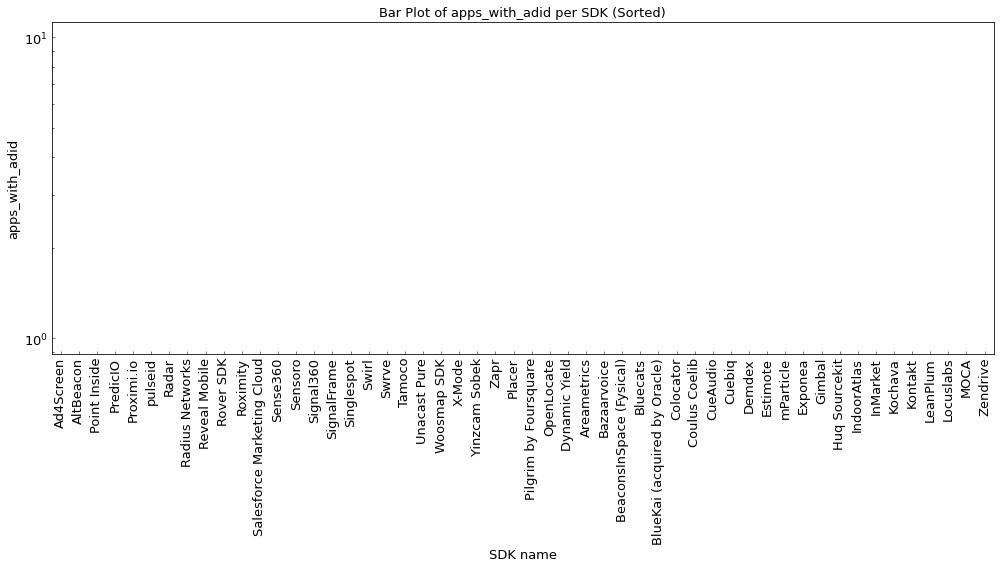

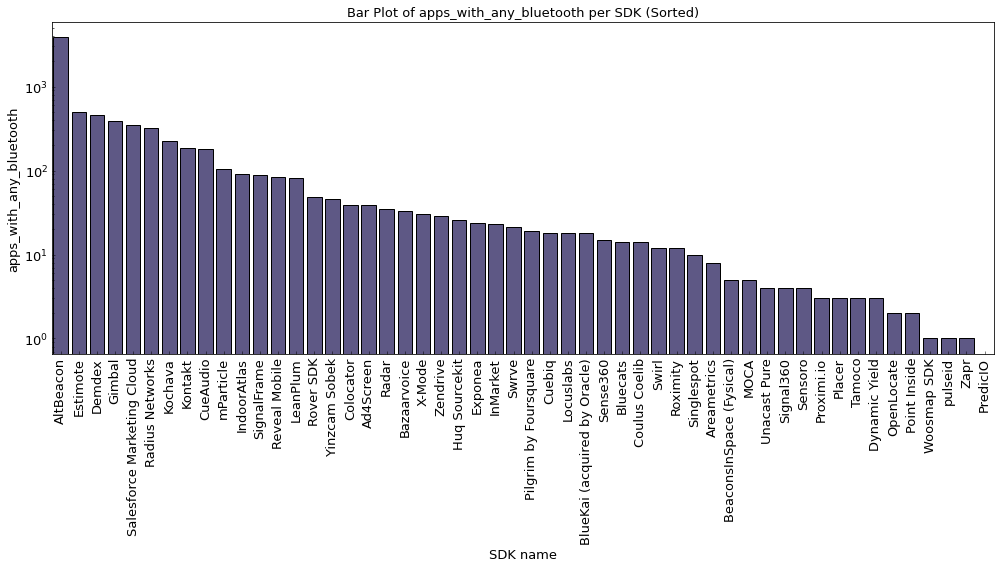

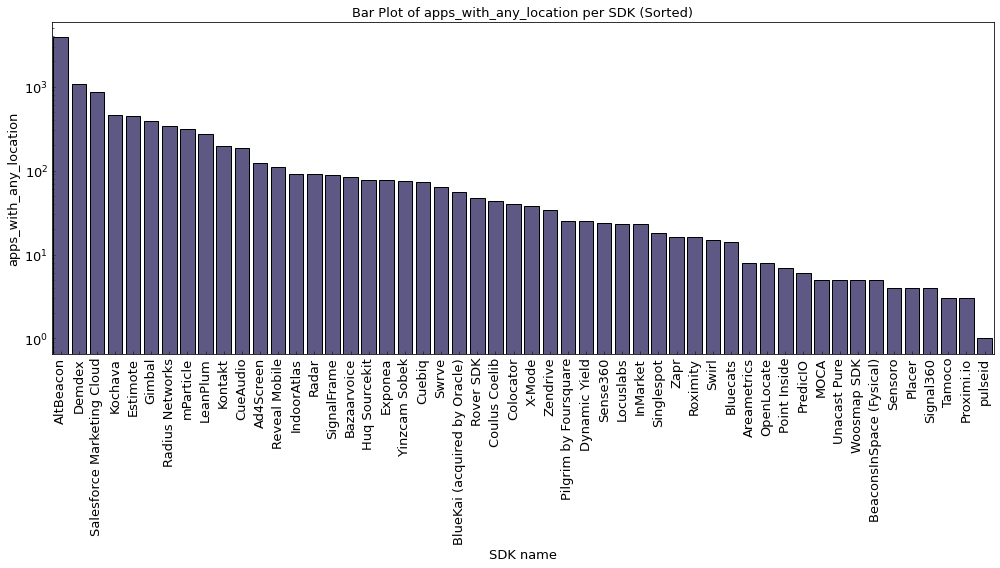

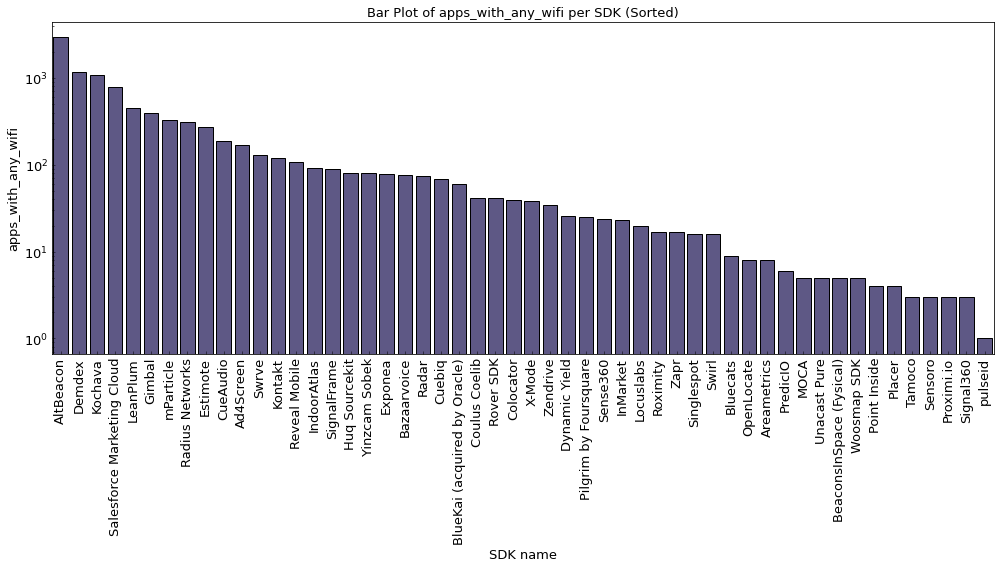

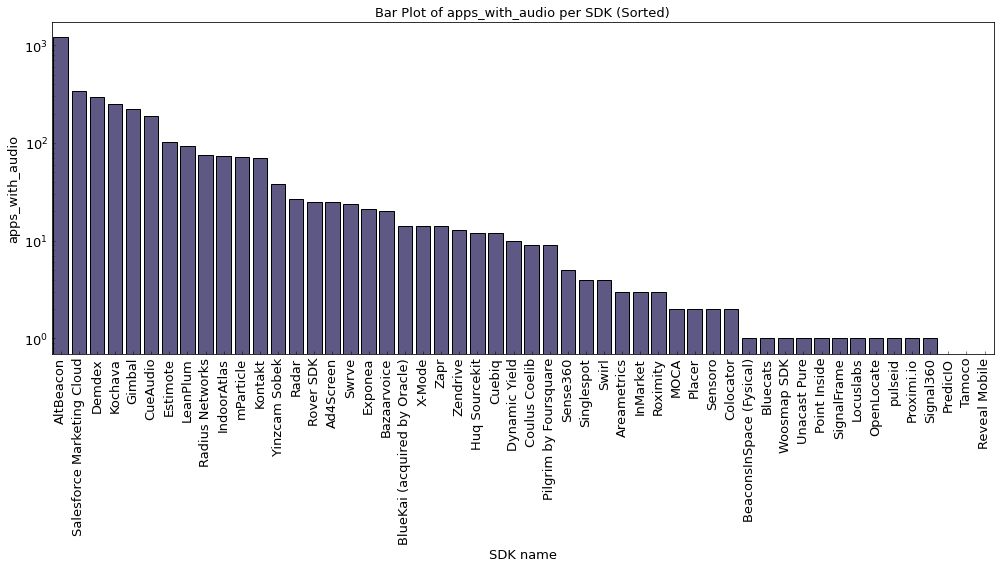

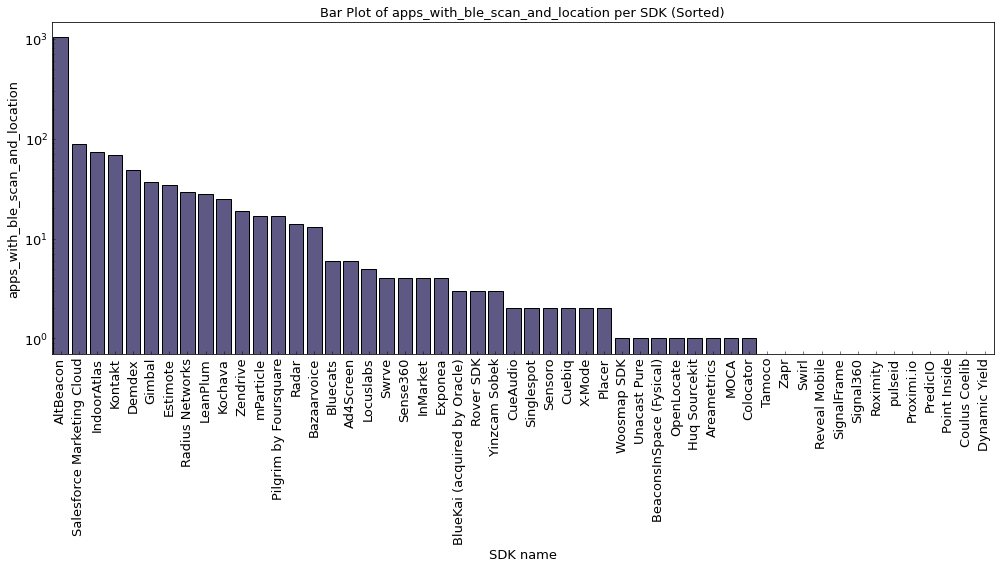

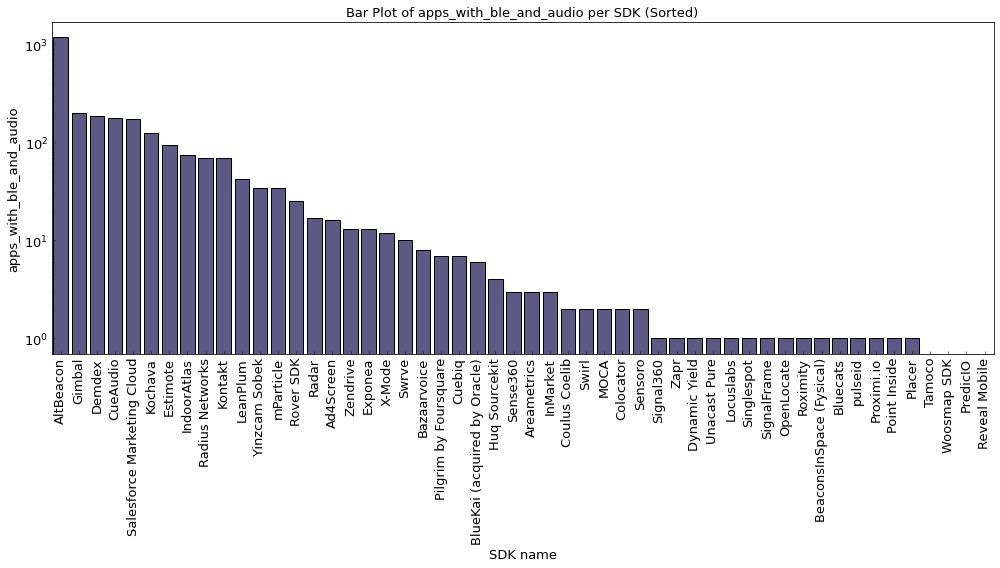

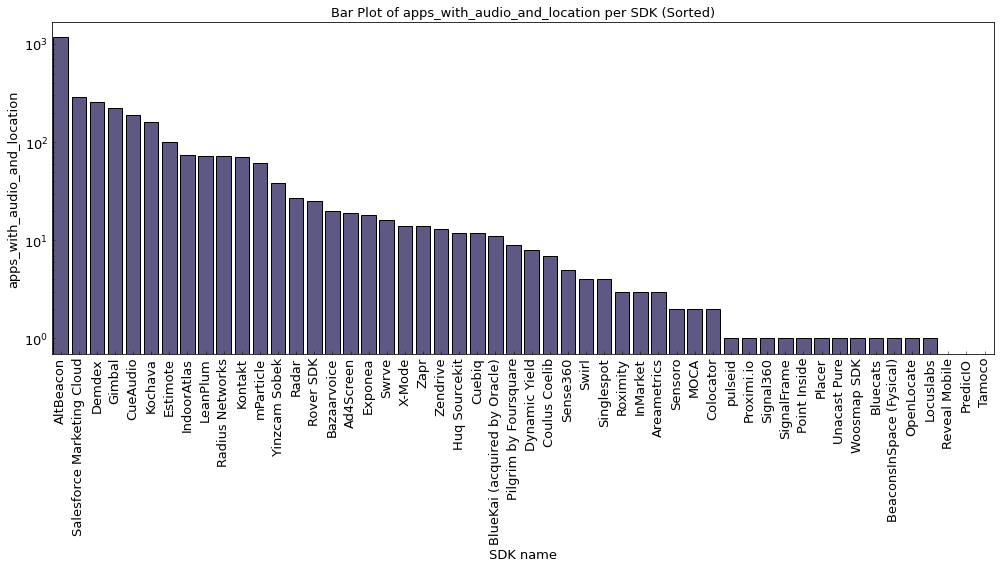

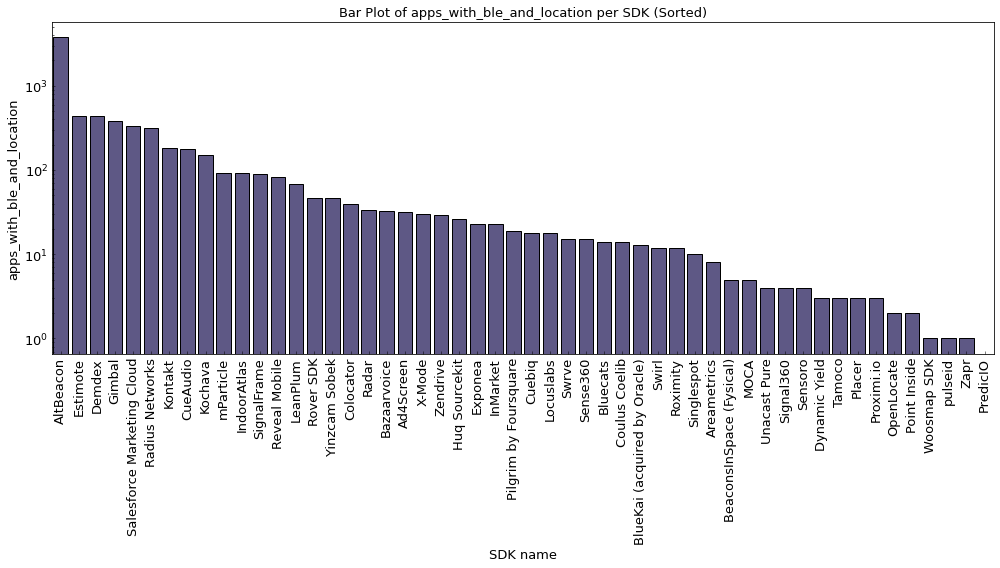

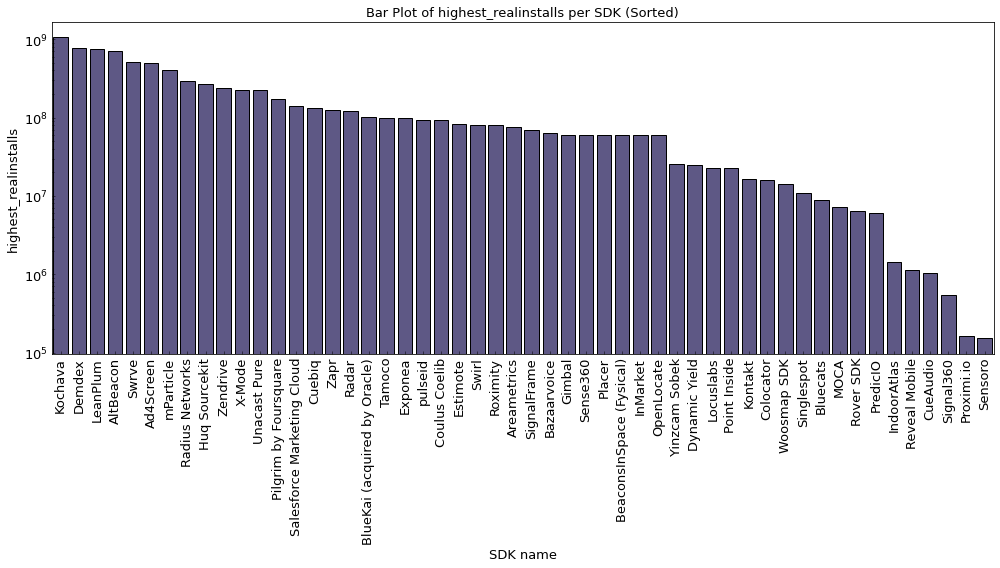

In [24]:
def create_bar_plot(feature_name):
    # Sort the data based on the feature
    sorted_feature_data = dp.sort_values(by=feature_name, ascending=False)
    plt.figure(figsize=(14, 8))
    sns.barplot(x='tracker_name', y=feature_name, data=sorted_feature_data, color="#58508d")
    plt.title(f'Bar Plot of {feature_name} per SDK (Sorted)')
    plt.xlabel('SDK name')
    plt.ylabel(feature_name)
    plt.xticks(rotation=90)  # Rotate for better readability
    plt.yscale('log')  # Use a logarithmic scale for visibility
    plt.tight_layout()  # Adjust layout
    plt.show()

# Generate and display individual plots one by one for each feature
for feature in dp.columns[2:]:
    create_bar_plot(feature)

In [25]:
pam = pd.read_csv('permission_api_mapping.csv')
pam.rename(columns={'sdk_found': 'tracker_name'}, inplace=True)

pam = pam.merge(dp, on='tracker_name', how='outer')

pam['api_call_audio'] = pam['api_call_audio'].fillna(0).astype(int)
pam['api_call_bluetooth'] = pam['api_call_bluetooth'].fillna(0).astype(int)
pam['api_call_location'] = pam['api_call_location'].fillna(0).astype(int)
pam['api_call_wifi'] = pam['api_call_wifi'].fillna(0).astype(int)
pam.to_csv('data.csv', index=False)
pam

tracker_name  api_call_audio  api_call_bluetooth  \
0                      Ad4Screen               0                   2   
1                      AltBeacon               0                3674   
2                    Areametrics               0                   5   
3       BeaconsInSpace (Fysical)               0                   4   
4                       Bluecats               0                  14   
5                      Colocator              13                  32   
6                  Coulus Coelib               0                  25   
7                       CueAudio             179                   0   
8                         Cuebiq               0                  35   
9                  Dynamic Yield               0                   0   
10                      Estimote               0                 472   
11                       Exponea               0                   3   
12                        Gimbal               0                 326   
13                 Huq Sourcekit               0                  38   
14                      InMarket               0                  15   
15                   IndoorAtlas               0                  82   
16                       Kochava               0                 674   
17                       Kontakt               0                 177   
18                      LeanPlum               0                   0   
19                     Locuslabs               0                   9   
20                          MOCA               0                   3   
21                    OpenLocate               0                   0   
22                        Placer               0                   2   
23                  Point Inside               0                   5   
24                      PredicIO               0                   2   
25                    Proximi.io               0                   2   
26                         Radar               0                  30   
27               Radius Networks               0                 306   
28                 Reveal Mobile               0                  92   
29                     Rover SDK               0                  35   
30                      Roximity               0                   0   
31                      Sense360               0                   3   
32                       Sensoro               0                   3   
33                     Signal360               4                   4   
34                   SignalFrame               0                  81   
35                    Singlespot               0                   2   
36                         Swirl               1                  10   
37                  Unacast Pure               0                   2   
38                        X-Mode               0                  25   
39                 Yinzcam Sobek               0                   0   
40                          Zapr               6                   0   
41                      Zendrive               0                  20   
42                     mParticle               0                   5   
43                       pulseid               0                   1   
44                   Bazaarvoice               0                   0   
45  BlueKai (acquired by Oracle)               0                   0   
46                        Demdex               0                   0   
47         Pilgrim by Foursquare               0                   0   
48    Salesforce Marketing Cloud               0                   0   
49                         Swrve               0                   0   
50                        Tamoco               0                   0   
51                   Woosmap SDK               0                   0   

    api_call_location  api_call_wifi  app_count  apps_with_adid  \
0                 131              2        198               0   
1                   0              0       4024               0   
2 

In [26]:
dp

tracker_name  app_count  apps_with_adid  \
0                      Ad4Screen        198               0   
1                      AltBeacon       4024               0   
2                    Areametrics          8               0   
3                    Bazaarvoice         88               0   
4       BeaconsInSpace (Fysical)          5               0   
5                       Bluecats         14               0   
6   BlueKai (acquired by Oracle)         73               0   
7                      Colocator         40               0   
8                  Coulus Coelib         47               0   
9                       CueAudio        190               0   
10                        Cuebiq         73               0   
11                        Demdex       1328               0   
12                 Dynamic Yield         27               0   
13                      Estimote        510               0   
14                       Exponea         99               0   
15                        Gimbal        396               0   
16                 Huq Sourcekit         81               0   
17                   IndoorAtlas         92               0   
18                      InMarket         23               0   
19                       Kochava       1118               0   
20                       Kontakt        195               0   
21                      LeanPlum        456               0   
22                     Locuslabs         23               0   
23                          MOCA          5               0   
24                     mParticle        367               0   
25                    OpenLocate          8               0   
26         Pilgrim by Foursquare         25               0   
27                        Placer          4               0   
28                  Point Inside          7               0   
29                      PredicIO          6               0   
30                    Proximi.io          3               0   
31                       pulseid          1               0   
32                         Radar         93               0   
33               Radius Networks        369               0   
34                 Reveal Mobile        109               0   
35                     Rover SDK         50               0   
36                      Roximity         17               0   
37    Salesforce Marketing Cloud       1080               0   
38                      Sense360         24               0   
39                       Sensoro          4               0   
40                     Signal360          4               0   
41                   SignalFrame         89               0   
42                    Singlespot         18               0   
43                         Swirl         16               0   
44                         Swrve        153               0   
45                        Tamoco          3               0   
46                  Unacast Pure          5               0   
47                   Woosmap SDK          5               0   
48                        X-Mode         38               0   
49                 Yinzcam Sobek         80               0   
50                          Zapr         17               0   
51                      Zendrive         34               0   

    apps_with_any_bluetooth  apps_with_any_location  apps_with_any_wifi  \
0                        39                     122                 169   
1                      3841                    3848                2927   
2                         8                       8                   8   
3                        33                      84                  77   
4                         5                       5                   5   
5                        14                      14                   9   
6                        18                      55                  60   
7                        39                      40                  39   
8    

/tmp/ipykernel_1271742/3340314738.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(rect=[1, 1, 1, 1])


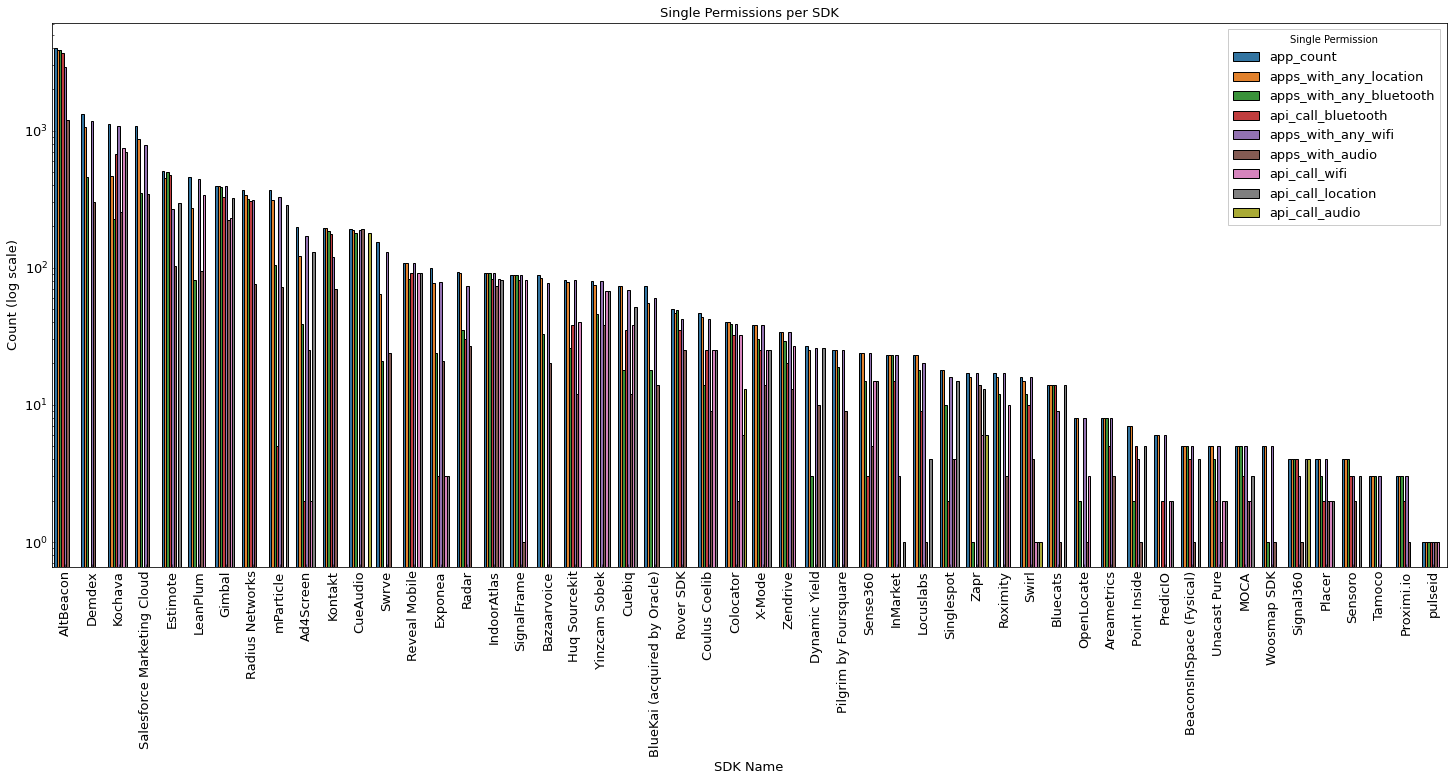

In [27]:
melted_data = pd.melt(pam, id_vars='tracker_name', var_name='feature', value_name='count')
melted_data = melted_data.sort_values(by='count', ascending=False)

# single_perm_data = melted_data[melted_data['feature'].isin(['highest_realinstalls', 'apps_with_any_bluetooth', 'apps_with_any_location', 'apps_with_audio'])]
single_perm_data = melted_data[melted_data['feature'].isin(['app_count', 'apps_with_any_bluetooth', 'api_call_bluetooth', 'apps_with_any_location', 'api_call_location', 'apps_with_any_wifi', 'api_call_wifi', 'apps_with_audio', 'api_call_audio'])]

# Subset for apps with combinations of permissions
comb_perm_data = melted_data[melted_data['feature'].isin(['apps_with_ble_scan_and_location', 'apps_with_ble_and_audio', 'apps_with_audio_and_location', 'apps_with_ble_and_location'])]

# Plot for single permissions
plt.figure(figsize=(25, 10))
sns.barplot(x='tracker_name', y='count', hue='feature', data=single_perm_data, palette='tab10')
plt.title('Single Permissions per SDK')
plt.xlabel('SDK Name')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=90)
plt.yscale('log')
plt.legend(title='Single Permission', loc='upper right')
plt.tight_layout(rect=[1, 1, 1, 1])
plt.savefig("single-perm-sdk-mapping.pdf", format="pdf", bbox_inches="tight")
plt.show()

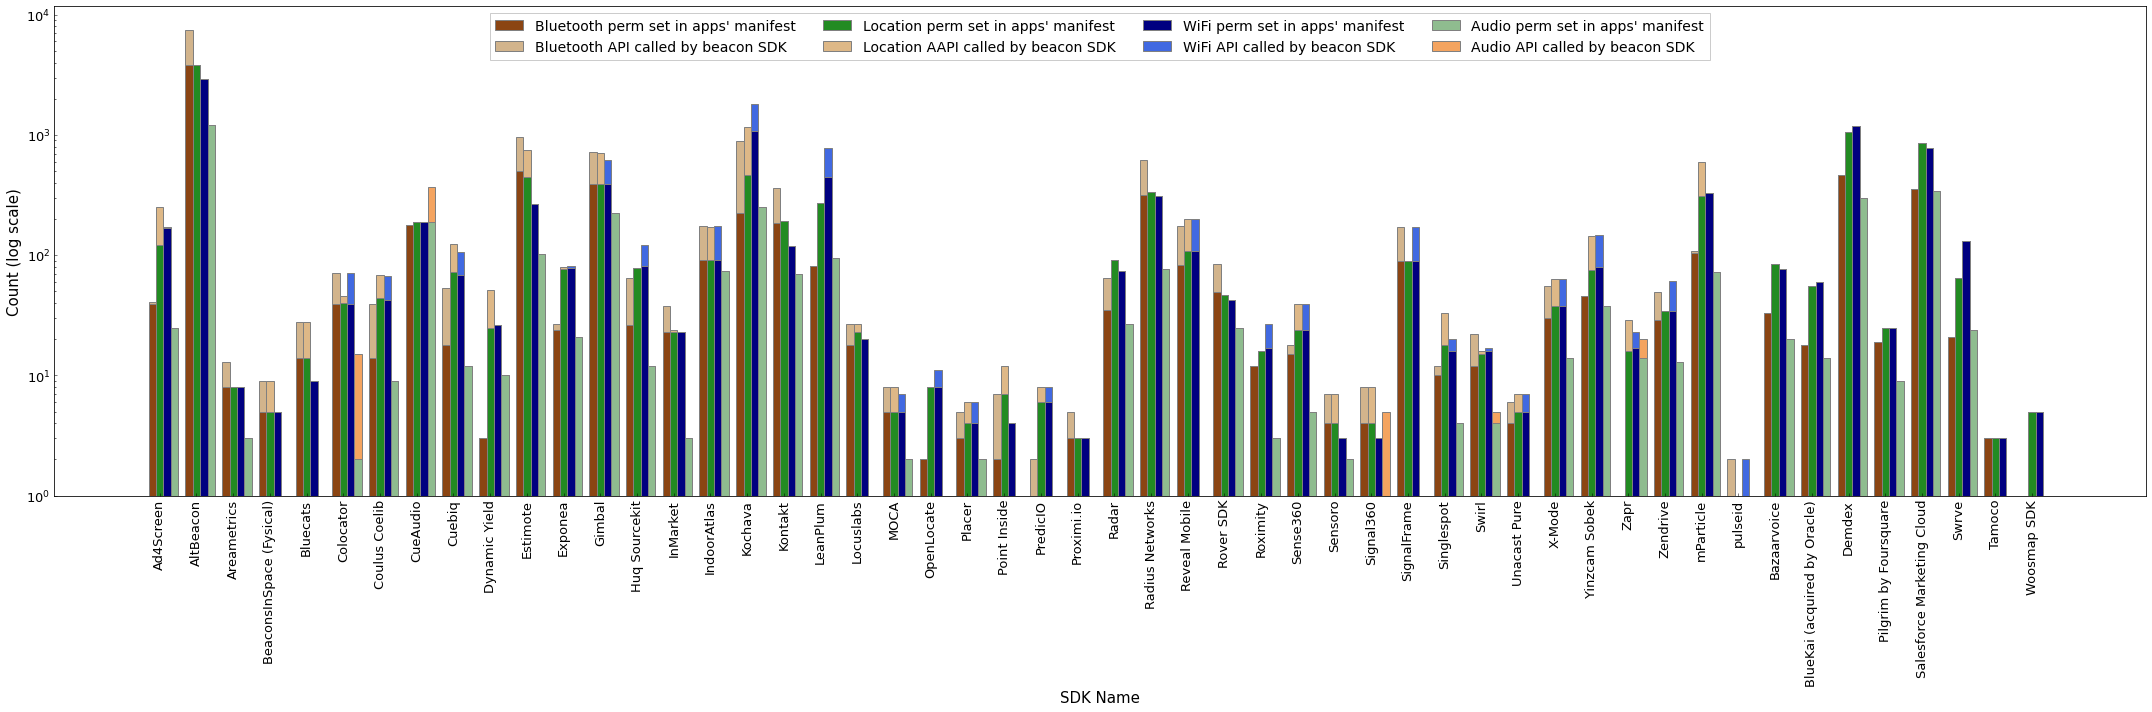

In [28]:
# Create a new dataframe for the stacked plot
# pam = pam.sort_values(by='apps_with_any_bluetooth', ascending=False)


stacked_data = pam[['tracker_name', 
                   'apps_with_any_bluetooth', 'api_call_bluetooth',
                   'apps_with_any_location', 'api_call_location',
                   'apps_with_any_wifi', 'api_call_wifi',
                   'apps_with_audio', 'api_call_audio']]



# Prepare data for plotting
stacked_data_melted = pd.melt(stacked_data, id_vars='tracker_name', var_name='feature', value_name='count')
# stacked_data_melted = stacked_data_melted.sort_values(by='count', ascending=False)


# Group the features as per the stacks required
def categorize_feature(feature):
    if 'bluetooth' in feature:
        return 'Bluetooth'
    elif 'location' in feature:
        return 'Location'
    elif 'audio' in feature:
        return 'Audio'
    elif 'wifi' in feature:
        return 'WiFi'
    else:
        return 'Apps'

stacked_data_melted['category'] = stacked_data_melted['feature'].apply(categorize_feature)

# Further categorize into apps and api calls
def detail_category(feature):
    if 'api_call' in feature:
        return 'API Call'
    else:
        return 'Apps'

stacked_data_melted['detail_category'] = stacked_data_melted['feature'].apply(detail_category)

# Plotting the data
fig, ax = plt.subplots(figsize=(30, 10))

# Define the bar width and positions
bar_width = 0.2
r1 = range(len(stacked_data['tracker_name']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plot each stack for Bluetooth
bluetooth_apps = stacked_data_melted[(stacked_data_melted['category'] == 'Bluetooth') & (stacked_data_melted['detail_category'] == 'Apps')]
bluetooth_api_calls = stacked_data_melted[(stacked_data_melted['category'] == 'Bluetooth') & (stacked_data_melted['detail_category'] == 'API Call')]
ax.bar(r1, bluetooth_apps['count'], color='#8B4513', width=bar_width, edgecolor='grey', label='Bluetooth perm set in apps\' manifest')
ax.bar(r1, bluetooth_api_calls['count'], bottom=bluetooth_apps['count'], color='#D2B48C', width=bar_width, edgecolor='grey', label='Bluetooth API called by beacon SDK')

# Plot each stack for Location
location_apps = stacked_data_melted[(stacked_data_melted['category'] == 'Location') & (stacked_data_melted['detail_category'] == 'Apps')]
location_api_calls = stacked_data_melted[(stacked_data_melted['category'] == 'Location') & (stacked_data_melted['detail_category'] == 'API Call')]
ax.bar(r2, location_apps['count'], color='#228B22', width=bar_width, edgecolor='grey', label='Location perm set in apps\' manifest')
ax.bar(r2, location_api_calls['count'], bottom=location_apps['count'], color='#DEB887', width=bar_width, edgecolor='grey', label='Location AAPI called by beacon SDK')

# Plot each stack for WiFi
wifi_apps = stacked_data_melted[(stacked_data_melted['category'] == 'WiFi') & (stacked_data_melted['detail_category'] == 'Apps')]
wifi_api_calls = stacked_data_melted[(stacked_data_melted['category'] == 'WiFi') & (stacked_data_melted['detail_category'] == 'API Call')]
ax.bar(r3, wifi_apps['count'], color='#000080', width=bar_width, edgecolor='grey', label='WiFi perm set in apps\' manifest')
ax.bar(r3, wifi_api_calls['count'], bottom=wifi_apps['count'], color='#4169E1', width=bar_width, edgecolor='grey', label='WiFi API called by beacon SDK')

# Plot each stack for Audio
audio_apps = stacked_data_melted[(stacked_data_melted['category'] == 'Audio') & (stacked_data_melted['detail_category'] == 'Apps')]
audio_api_calls = stacked_data_melted[(stacked_data_melted['category'] == 'Audio') & (stacked_data_melted['detail_category'] == 'API Call')]
ax.bar(r4, audio_apps['count'], color='#8FBC8F', width=bar_width, edgecolor='grey', label='Audio perm set in apps\' manifest')
ax.bar(r4, audio_api_calls['count'], bottom=audio_apps['count'], color='#F4A460', width=bar_width, edgecolor='grey', label='Audio API called by beacon SDK')

# Customize plot
# ax.set_title('Stacked Permissions per SDK', fontsize=20)
ax.set_xlabel('SDK Name', fontsize=15)
ax.set_ylabel('Count (log scale)', fontsize=15)
ax.set_xticks([r + bar_width for r in range(len(stacked_data['tracker_name']))])
ax.set_xticklabels(stacked_data['tracker_name'], rotation=90)
ax.set_yscale('log')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=4, fontsize=14)

# ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


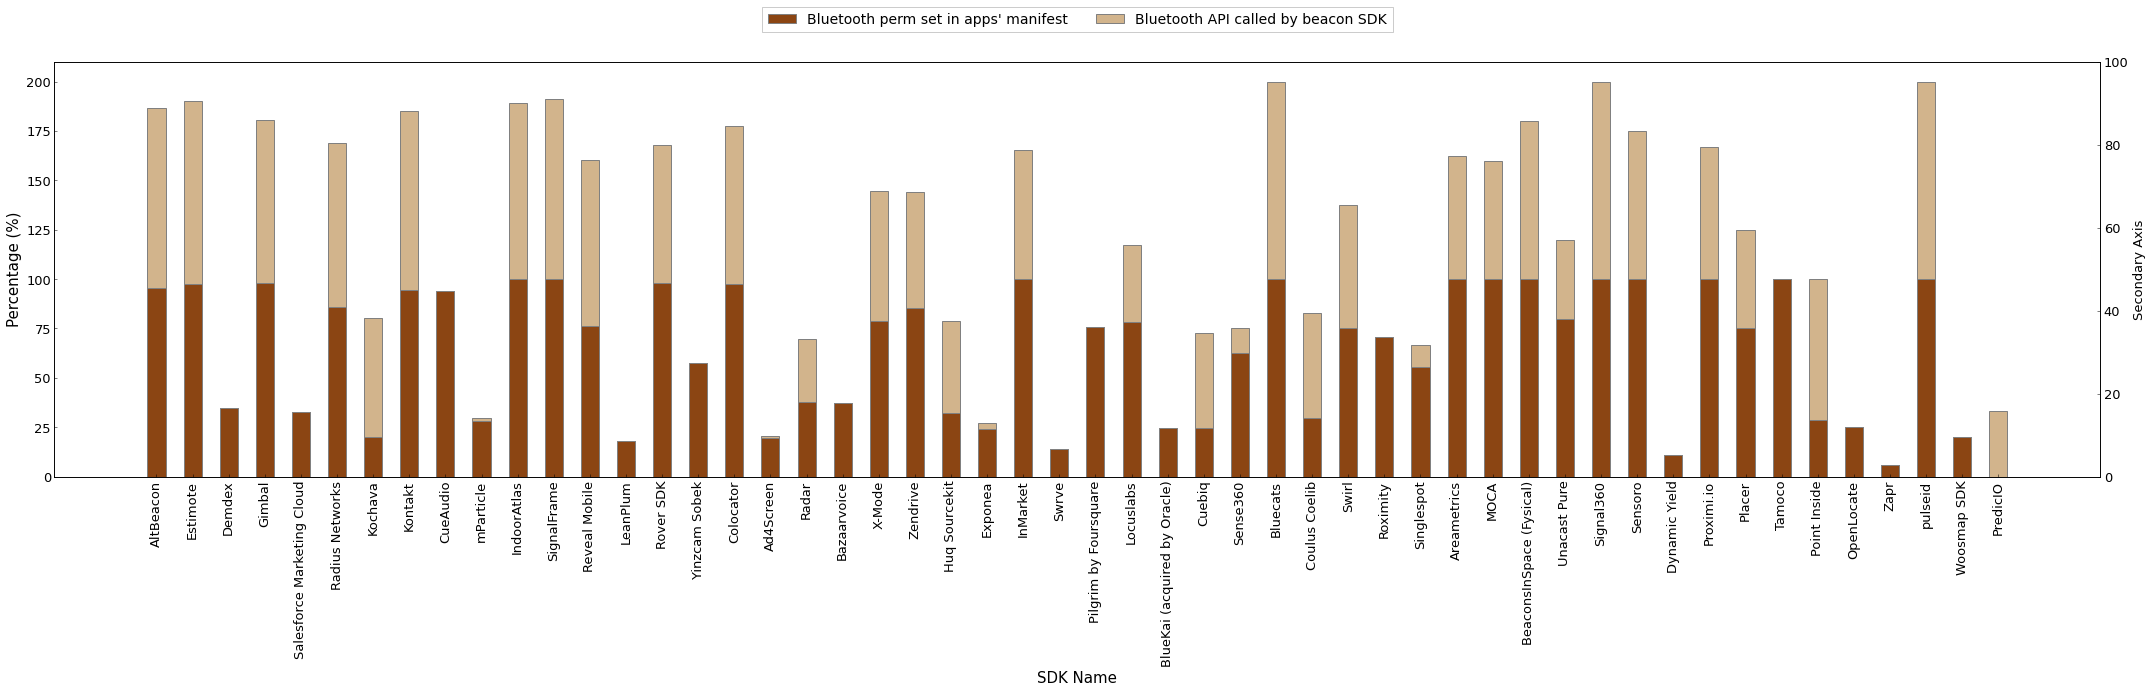

In [29]:
data  = pam

data = data.sort_values(by='apps_with_any_bluetooth', ascending=False)

# Calculate the percentages for Bluetooth permissions and API calls
data['percent_apps_with_bluetooth'] = data['apps_with_any_bluetooth'] / data['app_count'] * 100
data['percent_api_call_bluetooth'] = data['api_call_bluetooth'] / data['app_count'] * 100

# Prepare data for plotting
bluetooth_data = data[['tracker_name', 'percent_apps_with_bluetooth', 'percent_api_call_bluetooth']]

# Melt the dataframe for easier plotting
bluetooth_data_melted = pd.melt(bluetooth_data, id_vars='tracker_name', var_name='feature', value_name='percent')
# bluetooth_data_melted = bluetooth_data_melted.sort_values(by='percent', ascending=False)

# Plotting the percentage stacked bar chart for Bluetooth group only with secondary y-axis
fig, ax1 = plt.subplots(figsize=(30, 10))

# Define the bar width and positions
bar_width = 0.5
r = range(len(bluetooth_data['tracker_name']))

# Initialize bottom position for stacking
bottom = [0] * len(r)

# Plot Bluetooth permissions and API calls
bluetooth_apps = bluetooth_data_melted[bluetooth_data_melted['feature'] == 'percent_apps_with_bluetooth']
bluetooth_api_calls = bluetooth_data_melted[bluetooth_data_melted['feature'] == 'percent_api_call_bluetooth']

ax1.bar(r, bluetooth_apps['percent'], color='#8B4513', width=bar_width, edgecolor='grey', bottom=bottom, label='Bluetooth perm set in apps\' manifest')
bottom += bluetooth_apps['percent'].values
ax1.bar(r, bluetooth_api_calls['percent'], color='#D2B48C', width=bar_width, edgecolor='grey', bottom=bottom, label='Bluetooth API called by beacon SDK')

# Customize plot
ax1.set_xlabel('SDK Name', fontsize=15)
ax1.set_ylabel('Percentage (%)', fontsize=15)
ax1.set_xticks(r)
ax1.set_xticklabels(bluetooth_data['tracker_name'], rotation=90)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, fontsize=14)

# Adding secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylim(0, 100)
ax2.set_yticks(range(0, 101, 20))
ax2.set_ylabel('Secondary Axis')

plt.tight_layout()
plt.show()


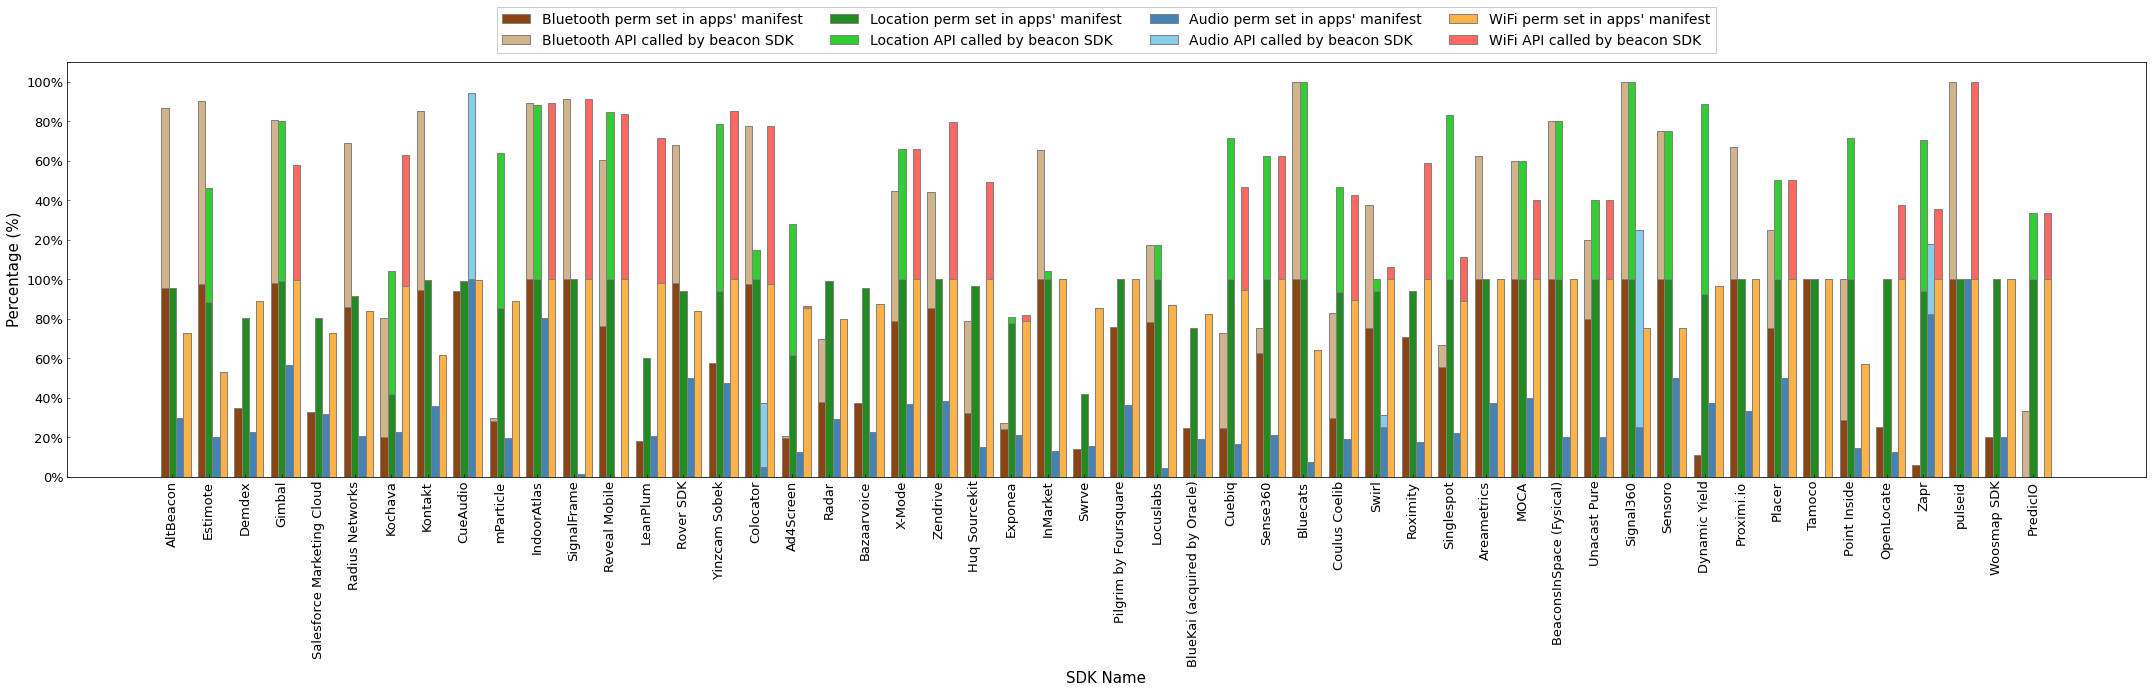

In [32]:
data  = pam

data = data.sort_values(by='apps_with_any_bluetooth', ascending=False)

# Calculate the percentages for Bluetooth, Location, and Audio permissions and API calls
data['percent_apps_with_bluetooth'] = data['apps_with_any_bluetooth'] / data['app_count'] * 100
data['percent_api_call_bluetooth'] = data['api_call_bluetooth'] / data['app_count'] * 100
data['percent_apps_with_location'] = data['apps_with_any_location'] / data['app_count'] * 100
data['percent_api_call_location'] = data['api_call_location'] / data['app_count'] * 100
data['percent_apps_with_audio'] = data['apps_with_audio'] / data['app_count'] * 100
data['percent_api_call_audio'] = data['api_call_audio'] / data['app_count'] * 100
data['percent_app_with_wifi'] = data['apps_with_any_wifi'] / data['app_count'] * 100
data['percent_api_call_wifi'] = data['api_call_wifi'] / data['app_count'] * 100


# Prepare data for plotting
data_melted = pd.melt(data, id_vars='tracker_name', 
                      value_vars=['percent_apps_with_bluetooth', 'percent_api_call_bluetooth', 
                                  'percent_apps_with_location', 'percent_api_call_location', 
                                  'percent_apps_with_audio', 'percent_api_call_audio',
                                  'percent_app_with_wifi', 'percent_api_call_wifi'], 
                      var_name='permission_type', value_name='percent')

# Plotting the percentage stacked bar chart
fig, ax = plt.subplots(figsize=(30, 10))

# Define the bar width and positions
bar_width = 0.2
r = range(len(data['tracker_name']))

# Initialize bottom position for stacking
bottom_bluetooth = [0] * len(r)
bottom_location = [0] * len(r)
bottom_audio = [0] * len(r)
bottom_wifi = [0] * len(r)


# Plot Bluetooth permissions and API calls
bluetooth_apps = data['percent_apps_with_bluetooth']
bluetooth_api_calls = data['percent_api_call_bluetooth']
ax.bar(r, bluetooth_apps, color='#8B4513', width=bar_width, edgecolor='grey', bottom=bottom_bluetooth, label='Bluetooth perm set in apps\' manifest')
bottom_bluetooth += bluetooth_apps.values
ax.bar(r, bluetooth_api_calls, color='#D2B48C', width=bar_width, edgecolor='grey', bottom=bottom_bluetooth, label='Bluetooth API called by beacon SDK')

# Plot Location permissions and API calls
location_apps = data['percent_apps_with_location']
location_api_calls = data['percent_api_call_location']
r2 = [x + bar_width for x in r]
ax.bar(r2, location_apps, color='#228B22', width=bar_width, edgecolor='grey', bottom=bottom_location, label='Location perm set in apps\' manifest')
bottom_location += location_apps.values
ax.bar(r2, location_api_calls, color='#32CD32', width=bar_width, edgecolor='grey', bottom=bottom_location, label='Location API called by beacon SDK')

# Plot Audio permissions and API calls
audio_apps = data['percent_apps_with_audio']
audio_api_calls = data['percent_api_call_audio']
r3 = [x + 2 * bar_width for x in r]
ax.bar(r3, audio_apps, color='#4682B4', width=bar_width, edgecolor='grey', bottom=bottom_audio, label='Audio perm set in apps\' manifest')
bottom_audio += audio_apps.values
ax.bar(r3, audio_api_calls, color='#87CEEB', width=bar_width, edgecolor='grey', bottom=bottom_audio, label='Audio API called by beacon SDK')

# Plot WiFi permissions and API calls
wifi_apps = data['percent_app_with_wifi']
wifi_api_calls = data['percent_api_call_wifi']
r4 = [x + 3 * bar_width for x in r]
ax.bar(r4, wifi_apps, color='#FFB347', width=bar_width, edgecolor='grey', bottom=bottom_wifi, label='WiFi perm set in apps\' manifest')
bottom_wifi += wifi_apps.values
ax.bar(r4, wifi_api_calls, color='#FF6961', width=bar_width, edgecolor='grey', bottom=bottom_wifi, label='WiFi API called by beacon SDK')

# Customize plot
ax.set_xlabel('SDK Name', fontsize=15)
ax.set_ylabel('Percentage (%)', fontsize=15)
ax.set_xticks([r + bar_width for r in range(len(data['tracker_name']))])
ax.set_xticklabels(data['tracker_name'], rotation=90)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=14)

yticks = list(range(0, 201, 20))  # Adjust this if you want a different range
yticklabels = [f"{i%100}%" if i % 100 != 0 or i == 0 else "100%" for i in yticks]

ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

# # Add a vertical line at the 100% mark
# ax.axhline(100, color='black', linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

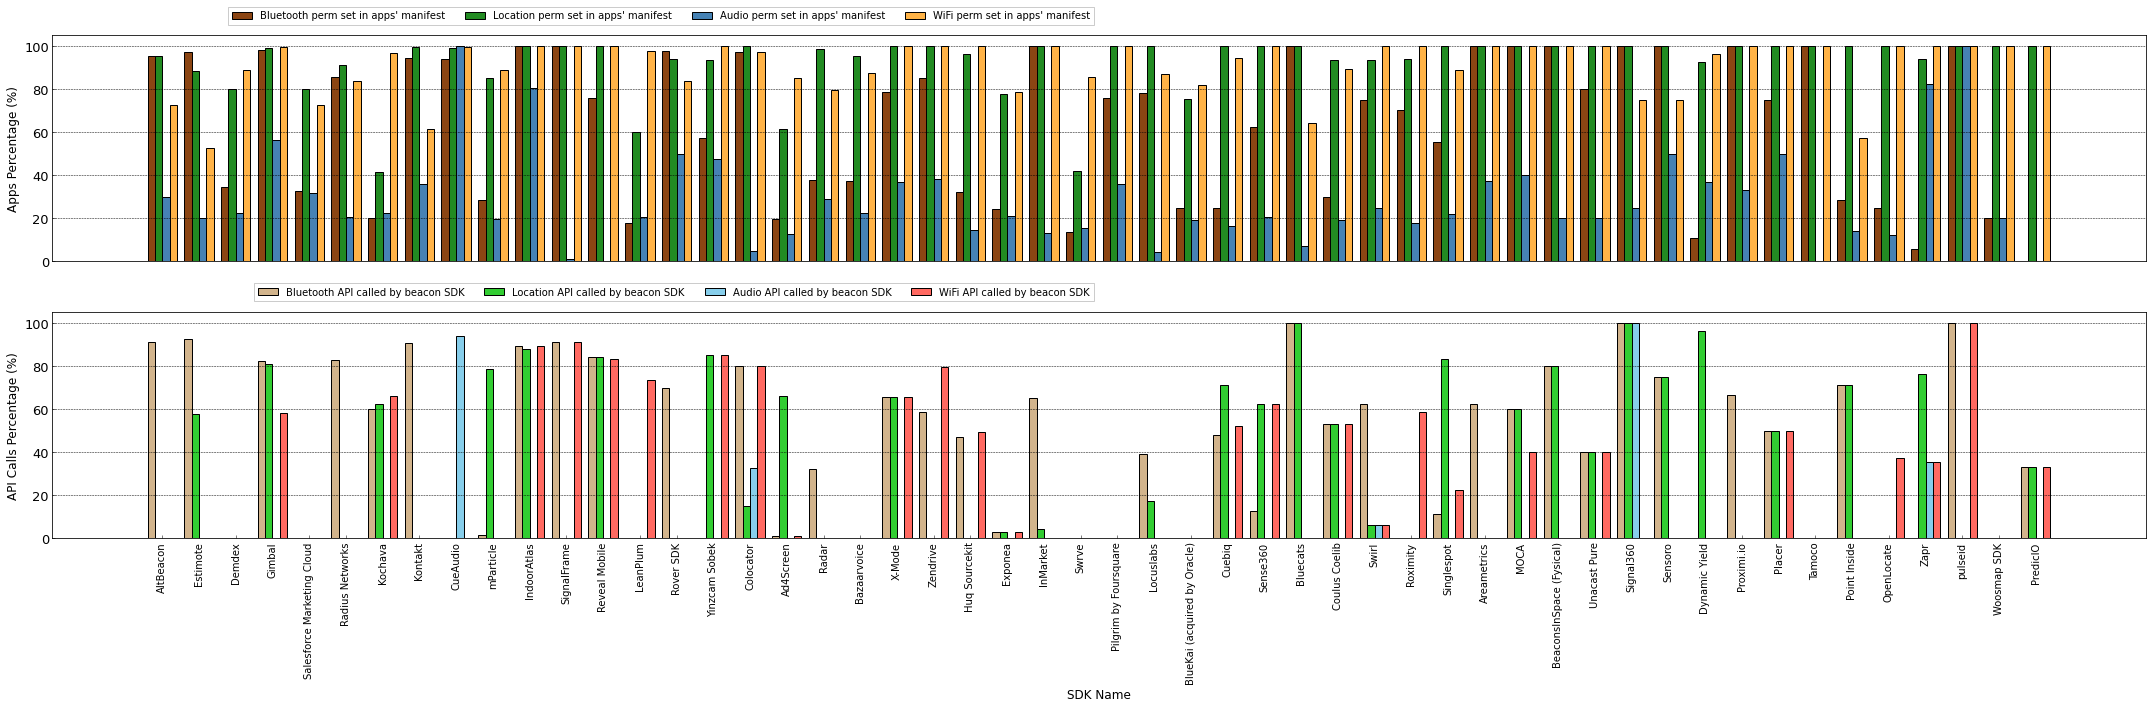

In [33]:
data  = pam

data = data.sort_values(by='apps_with_any_bluetooth', ascending=False)

# Calculate the percentages for Bluetooth, Location, and Audio permissions and API calls
data['percent_apps_with_bluetooth'] = data['apps_with_any_bluetooth'] / data['app_count'] * 100
data['percent_api_call_bluetooth'] = data['api_call_bluetooth'] / data['app_count'] * 100
data['percent_apps_with_location'] = data['apps_with_any_location'] / data['app_count'] * 100
data['percent_api_call_location'] = data['api_call_location'] / data['app_count'] * 100
data['percent_apps_with_audio'] = data['apps_with_audio'] / data['app_count'] * 100
data['percent_api_call_audio'] = data['api_call_audio'] / data['app_count'] * 100
data['percent_app_with_wifi'] = data['apps_with_any_wifi'] / data['app_count'] * 100
data['percent_api_call_wifi'] = data['api_call_wifi'] / data['app_count'] * 100


# # Sort data by apps_with_any_bluetooth
# data = data.sort_values(by='percent_apps_with_bluetooth', ascending=False)

# Prepare the data for plotting
r = range(len(data['tracker_name']))

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 10), sharex=True)

# Define the bar width and positions
bar_width = 0.2
r = range(len(data['tracker_name']))

# Plot apps permissions on the first subplot
ax1.bar(r, data['percent_apps_with_bluetooth'], color='#8B4513', width=bar_width, label='Bluetooth perm set in apps\' manifest')
ax1.bar([x + bar_width for x in r], data['percent_apps_with_location'], color='#228B22', width=bar_width, label='Location perm set in apps\' manifest')
ax1.bar([x + 2 * bar_width for x in r], data['percent_apps_with_audio'], color='#4682B4', width=bar_width, label='Audio perm set in apps\' manifest')
ax1.bar([x + 3 * bar_width for x in r], data['percent_app_with_wifi'], color='#FFB347', width=bar_width, label='WiFi perm set in apps\' manifest')

ax1.set_ylabel('Apps Percentage (%)', fontsize=12)
ax1.legend(loc='upper right', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=10)
# ax1.set_title('Permissions Set in Apps\' Manifest', fontsize=14)
ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Plot API calls on the second subplot
ax2.bar(r, data['percent_api_call_bluetooth'], color='#D2B48C', width=bar_width, label='Bluetooth API called by beacon SDK')
ax2.bar([x + bar_width for x in r], data['percent_api_call_location'], color='#32CD32', width=bar_width, label='Location API called by beacon SDK')
ax2.bar([x + 2 * bar_width for x in r], data['percent_api_call_audio'], color='#87CEEB', width=bar_width, label='Audio API called by beacon SDK')
ax2.bar([x + 3 * bar_width for x in r], data['percent_api_call_wifi'], color='#FF6961', width=bar_width, label='WiFi API called by beacon SDK')

ax2.set_xlabel('SDK Name', fontsize=12)
ax2.set_ylabel('API Calls Percentage (%)', fontsize=12)
ax2.set_xticks([r + 1.5 * bar_width for r in range(len(data['tracker_name']))])
ax2.set_xticklabels(data['tracker_name'], rotation=90, fontsize=10)
ax2.legend(loc='upper right', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=10)
# ax2.set_title('API Calls by Beacon SDK', fontsize=14)
ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [34]:
3841 / 4024

0.9545228628230616

In [35]:
3674 /4024

0.9130218687872763

In [36]:
data

tracker_name  api_call_audio  api_call_bluetooth  \
1                      AltBeacon               0                3674   
10                      Estimote               0                 472   
46                        Demdex               0                   0   
12                        Gimbal               0                 326   
48    Salesforce Marketing Cloud               0                   0   
27               Radius Networks               0                 306   
16                       Kochava               0                 674   
17                       Kontakt               0                 177   
7                       CueAudio             179                   0   
42                     mParticle               0                   5   
15                   IndoorAtlas               0                  82   
34                   SignalFrame               0                  81   
28                 Reveal Mobile               0                  92   
18                      LeanPlum               0                   0   
29                     Rover SDK               0                  35   
39                 Yinzcam Sobek               0                   0   
5                      Colocator              13                  32   
0                      Ad4Screen               0                   2   
26                         Radar               0                  30   
44                   Bazaarvoice               0                   0   
38                        X-Mode               0                  25   
41                      Zendrive               0                  20   
13                 Huq Sourcekit               0                  38   
11                       Exponea               0                   3   
14                      InMarket               0                  15   
49                         Swrve               0                   0   
47         Pilgrim by Foursquare               0                   0   
19                     Locuslabs               0                   9   
45  BlueKai (acquired by Oracle)               0                   0   
8                         Cuebiq               0                  35   
31                      Sense360               0                   3   
4                       Bluecats               0                  14   
6                  Coulus Coelib               0                  25   
36                         Swirl               1                  10   
30                      Roximity               0                   0   
35                    Singlespot               0                   2   
2                    Areametrics               0                   5   
20                          MOCA               0                   3   
3       BeaconsInSpace (Fysical)               0                   4   
37                  Unacast Pure               0                   2   
33                     Signal360               4                   4   
32                       Sensoro               0                   3   
9                  Dynamic Yield               0                   0   
25                    Proximi.io               0                   2   
22                        Placer               0                   2   
50                        Tamoco               0                   0   
23                  Point Inside               0                   5   
21                    OpenLocate               0                   0   
40                          Zapr               6                   0   
43                       pulseid               0                   1   
51                   Woosmap SDK               0                   0   
24                      PredicIO               0                   2   

    api_call_location  api_call_wifi  app_count  apps_with_adid  \
1                   0              0       4024               0   
10                295              0        510               0   
46

In [37]:
data[['tracker_name', 'percent_apps_with_bluetooth', 'percent_api_call_bluetooth',	'percent_apps_with_location', 'percent_api_call_location',	
    'percent_apps_with_audio', 'percent_api_call_audio', 'percent_app_with_wifi', 'percent_api_call_wifi']].to_csv('permission_data.csv', index=False)

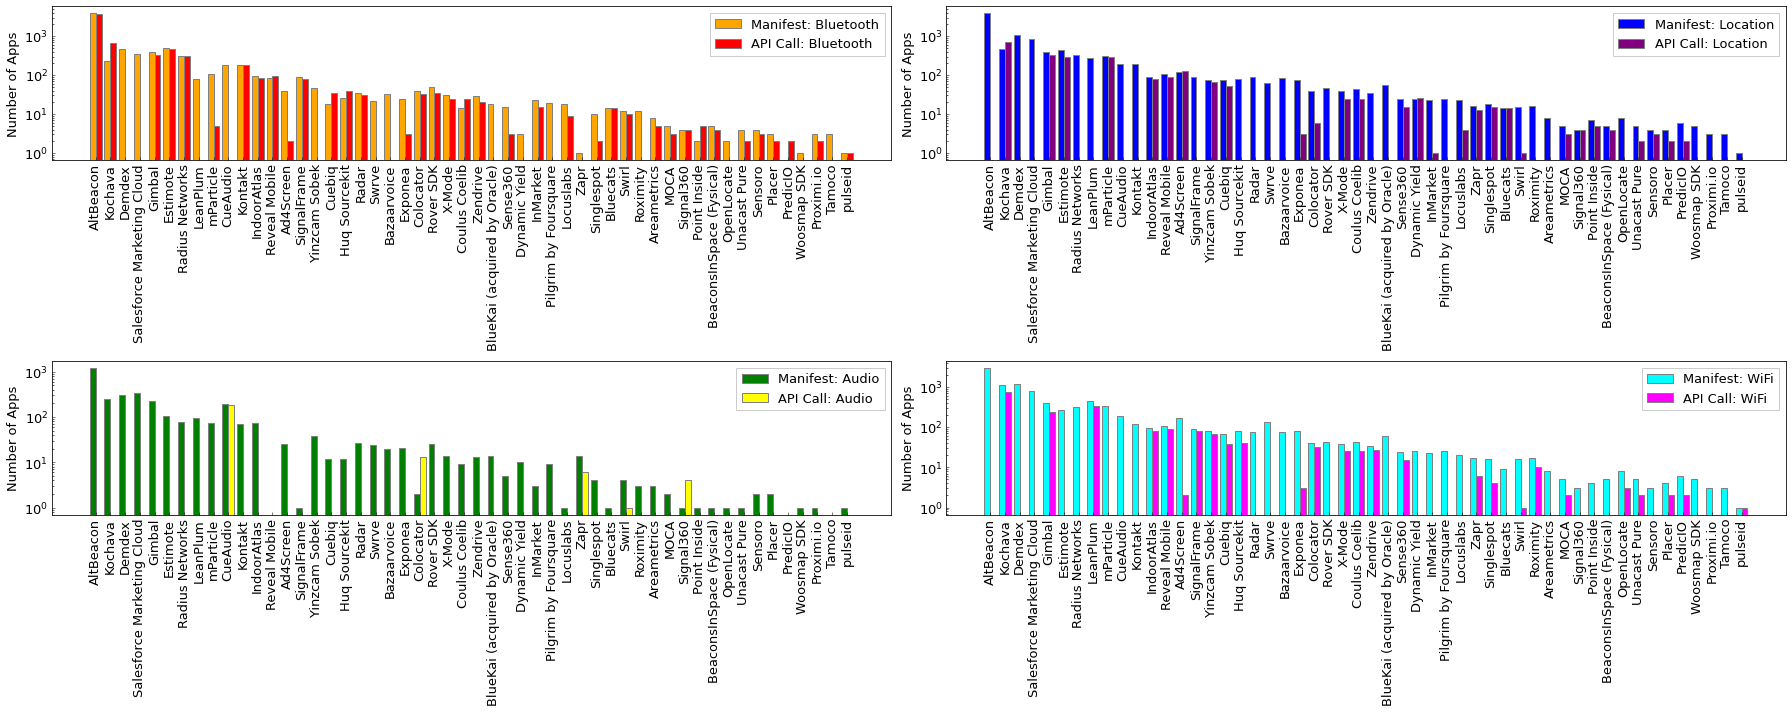

In [38]:
# Fill NaN values with 0
data = pam

data.fillna(0, inplace=True)

data['total_apps'] = (
    data['apps_with_any_bluetooth'] + data['api_call_bluetooth'] +
    data['apps_with_any_location'] + data['api_call_location'] +
    data['apps_with_audio'] + data['api_call_audio'] +
    data['apps_with_any_wifi'] + data['api_call_wifi']
)

# Sort data by the total number of apps
data.sort_values(by='total_apps', ascending=False, inplace=True)

# Drop the temporary total column after sorting
data.drop(columns=['total_apps'], inplace=True)


# Multiple Subplots with Grouped Bars (not stacked) and log scale y-axis, including WiFi

fig, axs = plt.subplots(2, 2, figsize=(25, 10))

# Define bar width and positions for grouped bars
bar_width = 0.40

# Positions for each group of bars
positions1 = [range(len(data['tracker_name']))]
positions2 = [[x + bar_width for x in positions1[0]]]

# Bluetooth
axs[0, 0].bar(positions1[0], data['apps_with_any_bluetooth'], color='orange', width=bar_width, edgecolor='grey', label='Manifest: Bluetooth')
axs[0, 0].bar(positions2[0], data['api_call_bluetooth'], color='red', width=bar_width, edgecolor='grey', label='API Call: Bluetooth')
# axs[0, 0].set_title('Bluetooth Permissions and API Calls')
axs[0, 0].legend()
axs[0, 0].set_yscale('log')

# Location
positions1 = [range(len(data['tracker_name']))]
positions2 = [[x + bar_width for x in positions1[0]]]
axs[0, 1].bar(positions1[0], data['apps_with_any_location'], color='blue', width=bar_width, edgecolor='grey', label='Manifest: Location')
axs[0, 1].bar(positions2[0], data['api_call_location'], color='purple', width=bar_width, edgecolor='grey', label='API Call: Location')
# axs[0, 1].set_title('Location Permissions and API Calls')
axs[0, 1].legend()
axs[0, 1].set_yscale('log')

# Audio
positions1 = [range(len(data['tracker_name']))]
positions2 = [[x + bar_width for x in positions1[0]]]
axs[1, 0].bar(positions1[0], data['apps_with_audio'], color='green', width=bar_width, edgecolor='grey', label='Manifest: Audio')
axs[1, 0].bar(positions2[0], data['api_call_audio'], color='yellow', width=bar_width, edgecolor='grey', label='API Call: Audio')
# axs[1, 0].set_title('Audio Permissions and API Calls')
axs[1, 0].legend()
axs[1, 0].set_yscale('log')

# WiFi
positions1 = [range(len(data['tracker_name']))]
positions2 = [[x + bar_width for x in positions1[0]]]
axs[1, 1].bar(positions1[0], data['apps_with_any_wifi'], color='cyan', width=bar_width, edgecolor='grey', label='Manifest: WiFi')
axs[1, 1].bar(positions2[0], data['api_call_wifi'], color='magenta', width=bar_width, edgecolor='grey', label='API Call: WiFi')
# axs[1, 1].set_title('WiFi Permissions and API Calls')
axs[1, 1].legend()
axs[1, 1].set_yscale('log')

for ax in axs.flat:
    ax.set_xticks([r + bar_width/2 for r in range(len(data['tracker_name']))])
    ax.set_xticklabels(data['tracker_name'], rotation=90)
    ax.set_ylabel('Number of Apps')

plt.tight_layout()
plt.show()


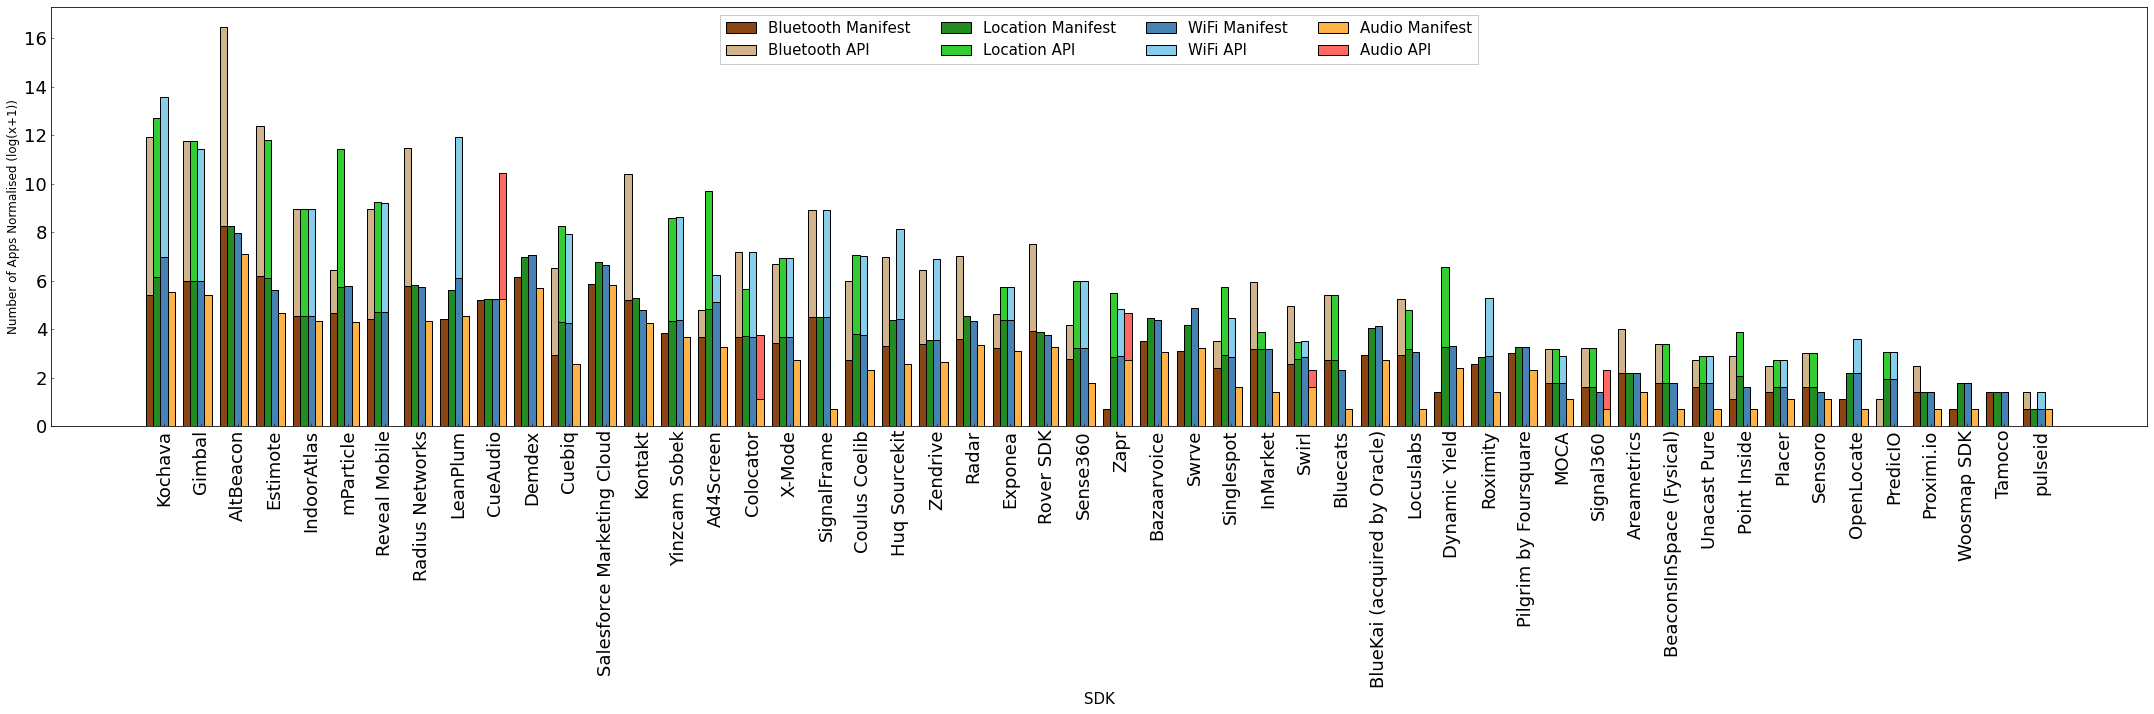

In [39]:

# Select relevant columns for plotting
plot_data = pam[['tracker_name', 'apps_with_any_bluetooth', 'api_call_bluetooth', 'apps_with_any_location', 'api_call_location', 'apps_with_any_wifi', 'api_call_wifi', 'apps_with_audio', 'api_call_audio']]

# Renaming columns for better readability in the plot
plot_data.columns = ['Tracker', 'Bluetooth_Manifest', 'Bluetooth_API', 'Location_Manifest', 'Location_API', 'WiFi_Manifest', 'WiFi_API', 'Audio_Manifest', 'Audio_API']

# Apply log transformation to each column except the 'Tracker' column
log_transformed_data = plot_data.copy()
for column in log_transformed_data.columns[1:]:
    log_transformed_data[column] = log_transformed_data[column].apply(lambda x: np.log(x + 1))

# Sort the data by the sum of all columns (excluding the Tracker column)
log_transformed_data['Total'] = log_transformed_data.iloc[:, 1:].sum(axis=1)
sorted_log_transformed_data = log_transformed_data.sort_values(by='Total', ascending=False).drop(columns='Total')

# Plotting sorted and adjusted Log Transformed data
fig, ax = plt.subplots(figsize=(30, 10))

# Adjusting the bar width and offsets
bar_width = 8
spacing = 1.0  # Increase spacing between each group
n = len(sorted_log_transformed_data)
r = np.arange(n) * (5 * bar_width + spacing)  # Increase spacing between each group

# Create the bars for Bluetooth with offset
ax.bar(r - 2 * bar_width, sorted_log_transformed_data['Bluetooth_Manifest'], color='#8B4513', width=bar_width, label='Bluetooth Manifest')
ax.bar(r - 2 * bar_width, sorted_log_transformed_data['Bluetooth_API'], color='#D2B48C', width=bar_width, bottom=sorted_log_transformed_data['Bluetooth_Manifest'], label='Bluetooth API')

# Create the bars for Location with offset
ax.bar(r - bar_width, sorted_log_transformed_data['Location_Manifest'], color='#228B22', width=bar_width, label='Location Manifest')
ax.bar(r - bar_width, sorted_log_transformed_data['Location_API'], color='#32CD32', width=bar_width, bottom=sorted_log_transformed_data['Location_Manifest'], label='Location API')

# Create the bars for WiFi with offset
ax.bar(r, sorted_log_transformed_data['WiFi_Manifest'], color='#4682B4', width=bar_width, label='WiFi Manifest')
ax.bar(r, sorted_log_transformed_data['WiFi_API'], color='#87CEEB', width=bar_width, bottom=sorted_log_transformed_data['WiFi_Manifest'], label='WiFi API')

# Create the bars for Audio with offset
ax.bar(r + bar_width, sorted_log_transformed_data['Audio_Manifest'], color='#FFB347', width=bar_width, label='Audio Manifest')
ax.bar(r + bar_width, sorted_log_transformed_data['Audio_API'], color='#FF6961', width=bar_width, bottom=sorted_log_transformed_data['Audio_Manifest'], label='Audio API')

# Adding labels and title
ax.set_xlabel('SDK', fontsize=15)
ax.set_ylabel('Number of Apps Normalised (log(x+1))', fontsize=12)
# ax.set_title('Log Transformed Permissions Requested and API Invocations (Sorted and Including AltBeacon)')
ax.set_xticks(r)
ax.set_xticklabels(sorted_log_transformed_data['Tracker'], rotation=90)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=4, fontsize=15)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

fig.savefig("log-transformed-permissions-api-calls.pdf", format="pdf", bbox_inches="tight")

# Save the plot as a PNG file
fig.tight_layout()
plt.show()  # Display the plot

In [84]:
# Calculate the percentages for Bluetooth, Location, and Audio permissions and API calls
data['percent_apps_with_bluetooth'] = data['apps_with_any_bluetooth'] / data['app_count'] * 100
data['percent_api_call_bluetooth'] = data['api_call_bluetooth'] / data['app_count'] * 100
data['percent_apps_with_location'] = data['apps_with_any_location'] / data['app_count'] * 100
data['percent_api_call_location'] = data['api_call_location'] / data['app_count'] * 100
data['percent_apps_with_audio'] = data['apps_with_audio'] / data['app_count'] * 100
data['percent_api_call_audio'] = data['api_call_audio'] / data['app_count'] * 100
data['percent_app_with_wifi'] = data['apps_with_any_wifi'] / data['app_count'] * 100
data['percent_api_call_wifi'] = data['api_call_wifi'] / data['app_count'] * 100

# Log transform the data
log_transformed_data = data.copy()
for column in log_transformed_data.columns[1:]:
    log_transformed_data[column] = log_transformed_data[column].apply(lambda x: np.log(x + 1))

# Sort data by log-transformed Bluetooth percentages
log_transformed_data = log_transformed_data.sort_values(by='percent_apps_with_bluetooth', ascending=False)

# Prepare the data for plotting
r = range(len(log_transformed_data['tracker_name']))

# Adjust the figure size and subplot layout
fig, ax = plt.subplots(figsize=(20, 10))

# Define the bar width and positions with increased spacing
bar_width = 0.2
spacing = 0.5
bar_positions = [x * (1 + spacing) for x in r]

# Plot apps permissions (solid colors)
ax.bar(bar_positions, log_transformed_data['percent_apps_with_bluetooth'], color='#8B4513', width=bar_width, label='Bluetooth perm set in apps\' manifest')
ax.bar([x + bar_width for x in bar_positions], log_transformed_data['percent_apps_with_location'], color='#228B22', width=bar_width, label='Location perm set in apps\' manifest')
ax.bar([x + 2 * bar_width for x in bar_positions], log_transformed_data['percent_apps_with_audio'], color='#4682B4', width=bar_width, label='Audio perm set in apps\' manifest')
ax.bar([x + 3 * bar_width for x in bar_positions], log_transformed_data['percent_app_with_wifi'], color='#FFB347', width=bar_width, label='WiFi perm set in apps\' manifest')

# Plot API calls (striped pattern)
ax.bar(bar_positions, log_transformed_data['percent_api_call_bluetooth'], color='none', edgecolor='#D2B48C', width=bar_width, label='Bluetooth API called by beacon SDK', hatch='//')
ax.bar([x + bar_width for x in bar_positions], log_transformed_data['percent_api_call_location'], color='none', edgecolor='#32CD32', width=bar_width, label='Location API called by beacon SDK', hatch='//')
ax.bar([x + 2 * bar_width for x in bar_positions], log_transformed_data['percent_api_call_audio'], color='none', edgecolor='#87CEEB', width=bar_width, label='Audio API called by beacon SDK', hatch='//')
ax.bar([x + 3 * bar_width for x in bar_positions], log_transformed_data['percent_api_call_wifi'], color='none', edgecolor='#FF6961', width=bar_width, label='WiFi API called by beacon SDK', hatch='//')

# Customize plot
ax.set_xlabel('SDK Name', fontsize=12)
ax.set_ylabel('Log(Percentage + 1)', fontsize=12)
ax.set_xticks([x + 1.5 * bar_width for x in bar_positions])
ax.set_xticklabels(log_transformed_data['tracker_name'], rotation=90, fontsize=10)
ax.legend(loc='upper right', fontsize=10, bbox_to_anchor=(1.2, 1.1), ncol=2)
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

TypeError: loop of ufunc does not support argument 0 of type decimal.Decimal which has no callable log method

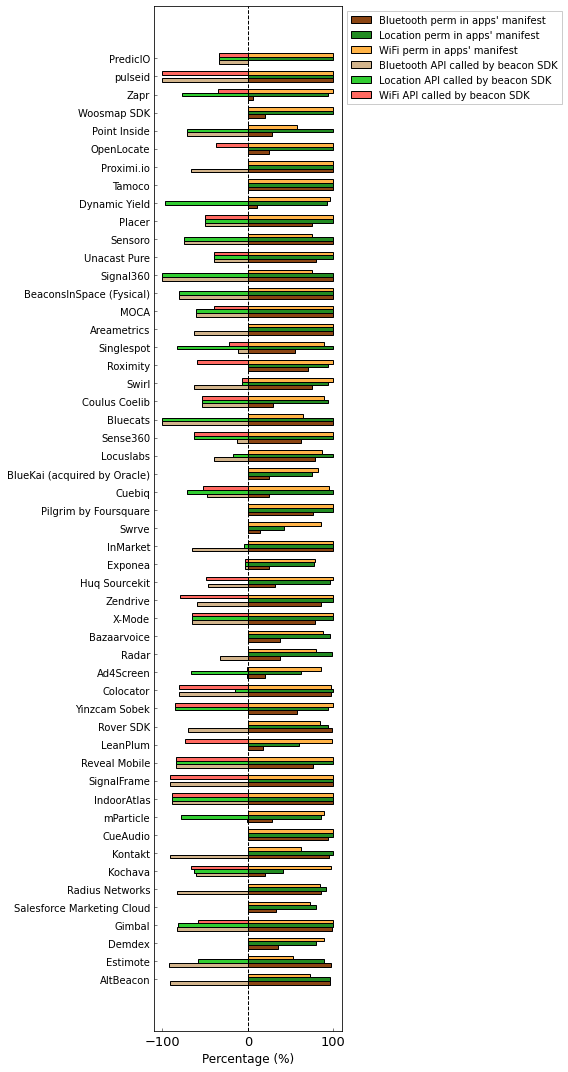

In [85]:
data  = pam

data = data.sort_values(by='apps_with_any_bluetooth', ascending=False)

# Calculate the percentages for Bluetooth, Location, and Audio permissions and API calls
data['percent_apps_with_bluetooth'] = data['apps_with_any_bluetooth'] / data['app_count'] * 100
data['percent_api_call_bluetooth'] = data['api_call_bluetooth'] / data['app_count'] * 100
data['percent_apps_with_location'] = data['apps_with_any_location'] / data['app_count'] * 100
data['percent_api_call_location'] = data['api_call_location'] / data['app_count'] * 100
data['percent_apps_with_audio'] = data['apps_with_audio'] / data['app_count'] * 100
data['percent_api_call_audio'] = data['api_call_audio'] / data['app_count'] * 100
data['percent_app_with_wifi'] = data['apps_with_any_wifi'] / data['app_count'] * 100
data['percent_api_call_wifi'] = data['api_call_wifi'] / data['app_count'] * 100

# Prepare the data for plotting
r = range(len(data['tracker_name']))

# Adjust the figure size to fit into half a column
fig, ax = plt.subplots(figsize=(8, 15))

# Define the bar height and positions
bar_height = 0.2

# Plot apps permissions on the positive side
ax.barh(r, data['percent_apps_with_bluetooth'], color='#8B4513', height=bar_height, label='Bluetooth perm in apps\' manifest')
ax.barh([x + bar_height for x in r], data['percent_apps_with_location'], color='#228B22', height=bar_height, label='Location perm in apps\' manifest')
ax.barh([x + 2 * bar_height for x in r], data['percent_app_with_wifi'], color='#FFB347', height=bar_height, label='WiFi perm in apps\' manifest')

# Plot API calls on the negative side
ax.barh(r, -data['percent_api_call_bluetooth'], color='#D2B48C', height=bar_height, label='Bluetooth API called by beacon SDK')
ax.barh([x + bar_height for x in r], -data['percent_api_call_location'], color='#32CD32', height=bar_height, label='Location API called by beacon SDK')
ax.barh([x + 2 * bar_height for x in r], -data['percent_api_call_wifi'], color='#FF6961', height=bar_height, label='WiFi API called by beacon SDK')

# Customize plot
ax.set_xlabel('Percentage (%)', fontsize=12)
ax.set_yticks([r + bar_height for r in range(len(data['tracker_name']))])
ax.set_yticklabels(data['tracker_name'], fontsize=10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize=10)
# ax.set_title('Permissions Set in Apps\' Manifest vs. API Calls by Beacon SDK', fontsize=12)

# Add a vertical line at the zero mark
ax.axvline(0, color='black', linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

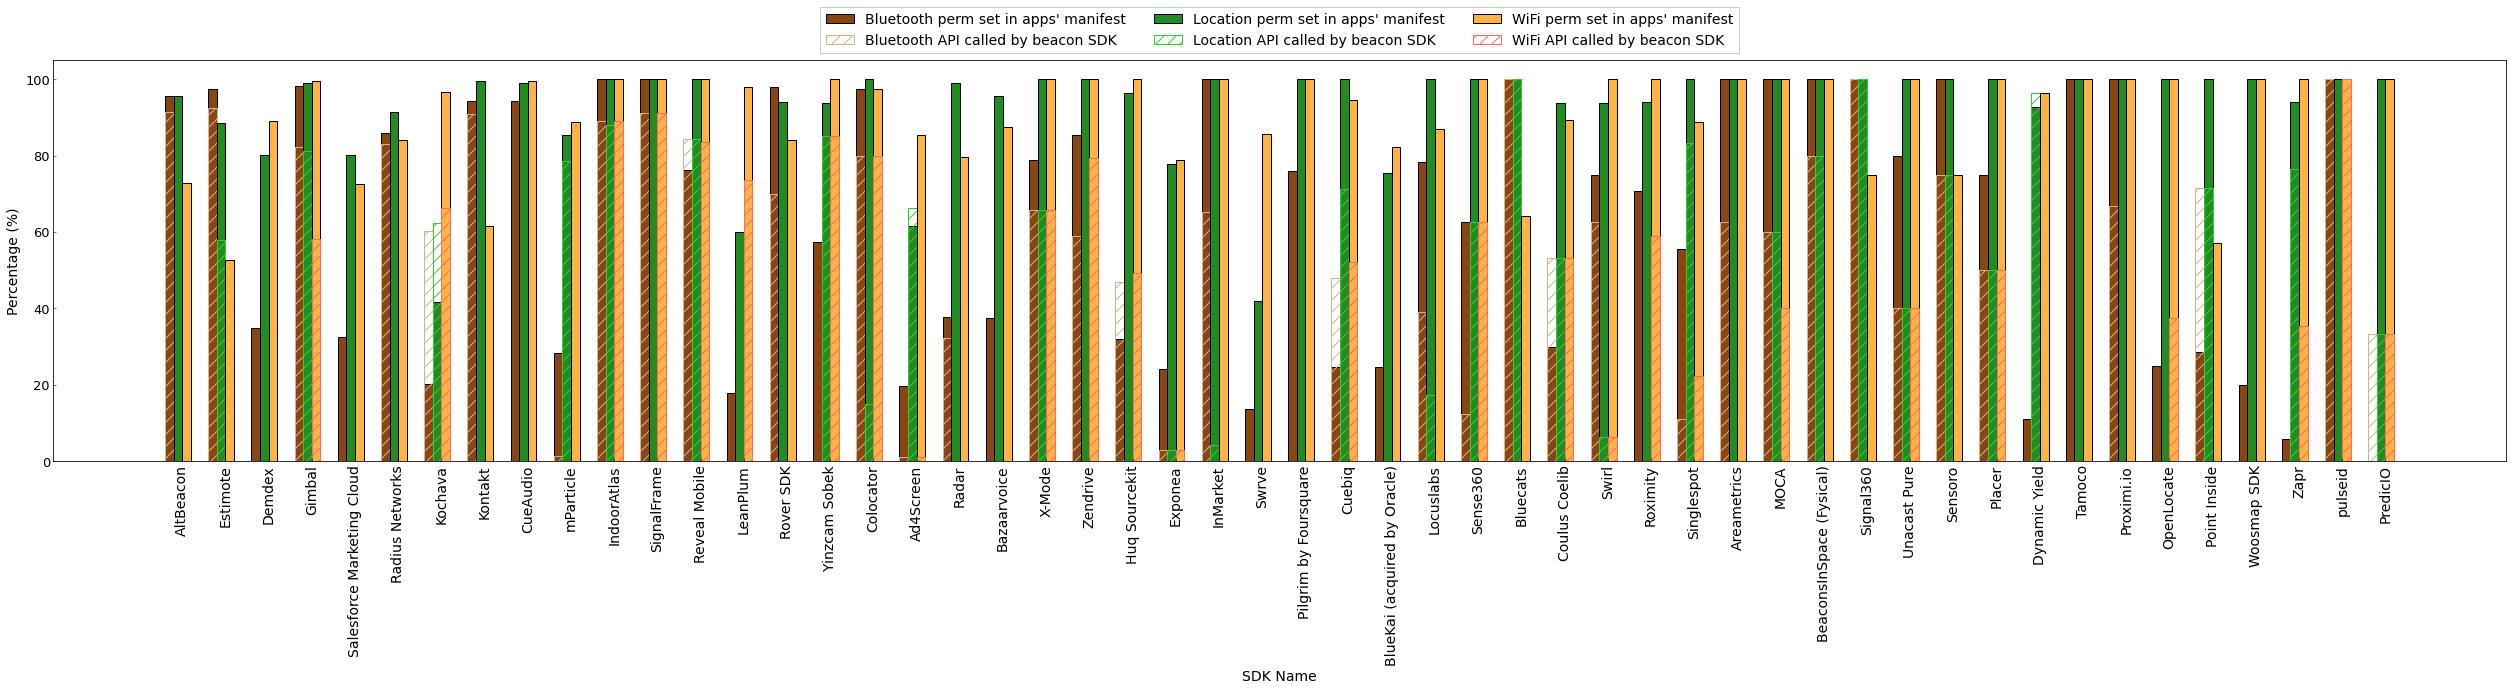

In [86]:
data = pam
data['percent_apps_with_bluetooth'] = data['apps_with_any_bluetooth'] / data['app_count'] * 100
data['percent_api_call_bluetooth'] = data['api_call_bluetooth'] / data['app_count'] * 100
data['percent_apps_with_location'] = data['apps_with_any_location'] / data['app_count'] * 100
data['percent_api_call_location'] = data['api_call_location'] / data['app_count'] * 100
data['percent_apps_with_audio'] = data['apps_with_audio'] / data['app_count'] * 100
data['percent_api_call_audio'] = data['api_call_audio'] / data['app_count'] * 100
data['percent_app_with_wifi'] = data['apps_with_any_wifi'] / data['app_count'] * 100
data['percent_api_call_wifi'] = data['api_call_wifi'] / data['app_count'] * 100

data = data.sort_values(by='apps_with_any_bluetooth', ascending=False)

# Prepare the data for plotting
r = range(len(data['tracker_name']))

# Adjust the figure size and subplot layout
fig, ax = plt.subplots(figsize=(35, 10))

# Define the bar width and positions with increased spacing
bar_width = 0.8
spacing = 3
bar_positions = [x * (1 + spacing) for x in r]

# Plot apps permissions (solid colors)
ax.bar(bar_positions, data['percent_apps_with_bluetooth'], color='#8B4513', width=bar_width, label='Bluetooth perm set in apps\' manifest')
ax.bar(bar_positions, data['percent_api_call_bluetooth'], color='none', edgecolor='#D2B48C', width=bar_width, label='Bluetooth API called by beacon SDK', hatch='//')


ax.bar([x + bar_width for x in bar_positions], data['percent_apps_with_location'], color='#228B22', width=bar_width, label='Location perm set in apps\' manifest')
ax.bar([x + bar_width for x in bar_positions], data['percent_api_call_location'], color='none', edgecolor='#32CD32', width=bar_width, label='Location API called by beacon SDK', hatch='//')

# ax.bar([x + 2 * bar_width for x in bar_positions], data['percent_apps_with_audio'], color='#4682B4', width=bar_width, label='Audio perm set in apps\' manifest')
# ax.bar([x + 2 * bar_width for x in bar_positions], data['percent_api_call_audio'], color='none', edgecolor='#87CEEB', width=bar_width, label='Audio API called by beacon SDK', hatch='//')

# ax.bar([x + 3 * bar_width for x in bar_positions], data['percent_app_with_wifi'], color='#FFB347', width=bar_width, label='WiFi perm set in apps\' manifest')
# ax.bar([x + 3 * bar_width for x in bar_positions], data['percent_api_call_wifi'], color='none', edgecolor='#FF6961', width=bar_width, label='WiFi API called by beacon SDK', hatch='//')

ax.bar([x + 2 * bar_width for x in bar_positions], data['percent_app_with_wifi'], color='#FFB347', width=bar_width, label='WiFi perm set in apps\' manifest')
ax.bar([x + 2 * bar_width for x in bar_positions], data['percent_api_call_wifi'], color='none', edgecolor='#FF6961', width=bar_width, label='WiFi API called by beacon SDK', hatch='//')

# Plot API calls (striped pattern)

# Customize plot
ax.set_xlabel('SDK Name', fontsize=14)
ax.set_ylabel('Percentage (%)', fontsize=14)
ax.set_xticks([x + 1.5 * bar_width for x in bar_positions])
ax.set_xticklabels(data['tracker_name'], rotation=90, fontsize=14)
ax.legend(loc='upper center', fontsize=14, bbox_to_anchor=(0.5, 1.15), ncol=3)
# ax.set_title('Permissions Set in Apps\' Manifest and API Calls by Beacon SDK', fontsize=14)
# ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.savefig('manifest-api-mapping.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [87]:
dd = data[['tracker_name', 'app_count', 'percent_apps_with_bluetooth', 'percent_api_call_bluetooth',	'percent_apps_with_location',
       'percent_api_call_location', 'percent_apps_with_audio', 'percent_api_call_audio', 'percent_app_with_wifi', 'percent_api_call_wifi']].round(0)

dd= dd.rename(columns={'tracker_name': 'SDK', 'percent_apps_with_bluetooth': 'percent_apps_requesting_any_Bluetooth_in_Manifest', 'percent_api_call_bluetooth': 'percent_apps_call_any__bluetooth_API'})
dd = dd.rename(columns={'percent_apps_with_location': 'percent_apps_requesting_any_Location_in_Manifest', 'percent_api_call_location': 'percent_apps_call_any_Location_API'})
dd = dd.rename(columns={'percent_apps_with_audio': 'percent_apps_requesting_any_Audio_in_Manifest', 'percent_api_call_audio': 'percent_apps_call_any_Audio_API'})
dd = dd.rename(columns={'percent_app_with_wifi': 'percent_apps_requesting_any_WiFi_in_Manifest', 'percent_api_call_wifi': 'percent_apps_call_any_WiFi_API'})

dd.sort_values(by='app_count', ascending=False).to_csv('permission_data.csv', index=False)

dd.mean()

/tmp/ipykernel_1242418/431001215.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dd.mean()


app_count                                            225.807692
percent_apps_requesting_any_Bluetooth_in_Manifest     63.480769
percent_apps_call_any__bluetooth_API                  43.288462
percent_apps_requesting_any_Location_in_Manifest      92.750000
percent_apps_call_any_Location_API                    33.903846
percent_apps_requesting_any_Audio_in_Manifest         28.846154
percent_apps_call_any_Audio_API                        5.134615
percent_apps_requesting_any_WiFi_in_Manifest          90.846154
percent_apps_call_any_WiFi_API                        27.192308
dtype: float64

In [88]:
dd = dd.sort_values(by='app_count', ascending=False)

#apply round() to the below 
dd['percent_apps_requesting_any_Bluetooth_in_Manifest'] = dd['percent_apps_requesting_any_Bluetooth_in_Manifest'].round(1)
dd['percent_apps_call_any__bluetooth_API'] = dd['percent_apps_call_any__bluetooth_API'].round(1)
dd['percent_apps_requesting_any_Location_in_Manifest'] = dd['percent_apps_requesting_any_Location_in_Manifest'].round(1)
dd['percent_apps_call_any_Location_API'] = dd['percent_apps_call_any_Location_API'].round(1)

dd['percent_apps_requesting_any_WiFi_in_Manifest'] = dd['percent_apps_requesting_any_WiFi_in_Manifest'].round(1)
dd['percent_apps_call_any_WiFi_API'] = dd['percent_apps_call_any_WiFi_API'].round(1)
dd = dd.drop(columns='percent_apps_requesting_any_Audio_in_Manifest')
dd = dd.drop(columns='percent_apps_call_any_Audio_API')
dd = dd.drop(index=0)
# dd['SDK', 'app_count', 'percent_apps_requesting_any_Bluetooth_in_Manifest',
#        'percent_apps_call_any__bluetooth_API',
#        'percent_apps_requesting_any_Location_in_Manifest',
#        'percent_apps_call_any_Location_API',
#        'percent_apps_requesting_any_WiFi_in_Manifest',
#        'percent_apps_call_any_WiFi_API'].applymap(lambda x: f"\\databarfull{{{x:.2f}}}" if isinstance(x, int) else x).to_latex('table.tex', index=True, escape=False)

In [89]:
dd.applymap(lambda x: f"\\databarfull{{{x:.2f}}}" if isinstance(x, float) else x).to_latex('table.tex', index=False, escape=False)

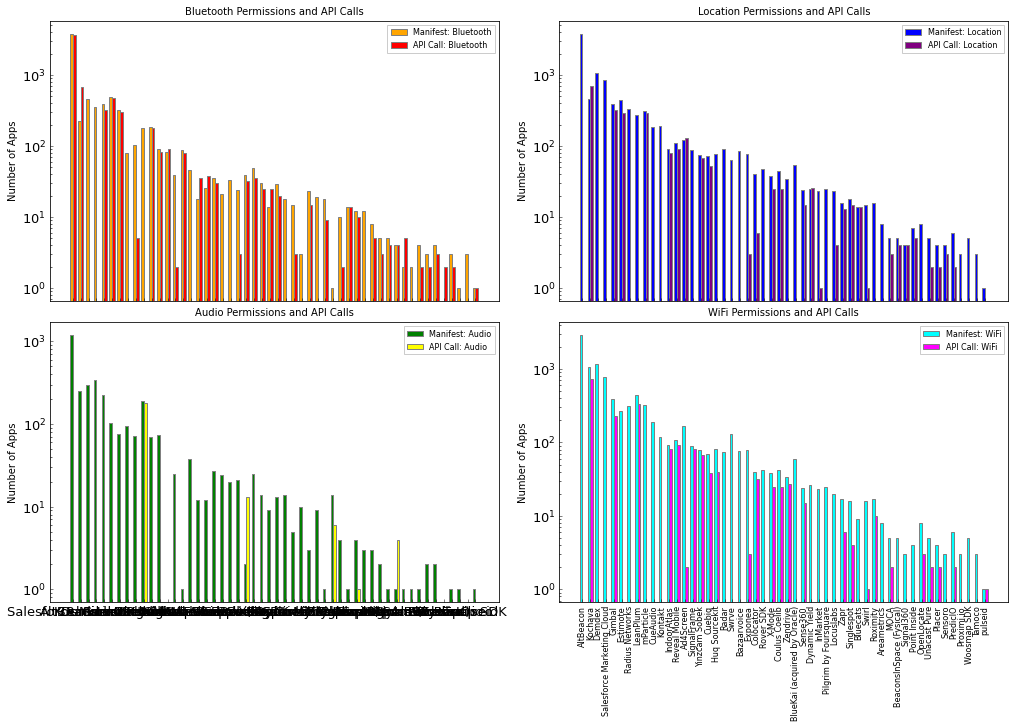

In [90]:
# Sort data by the total number of apps for better visual comparison
data['total_apps'] = (
    data['apps_with_any_bluetooth'] + data['api_call_bluetooth'] +
    data['apps_with_any_location'] + data['api_call_location'] +
    data['apps_with_audio'] + data['api_call_audio'] +
    data['apps_with_any_wifi'] + data['api_call_wifi']
)
data.sort_values(by='total_apps', ascending=False, inplace=True)
data.drop(columns=['total_apps'], inplace=True)

# Multiple Subplots with Grouped Bars (not stacked), log scale y-axis, including WiFi, and shared X-axis
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, constrained_layout=True)

# Define bar width and positions for grouped bars
bar_width = 0.35

# Positions for each group of bars
positions1 = [range(len(data['tracker_name']))]
positions2 = [[x + bar_width for x in positions1[0]]]

# Common X-axis labels and font size adjustments
common_xticks = [r + bar_width / 2 for r in range(len(data['tracker_name']))]
common_xtick_labels = data['tracker_name']
fontsize = 8

# Bluetooth
axs[0, 0].bar(positions1[0], data['apps_with_any_bluetooth'], color='orange', width=bar_width, edgecolor='grey', label='Manifest: Bluetooth')
axs[0, 0].bar(positions2[0], data['api_call_bluetooth'], color='red', width=bar_width, edgecolor='grey', label='API Call: Bluetooth')
axs[0, 0].set_title('Bluetooth Permissions and API Calls', fontsize=10)
axs[0, 0].legend(fontsize=8)
axs[0, 0].set_yscale('log')

# Location
axs[0, 1].bar(positions1[0], data['apps_with_any_location'], color='blue', width=bar_width, edgecolor='grey', label='Manifest: Location')
axs[0, 1].bar(positions2[0], data['api_call_location'], color='purple', width=bar_width, edgecolor='grey', label='API Call: Location')
axs[0, 1].set_title('Location Permissions and API Calls', fontsize=10)
axs[0, 1].legend(fontsize=8)
axs[0, 1].set_yscale('log')

# Audio
axs[1, 0].bar(positions1[0], data['apps_with_audio'], color='green', width=bar_width, edgecolor='grey', label='Manifest: Audio')
axs[1, 0].bar(positions2[0], data['api_call_audio'], color='yellow', width=bar_width, edgecolor='grey', label='API Call: Audio')
axs[1, 0].set_title('Audio Permissions and API Calls', fontsize=10)
axs[1, 0].legend(fontsize=8)
axs[1, 0].set_yscale('log')

# WiFi
axs[1, 1].bar(positions1[0], data['apps_with_any_wifi'], color='cyan', width=bar_width, edgecolor='grey', label='Manifest: WiFi')
axs[1, 1].bar(positions2[0], data['api_call_wifi'], color='magenta', width=bar_width, edgecolor='grey', label='API Call: WiFi')
axs[1, 1].set_title('WiFi Permissions and API Calls', fontsize=10)
axs[1, 1].legend(fontsize=8)
axs[1, 1].set_yscale('log')

# Common x-axis labels
plt.setp(axs, xticks=common_xticks, xticklabels=common_xtick_labels)
plt.xticks(rotation=90, fontsize=fontsize)

# Adjust y-axis labels font size
for ax in axs.flat:
    ax.set_ylabel('Number of Apps', fontsize=10)

plt.show()

In [91]:
def show_tracker_ble_permissions(conn, tracker_name):
    trackers = tracker_name
    query = """
    SELECT t.tracker_name,
           COUNT(distinct b.package_name) AS app_count,
           COUNT(distinct b.package_name) FILTER (
               WHERE perms @> '["android.permission.BLUETOOTH"]'
           ) AS apps_with_bluetooth,
           COUNT(distinct b.package_name) FILTER (
               WHERE perms @> '["android.permission.BLUETOOTH_ADMIN"]'
           ) AS apps_with_ble_admin,
           COUNT(distinct b.package_name) FILTER (
               WHERE perms @> '["android.permission.BLUETOOTH_SCAN"]'
           ) AS apps_with_ble_scan,
           COUNT(distinct b.package_name) FILTER (
                WHERE perms @> '["android.permission.BLUETOOTH_CONNECT"]'
            ) AS apps_with_ble_connect,
            COUNT(distinct b.package_name) FILTER (
                WHERE perms @> '["android.permission.BLUETOOTH_ADVERTISE"]'
            ) AS apps_with_ble_advertise,
           COUNT(distinct b.package_name) FILTER (
               WHERE perms @> '["android.permission.ACCESS_FINE_LOCATION"]' OR
                     perms @> '["android.permission.ACCESS_COARSE_LOCATION"]' OR
                     perms @> '["android.permission.ACCESS_BACKGROUND_LOCATION"]'
           ) AS apps_with_any_location
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name
    WHERE t.tracker_name IN %s
    GROUP BY t.tracker_name;
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (trackers,))
            results = cur.fetchall()
            
            # Get column names from cursor
            colnames = [desc[0] for desc in cur.description]
            df = pd.DataFrame(results, columns=colnames)
            return df
    except Exception as e:
        print(f"Error executing query: {e}")

In [103]:
def show_tracker_ble_permissions_per_version(conn, tracker_name):
    trackers = tracker_name
    query = """
    SELECT t.tracker_name,
           COUNT(distinct b.package_name) AS app_count,
           COUNT(distinct b.package_name) FILTER (
               WHERE perms @> '["android.permission.BLUETOOTH"]' OR
               perms @> '["android.permission.BLUETOOTH_ADMIN"]'
           ) AS BLE_below_android12,
           COUNT(distinct b.package_name) FILTER (
               WHERE perms @> '["android.permission.BLUETOOTH_SCAN"]' OR
               perms @> '["android.permission.BLUETOOTH_CONNECT"]' OR
                perms @> '["android.permission.BLUETOOTH_ADVERTISE"]'
           ) AS BLE_above_android12,
           COUNT(distinct b.package_name) FILTER (
               WHERE perms @> '["android.permission.ACCESS_FINE_LOCATION"]' OR
                     perms @> '["android.permission.ACCESS_COARSE_LOCATION"]' OR
                     perms @> '["android.permission.ACCESS_BACKGROUND_LOCATION"]'
           ) AS apps_with_any_location
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name
    WHERE t.tracker_name IN %s
    GROUP BY t.tracker_name;
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (trackers,))
            results = cur.fetchall()
            
            # Get column names from cursor
            colnames = [desc[0] for desc in cur.description]
            df = pd.DataFrame(results, columns=colnames)
            return df
    except Exception as e:
        print(f"Error executing query: {e}")

dp_ble = show_tracker_ble_permissions_per_version(conn, bt_beacon_sdk)
dp_ble

tracker_name  app_count  ble_below_android12  \
0                      Ad4Screen        262                   46   
1                      AltBeacon       8831                 8380   
2                    Areametrics        163                  163   
3                    Bazaarvoice         95                   34   
4       BeaconsInSpace (Fysical)         74                   74   
5                       Bluecats         19                   19   
6   BlueKai (acquired by Oracle)        106                   20   
7                      Colocator         62                   61   
8                  Coulus Coelib         58                   20   
9                       CueAudio        238                  222   
10                        Cuebiq        427                  325   
11                        Demdex       1822                  637   
12                 Dynamic Yield         30                    4   
13                      Estimote       1046                 1017   
14                       Exponea        108                   25   
15                        Gimbal        566                  556   
16                 Huq Sourcekit        146                   51   
17                   IndoorAtlas        115                  114   
18                      InMarket         28                   28   
19                       Kochava       2057                  386   
20                       Kontakt        505                  487   
21                      LeanPlum        538                   92   
22                     Locuslabs         26                   21   
23                          MOCA          5                    5   
24                     mParticle        413                  113   
25                    OpenLocate         12                    2   
26         Pilgrim by Foursquare         30                   12   
27                        Placer         18                    8   
28                  Point Inside          8                    2   
29                     Precisely          1                    0   
30                      PredicIO         47                   40   
31                    Proximi.io          6                    6   
32                       pulseid          2                    2   
33                         Radar        114                   36   
34               Radius Networks       1243                 1062   
35                 Reveal Mobile        276                  250   
36                     Rover SDK         56                   55   
37                      Roximity         25                   19   
38    Salesforce Marketing Cloud       1232                  396   
39                      Sense360         31                   15   
40                       Sensoro         12                   12   
41                     Signal360         41                   13   
42                   SignalFrame        158                  158   
43                    Singlespot         18                   10   
44                         Swirl         23                   18   
45                         Swrve        187                   33   
46                        Tamoco          3                    3   
47                         ubudu          1                    1   
48                  Unacast Pure         14                   12   
49                   Woosmap SDK          5                    1   
50                        X-Mode         58                   48   
51                 Yinzcam Sobek         86                   47   
52                          Zapr         24                    1   
53                      Zendrive         44                   37   

    ble_above_android12  apps_with_any_location  
0                    14                     162  
1                  1266                    7860  
2                     1                     163  
3                    14                      90  
4                     1      

/tmp/ipykernel_1242418/353087474.py:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(rect=[1, 1, 1, 1])


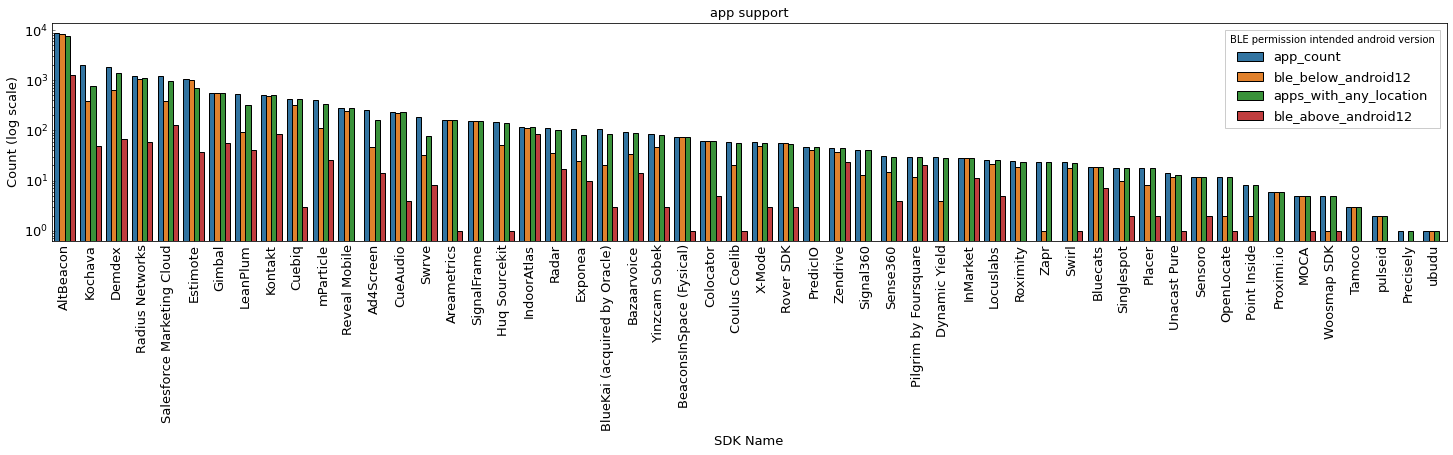

In [104]:
melted_data = pd.melt(dp_ble, id_vars='tracker_name', var_name='feature', value_name='count')
melted_data = melted_data.sort_values(by='count', ascending=False)

# single_perm_data = melted_data[melted_data['feature'].isin(['apps_with_any_bluetooth', 'apps_with_any_location', 'apps_with_audio'])]

single_perm_data = melted_data[melted_data['feature'].isin(['app_count', 'ble_below_android12', 'ble_above_android12', 'apps_with_any_location'])]

# # Subset for apps with combinations of permissions
# comb_perm_data = melted_data[melted_data['feature'].isin(['apps_with_ble_scan_and_location', 'apps_with_ble_and_audio', 'apps_with_audio_and_location', 'apps_with_ble_and_location'])]

# Plot for single permissions
plt.figure(figsize=(25, 4))
sns.barplot(x='tracker_name', y='count', hue='feature', data=single_perm_data, palette='tab10')
plt.title('app support')
plt.xlabel('SDK Name')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=90)
plt.yscale('log')
plt.legend(title='BLE permission intended android version', loc='upper right')
plt.tight_layout(rect=[1, 1, 1, 1])
# plt.savefig("single-perm-sdk-mapping.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [105]:
dp_ble = show_tracker_ble_permissions(conn, bt_beacon_sdk)
dp_ble

tracker_name  app_count  apps_with_bluetooth  \
0                      Ad4Screen        262                   46   
1                      AltBeacon       8831                 8376   
2                    Areametrics        163                  163   
3                    Bazaarvoice         95                   33   
4       BeaconsInSpace (Fysical)         74                   74   
5                       Bluecats         19                   19   
6   BlueKai (acquired by Oracle)        106                   20   
7                      Colocator         62                   61   
8                  Coulus Coelib         58                   20   
9                       CueAudio        238                  210   
10                        Cuebiq        427                  324   
11                        Demdex       1822                  637   
12                 Dynamic Yield         30                    4   
13                      Estimote       1046                 1017   
14                       Exponea        108                   25   
15                        Gimbal        566                  544   
16                 Huq Sourcekit        146                   51   
17                   IndoorAtlas        115                  114   
18                      InMarket         28                   28   
19                       Kochava       2057                  383   
20                       Kontakt        505                  487   
21                      LeanPlum        538                   92   
22                     Locuslabs         26                   21   
23                          MOCA          5                    5   
24                     mParticle        413                  112   
25                    OpenLocate         12                    2   
26         Pilgrim by Foursquare         30                   12   
27                        Placer         18                    8   
28                  Point Inside          8                    2   
29                     Precisely          1                    0   
30                      PredicIO         47                   40   
31                    Proximi.io          6                    6   
32                       pulseid          2                    2   
33                         Radar        114                   36   
34               Radius Networks       1243                 1061   
35                 Reveal Mobile        276                  250   
36                     Rover SDK         56                   55   
37                      Roximity         25                   19   
38    Salesforce Marketing Cloud       1232                  395   
39                      Sense360         31                   15   
40                       Sensoro         12                   12   
41                     Signal360         41                   13   
42                   SignalFrame        158                  158   
43                    Singlespot         18                   10   
44                         Swirl         23                   18   
45                         Swrve        187                   33   
46                        Tamoco          3                    3   
47                         ubudu          1                    1   
48                  Unacast Pure         14                   12   
49                   Woosmap SDK          5                    1   
50                        X-Mode         58                   48   
51                 Yinzcam Sobek         86                   47   
52                          Zapr         24                    1   
53                      Zendrive         44                   37   

    apps_with_ble_admin  apps_with_ble_scan  apps_with_ble_connect  \
0                    30                   6                     13   
1                  8380                1136                   1092   
2                   163                   1                      1   

/tmp/ipykernel_1242418/1365901892.py:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(rect=[1, 1, 1, 1])


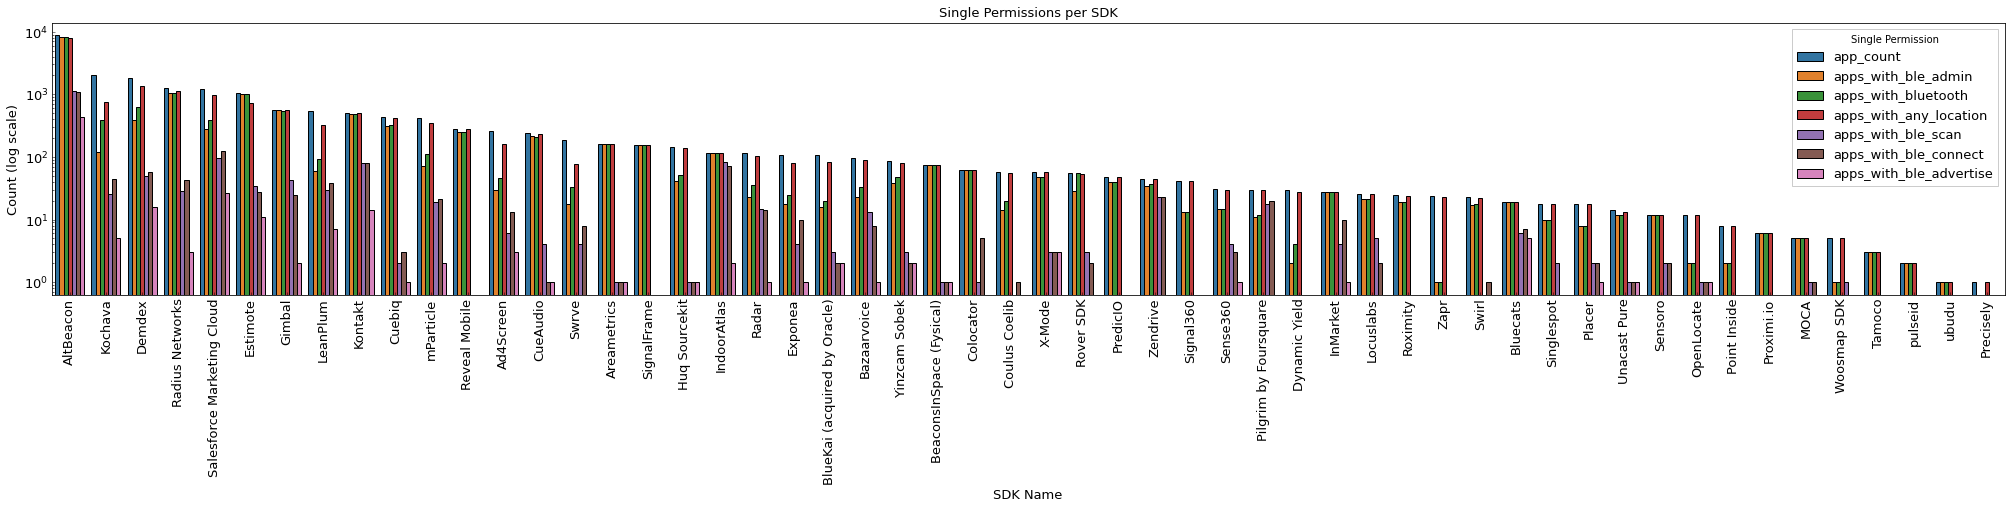

In [106]:
melted_data = pd.melt(dp_ble, id_vars='tracker_name', var_name='feature', value_name='count')
melted_data = melted_data.sort_values(by='count', ascending=False)

# single_perm_data = melted_data[melted_data['feature'].isin(['apps_with_any_bluetooth', 'apps_with_any_location', 'apps_with_audio'])]

single_perm_data = melted_data[melted_data['feature'].isin(['app_count', 'apps_with_bluetooth', 'apps_with_ble_admin', 'apps_with_ble_scan', 'apps_with_ble_connect', 'apps_with_ble_advertise', 'apps_with_any_location'])]

# # Subset for apps with combinations of permissions
# comb_perm_data = melted_data[melted_data['feature'].isin(['apps_with_ble_scan_and_location', 'apps_with_ble_and_audio', 'apps_with_audio_and_location', 'apps_with_ble_and_location'])]

# Plot for single permissions
plt.figure(figsize=(35, 5))
sns.barplot(x='tracker_name', y='count', hue='feature', data=single_perm_data, palette='tab10')
plt.title('Single Permissions per SDK')
plt.xlabel('SDK Name')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=90)
plt.yscale('log')
plt.legend(title='Single Permission', loc='upper right')
plt.tight_layout(rect=[1, 1, 1, 1])
# plt.savefig("single-perm-sdk-mapping.pdf", format="pdf", bbox_inches="tight")
plt.show()

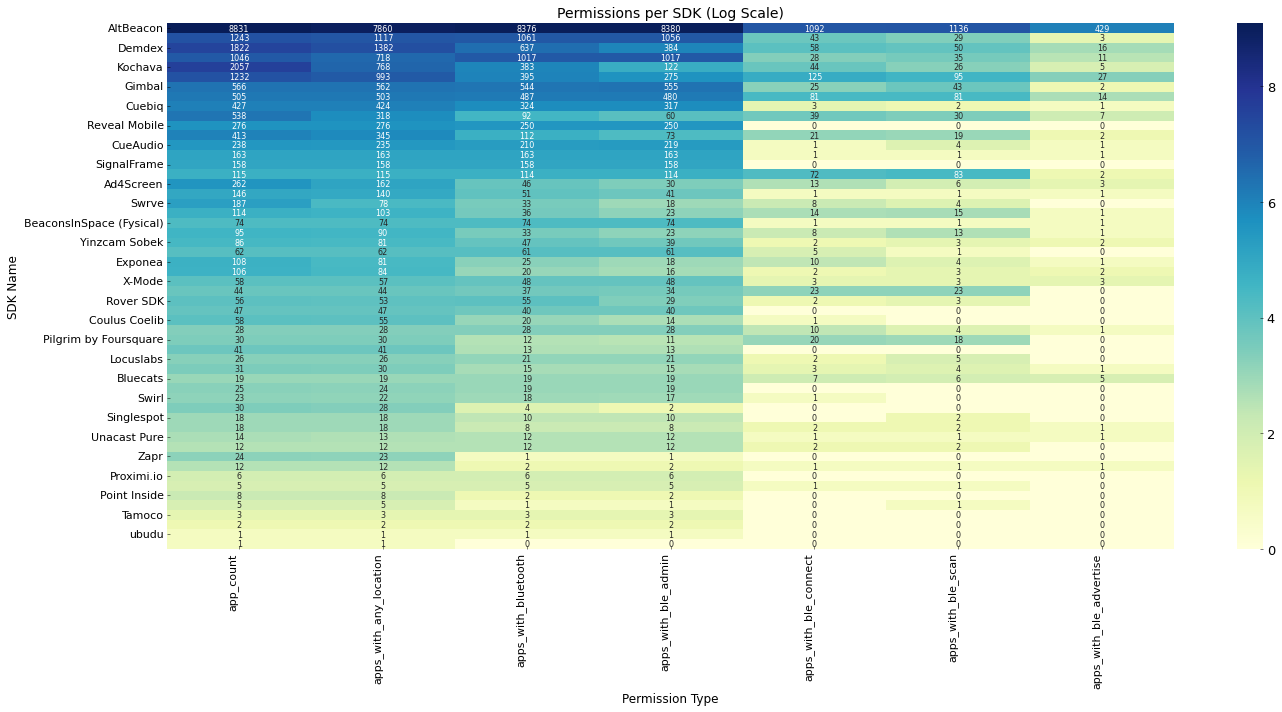

In [107]:
# Pivot the data to create a matrix suitable for a heatmap
heatmap_data = single_perm_data.pivot(index='tracker_name', columns='feature', values='count').fillna(0)

# Sort categories by total count in descending order
sorted_features = heatmap_data.sum(axis=0).sort_values(ascending=False).index
heatmap_data = heatmap_data[sorted_features]

# Sort SDKs by total count in descending order
sorted_sdks = heatmap_data.sum(axis=1).sort_values(ascending=False).index
heatmap_data = heatmap_data.loc[sorted_sdks]

# Apply log scale to the data for color mapping
heatmap_data_log_scale = np.log1p(heatmap_data)

# Plot the heatmap with actual values annotated
plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data_log_scale, cmap="YlGnBu", annot=heatmap_data, fmt="g", annot_kws={"size": 8})

# Increase the size of the labels for better readability
plt.xticks(fontsize=11, rotation=90, ha='right')  # Rotate x labels for better fit
plt.yticks(fontsize=11)

# Set the titles and labels with increased font size
plt.title('Permissions per SDK (Log Scale)', fontsize=14)
plt.xlabel('Permission Type', fontsize=12)
plt.ylabel('SDK Name', fontsize=12)

# Adjust the layout and display the plot
plt.tight_layout()  # Adjust the layout so everything fits without overlap
# plt.savefig("permissions-per-sdk-heatmap.pdf", format="pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_1242418/1405798315.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(rect=[1, 1, 1, 1])


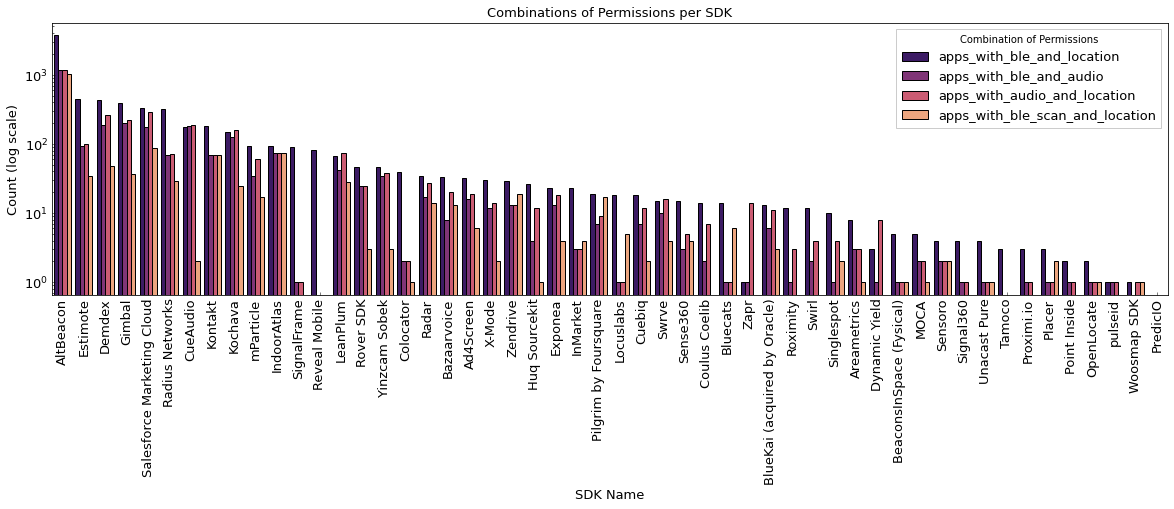

In [108]:
# Plot for combinations of permissions
plt.figure(figsize=(20, 5))
sns.barplot(x='tracker_name', y='count', hue='feature', data=comb_perm_data, palette='magma')
plt.title('Combinations of Permissions per SDK')
plt.xlabel('SDK Name')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=90)
plt.yscale('log')
plt.legend(title='Combination of Permissions', loc='upper right')
plt.tight_layout(rect=[1, 1, 1, 1])
plt.savefig("combination-perm-sdk-mapping.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [109]:
df = show_tracker_and_app_info(conn, bt_beacon_sdk)
# df[df['gplay_status'] == True].drop_duplicates(subset=['package_name']).to_csv('bt_beacon_sdk_apps.csv', index=False)
# df
# # df[
df['file_hash'] = df['file_hash'].apply(lambda x: x.upper())
df[['package_name', 'tracker_name', 'file_hash', 'version_code']].drop_duplicates(subset=['file_hash']).to_csv('bt_beacon_sdk_apps.csv', index=False)

In [110]:
def show_tracker_and_app_info_without_max_version(conn, tracker_name):
    # trackers = (tracker_name,)  # Add other tracker names if needed
    trackers = tracker_name
    query = """
SELECT 
    t.tracker_name, 
    b.package_name, 
    b.file_hash, 
    b.perms,
    b.version_code
FROM 
    trackers t
JOIN 
    beacon_app_info b 
ON 
    t.package_name = b.package_name
JOIN 
    (
        SELECT 
            package_name, 
            MAX(version_code) AS max_version_code
        FROM 
            beacon_app_info
        GROUP BY 
            package_name
    ) b_max 
ON 
    b.package_name = b_max.package_name 
AND 
    b.version_code = b_max.max_version_code
WHERE 
    t.tracker_name IN %s 
AND 
    b.gplay_status = 'true'
GROUP BY 
    t.tracker_name, 
    b.package_name, 
    b.file_hash, 
    b.perms,
    b.version_code;

    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (trackers,))
            results = cur.fetchall()
            
            # Get column names from cursor
            colnames = [desc[0] for desc in cur.description]
            df = pd.DataFrame(results, columns=colnames)
            return df
    except Exception as e:
        print(f"Error executing query: {e}")

df = show_tracker_and_app_info_without_max_version(conn, bt_beacon_sdk)
df['file_hash'] = df['file_hash'].apply(lambda x: x.upper())
df[['package_name', 'tracker_name', 'file_hash', 'version_code']].drop_duplicates(subset=['file_hash']).to_csv('bt_beacon_sdk_apps_without_max_version.csv', index=False)


In [111]:
df

tracker_name                 package_name  \
0        Ad4Screen      it.mondadori.casafacile   
1        Ad4Screen        com.zando.android.app   
2        Ad4Screen                 com.hometogo   
3        Ad4Screen          com.hrs.b2c.android   
4        Ad4Screen         com.adeo.android.app   
...            ...                          ...   
11731     Zendrive  com.ridetechnologies.driver   
11732     Zendrive            com.bungii.driver   
11733     Zendrive  com.navfree.android.OSM.ALL   
11734     Zendrive                 com.MiWay.MD   
11735     Zendrive                me.greenlight   

                                               file_hash  \
0      0015367B80DB7C89967E6F1342A1A15CBE5076C1B6F65F...   
1      00401002135648D9087DBB6326B0203F01C8DB70D8AAA0...   
2      00DC441B92D3BB2AA9B21A02D486E3D82E676A63FA497C...   
3      00E00716EC0DA676A270CC9AD9D3F8CDB3520E4D522A62...   
4      00F50607313B7190B4CF43159530FEA15B36BAC0348B31...   
...                                                  ...   
11731  B1EE3B5BCA35CCC5CB1950FDE9916A4DE2D1971308F40D...   
11732  BE47D1E9261D006A4956D05EAA835BCE847E46BFB28FE7...   
11733  C4C06646271A81449D39F880B11FAF9BB5470618E468FB...   
11734  CA36FFC9E1A23BB006913B534CB63689DD6EB18F5AF56F...   
11735  E869E3EF103632D086DD5018F89D12B1B7C7F790DFA0C4...   

                                                   perms version_code  
0      [android.permission.WAKE_LOCK, com.sonymobile....       100014  
1      [com.google.android.providers.gsf.permission.W...          268  
2      [com.hometogo.DYNAMIC_RECEIVER_NOT_EXPORTED_PE...          504  
3      [android.permission.WAKE_LOCK, android.permiss...      8280101  
4      [android.permission.USE_BIOMETRIC, android.per...        62328  
...                                                  ...          ...  
11731  [android.permission.INTERNET, android.permissi...            8  
11732  [android.permission.ACCESS_FINE_LOCATION, andr...           99  
11733  [android.permission.ACCESS_WIFI_STATE, android...       101471  
11734  [android.permission.READ_EXTERNAL_STORAGE, and...          531  
11735  [android.permission.READ_CONTACTS, android.per...         4888  

[11736 rows x 5 columns]

In [112]:
df[['package_name']].drop_duplicates(subset=['package_name']).to_csv('bt_beacon_app_list', index=False)

In [113]:
df[['package_name', 'file_hash']].drop_duplicates(subset=['file_hash'])

package_name  \
0            it.mondadori.casafacile   
1              com.zando.android.app   
2                       com.hometogo   
3                com.hrs.b2c.android   
4               com.adeo.android.app   
...                              ...   
11730  com.pickupnow.serviceprovider   
11731    com.ridetechnologies.driver   
11732              com.bungii.driver   
11734                   com.MiWay.MD   
11735                  me.greenlight   

                                               file_hash  
0      0015367B80DB7C89967E6F1342A1A15CBE5076C1B6F65F...  
1      00401002135648D9087DBB6326B0203F01C8DB70D8AAA0...  
2      00DC441B92D3BB2AA9B21A02D486E3D82E676A63FA497C...  
3      00E00716EC0DA676A270CC9AD9D3F8CDB3520E4D522A62...  
4      00F50607313B7190B4CF43159530FEA15B36BAC0348B31...  
...                                                  ...  
11730  A3903EE8B956BD1902E87D7659D710C7AF3034E5F11AF2...  
11731  B1EE3B5BCA35CCC5CB1950FDE9916A4DE2D1971308F40D...  
11732  BE47D1E9261D006A4956D05EAA835BCE847E46BFB28FE7...  
11734  CA36FFC9E1A23BB006913B534CB63689DD6EB18F5AF56F...  
11735  E869E3EF103632D086DD5018F89D12B1B7C7F790DFA0C4...  

[9971 rows x 2 columns]

/tmp/ipykernel_1242418/2251057089.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['dangerous_perms'] = filtered_df['perms'].apply(lambda x: [perm for perm in x if perm in dangerous_perms])


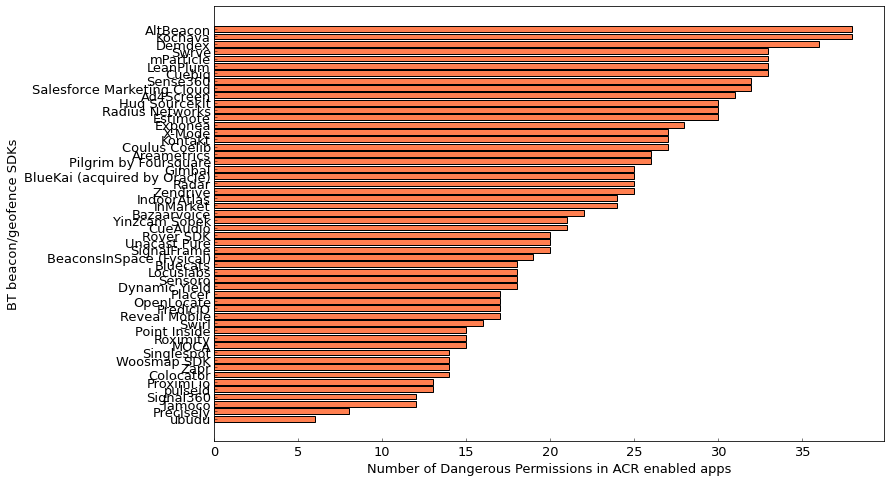

In [114]:
json_path = 'permission_mapping_api_34.json'
dangerous_permissions = load_dangerous_permissions(json_path)
permissions_df = get_permissions_per_sdk(conn)
dangerous_perms_count = 0
def plot_dangerous_permissions_per_sdk(df, dangerous_perms, sdk_list):
    # Filter the DataFrame to include only the SDKs in the sdk_list
    filtered_df = df[df['tracker_name'].isin(sdk_list)]
    
    # Identify dangerous permissions
    filtered_df['dangerous_perms'] = filtered_df['perms'].apply(lambda x: [perm for perm in x if perm in dangerous_perms])
    
    # Explode the dangerous_perms column to have one permission per row
    exploded_df = filtered_df.explode('dangerous_perms')
    
    # Drop duplicates to count only unique dangerous permissions per SDK
    exploded_df = exploded_df.drop_duplicates(subset=['tracker_name', 'dangerous_perms'])
    # Group by tracker_name and count the number of unique dangerous permissions
    dangerous_perms_count = exploded_df.groupby('tracker_name')['dangerous_perms'].count().reset_index()
    dangerous_perms_count = dangerous_perms_count.sort_values(by='dangerous_perms', ascending=False)
    
    # Create a bar plot
    plt.figure(figsize=(12, 8))
    plt.barh(dangerous_perms_count['tracker_name'], dangerous_perms_count['dangerous_perms'], color='coral')
    plt.xlabel('Number of Dangerous Permissions in ACR enabled apps')
    plt.ylabel('BT beacon/geofence SDKs')
    # plt.title('Number of Unique Dangerous Permissions per SDK')
    plt.gca().invert_yaxis()
    plt.savefig("plot_dangerous_permissions_per_sdk.pdf",bbox_inches='tight')
    plt.show()

plot_dangerous_permissions_per_sdk(permissions_df, dangerous_permissions, bt_beacon_sdk)

In [115]:
dangerous_perms_count

0

/tmp/ipykernel_1242418/1344556792.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['dangerous_perms'] = filtered_df['perms'].apply(lambda x: [perm for perm in x if perm in dangerous_perms])


                                      dangerous_perms  tracker_name
2           android.permission.ACCESS_COARSE_LOCATION            54
3             android.permission.ACCESS_FINE_LOCATION            54
13                          android.permission.CAMERA            54
38          android.permission.WRITE_EXTERNAL_STORAGE            54
27                android.permission.READ_PHONE_STATE            53
21           android.permission.READ_EXTERNAL_STORAGE            53
32                    android.permission.RECORD_AUDIO            52
20                   android.permission.READ_CONTACTS            51
16              android.permission.POST_NOTIFICATIONS            50
14                    android.permission.GET_ACCOUNTS            50
1       android.permission.ACCESS_BACKGROUND_LOCATION            49
12                      android.permission.CALL_PHONE            47
18                   android.permission.READ_CALENDAR            42
35                  android.permission.WRITE_CAL

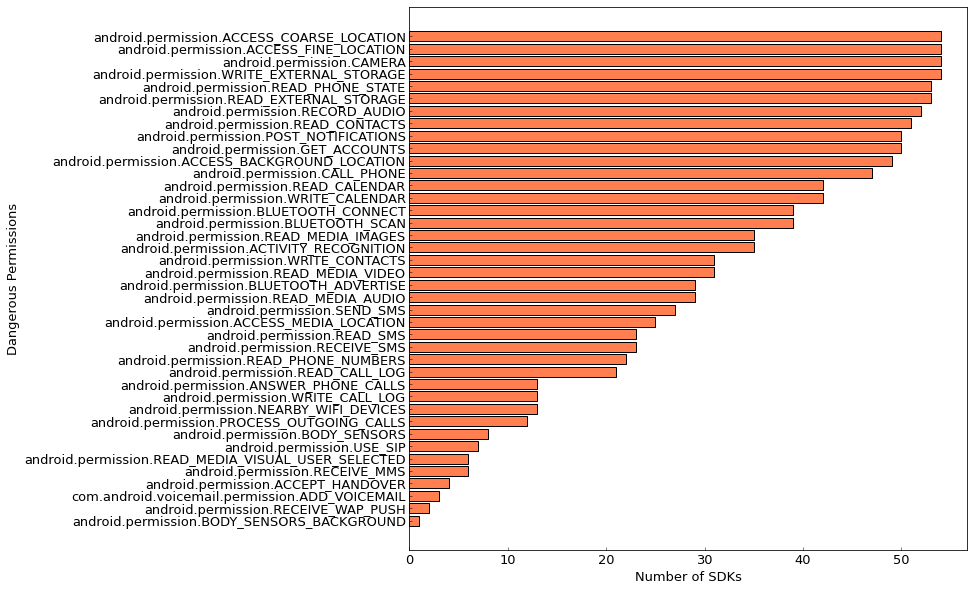

In [116]:
# Function to create a bar plot of dangerous permissions per number of SDKs for a specific list of SDKs
def plot_dangerous_permissions_per_sdk_count(df, dangerous_perms, sdk_list):
    filtered_df = df[df['tracker_name'].isin(sdk_list)]
    filtered_df['dangerous_perms'] = filtered_df['perms'].apply(lambda x: [perm for perm in x if perm in dangerous_perms])
    
    # Explode the dangerous_perms column to have one permission per row
    exploded_df = filtered_df.explode('dangerous_perms')
    
    # Group by dangerous_perms and count the number of unique tracker_name (SDKs)
    dangerous_perms_count = exploded_df.groupby('dangerous_perms')['tracker_name'].nunique().reset_index()
    dangerous_perms_count = dangerous_perms_count.sort_values(by='tracker_name', ascending=False)
    print(dangerous_perms_count)
    # Create a bar plot
    plt.figure(figsize=(10, 10))
    plt.barh(dangerous_perms_count['dangerous_perms'], dangerous_perms_count['tracker_name'], color='coral')
    plt.xlabel('Number of SDKs')
    plt.ylabel('Dangerous Permissions')
    # plt.title('Number of SDKs with Dangerous Permissions')
    plt.gca().invert_yaxis()
    plt.savefig("plot_dangerous_permissions_per_sdk_count.pdf",bbox_inches='tight')
    plt.show()

plot_dangerous_permissions_per_sdk_count(permissions_df, dangerous_permissions, bt_beacon_sdk)


In [117]:
def plot_dangerous_permissions_per_app_percentage(df, dangerous_perms, sdk_list):
    # Filter the dataframe for the specified SDKs
    filtered_df = df[df['tracker_name'].isin(sdk_list)]
    
    # Calculate the number of unique apps
    total_apps = filtered_df['package_name'].nunique()
    
    # Extract dangerous permissions from the perms column
    filtered_df['dangerous_perms'] = filtered_df['perms'].apply(lambda x: [perm for perm in x if perm in dangerous_perms])
    
    # Explode the dangerous_perms column to have one permission per row
    exploded_df = filtered_df.explode('dangerous_perms')
    
    # Group by dangerous_perms and count the number of unique package_name (apps)
    dangerous_perms_count = exploded_df.groupby('dangerous_perms')['package_name'].nunique().reset_index()
    
    # Calculate the percentage of apps requesting each dangerous permission
    dangerous_perms_count['percentage'] = (dangerous_perms_count['package_name'] / total_apps) * 100
    
    # Sort the dataframe by percentage in descending order
    dangerous_perms_count = dangerous_perms_count.sort_values(by='percentage', ascending=False)
    
    
    # Create a bar plot
    plt.figure(figsize=(10, 10))
    plt.barh(dangerous_perms_count['dangerous_perms'], dangerous_perms_count['percentage'], color='coral')
    plt.xlabel('Percentage of Apps (%)')
    plt.ylabel('Dangerous Permissions')
    plt.title('Percentage of Apps Requesting Dangerous Permissions')
    plt.gca().invert_yaxis()
    plt.savefig("plot_dangerous_permissions_per_app_percentage.pdf", bbox_inches='tight')
    plt.show()

In [118]:
df = show_bt_beacon_dataset(conn, bt_beacon_sdk, True)
filtered_df = df[df['tracker_name'].isin(bt_beacon_sdk)]

unique_columns = []
for i, col in enumerate(filtered_df.columns):
    if filtered_df.columns.tolist().count(col) > 1:
        unique_columns.append(f"{col}_{i}")
    else:
        unique_columns.append(col)
filtered_df.columns = unique_columns


# Calculate the number of unique apps
total_apps = filtered_df['package_name_2'].nunique()
filtered_df['dangerous_perms'] = filtered_df['perms'].apply(lambda x: [perm for perm in x if perm in dangerous_permissions])
exploded_df = filtered_df.explode('dangerous_perms')

# plot_dangerous_permissions_per_app_percentage(df, dangerous_permissions, bt_beacon_sdk)

In [119]:
exploded_df

id                                        file_hash_1  \
0       15726  061b682bb7cabbfda6b5b0fc77381c02c66e0cf68b4930...   
0       15726  061b682bb7cabbfda6b5b0fc77381c02c66e0cf68b4930...   
0       15726  061b682bb7cabbfda6b5b0fc77381c02c66e0cf68b4930...   
0       15726  061b682bb7cabbfda6b5b0fc77381c02c66e0cf68b4930...   
0       15726  061b682bb7cabbfda6b5b0fc77381c02c66e0cf68b4930...   
...       ...                                                ...   
9703  4529360  0bb5a8b5ef967eb956881a7cc4ca636e234efe708e16bb...   
9703  4529360  0bb5a8b5ef967eb956881a7cc4ca636e234efe708e16bb...   
9703  4529360  0bb5a8b5ef967eb956881a7cc4ca636e234efe708e16bb...   
9703  4529360  0bb5a8b5ef967eb956881a7cc4ca636e234efe708e16bb...   
9703  4529360  0bb5a8b5ef967eb956881a7cc4ca636e234efe708e16bb...   

                      package_name_2 tracker_name  \
0            com.owletcare.owletcare     LeanPlum   
0            com.owletcare.owletcare     LeanPlum   
0            com.owletcare.owletcare     LeanPlum   
0            com.owletcare.owletcare     LeanPlum   
0            com.owletcare.owletcare     LeanPlum   
...                              ...          ...   
9703  com.mytoursapp.android.app3978    AltBeacon   
9703  com.mytoursapp.android.app3978    AltBeacon   
9703  com.mytoursapp.android.app3978    AltBeacon   
9703  com.mytoursapp.android.app3978    AltBeacon   
9703  com.mytoursapp.android.app3978    AltBeacon   

                                            tracker_url  \
0     https://reports.exodus-privacy.eu.org/trackers/28   
0     https://reports.exodus-privacy.eu.org/trackers/28   
0     https://reports.exodus-privacy.eu.org/trackers/28   
0     https://reports.exodus-privacy.eu.org/trackers/28   
0     https://reports.exodus-privacy.eu.org/trackers/28   
...                                                 ...   
9703  https://reports.exodus-privacy.eu.org/trackers...   
9703  https://reports.exodus-privacy.eu.org/trackers...   
9703  https://reports.exodus-privacy.eu.org/trackers...   
9703  https://reports.exodus-privacy.eu.org/trackers...   
9703  https://reports.exodus-privacy.eu.org/trackers...   

                                            file_hash_5  \
0     061b682bb7cabbfda6b5b0fc77381c02c66e0cf68b4930...   
0     061b682bb7cabbfda6b5b0fc77381c02c66e0cf68b4930...   
0     061b682bb7cabbfda6b5b0fc77381c02c66e0cf68b4930...   
0     061b682bb7cabbfda6b5b0fc77381c02c66e0cf68b4930...   
0     061b682bb7cabbfda6b5b0fc77381c02c66e0cf68b4930...   
...                                                 ...   
9703  0bb5a8b5ef967eb956881a7cc4ca636e234efe708e16bb...   
9703  0bb5a8b5ef967eb956881a7cc4ca636e234efe708e16bb...   
9703  0bb5a8b5ef967eb956881a7cc4ca636e234efe708e16bb...   
9703  0bb5a8b5ef967eb956881a7cc4ca636e234efe708e16bb...   
9703  0bb5a8b5ef967eb956881a7cc4ca636e234efe708e16bb...   

                      package_name_6 version_code version_name  \
0            com.owletcare.owletcare        34398       2.21.1   
0            com.owletcare.owletcare        34398       2.21.1   
0            com.owletcare.owletcare        34398       2.21.1   
0            com.owletcare.owletcare        34398       2.21.1   
0            com.owletcare.owletcare        34398       2.21.1   
...                              ...          ...          ...   
9703  com.mytoursapp.android.app3978   1709000071  9.0.71-prod   
9703  com.mytoursapp.android.app3978   1709000071  9.0.71-prod   
9703  com.mytoursapp.android.app3978   1709000071  9.0.71-prod   
9703  com.mytoursapp.android.app3978   1709000071  9.0.71-prod   
9703  com.mytoursapp.android.app3978   1709000071  9.0.71-prod   

                                                  perms  ... is_leanback  \
0     [android.permission.FOREGROUND_SERVICE, com.go...  ...       False   
0     [android.permission.FOREGROUND_SERVICE, com.go...  ...       False   
0     [android.permission.FOREGROUND_SERVICE, com.go...  ...       False   
0     [android.permission.FOREGROUND_SERVI

In [120]:
dangerous_perms_count = exploded_df.groupby('dangerous_perms')['package_name_2'].nunique().reset_index()
dangerous_perms_count['percentage'] = (dangerous_perms_count['package_name_2'].astype(float) / total_apps) * 100
dangerous_perms_count = dangerous_perms_count.sort_values(by='percentage', ascending=False)
dangerous_perms_count

dangerous_perms  package_name_2  \
38          android.permission.WRITE_EXTERNAL_STORAGE            7030   
3             android.permission.ACCESS_FINE_LOCATION            6695   
2           android.permission.ACCESS_COARSE_LOCATION            6555   
13                          android.permission.CAMERA            5981   
21           android.permission.READ_EXTERNAL_STORAGE            5930   
27                android.permission.READ_PHONE_STATE            3402   
32                    android.permission.RECORD_AUDIO            2261   
14                    android.permission.GET_ACCOUNTS            2250   
16              android.permission.POST_NOTIFICATIONS            2013   
20                   android.permission.READ_CONTACTS            1803   
1       android.permission.ACCESS_BACKGROUND_LOCATION            1565   
35                  android.permission.WRITE_CALENDAR            1437   
18                   android.permission.READ_CALENDAR            1401   
12                      android.permission.CALL_PHONE            1313   
9                   android.permission.BLUETOOTH_SCAN            1248   
8                android.permission.BLUETOOTH_CONNECT            1210   
37                  android.permission.WRITE_CONTACTS             545   
23               android.permission.READ_MEDIA_IMAGES             540   
5             android.permission.ACTIVITY_RECOGNITION             468   
7              android.permission.BLUETOOTH_ADVERTISE             403   
24                android.permission.READ_MEDIA_VIDEO             259   
22                android.permission.READ_MEDIA_AUDIO             195   
26              android.permission.READ_PHONE_NUMBERS              69   
4            android.permission.ACCESS_MEDIA_LOCATION              68   
30                     android.permission.RECEIVE_SMS              39   
33                        android.permission.SEND_SMS              37   
10                    android.permission.BODY_SENSORS              33   
6               android.permission.ANSWER_PHONE_CALLS              33   
19                   android.permission.READ_CALL_LOG              31   
28                        android.permission.READ_SMS              28   
17          android.permission.PROCESS_OUTGOING_CALLS              14   
34                         android.permission.USE_SIP              11   
36                  android.permission.WRITE_CALL_LOG              10   
15             android.permission.NEARBY_WIFI_DEVICES               9   
29                     android.permission.RECEIVE_MMS               7   
11         android.permission.BODY_SENSORS_BACKGROUND               4   
0                  android.permission.ACCEPT_HANDOVER               2   
39     com.android.voicemail.permission.ADD_VOICEMAIL               2   
31                android.permission.RECEIVE_WAP_PUSH               1   
25  android.permission.READ_MEDIA_VISUAL_USER_SELE...               1   

    percentage  
38   82.473017  
3    78.542938  
2    76.900516  
13   70.166588  
21   69.568278  
27   39.910840  
32   26.525106  
14   26.396058  
16   23.615673  
20   21.152041  
1    18.359925  
35   16.858282  
18   16.435946  
12   15.403566  
9    14.641014  
8    14.195214  
37    6.393712  
23    6.335054  
5     5.490380  
7     4.727827  
24    3.038480  
22    2.287658  
26    0.809479  
4     0.797748  
30    0.457532  
33    0.434069  
10    0.387142  
6     0.387142  
19    0.363679  
28    0.328484  
17    0.164242  
34    0.129047  
36    0.117316  
15    0.105584  
29    0.082121  
11    0.046926  
0     0.023463  
39    0.023463  
31    0.011732  
25    0.011732

In [122]:
category_df = get_categories_per_sdk(conn)
category_df = category_df[category_df['category'] != '']
hide_sdks = ['chromecast']
plot_category_heatmap(category_df, bt_beacon_sdk, hide_empty_categories=True, hide_sdks=hide_sdks)


NameError: name 'get_categories_per_sdk' is not defined

In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def get_categories_per_sdk0(conn):
    query = """
    SELECT t.tracker_name, b.category
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name where b.gplay_status = true;
    """
    return execute_sql_query(conn, query)

def plot_category_heatmap0(df, sdk_list, hide_empty_categories=True, hide_sdks=None, hide_categories=None):
    # Filter the DataFrame to include only the SDKs in the sdk_list
    filtered_df = df[df['tracker_name'].isin(sdk_list)]
    
    # Remove specific SDKs if hide_sdks is provided
    if hide_sdks:
        filtered_df = filtered_df[~filtered_df['tracker_name'].isin(hide_sdks)]
    
    # Remove specific categories if hide_categories is provided
    if hide_categories:
        filtered_df = filtered_df[~filtered_df['category'].isin(hide_categories)]
    
    # Group by tracker_name and category, then count the number of occurrences
    heatmap_data = filtered_df.groupby(['tracker_name', 'category']).size().unstack(fill_value=0)
    
    # Remove empty categories if hide_empty_categories is True
    if hide_empty_categories:
        heatmap_data = heatmap_data.loc[:, (heatmap_data != 0).any(axis=0)]
    
    # Sort categories by total count in descending order
    sorted_categories = heatmap_data.sum(axis=0).sort_values(ascending=False).index
    heatmap_data = heatmap_data[sorted_categories]
    
    # Sort SDKs by total count in descending order
    sorted_sdks = heatmap_data.sum(axis=1).sort_values(ascending=False).index
    heatmap_data = heatmap_data.loc[sorted_sdks]

    heatmap_data.to_csv("heatmap_data.csv")
    
    # Apply log scale to the data
    heatmap_data_log_scale = np.log1p(heatmap_data)
    
    # Define colors for specific rows
    highlight_sdks = {
        'Huq Source': 'crimson',
        'Demdex': 'crimson',
        'Pilgrim by Foursquare': 'crimson',
        'Dynamic Yield': 'crimson',
        'Singlespot': 'crimson',
        'Salesforce Marketing Cloud': 'crimson',
        'mParticle': 'crimson',
        'Kochava': 'crimson',
        'PredicIO': 'crimson',
        'Bazaarvoice': 'crimson',
        'OpenLocate': 'crimson',
        'Exponea': 'crimson',
        'Zapr': 'plum',
        'Yinzcam Sobek': 'plum',
        'Signal360': 'plum',
        'CueAudio': 'plum'
    }
    
    row_colors = heatmap_data.index.to_series().map(highlight_sdks).fillna('darkorange')
    
    # Create a DataFrame for the row colors
    row_colors_df = pd.DataFrame({'Color': row_colors}, index=heatmap_data.index)

    # Create a new figure for the heatmap
    fig, ax_heatmap = plt.subplots(figsize=(30, 15))
    
    # Plot the heatmap
    sns.set(font_scale=1.1)
    sns.heatmap(heatmap_data_log_scale, cmap="YlGnBu", cbar_kws={'label': 'Log Scaled Count'}, ax=ax_heatmap)
    
    # Increase the size of the labels for better readability
    ax_heatmap.set_xticklabels(ax_heatmap.get_xticklabels(), fontsize=11, rotation=90, ha='right')
    ax_heatmap.set_yticklabels(ax_heatmap.get_yticklabels(), fontsize=11)
    ax_heatmap.set_xlabel('Category', fontsize=12)
    ax_heatmap.set_ylabel('SDK Name', fontsize=12)
    
    # Create an inset axis for the color bar
    ax_colorbar = inset_axes(ax_heatmap, width="1%", height="100%", loc='lower left', 
                             bbox_to_anchor=(-0.005, 0, 1, 1), bbox_transform=ax_heatmap.transAxes, borderpad=0)
    
    # Plot the color bar on the inset axis
    for idx, color in enumerate(reversed(row_colors)):
        ax_colorbar.add_patch(plt.Rectangle((0, idx), 1, 1, fill=True, color=color, edgecolor='none', lw=0))
    ax_colorbar.set_ylim(0, len(row_colors))
    ax_colorbar.axis('off')
    
    # Create a legend for the row colors
    legend_labels = {
        'Data aggregator SDK': 'crimson',
        'Audio Beacon SDK': 'plum',
        'Bluetooth Beacon SDK': 'darkorange'
    }
    
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_labels.values()]
    labels = legend_labels.keys()
    ax_heatmap.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=3, facecolor='white', framealpha=1, fontsize=15)
    ax_heatmap.yaxis.set_tick_params(labelsize=15)
    ax_heatmap.xaxis.set_tick_params(labelsize=15)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.savefig("sdk-category-mapping.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# Example usage
# conn = your_database_connection
# df = get_categories_per_sdk(conn)
# plot_category_heatmap(df, sdk_list=['SDK1', 'SDK2', 'SDK3'])


In [18]:
def show_tracker_app_counts(conn, trackers, distinct=True):
    count_clause = "COUNT(DISTINCT b.package_name)" if distinct else "COUNT(b.package_name)"
    
    query = f"""
SELECT 
    t.tracker_name, 
    {count_clause} AS app_count
FROM 
    trackers t
JOIN 
    beacon_app_info b 
ON 
    t.file_hash = b.file_hash
JOIN 
    (
        SELECT 
            file_hash, 
            MAX(version_code) AS max_version_code
        FROM 
            beacon_app_info
        GROUP BY 
            file_hash
    ) b_max 
ON 
    b.file_hash = b_max.file_hash 
AND 
    b.version_code = b_max.max_version_code
WHERE 
    t.tracker_name IN %s 
AND 
    b.gplay_status = 'true'
GROUP BY 
    t.tracker_name
ORDER BY 
    app_count DESC;

    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            results = cur.fetchall()
            
            # Convert results to a DataFrame
            df = pd.DataFrame(results, columns=["tracker_name", "app_count"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None
    


# wifi_beacon = {
#     'Ad4Screen': 'wifi beacon',
#     'Colocator': 'wifi beacon',
#     'Coulus Coelib': 'wifi beacon',
#     'Cuebiq': 'wifi beacon',
#     'Exponea': 'wifi beacon',
#     'Gimbal': 'wifi beacon',
#     'Huq Sourcekit': 'wifi beacon',
#     'IndoorAtlas': 'wifi beacon',
#     'Kochava': 'wifi beacon',
#     'LeanPlum'	: 'wifi beacon',
#     'MOCA'	: 'wifi beacon',
#     'OpenLocate': 'wifi beacon',
#     'Placer': 'wifi beacon',
#     'PredicIO': 'wifi beacon',
#     'Reveal Mobile'	: 'wifi beacon',
#     'Roximity': 'wifi beacon',
#     'Sense360': 'wifi beacon',
#     'SignalFrame': 'wifi beacon',
#     'Singlespot': 'wifi beacon',
#     'Swirl': 'wifi beacon',
#     'Unacast Pure': 'wifi beacon',
#     'X-Mode': 'wifi beacon',
#     'Yinzcam Sobek': 'wifi beacon',
#     'Zapr': 'wifi beacon',
#     'Zendrive': 'wifi beacon',
#     'pulseid': 'wifi beacon'
# }

wifi_beacon = {
    'Ad4Screen': 'bt beacon',
    'Colocator': 'bt beacon',
    'Coulus Coelib': 'bt beacon',
    'Cuebiq': 'bt beacon',
    'Exponea': 'bt beacon',
    'Gimbal': 'bt beacon',
    'Huq Sourcekit': 'bt beacon',
    'IndoorAtlas': 'bt beacon',
    'Kochava': 'bt beacon',
    'LeanPlum'	: 'bt beacon',
    'MOCA'	: 'bt beacon',
    'OpenLocate': 'bt beacon',
    'Placer': 'bt beacon',
    'Reveal Mobile'	: 'bt beacon',
    'Roximity': 'bt beacon',
    'Sense360': 'bt beacon',
    'SignalFrame': 'bt beacon',
    'Singlespot': 'bt beacon',
    'Swirl': 'bt beacon',
    'Unacast Pure': 'bt beacon',
    'X-Mode': 'bt beacon',
    'Yinzcam Sobek': 'wifi beacon',
    'Zapr': 'wifi beacon',
    'Zendrive': 'bt beacon',
    'pulseid': 'bt beacon'
}

data_aggregators = {
    'Huq Source': 'Data aggregator SDK',
    'Demdex': 'Data aggregator SDK',
    'Pilgrim by Foursquare': 'Data aggregator SDK',
    'Dynamic Yield': 'Data aggregator SDK',
    'Singlespot': 'Data aggregator SDK',
    'Salesforce Marketing Cloud': 'Data aggregator SDK',
    'mParticle': 'Data aggregator SDK',
    'Kochava': 'Data aggregator SDK',
    'PredicIO': 'Data aggregator SDK',
    'Bazaarvoice': 'Data aggregator SDK',
    'OpenLocate': 'Data aggregator SDK',
    'Exponea': 'Data aggregator SDK',
    'PredicIO': 'Data aggregator SDK',

}

df = show_tracker_app_counts(conn, bt_beacon_sdk, True)
df

# Combine the two dictionaries into one
sdk_type_mapping = {**wifi_beacon, **data_aggregators}

# Map the tracker names to their SDK types in the DataFrame
df['sdk_type'] = df['tracker_name'].map(sdk_type_mapping)
df['sdk_type'] = df['sdk_type'].fillna('bt beacon')
df['app_perc'] = df['app_count'] / 9976 * 100
# Display the updated DataFrame
df


tracker_name  app_count             sdk_type   app_perc
0                      AltBeacon       4022            bt beacon  40.316760
1                         Demdex       1328  Data aggregator SDK  13.311949
2                        Kochava       1117  Data aggregator SDK  11.196872
3     Salesforce Marketing Cloud       1080  Data aggregator SDK  10.825982
4                       Estimote        510            bt beacon   5.112269
5                       LeanPlum        456            bt beacon   4.570970
6                         Gimbal        396            bt beacon   3.969527
7                Radius Networks        369            bt beacon   3.698877
8                      mParticle        367  Data aggregator SDK   3.678829
9                      Ad4Screen        198            bt beacon   1.984763
10                       Kontakt        194            bt beacon   1.944667
11                      CueAudio        190            bt beacon   1.904571
12                         Swrve        153            bt beacon   1.533681
13                 Reveal Mobile        109            bt beacon   1.092622
14                       Exponea         99  Data aggregator SDK   0.992382
15                         Radar         93            bt beacon   0.932237
16                   IndoorAtlas         92            bt beacon   0.922213
17                   SignalFrame         89            bt beacon   0.892141
18                   Bazaarvoice         88  Data aggregator SDK   0.882117
19                 Huq Sourcekit         81            bt beacon   0.811949
20                 Yinzcam Sobek         80          wifi beacon   0.801925
21  BlueKai (acquired by Oracle)         73            bt beacon   0.731756
22                        Cuebiq         73            bt beacon   0.731756
23                     Rover SDK         50            bt beacon   0.501203
24                 Coulus Coelib         47            bt beacon   0.471131
25                     Colocator         40            bt beacon   0.400962
26                        X-Mode         38            bt beacon   0.380914
27                      Zendrive         34            bt beacon   0.340818
28                 Dynamic Yield         27  Data aggregator SDK   0.270650
29         Pilgrim by Foursquare         25  Data aggregator SDK   0.250601
30                      Sense360         24            bt beacon   0.240577
31                     Locuslabs         23            bt beacon   0.230553
32                      InMarket         23            bt beacon   0.230553
33                    Singlespot         18  Data aggregator SDK   0.180433
34                      Roximity         17            bt beacon   0.170409
35                          Zapr         17          wifi beacon   0.170409
36                         Swirl         16            bt beacon   0.160385
37                      Bluecats         14            bt beacon   0.140337
38                   Areametrics          8            bt beacon   0.080192
39                    OpenLocate          8  Data aggregator SDK   0.080192
40                  Point Inside          7            bt beacon   0.070168
41                      PredicIO          6  Data aggregator SDK   0.060144
42                          MOCA          5            bt beacon   0.050120
43      BeaconsInSpace (Fysical)          5            bt beacon   0.050120
44                  Unacast Pure          5            bt beacon   0.050120
45                   Woosmap SDK          5            bt beacon   0.050120
46                       Sensoro          4            bt beacon   0.040096
47                     Signal360          4            bt beacon   0.040096
48                        Placer          4            bt beacon   0.040096
49                    Proximi.io          3            bt beacon   0.030072
50                        Tamoco          3            bt beacon   0.030072
51                       pulseid          1            bt beacon   0

In [19]:
df[df['sdk_type'] == 'bt beacon'].nunique()

tracker_name    39
app_count       31
sdk_type         1
app_perc        31
dtype: int64

In [20]:
wifi_beacon_count = len(df[df['sdk_type'] == 'wifi beacon'].tracker_name.to_list())
agg_sdk_count = len(df[df['sdk_type'] == 'Data aggregator SDK'].tracker_name.to_list())
bt_beacon_count = len(df[df['sdk_type'] == 'bt beacon'].tracker_name.to_list())

wifi_beacon_count, agg_sdk_count, bt_beacon_count

(2, 11, 39)

In [33]:
wifi_beacon = df[df['sdk_type'] == 'wifi beacon'].tracker_name.to_list()
agg_sdk = df[df['sdk_type'] == 'Data aggregator SDK'].tracker_name.to_list()
bt_sdk = df[df['sdk_type'] == 'bt beacon'].tracker_name.to_list()

In [34]:
def show_total_app_count(conn, trackers, distinct=True):
    count_clause = "COUNT(DISTINCT b.package_name)" if distinct else "COUNT(b.package_name)"
    
    query = f"""
    SELECT {count_clause} as total_app_count
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name
    WHERE t.tracker_name IN %s and b.gplay_status = true;
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            result = cur.fetchone()
            
            # Convert result to a DataFrame
            df = pd.DataFrame([result], columns=["total_app_count"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None
    
# print("wifi beacon sdk count {}".format(show_total_app_count(conn, wifi_beacon)))
# print("data aggregator sdk count {}".format(show_total_app_count(conn, agg_sdk)))
print("bt beacon sdk count {}".format(show_total_app_count(conn, bt_sdk)))

bt beacon sdk count    total_app_count
0             6682


In [132]:
6682 / 9976 

0.6698075380914194

NameError: name 'inset_axes' is not defined

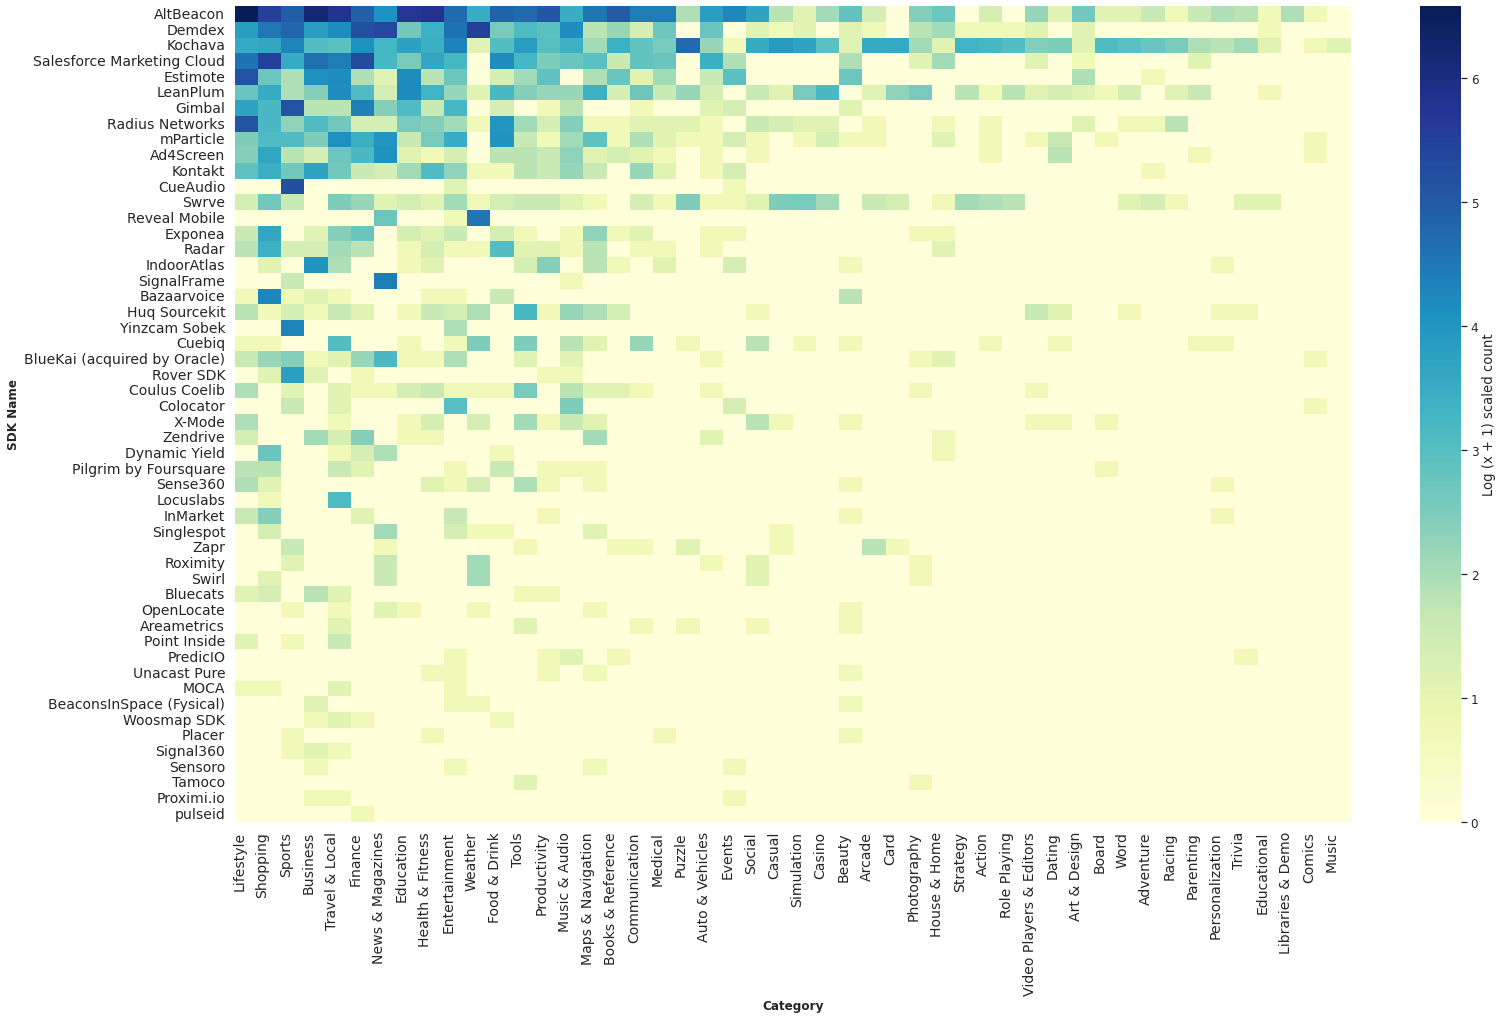

In [34]:
def get_raw_data(conn, trackers):
    query = """
    SELECT t.tracker_name, b.package_name, b.category
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name 
    WHERE b.gplay_status = true AND t.tracker_name IN %s;
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            results = cur.fetchall()
            df = pd.DataFrame(results, columns=["tracker_name", "package_name", "category"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

# Fetch raw data
raw_data_df = get_raw_data(conn, bt_beacon_sdk)

unique_app_category_df = raw_data_df.drop_duplicates(subset=['tracker_name', 'package_name', 'category'])
unique_app_category_df = unique_app_category_df[unique_app_category_df['category'] != '']
# group_categories = ['Music', 'Comics', 'Trivia', 'Educational', 'Libraries & Demo', 'Personalization', 'Parenting', 'Racing', 'Photography',
#                     'Auto & Vehicles', 'Social', 'Casual', 'Arcade', 'Card', 'Beauty', 'House & Home', 'Dating', 'Action', 'Strategy', 
#                     'Board', 'Word', 'Adventure', 'Video Players & Editors', 'Art & Design', 'Role Playing', 'Casino', 'Simulation']

group_categories = []
unique_app_category_df['category'] = unique_app_category_df['category'].apply(lambda x: 'Others' if x in group_categories else x)
# Aggregate the data by tracker and category

heatmap_data = unique_app_category_df.groupby(['tracker_name', 'category']).size().unstack(fill_value=0)
# Sort categories and trackers
heatmap_data = heatmap_data.loc[:, (heatmap_data != 0).any(axis=0)]
sorted_categories = heatmap_data.sum(axis=0).sort_values(ascending=False).index
sorted_sdks = heatmap_data.sum(axis=1).sort_values(ascending=False).index
heatmap_data = heatmap_data.loc[sorted_sdks, sorted_categories]
# heatmap_data.to_csv("heatmap_data.csv")

# Apply log scale
heatmap_data_log_scale = np.log1p(heatmap_data)

# Define colors for specific rows
highlight_sdks = {
    'Huq Source': 'crimson',
    'Demdex': 'crimson',
    'Pilgrim by Foursquare': 'crimson',
    'Dynamic Yield': 'crimson',
    'Singlespot': 'crimson',
    'Salesforce Marketing Cloud': 'crimson',
    'mParticle': 'crimson',
    'Kochava': 'crimson',
    'PredicIO': 'crimson',
    'Bazaarvoice': 'crimson',
    'OpenLocate': 'crimson',
    'Exponea': 'crimson',
    'Zapr': 'plum',
    'Yinzcam Sobek': 'plum',
    'Signal360': 'plum',
    'CueAudio': 'plum'
}

row_colors = heatmap_data.index.to_series().map(highlight_sdks).fillna('darkorange')

# Plot the heatmap
fig, ax_heatmap = plt.subplots(figsize=(25, 15))
sns.set(font_scale=1.1)
sns.heatmap(heatmap_data_log_scale, cmap="YlGnBu", cbar_kws={'label': 'Log (x + 1) scaled count'}, ax=ax_heatmap)

# Enhance readability of labels
ax_heatmap.set_xticklabels(ax_heatmap.get_xticklabels(), fontsize=14, rotation=90, ha='right')
ax_heatmap.set_yticklabels(ax_heatmap.get_yticklabels(), fontsize=14)
ax_heatmap.set_xlabel('Category', fontsize=12, fontweight='bold')
ax_heatmap.set_ylabel('SDK Name', fontsize=12, fontweight='bold')

# Create an inset axis for the color bar
ax_colorbar = inset_axes(ax_heatmap, width="1%", height="100%", loc='lower left', 
                         bbox_to_anchor=(-0.005, 0, 1, 1), bbox_transform=ax_heatmap.transAxes, borderpad=0)

# Plot the color bar
for idx, color in enumerate(reversed(row_colors)):
    ax_colorbar.add_patch(plt.Rectangle((0, idx), 1, 1, fill=True, color=color, edgecolor='none', lw=0))
ax_colorbar.set_ylim(0, len(row_colors))
ax_colorbar.axis('off')

# Create a legend
legend_labels = {
    'Data aggregator SDK': 'crimson',
    'Audio Beacon SDK': 'plum',
    'Bluetooth Beacon SDK': 'darkorange'
}
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_labels.values()]
labels = legend_labels.keys()
ax_heatmap.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, facecolor='white', framealpha=1, fontsize=15)
plt.grid(True)
# Adjust layout and save plot
plt.tight_layout()
# plt.savefig("sdk-category-mapping.pdf", format="pdf", bbox_inches="tight")
plt.show()




In [22]:
len(heatmap_data.columns) - 1


47

In [35]:
heatmap_data.sum(axis=0).reset_index()

category     0
0                 Lifestyle  1385
1                  Shopping   999
2                    Sports   935
3                  Business   903
4            Travel & Local   847
5                   Finance   795
6          News & Magazines   600
7                 Education   562
8          Health & Fitness   537
9             Entertainment   473
10                  Weather   420
11             Food & Drink   405
12                    Tools   322
13             Productivity   272
14            Music & Audio   229
15        Maps & Navigation   229
16        Books & Reference   221
17            Communication   171
18                  Medical   148
19                   Puzzle   146
20          Auto & Vehicles   118
21                   Events   114
22                   Social   103
23                   Casual    73
24               Simulation    71
25                   Casino    60
26                   Beauty    58
27                   Arcade    51
28                     Card    48
29              Photography    42
30             House & Home    41
31                 Strategy    40
32                   Action    39
33             Role Playing    31
34  Video Players & Editors    31
35                   Dating    29
36             Art & Design    28
37                    Board    27
38                     Word    27
39                Adventure    25
40                   Racing    21
41                Parenting    18
42          Personalization    16
43                   Trivia    16
44              Educational     7
45         Libraries & Demo     6
46                   Comics     6
47                    Music     2

In [36]:
heatmap_data

heatmap_data
total_app_counts = raw_data_df.groupby('tracker_name')['package_name'].nunique()
total_app_counts.name = 'Total Apps'
# add total_app_counts to heatmap data as a new column
heatmap_data = heatmap_data.join(total_app_counts)

In [25]:
wifi_app_count = 1706
da_app_count = 3882
bt_app_count = 5383

gg = heatmap_data.sum(axis=0).reset_index()
gg[0] = gg[0] / 9976 * 100
gg

index           0
0                 Lifestyle   13.883320
1                  Shopping   10.014034
2                    Sports    9.372494
3                  Business    9.051724
4            Travel & Local    8.490377
5                   Finance    7.969126
6          News & Magazines    6.014435
7                 Education    5.633520
8          Health & Fitness    5.382919
9             Entertainment    4.741379
10                  Weather    4.210104
11             Food & Drink    4.059743
12                    Tools    3.227747
13             Productivity    2.726544
14            Music & Audio    2.295509
15        Maps & Navigation    2.295509
16        Books & Reference    2.215317
17            Communication    1.714114
18                  Medical    1.483561
19                   Puzzle    1.463512
20          Auto & Vehicles    1.182839
21                   Events    1.142743
22                   Social    1.032478
23                   Casual    0.731756
24               Simulation    0.711708
25                   Casino    0.601443
26                   Beauty    0.581395
27                   Arcade    0.511227
28                     Card    0.481155
29              Photography    0.421010
30             House & Home    0.410986
31                 Strategy    0.400962
32                   Action    0.390938
33             Role Playing    0.310746
34  Video Players & Editors    0.310746
35                   Dating    0.290698
36             Art & Design    0.280674
37                    Board    0.270650
38                     Word    0.270650
39                Adventure    0.250601
40                   Racing    0.210505
41                Parenting    0.180433
42          Personalization    0.160385
43                   Trivia    0.160385
44              Educational    0.070168
45         Libraries & Demo    0.060144
46                   Comics    0.060144
47                    Music    0.020048
48               Total Apps  117.702486

In [37]:
heatmap_data_percentage = heatmap_data.div(heatmap_data['Total Apps'], axis=0) * 100
total_app_counts = raw_data_df.groupby('tracker_name')['package_name'].nunique()
total_app_counts.name = 'Total Apps count'
heatmap_data_percentage = heatmap_data_percentage.join(total_app_counts)
heatmap_data_percentage = heatmap_data_percentage.round().sort_values(by='Total Apps count', ascending=False)
heatmap_data_percentage

Lifestyle  Shopping  Sports  Business  \
tracker_name                                                          
AltBeacon                          18.0       6.0     3.0      12.0   
Demdex                              3.0       7.0     9.0       4.0   
Kochava                             3.0       3.0     7.0       2.0   
Salesforce Marketing Cloud          9.0      23.0     3.0      10.0   
Estimote                           34.0       3.0     1.0      12.0   
LeanPlum                            3.0       7.0     1.0       2.0   
Gimbal                             10.0       6.0    42.0       1.0   
Radius Networks                    44.0       6.0     2.0       6.0   
mParticle                           3.0       6.0     6.0       3.0   
Ad4Screen                           5.0      19.0     3.0       2.0   
Kontakt                             9.0      15.0     7.0      21.0   
CueAudio                            0.0       0.0    98.0       0.0   
Swrve                               2.0       8.0     3.0       0.0   
Reveal Mobile                       0.0       0.0     0.0       0.0   
Exponea                             4.0      38.0     0.0       2.0   
Radar                               5.0      31.0     3.0       3.0   
IndoorAtlas                         0.0       2.0     0.0      60.0   
SignalFrame                         0.0       0.0     4.0       0.0   
Bazaarvoice                         1.0      82.0     1.0       2.0   
Huq Sourcekit                       6.0       1.0     4.0       1.0   
Yinzcam Sobek                       0.0       0.0    92.0       0.0   
Cuebiq                              1.0       1.0     0.0       0.0   
BlueKai (acquired by Oracle)        5.0      11.0    14.0       1.0   
Rover SDK                           0.0       4.0    86.0       4.0   
Coulus Coelib                      13.0       0.0     4.0       0.0   
Colocator                           0.0       0.0    10.0       0.0   
X-Mode                             16.0       0.0     0.0       0.0   
Zendrive                            9.0       0.0     0.0      21.0   
Dynamic Yield                       0.0      56.0     0.0       0.0   
Pilgrim by Foursquare              20.0      20.0     0.0       0.0   
Sense360                           25.0       8.0     0.0       0.0   
Locuslabs                           0.0       4.0     0.0       0.0   
InMarket                           17.0      43.0     0.0       0.0   
Singlespot                          0.0      17.0     0.0       0.0   
Zapr                                0.0       0.0    24.0       0.0   
Roximity                            0.0       0.0    12.0       0.0   
Swirl                               0.0      12.0     0.0       0.0   
Bluecats                           14.0      21.0     0.0      36.0   
Areametrics                         0.0       0.0     0.0       0.0   
OpenLocate                          0.0       0.0    12.0       0.0   
Point Inside                       29.0       0.0    14.0       0.0   
PredicIO                            0.0       0.0     0.0       0.0   
Unacast Pure                        0.0       0.0     0.0       0.0   
MOCA                               20.0      20.0     0.0       0.0   
BeaconsInSpace (Fysical)            0.0       0.0     0.0      40.0   
Woosmap SDK                         0.0       0.0     0.0      20.0   
Placer                              0.0       0.0    25.0       0.0   
Signal360                           0.0       0.0    25.0      50.0   
Sensoro                             0.0       0.0     0.0      25.0   
Tamoco                              0.0       0.0     0.0       0.0   
Proximi.io                          0.0       0.0     0.0      33.0   
pulseid                             0.0       0.0     0.0       0.0   

                              Travel & Local  Finance  News & Magazines  \
tracker_name                                                              
AltBeacon                                8.0 

In [55]:
# Check if 'tracker_name' is in the columns or already the index
if 'tracker_name' not in heatmap_data_percentage.columns:
    if 'tracker_name' not in heatmap_data_percentage.index.names:
        # If 'tracker_name' is neither in the columns nor the index, raise an error or set it differently
        raise Exception("Tracker name is neither a column nor an index. Please check your DataFrame.")
else:
    # Set 'tracker_name' as the index if it is not already
    heatmap_data_percentage.set_index('tracker_name', inplace=True)

# Convert the percentage values to integers and sort the DataFrame
heatmap_data_percentage = heatmap_data_percentage.round().astype(int).sort_values(by='Total Apps count', ascending=False)

# Select top rows based on 'Total Apps count'
top_10_rows = heatmap_data_percentage.nlargest(15, 'Total Apps count')

# Determine the top 10 columns based on summed values, before formatting
top_10_columns = (top_10_rows.drop(columns=['Total Apps count'])
                                  .sum()
                                  .nlargest(11)
                                  .index)

# Filtering to get the top columns, including 'Total Apps count'
heatmap_top_10 = top_10_rows[['Total Apps count'] + list(top_10_columns)]

# Apply formatting with raw values
for col in heatmap_top_10.columns[1:]:  # Exclude 'Total Apps count' for formatting
    raw_values = heatmap_data[col]  # Assuming raw_data matches the structure and has the same index
    heatmap_top_10[col] = heatmap_top_10[col].astype(str) + "\%" + " (" + raw_values.astype(str) + ")"

# Calculate sums for each column
column_sums = heatmap_data.sum(axis=0)

# Sort the columns based on the sums and prepare for final display
column_order = column_sums.sort_values(ascending=False).index.tolist()
column_order = [col for col in column_order if col in heatmap_top_10.columns]

# Reorder the columns in heatmap_top_10 to start with 'Total Apps count'
heatmap_top_10 = heatmap_top_10[['Total Apps count'] + column_order]
# heatmap_top_10 = heatmap_top_10.drop(columns=['Total Apps'])
# Format the sums row for inclusion
formatted_sums = (column_sums.div(total_apps) * 100).round().astype(int).astype(str) + "%" + " (" + column_sums.astype(str) + ")"
formatted_sums = formatted_sums.reindex(['Total Apps count'] + column_order)  # Ensure matching order

# Append the sums row
sums_row = pd.DataFrame([formatted_sums], columns=heatmap_top_10.columns)
sums_row.index = ['Total']
heatmap_top_10 = pd.concat([heatmap_top_10, sums_row])

# Convert to LaTeX
latex_table = heatmap_top_10.to_latex(
    index=True,  # Make sure the index (SDK names) is included
    bold_rows=True,
    column_format='l' + 'r' * (len(heatmap_top_10.columns) - 1),
    longtable=True,
    escape=False  # Ensure that characters like '%' are correctly shown
)

with open('category_table.tex', 'w') as f:
    f.write(latex_table)

print(latex_table)

\begin{longtable}{lrrrrrrrrrrr}
\toprule
{} &  Total Apps count &    Total Apps &   Lifestyle &    Shopping &      Sports &    Business & Travel & Local &     Finance & News & Magazines &  Education & Entertainment &     Weather \\
\midrule
\endfirsthead

\toprule
{} &  Total Apps count &    Total Apps &   Lifestyle &    Shopping &      Sports &    Business & Travel & Local &     Finance & News & Magazines &  Education & Entertainment &     Weather \\
\midrule
\endhead
\midrule
\multicolumn{13}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
\textbf{AltBeacon                 } &            4024.0 &  100\% (4024) &  18\% (721) &   6\% (240) &   3\% (137) &  12\% (498) &      8\% (338) &   3\% (133) &         1\% (59) &  8\% (302) &     3\% (114) &    1\% (32) \\
\textbf{Demdex                    } &            1328.0 &  100\% (1328) &    3\% (45) &    7\% (89) &   9\% (120) &    4\% (47) &       5\% (65) &  13\% (179) &       16\% (212) &   1\% (13) &      7\

/tmp/ipykernel_1275013/1508375475.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_top_10[col] = heatmap_top_10[col].astype(str) + "\%" + " (" + raw_values.astype(str) + ")"


In [52]:
import pandas as pd

# Assuming you have a DataFrame named heatmap_data and raw_data_df defined appropriately
# Example setup (ensure your data frames are set up correctly with similar structures)

# Define total_apps if not defined
total_apps = heatmap_data['Total Apps'].sum()

# Check if 'tracker_name' is in the columns or already the index
if 'tracker_name' not in heatmap_data_percentage.columns and 'tracker_name' not in heatmap_data_percentage.index.names:
    raise Exception("Tracker name is neither a column nor an index. Please check your DataFrame.")
elif 'tracker_name' in heatmap_data_percentage.columns:
    heatmap_data_percentage.set_index('tracker_name', inplace=True)

# Convert the percentage values to integers and sort the DataFrame
heatmap_data_percentage = heatmap_data_percentage.round().astype(int).sort_values(by='Total Apps count', ascending=False)

# Select top rows based on 'Total Apps count'
top_10_rows = heatmap_data_percentage.nlargest(15, 'Total Apps count')

# Determine the top 10 columns based on summed values, before formatting
top_10_columns = (top_10_rows.drop(columns=['Total Apps count'])
                                  .sum()
                                  .nlargest(11)
                                  .index)

# Filtering to get the top columns, including 'Total Apps count'
heatmap_top_10 = top_10_rows[['Total Apps count'] + list(top_10_columns)]

# Use .loc to avoid SettingWithCopyWarning
for col in top_10_columns:  # Exclude 'Total Apps count' for formatting
    raw_values = heatmap_data[col]  # Ensure raw_data matches the structure and has the same index
    heatmap_top_10.loc[:, col] = heatmap_top_10[col].astype(str) + "%" + " (" + raw_values.astype(str) + ")"

# Calculate sums for each column
column_sums = heatmap_data.sum(axis=0)

# Sort the columns based on the sums and prepare for final display
column_order = column_sums.sort_values(ascending=False).index.tolist()
column_order = [col for col in column_order if col in heatmap_top_10.columns]

# Reorder the columns in heatmap_top_10 to start with 'Total Apps count'
heatmap_top_10 = heatmap_top_10[['Total Apps count'] + column_order]

# Format the sums row for inclusion
formatted_sums = (column_sums.div(total_apps) * 100).round().astype(int).astype(str) + "%" + " (" + column_sums.astype(str) + ")"
formatted_sums = formatted_sums.reindex(['Total Apps count'] + column_order)  # Ensure matching order

# Append the sums row
sums_row = pd.DataFrame([formatted_sums], columns=heatmap_top_10.columns)
sums_row.index = ['Total']
heatmap_top_10 = pd.concat([heatmap_top_10, sums_row])

for col in heatmap_top_10.columns[1:]:  # Assuming the first column is the SDK names
    heatmap_top_10[col] = heatmap_top_10[col].str.replace('%', r'\%')

# Now generate the LaTeX code
latex_table = heatmap_top_10.to_latex(
    index=True,  # Keep the index if it contains meaningful data like SDK names
    bold_rows=True,  # Make headers bold
    column_format='l' + 'r' * (len(heatmap_top_10.columns) - 1),  # Adjust column format accordingly
    longtable=True,  # Use longtable environment for large tables
)
heatmap_top_10

print(latex_table)
with open('category_table.tex', 'w') as f:
    f.write(latex_table)


\begin{longtable}{lrrrrrrrrrrr}
\toprule
{} &  Total Apps count &     Total Apps &    Lifestyle &    Shopping &      Sports &    Business & Travel \& Local &     Finance & News \& Magazines &  Education & Entertainment &     Weather \\
\midrule
\endfirsthead

\toprule
{} &  Total Apps count &     Total Apps &    Lifestyle &    Shopping &      Sports &    Business & Travel \& Local &     Finance & News \& Magazines &  Education & Entertainment &     Weather \\
\midrule
\endhead
\midrule
\multicolumn{13}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
\textbf{AltBeacon                 } &            4024.0 &   100\textbackslash \% (4024) &   18\textbackslash \% (721) &   6\textbackslash \% (240) &   3\textbackslash \% (137) &  12\textbackslash \% (498) &      8\textbackslash \% (338) &   3\textbackslash \% (133) &         1\textbackslash \% (59) &  8\textbackslash \% (302) &     3\textbackslash \% (114) &    1\textbackslash \% (32) \\
\textbf{Demdex           

In [53]:
# Assuming heatmap_data and total_app_counts are correctly defined and numeric
heatmap_data_percentage = heatmap_data.div(heatmap_data['Total Apps'], axis=0) * 100
total_app_counts = raw_data_df.groupby('tracker_name')['package_name'].nunique()
total_app_counts.name = 'Total Apps count'

# Join total app counts and convert 'Total Apps count' to int
heatmap_data_percentage = heatmap_data_percentage.join(total_app_counts)
heatmap_data_percentage['Total Apps count'] = heatmap_data_percentage['Total Apps count'].astype(int)

# Convert the percentage values to integers and sort the DataFrame
heatmap_data_percentage = heatmap_data_percentage.round().astype(int).sort_values(by='Total Apps count', ascending=False)

# Select top rows based on 'Total Apps count'
top_10_rows = heatmap_data_percentage.nlargest(15, 'Total Apps count')

# Determine the top columns based on summed values, before formatting
top_10_columns = (top_10_rows.drop(columns=['Total Apps count'])
                                  .sum()
                                  .nlargest(10)
                                  .index)

# Filtering to get the top columns, including 'Total Apps count'
heatmap_top_10 = top_10_rows[['Total Apps count'] + list(top_10_columns)]

# Apply formatting with raw values
for col in heatmap_top_10.columns[1:]:  # Exclude 'Total Apps count' for formatting
    raw_values = heatmap_data[col].astype(int)  # Assuming raw data needs to match the processed data
    heatmap_top_10[col] = heatmap_top_10[col].astype(str) + "%" + " (" + raw_values.astype(str) + ")"

# Calculate sums for each column
column_sums = heatmap_data.sum(axis=0)

# Sort the columns based on the sums and prepare for final display
column_order = column_sums.sort_values(ascending=False).index.tolist()
column_order = [col for col in column_order if col in heatmap_top_10.columns]

# Reorder the columns in heatmap_top_10 to start with 'Total Apps count'
heatmap_top_10 = heatmap_top_10[['Total Apps count'] + column_order]

# Format the sums row for inclusion
formatted_sums = (column_sums.div(total_apps) * 100).round().astype(int).astype(str) + " (" + column_sums.astype(str) + ")"
formatted_sums = formatted_sums.reindex(['Total Apps count'] + column_order)  # Ensure matching order

# Append the sums row
sums_row = pd.DataFrame([formatted_sums], columns=heatmap_top_10.columns)
sums_row.index = ['Total']
heatmap_top_10 = pd.concat([heatmap_top_10, sums_row])

heatmap_top_10


/tmp/ipykernel_1275013/167407962.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_top_10[col] = heatmap_top_10[col].astype(str) + "%" + " (" + raw_values.astype(str) + ")"


Total Apps count   Total Apps  Lifestyle  \
AltBeacon                             4024.0  100% (4024)  18% (721)   
Demdex                                1328.0  100% (1328)    3% (45)   
Kochava                               1118.0  100% (1118)    3% (34)   
Salesforce Marketing Cloud            1080.0  100% (1080)    9% (98)   
Estimote                               510.0   100% (510)  34% (174)   
LeanPlum                               456.0   100% (456)    3% (15)   
Gimbal                                 396.0   100% (396)   10% (40)   
Radius Networks                        369.0   100% (369)  44% (162)   
mParticle                              367.0   100% (367)    3% (11)   
Ad4Screen                              198.0   100% (198)    5% (10)   
Kontakt                                195.0   100% (195)    9% (17)   
CueAudio                               190.0   100% (190)     0% (0)   
Swrve                                  153.0   100% (153)     2% (3)   
Reveal Mobile                          109.0   100% (109)     0% (0)   
Exponea                                 99.0    100% (99)     4% (4)   
Total                                    NaN  100 (11742)  12 (1385)   

                             Shopping     Sports   Business Travel & Local  \
AltBeacon                    6% (240)   3% (137)  12% (498)       8% (338)   
Demdex                        7% (89)   9% (120)    4% (47)        5% (65)   
Kochava                       3% (36)    7% (73)    2% (20)        2% (18)   
Salesforce Marketing Cloud  23% (244)    3% (33)  10% (103)        8% (83)   
Estimote                      3% (14)     1% (6)   12% (60)       13% (65)   
LeanPlum                      7% (33)     1% (6)    2% (10)       14% (63)   
Gimbal                        6% (23)  42% (167)     1% (5)         1% (5)   
Radius Networks               6% (23)     2% (9)    6% (21)        4% (13)   
mParticle                     6% (21)    6% (21)    3% (11)       16% (59)   
Ad4Screen                    19% (38)     3% (5)     2% (3)        7% (14)   
Kontakt                      15% (30)    7% (13)   21% (40)        7% (13)   
CueAudio                       0% (0)  98% (187)     0% (0)         0% (0)   
Swrve                         8% (13)     3% (4)     0% (0)        7% (11)   
Reveal Mobile                  0% (0)     0% (0)     0% (0)         0% (0)   
Exponea                      38% (38)     0% (0)     2% (2)       10% (10)   
Total                         9 (999)    8 (935)    8 (903)        7 (847)   

                              Finance News & Magazines Education    Weather  
AltBeacon                    3% (133)          1% (59)  8% (302)    1% (32)  
Demdex                      13% (179)        16% (212)   1% (13)  18% (245)  
Kochava                       5% (60)          2% (25)   4% (42)     0% (2)  
Salesforce Marketing Cloud  18% (197)          2% (24)   1% (12)     0% (0)  
Estimote                       1% (6)           0% (2)  13% (64)     0% (0)  
LeanPlum                      5% (21)           1% (3)  14% (66)     0% (2)  
Gimbal                       20% (80)          3% (10)   5% (21)     0% (0)  
Radius Networks                1% (3)           1% (3)   3% (12)     0% (1)  
mParticle                     8% (30)         14% (53)    1% (4)     0% (0)  
Ad4Screen                    12% (23)         29% (58)    1% (2)     0% (0)  
Kontakt                        2% (4)           2% (3)    4% (7)     1% (1)  
CueAudio                       0% (0)           0% (0)    0% (0)     0% (0)  
Swrve                          5% (8)           1% (2)    2% (3)     1% (1)  
Reveal Mobile                  0% (0)         13% (14)    0% (0)   86% (94)  
Exponea                      15% (15)           0% (0)    3% (3)     0% (0)  
Total                         7 (795)          5 (600)   5 (562)    4 (420)

In [29]:
# Find the top category and its value for each SDK
top_categories_per_sdk = heatmap_data_percentage.drop(columns=['Total Apps count', 'Total Apps'], errors='ignore').idxmax(axis=1)
top_values_per_sdk = heatmap_data_percentage.drop(columns=['Total Apps count', 'Total Apps'], errors='ignore').max(axis=1)

# Combine the results into a DataFrame
top_categories_per_sdk_df = pd.DataFrame({
    'SDK': top_categories_per_sdk.index,
    'Top Category': top_categories_per_sdk.values,
    'Value (%)': top_values_per_sdk.values
})

# Display the results
print(top_categories_per_sdk_df)


                             SDK      Top Category  Value (%)
0                      AltBeacon         Lifestyle         18
1                         Demdex           Weather         18
2                        Kochava            Puzzle         10
3     Salesforce Marketing Cloud          Shopping         23
4                       Estimote         Lifestyle         34
5                       LeanPlum    Travel & Local         14
6                         Gimbal            Sports         42
7                Radius Networks         Lifestyle         44
8                      mParticle    Travel & Local         16
9                      Ad4Screen  News & Magazines         29
10                       Kontakt          Business         21
11                      CueAudio            Sports         98
12                         Swrve          Shopping          8
13                 Reveal Mobile           Weather         86
14                       Exponea          Shopping         38
15      

In [30]:
top_categories_per_sdk_df[top_categories_per_sdk['Top Category'] == 'News & Magazines']

KeyError: 'Top Category'

In [87]:
# Find the top SDK and its value for each category
top_sdks_per_category = heatmap_data_percentage.drop(columns=['Total Apps count', 'Total Apps'], errors='ignore').idxmax()
top_values_per_category = heatmap_data_percentage.drop(columns=['Total Apps count', 'Total Apps'], errors='ignore').max()

# Combine the results into a DataFrame
top_sdks_per_category_df = pd.DataFrame({
    'Category': top_sdks_per_category.index,
    'Top SDK': top_sdks_per_category.values,
    'Value (%)': top_values_per_category.values
})

# Display the results
print(top_sdks_per_category_df)


                   Category                Top SDK  Value (%)
0                 Lifestyle        Radius Networks         44
1                  Shopping            Bazaarvoice         82
2                    Sports               CueAudio         98
3                  Business            IndoorAtlas         60
4            Travel & Local              Locuslabs         96
5                   Finance                pulseid        100
6          News & Magazines            SignalFrame         94
7                 Education               LeanPlum         14
8          Health & Fitness                 Placer         25
9             Entertainment              Colocator         48
10                  Weather          Reveal Mobile         86
11             Food & Drink                  Radar         22
12                    Tools                 Tamoco         67
13             Productivity           Unacast Pure         20
14            Music & Audio               PredicIO         33
15      

In [88]:
# Calculate the total percentage representation for each category
category_totals = heatmap_data_percentage.drop(columns=['Total Apps count', 'Total Apps'], errors='ignore').sum(axis=0)

# Get the top 3 categories by total percentage
top_3_categories = category_totals.nlargest(3)

# Display the top 3 categories and their values
top_3_categories_df = top_3_categories.reset_index()
top_3_categories_df.columns = ['Category', 'Total Percentage (%)']

top_3_categories_df


Category  Total Percentage (%)
0  Travel & Local                   536
1          Sports                   515
2        Shopping                   480

In [80]:
tt = raw_data_df.drop_duplicates(subset=['tracker_name', 'package_name', 'category'])
# Filter for AltBeacon tracker
# altbeacon_data = tt[tt['tracker_name'] == 'AltBeacon']

# Group by category and count unique package names
tt = tt.groupby('category')['package_name'].nunique()

# Convert the result to a DataFrame for better readability (optional)
tt = tt.reset_index()
tt.rename(columns={'package_name': 'package_count'}, inplace=True)
# altbeacon_category_counts_df['percentage'] = (altbeacon_category_counts_df['package_count'] / 4024) * 100

tt.sort_values(by='package_count', ascending=False)


AttributeError: 'NoneType' object has no attribute 'drop_duplicates'

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from matplotlib.lines import Line2D

# Function to fetch raw data from the database
def get_raw_data(conn, trackers):
    query = """
    SELECT t.tracker_name, b.package_name, b.category
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name 
    WHERE b.gplay_status = true AND t.tracker_name IN %s;
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            results = cur.fetchall()
            df = pd.DataFrame(results, columns=["tracker_name", "package_name", "category"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

# Toggle this variable to True or False to flip the SDK order
flip_sdk_order = True
use_sequential_palette = True 

# Assuming `conn` is a valid database connection and `trackers` is a list of tracker names to analyze
# Fetch raw data
raw_data_df = get_raw_data(conn, bt_beacon_sdk)
raw_data_df['tracker_name'] = raw_data_df['tracker_name'].str.replace(r"BlueKai \(acquired by Oracle\)", "BlueKai", regex=True)

# Calculate the number of unique apps (package_name) for each SDK
app_counts_per_sdk = raw_data_df.groupby('tracker_name')['package_name'].nunique()

# Identify the top 15 SDKs by the number of unique apps, in descending order
top_sdks_by_app_count = app_counts_per_sdk.nlargest(30).index

# Flip the SDK order if `flip_sdk_order` is set to True
if flip_sdk_order:
    top_sdks_by_app_count = top_sdks_by_app_count[::-1]

# Filter the data to include only the top SDKs
filtered_data = raw_data_df[raw_data_df['tracker_name'].isin(top_sdks_by_app_count)]

# Aggregate the data by tracker and category
category_counts = filtered_data.groupby(['tracker_name', 'category']).size().unstack(fill_value=0)
# category_counts = np.log1p(category_counts)  # Apply log(x + 1) transformation

# Select the top 20 categories based on overall usage across all SDKs and sort them by total count
top_20_categories = category_counts.sum(axis=0).nlargest(20).index
category_counts_top_20 = category_counts[top_20_categories]

# Sort categories based on total count across SDKs to ensure the largest categories are on the left
category_order_by_total_count = category_counts_top_20.sum(axis=0).sort_values(ascending=False).index
category_counts_top_20 = category_counts_top_20[category_order_by_total_count]

# Calculate percentages for each category by SDK, ensuring consistent category order
category_percentages_top_20 = category_counts_top_20.div(category_counts_top_20.sum(axis=1), axis=0) * 100

# Apply the sorted SDK order (with optional flipping) to the percentages DataFrame
category_percentages_top_20 = category_percentages_top_20.loc[top_sdks_by_app_count]

# Select color palette based on the flag
if use_sequential_palette:
    # Use a sequential color palette
    colors = sns.color_palette("Set2", n_colors=len(category_order_by_total_count))
else:
    # Use random colors
    colors = [tuple(random.random() for _ in range(3)) for _ in category_order_by_total_count]

category_colors = {category: colors[i] for i, category in enumerate(category_order_by_total_count)}

# Plot the stacked bar chart with the sorted SDKs and categories
fig, ax = plt.subplots(figsize=(12, 10))
category_percentages_top_20.plot(kind='barh', stacked=True, color=[category_colors[cat] for cat in category_order_by_total_count], ax=ax, width=0.8)

# Enhance readability of labels and add titles
ax.set_xlabel('Percentage of Apps', fontsize=11, fontweight='bold')
ax.set_ylabel('SDK Name', fontsize=11, fontweight='bold')
# ax.set_title('Top 15 SDKs with Top 20 Categories (Percentage of Apps)', fontsize=14, fontweight='bold')

# Create a legend with random colors for the top 20 categories
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in category_colors.values()]
labels = category_colors.keys()
ax.legend(handles, labels, title='App Categories', bbox_to_anchor=(1, 1), loc='upper left', fontsize=11)

# Show the plot
plt.tight_layout()
# plt.savefig("top_30_sdk_20_category_(logx+1)_percentages.pdf", format="pdf", bbox_inches="tight")
plt.show()


Error executing query: current transaction is aborted, commands ignored until end of transaction block



TypeError: 'NoneType' object is not subscriptable

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Function to fetch raw data from the database
def get_raw_data(conn, trackers):
    query = """
    SELECT t.tracker_name, b.package_name, b.category
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name 
    WHERE b.gplay_status = true AND t.tracker_name IN %s;
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            results = cur.fetchall()
            df = pd.DataFrame(results, columns=["tracker_name", "package_name", "category"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

# Toggle variables
flip_sdk_order = True
use_sequential_palette = False

# Assuming `conn` is a valid database connection and `trackers` is a list of tracker names to analyze
# Fetch raw data
raw_data_df = get_raw_data(conn, bt_beacon_sdk)
raw_data_df['tracker_name'] = raw_data_df['tracker_name'].str.replace(r"BlueKai \(acquired by Oracle\)", "BlueKai", regex=True)

# Calculate the number of unique apps (package_name) for each SDK
app_counts_per_sdk = raw_data_df.groupby('tracker_name')['package_name'].nunique()

# Identify the top 30 SDKs by the number of unique apps, in descending order
top_sdks_by_app_count = app_counts_per_sdk.nlargest(30).index

# Sort the SDKs by the total count of unique apps, and then reverse if `flip_sdk_order` is True
top_sdks_by_app_count = app_counts_per_sdk.loc[top_sdks_by_app_count].sort_values(ascending=False).index
if flip_sdk_order:
    top_sdks_by_app_count = top_sdks_by_app_count[::-1]

# Filter the data to include only the top SDKs
filtered_data = raw_data_df[raw_data_df['tracker_name'].isin(top_sdks_by_app_count)]

# Aggregate the data by tracker and category
category_counts = filtered_data.groupby(['tracker_name', 'category']).size().unstack(fill_value=0)

# Select the top 20 categories based on overall usage across all SDKs
top_20_categories = category_counts.sum(axis=0).nlargest(20).index
category_counts_top_20 = category_counts[top_20_categories]

# Group remaining categories as 'Other'
other_categories = category_counts.columns.difference(top_20_categories)
category_counts_top_20['Others'] = category_counts[other_categories].sum(axis=1)

# Calculate percentages for each category by SDK without sorting
category_percentages_top_20 = category_counts_top_20.div(category_counts_top_20.sum(axis=1), axis=0) * 100

# Apply the sorted SDK order (with optional flipping) to the percentages DataFrame
category_percentages_top_20 = category_percentages_top_20.loc[top_sdks_by_app_count]

# Select color palette based on the flag
if use_sequential_palette:
    # Use a sequential color palette
    colors = sns.color_palette("Spectral", n_colors=len(category_percentages_top_20.columns))
else:
    # Use predefined colors or random colors
    colors = [(0.0516, 0.7633, 0.3448), (0.7880, 0.2276, 0.2741), (0.1318, 0.6894, 0.5259), 
              (0.5903, 0.0088, 0.3088), (0.1659, 0.0651, 0.1171), (0.9621, 0.5582, 0.7357), 
              (0.0357, 0.1620, 0.5355), (0.9426, 0.7986, 0.0244), (0.2812, 0.4130, 0.7932), 
              (0.8853, 0.8764, 0.8856), (0.1924, 0.0110, 0.2754), (0.0132, 0.3792, 0.0724), 
              (0.8046, 0.6147, 0.7089), (0.5775, 0.1972, 0.6480), (0.3071, 0.7522, 0.3498), 
              (0.3919, 0.5460, 0.5908), (0.6120, 0.1901, 0.1127), (0.8643, 0.4403, 0.9168), 
              (0.9005, 0.4490, 0.4290), (0.0013, 0.1095, 0.3619), (0.9591, 0.2433, 0.2849)]

# Map colors to categories in the original order
category_colors = {category: colors[i] for i, category in enumerate(category_percentages_top_20.columns)}

# Plot the stacked bar chart without sorting the categories
fig, ax = plt.subplots(figsize=(12, 10))
category_percentages_top_20.plot(kind='barh', stacked=True, color=[category_colors[cat] for cat in category_percentages_top_20.columns], ax=ax, width=0.8)

# Enhance readability of labels and add titles
ax.set_xlabel('Percentage of Apps', fontsize=11, fontweight='bold')
ax.set_ylabel('SDK Name', fontsize=11, fontweight='bold')

# Create a legend with colors for the categories
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=category_colors[cat], markersize=10) for cat in category_percentages_top_20.columns]
labels = category_colors.keys()
ax.legend(handles, labels, title='App Categories', bbox_to_anchor=(1, 1), loc='upper left', fontsize=11)

# Show the plot
plt.tight_layout()
plt.show()


Error executing query: current transaction is aborted, commands ignored until end of transaction block



TypeError: 'NoneType' object is not subscriptable

In [15]:
colors

[(0.05165144397238275, 0.7633355391771616, 0.34483123269192484),
 (0.5420426428707599, 0.45589862451449503, 0.206322363647218),
 (0.9953144137094925, 0.163605383214947, 0.5620022784725874),
 (0.10294186721728804, 0.519300733487284, 0.9908588455079553),
 (0.4857772598637361, 0.9628724026922434, 0.542455626362608),
 (0.3967993453549472, 0.7158491091030681, 0.30861951534784005),
 (0.49771156020583307, 0.8998243555204897, 0.5192883784826618),
 (0.977760504126456, 0.3313788223719969, 0.5766779997708664),
 (0.9072599217707509, 0.18844409352475633, 0.22685794447202512),
 (0.7602346052588094, 0.6664034702534205, 0.7968750441788528),
 (0.9835908402182255, 0.16097041968747328, 0.15738778914824103),
 (0.7691415289810444, 0.7442058335402707, 0.3701877329307376),
 (0.8607146397549631, 0.8606963528747978, 0.8180238592362019),
 (0.6626687933164249, 0.29065528486750747, 0.8772351950546752),
 (0.41091159432808644, 0.0848486822539728, 0.05818368817641273),
 (0.6167110966163455, 0.5605524595411735, 0.395

/tmp/ipykernel_1334238/3987302892.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_counts_top_20['Others'] = category_counts[other_categories].sum(axis=1)


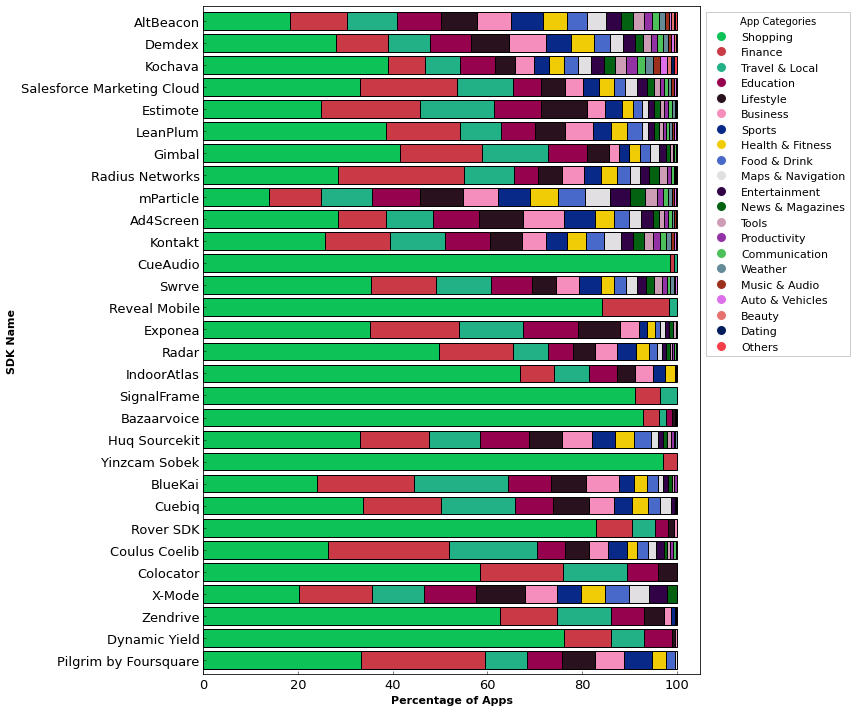

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from matplotlib.lines import Line2D
import seaborn as sns

# Function to fetch raw data from the database
def get_raw_data(conn, trackers):
    query = """
    SELECT t.tracker_name, b.package_name, b.category
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name 
    WHERE b.gplay_status = true AND t.tracker_name IN %s;
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            results = cur.fetchall()
            df = pd.DataFrame(results, columns=["tracker_name", "package_name", "category"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

# Toggle these variables
flip_sdk_order = True
use_sequential_palette = False

# Assuming `conn` is a valid database connection and `trackers` is a list of tracker names to analyze
# Fetch raw data
raw_data_df = get_raw_data(conn, bt_beacon_sdk)
raw_data_df['tracker_name'] = raw_data_df['tracker_name'].str.replace(r"BlueKai \(acquired by Oracle\)", "BlueKai", regex=True)

# Calculate the number of unique apps (package_name) for each SDK
app_counts_per_sdk = raw_data_df.groupby('tracker_name')['package_name'].nunique()

# Identify the top 30 SDKs by the number of unique apps, in descending order
top_sdks_by_app_count = app_counts_per_sdk.nlargest(30).index

# Sort the SDKs by the total count of unique apps, and then reverse if `flip_sdk_order` is True
top_sdks_by_app_count = app_counts_per_sdk.loc[top_sdks_by_app_count].sort_values(ascending=False).index
if flip_sdk_order:
    top_sdks_by_app_count = top_sdks_by_app_count[::-1]

# Filter the data to include only the top SDKs
filtered_data = raw_data_df[raw_data_df['tracker_name'].isin(top_sdks_by_app_count)]

# Aggregate the data by tracker and category
category_counts = filtered_data.groupby(['tracker_name', 'category']).size().unstack(fill_value=0)

# Select the top 20 categories based on overall usage across all SDKs
top_20_categories = category_counts.sum(axis=0).nlargest(20).index
category_counts_top_20 = category_counts[top_20_categories]

# Group remaining categories as 'Other'
other_categories = category_counts.columns.difference(top_20_categories)
category_counts_top_20['Others'] = category_counts[other_categories].sum(axis=1)

# Calculate percentages for each category by SDK
category_percentages_top_20 = category_counts_top_20.div(category_counts_top_20.sum(axis=1), axis=0) * 100

# Apply the sorted SDK order (with optional flipping) to the percentages DataFrame
category_percentages_top_20 = category_percentages_top_20.loc[top_sdks_by_app_count]

# Sort the categories within each SDK by percentage
sorted_category_percentages = category_percentages_top_20.apply(lambda x: x.sort_values(ascending=False).values, axis=1)
sorted_category_percentages = pd.DataFrame(sorted_category_percentages.tolist(),
                                           index=category_percentages_top_20.index,
                                           columns=category_percentages_top_20.columns)

# Select color palette based on the flag
if use_sequential_palette:
    # Use a sequential color palette
    colors = sns.color_palette("Spectral", n_colors=len(category_percentages_top_20.columns))
else:
    # Use random colors
    # colors = [tuple(random.random() for _ in range(3)) for _ in category_percentages_top_20.columns]
    colors = [(0.05165144397238275, 0.7633355391771616, 0.34483123269192484),
 (0.788034181167364, 0.22761477291594312, 0.2740924927174829),
 (0.1318314624240845, 0.6893948721128661, 0.5259479816295319),
 (0.5903472364208374, 0.008785115493910589, 0.3087630137925538),
 (0.16587488608205758, 0.06513263346543885, 0.11706999089530656),
 (0.9621070203694939, 0.5581915800605199, 0.7356528437257097),
 (0.035659533262361154, 0.1619635047088238, 0.5354863978137103),
         (0.9425685514553352, 0.7986463607067597, 0.024369966173843793),
 (0.28124929096972184, 0.4129738928796858, 0.7931584722728453),
 (0.8853486917837582, 0.8764469302231422, 0.8855968646818292),
 (0.1923584376331885, 0.010954653293555716, 0.27538134327930586),
 (0.013176397501770687, 0.3791656411702754, 0.07238139194833193),
 (0.8045772492075032, 0.6147254420662648, 0.7088562392226865),
 (0.5774966971739101, 0.19716902261959857, 0.6480136183797671),
 (0.3070645793237834, 0.7521953307345486, 0.3497969035415991),
 (0.3918989759669671, 0.5460324763999255, 0.5907899631597995),
 (0.611960750808044, 0.1900765249342351, 0.11273310418324689),
 (0.86427040049884, 0.44033725842156524, 0.9167880257917009),
 (0.9004629901129131, 0.44900675195421524, 0.4289786991680482),
 (0.0013353881888060748, 0.10951752598491005, 0.36185824831081137),
 (0.9591239492429314, 0.24330290059139392, 0.28490643862207843)]

#     colors = [(0.9591239492429314, 0.24330290059139392, 0.28490643862207843),
#  (0.47063138214870315, 0.5787282469196966, 0.7285469750902623),
#  (0.19810693780639732, 0.2723899328765177, 0.5318839854791226),
#  (0.3754198949182843, 0.9112097407605431, 0.24692537587262287),
#  (0.2688523405408966, 0.8951112991431978, 0.33879050386855103),
#  (0.16867273095362523, 0.15519518925294185, 0.42878803365854334),
#  (0.6874240979142905, 0.1702833408855554, 0.4843972385155413),
#  (0.13450121537709459, 0.5620299066872565, 0.6665100837967484),
#  (0.6189516390137707, 0.0803260488859836, 0.23625358553168563),
#  (0.8506849765499903, 0.6489460091041196, 0.4117479510321336),
#  (0.03272884063161374, 0.00038473211785683414, 0.8745986898359791),
#  (0.15676223756462437, 0.9776862631438631, 0.47246405226406574),
#  (0.6009056504001085, 0.6237947738749221, 0.5522483764081311),
#  (0.00958554487304919, 0.4855975542295917, 0.5786483946429404),
#  (0.8476609801989956, 0.10686874251018486, 0.5703077062769802),
#  (0.0996028821736391, 0.7656278019916452, 0.46738519250542443),
#  (0.8877562175035315, 0.4530376571977913, 0.7843825962978276),
#  (0.1068074832711412, 0.7876633150091871, 0.8492770328469668),
#  (0.42852216137597177, 0.36728004820855253, 0.37618499583735476),
#  (0.07970542788484458, 0.035787810943735954, 0.8276935698085737),
#  (0.8437191742244349, 0.1419863820666648, 0.6147718467379331)]


# Map colors to categories in the sorted order
category_colors_sorted = {category: colors[i] for i, category in enumerate(category_percentages_top_20.columns)}

# Plot the sorted stacked bar chart
fig, ax = plt.subplots(figsize=(12, 10))
sorted_category_percentages.plot(kind='barh', stacked=True, color=[category_colors_sorted[cat] for cat in category_percentages_top_20.columns], ax=ax, width=0.8)

# Enhance readability of labels and add titles
ax.set_xlabel('Percentage of Apps', fontsize=11, fontweight='bold')
ax.set_ylabel('SDK Name', fontsize=11, fontweight='bold')
# ax.set_title('Top 30 SDKs by Category Percentage in Apps', fontsize=14, fontweight='bold')

# Create a legend with colors for the sorted categories
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=category_colors_sorted[cat], markersize=10) for cat in category_percentages_top_20.columns]
labels = category_colors_sorted.keys()
ax.legend(handles, labels, title='App Categories', bbox_to_anchor=(1, 1), loc='upper left', fontsize=11)

# Show the plot
plt.tight_layout()

plt.savefig("top_30_sdk_20_category_sorted.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [57]:
filtered_data[filtered_data['tracker_name'].str.contains('AltBeacon')]

tracker_name                     package_name        category
34        AltBeacon           com.disney.wdw.android  Travel & Local
35        AltBeacon           com.disney.wdw.android  Travel & Local
36        AltBeacon           com.disney.wdw.android  Travel & Local
37        AltBeacon           com.disney.wdw.android  Travel & Local
38        AltBeacon           com.disney.wdw.android  Travel & Local
...             ...                              ...             ...
114034    AltBeacon  com.alienmanfc6.wheresmyandroid           Tools
114035    AltBeacon  com.alienmanfc6.wheresmyandroid           Tools
114036    AltBeacon  com.alienmanfc6.wheresmyandroid           Tools
114037    AltBeacon  com.alienmanfc6.wheresmyandroid           Tools
114061    AltBeacon     io.pushpay.churchforfamilies       Lifestyle

[19547 rows x 3 columns]

In [60]:
filtered_data.tracker_name.unique()


array(['AltBeacon', 'LeanPlum', 'Exponea', 'Ad4Screen',
       'Salesforce Marketing Cloud', 'Demdex', 'Bazaarvoice', 'Kochava',
       'Radius Networks', 'Dynamic Yield', 'mParticle', 'Gimbal',
       'Estimote', 'Yinzcam Sobek', 'Kontakt', 'Cuebiq', 'CueAudio',
       'Swrve', 'Coulus Coelib', 'Reveal Mobile', 'SignalFrame',
       'Huq Sourcekit', 'Rover SDK', 'BlueKai (acquired by Oracle)',
       'IndoorAtlas', 'Radar', 'Colocator', 'X-Mode', 'Zendrive',
       'Pilgrim by Foursquare'], dtype=object)

In [51]:
heatmap_data
total_app_counts = raw_data_df.groupby('tracker_name')['package_name'].nunique()
total_app_counts.name = 'Total Apps'
# add total_app_counts to heatmap data as a new column
heatmap_data = heatmap_data.join(total_app_counts)

In [52]:
heatmap_data

Lifestyle  Others  Shopping  Sports  Business  \
tracker_name                                                                  
AltBeacon                           721     198       240     137       498   
Demdex                               45      43        89     120        47   
Kochava                              34     410        36      73        20   
Salesforce Marketing Cloud           98      50       244      33       103   
Estimote                            174      25        14       6        60   
LeanPlum                             15      96        33       6        10   
Gimbal                               40       4        23     167         5   
Radius Networks                     162      24        23       9        21   
mParticle                            11      18        21      21        11   
Ad4Screen                            10      10        38       5         3   
Kontakt                              17       2        30      13        40   
CueAudio                              0       0         0     187         0   
Swrve                                 3      69        13       4         0   
Reveal Mobile                         0       0         0       0         0   
Exponea                               4       3        38       0         2   
Radar                                 5       3        29       3         3   
IndoorAtlas                           0       2         2       0        55   
SignalFrame                           0       0         0       4         0   
Bazaarvoice                           1       5        72       1         2   
Huq Sourcekit                         5      10         1       3         1   
Yinzcam Sobek                         0       0         0      74         0   
Cuebiq                                1      11         1       0         0   
BlueKai (acquired by Oracle)          4       5         8      10         1   
Rover SDK                             0       0         2      43         2   
Coulus Coelib                         6       3         0       2         0   
Colocator                             0       1         0       4         0   
X-Mode                                6      10         0       0         0   
Zendrive                              3       3         0       0         7   
Dynamic Yield                         0       1        15       0         0   
Pilgrim by Foursquare                 5       1         5       0         0   
Sense360                              6       2         2       0         0   
Locuslabs                             0       0         1       0         0   
InMarket                              4       2        10       0         0   
Singlespot                            0       1         3       0         0   
Zapr                                  0       7         0       4         0   
Roximity                              0       4         0       2         0   
Swirl                                 0       3         2       0         0   
Bluecats                              2       0         3       0         5   
OpenLocate                            0       1         0       1         0   
Areametrics                           0       2         0       0         0   
Point Inside                          2       0         0       1         0   
PredicIO                              0       1         0       0         0   
Unacast Pure                          0       1         0       0         0   
MOCA                                  1       0         1       0         0   
BeaconsInSpace (Fysical)              0       1         0       0         2   
Woosmap SDK                           0       0         0       0         1   
Placer                                0       1         0       1         0   
Signal360                             0       0         0       1         2   
Sensoro                               0       0         0       0         1   
T

In [58]:
heatmap_data_percentage = heatmap_data.div(heatmap_data['Total Apps'], axis=0) * 100
total_app_counts = raw_data_df.groupby('tracker_name')['package_name'].nunique()
total_app_counts.name = 'Total Apps count'
heatmap_data_percentage = heatmap_data_percentage.join(total_app_counts)
heatmap_data_percentage.round().sort_values(by='Total Apps count', ascending=False).to_csv("heatmap_data_percentage.csv")


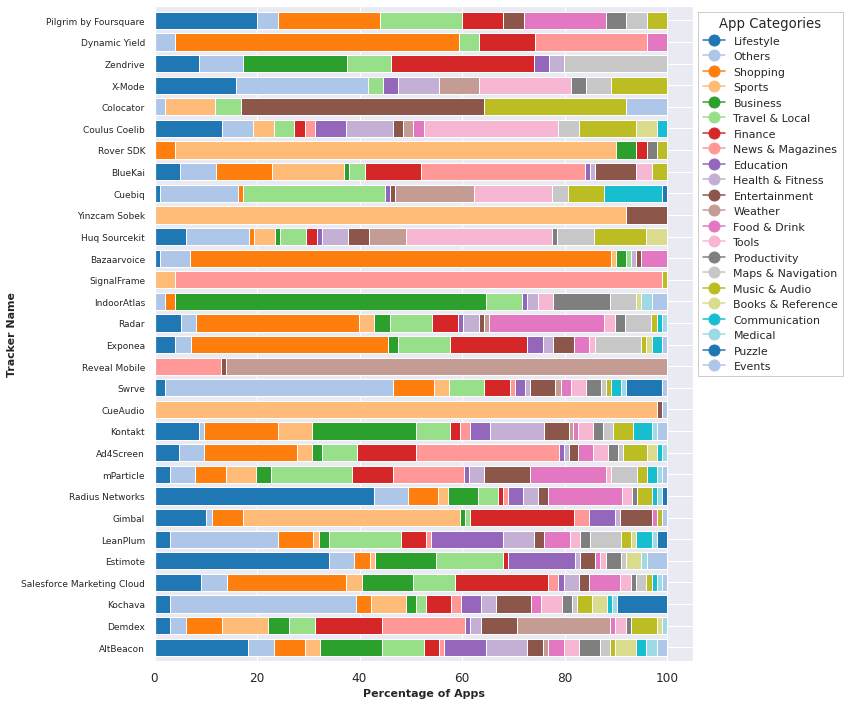

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Load your data
data_path = "/home/aniketh/devel/src/ble-beacon/heatmap_data_percentage.csv"  # Replace with your file path
new_data_df = pd.read_csv(data_path)
new_data_df['tracker_name'] = new_data_df['tracker_name'].str.replace(r"BlueKai \(acquired by Oracle\)", "BlueKai", regex=True)

# Filter the top 30 SDKs based on "Total Apps count"
top_30_trackers = new_data_df.nlargest(30, "Total Apps count")
visualization_data_top_30 = top_30_trackers.drop(columns=["Total Apps", "Total Apps count"]).set_index("tracker_name")

# Normalize percentages so each row sums to 100%
visualization_data_top_30_normalized = visualization_data_top_30.div(visualization_data_top_30.sum(axis=1), axis=0) * 100

# Define colors for categories
colors = sns.color_palette("tab20", len(visualization_data_top_30.columns))
category_colors_updated = {col: colors[i] for i, col in enumerate(visualization_data_top_30.columns)}

# Plot the normalized stacked bar chart for the top 30 trackers
fig, ax = plt.subplots(figsize=(12, 10))

# Set the background color to transparent
fig.patch.set_facecolor('none')

# Plot the stacked bars
visualization_data_top_30_normalized.plot(kind="barh", stacked=True, 
                                          color=[category_colors_updated[cat] for cat in visualization_data_top_30.columns], 
                                          ax=ax, width=0.8)

# Enhance readability of labels and add labels
ax.set_xlabel('Percentage of Apps', fontsize=11, fontweight='bold')
ax.set_ylabel('Tracker Name', fontsize=11, fontweight='bold')

# Set y-axis labels to tracker names
ax.set_yticks(range(len(visualization_data_top_30_normalized.index)))
ax.set_yticklabels(visualization_data_top_30_normalized.index, fontsize=9)

# Create a legend with consistent colors for each category
handles = [Line2D([0], [0], marker='o', color=category_colors_updated[cat], markersize=11) 
           for cat in visualization_data_top_30.columns]
ax.legend(handles, visualization_data_top_30.columns, title='App Categories', bbox_to_anchor=(1, 1), loc='upper left', fontsize=11, frameon=True, facecolor='none')

# Save the plot with transparent background
plt.tight_layout()
plt.savefig("top_30_sdk_20_category_sorted.pdf", format="pdf", bbox_inches="tight", transparent=True)

# Show the plot
plt.show()


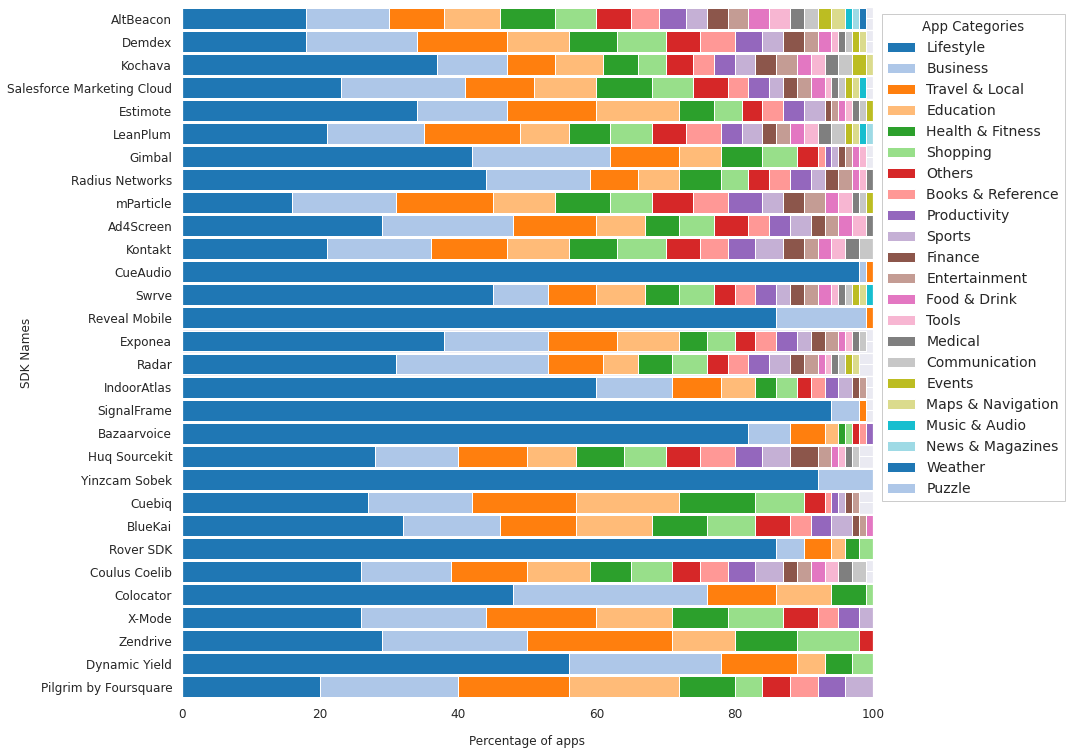

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Load your data
data_path = "/home/aniketh/devel/src/ble-beacon/heatmap_data_percentage.csv"  # Replace with your file path
new_data_df = pd.read_csv(data_path)
new_data_df['tracker_name'] = new_data_df['tracker_name'].str.replace(r"BlueKai \(acquired by Oracle\)", "BlueKai", regex=True)
# Filter the top 30 SDKs based on "Total Apps count"
top_30_trackers = new_data_df.nlargest(30, "Total Apps count")
df_normalized = top_30_trackers.drop(columns=["Total Apps", "Total Apps count"]).set_index("tracker_name")
# df_normalized = df_normalized.div(df_normalized.sum(axis=1), axis=0) * 100

# Extend the colormap with additional unique colors
base_colors = plt.cm.tab20.colors
additional_colors = [(1.0, 0.0, 0.5), (0.0, 0.5, 0.5)]
all_colors = list(base_colors)

sorted_trackers = {}
for tracker in df_normalized.index:
    sorted_trackers[tracker] = df_normalized.loc[tracker].sort_values(ascending=False)
num_trackers = len(df_normalized)
fig, axes = plt.subplots(nrows=num_trackers, ncols=1, figsize=(12, num_trackers * 0.4), sharex=True)
fig.patch.set_facecolor('white')
for i, (tracker, sorted_data) in enumerate(sorted_trackers.items()):
    bottom = 0
    for j, (category, value) in enumerate(sorted_data.items()):
        axes[i].barh(tracker, value, left=bottom, color=all_colors[j % len(all_colors)], label=category if i == 0 else "")
        bottom += value
    axes[i].set_xlim(0, 100)
    if i < num_trackers - 1:
        axes[i].get_xaxis().set_visible(False)
fig.text(0.5, 0.05, "Percentage of apps", ha="center", va="center", fontsize=12)
fig.text(-0.08, 0.5, "SDK Names", ha="center", va="center", rotation="vertical", fontsize=12)
# Add a main title
# fig.suptitle("Category Distribution by Tracker (Sorted Stacked Bar)", fontsize=16)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title="App Categories", fontsize=14, bbox_to_anchor=(1, 0, 0.13 , 0.9), frameon=True, facecolor='none')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0)
# Save the plot with transparent background
# plt.tight_layout()
plt.savefig("top_30_sdk_20_category_sorted.pdf", format="pdf", bbox_inches="tight", transparent=True)

# Show the plot
plt.show()

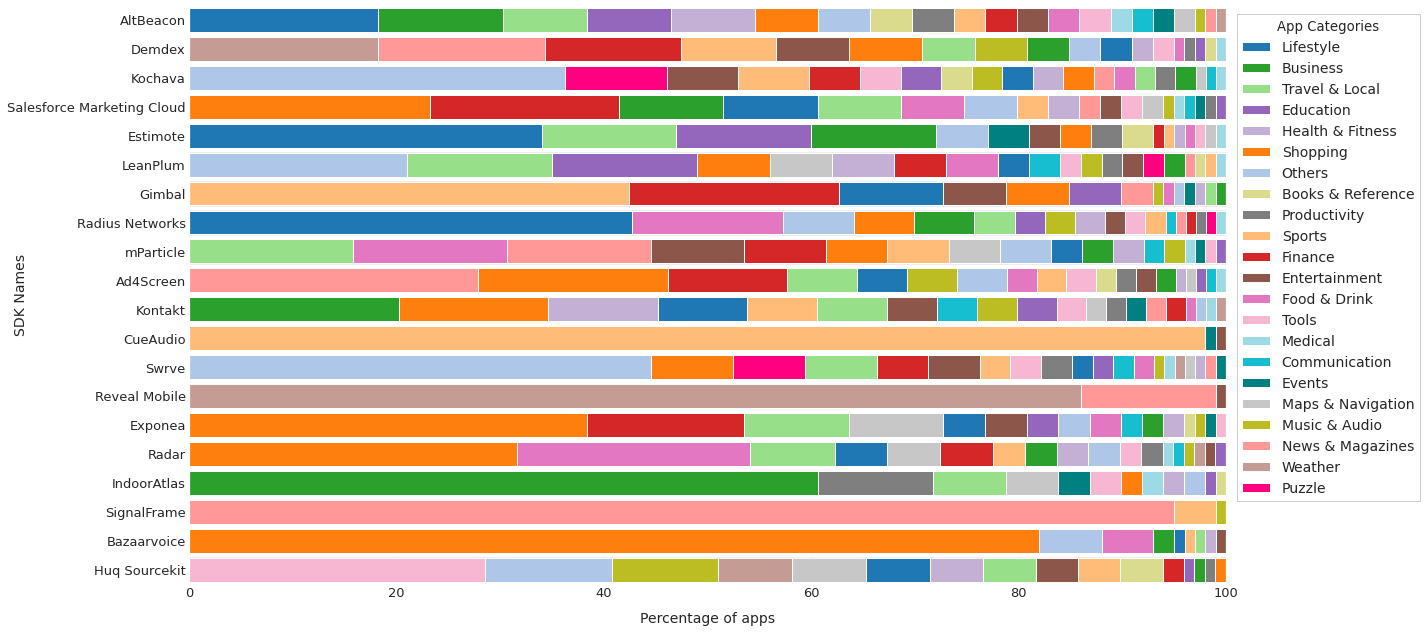

In [461]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Define categories and assign each a unique color
categories = [
    'Lifestyle', 'Others', 'Shopping', 'Sports', 'Business', 'Travel & Local',
    'Finance', 'News & Magazines', 'Education', 'Health & Fitness', 'Entertainment',
    'Weather', 'Food & Drink', 'Tools', 'Productivity', 'Maps & Navigation',
    'Music & Audio', 'Books & Reference', 'Communication', 'Medical', 'Puzzle', 'Events'
]

data_path = "/home/aniketh/devel/src/ble-beacon/heatmap_data_percentage.csv"  # Replace with your file path
new_data_df = pd.read_csv(data_path)
new_data_df['tracker_name'] = new_data_df['tracker_name'].str.replace(r"BlueKai \(acquired by Oracle\)", "BlueKai", regex=True)
# Filter the top 30 SDKs based on "Total Apps count"
top_30_trackers = new_data_df.nlargest(20, "Total Apps count")
df_normalized = top_30_trackers.drop(columns=["Total Apps", "Total Apps count"]).set_index("tracker_name")
df_normalized = df_normalized.div(df_normalized.sum(axis=1), axis=0) * 100


# Extend the colormap with additional unique colors
base_colors = plt.cm.tab20.colors
additional_colors = [(1.0, 0.0, 0.5), (0.0, 0.5, 0.5)]  # Add two custom RGB colors
all_colors = list(base_colors) + additional_colors
# Create a dictionary to map each category to a specific color
category_colors = {category: all_colors[i] for i, category in enumerate(categories)}
# Normalize the DataFrame to ensure each row sums to 100

# Sort data for each tracker
sorted_trackers = {}
for tracker in df_normalized.index:
    sorted_trackers[tracker] = df_normalized.loc[tracker].sort_values(ascending=False)
# Plot each tracker as a horizontal stacked bar
num_trackers = len(df_normalized)
fig, axes = plt.subplots(nrows=num_trackers, ncols=1, figsize=(18, num_trackers * 0.5), sharex=True)
fig.patch.set_facecolor('white')
for i, (tracker, sorted_data) in enumerate(sorted_trackers.items()):
    bottom = 0
    for category, value in sorted_data.items():
        color = category_colors.get(category, "gray")  # Use assigned color or gray if not found
        axes[i].barh(tracker, value, left=bottom, color=color, label=category if i == 0 else "")
        bottom += value
    axes[i].set_xlim(0, 100)
    if i < num_trackers - 1:
        axes[i].get_xaxis().set_visible(False)
# Add axis labels
fig.text(0.5, 0.05, "Percentage of apps", ha="center", va="center", fontsize=14)
fig.text(-0.03, 0.5, "SDK Names", ha="center", va="center", rotation="vertical", fontsize=14)
# Add legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title="App Categories", fontsize=14, bbox_to_anchor=(1, 0, 0.055 , 0.9), frameon=True, facecolor='none')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.1)
plt.savefig("top_20_sdk_20_category_sorted.svg", format="svg", bbox_inches="tight", transparent=True)
plt.show()

In [460]:
plt.savefig("top_20_sdk_20_category_sorted.svg", format="svg", bbox_inches="tight", transparent=True)


<Figure size 432x288 with 0 Axes>

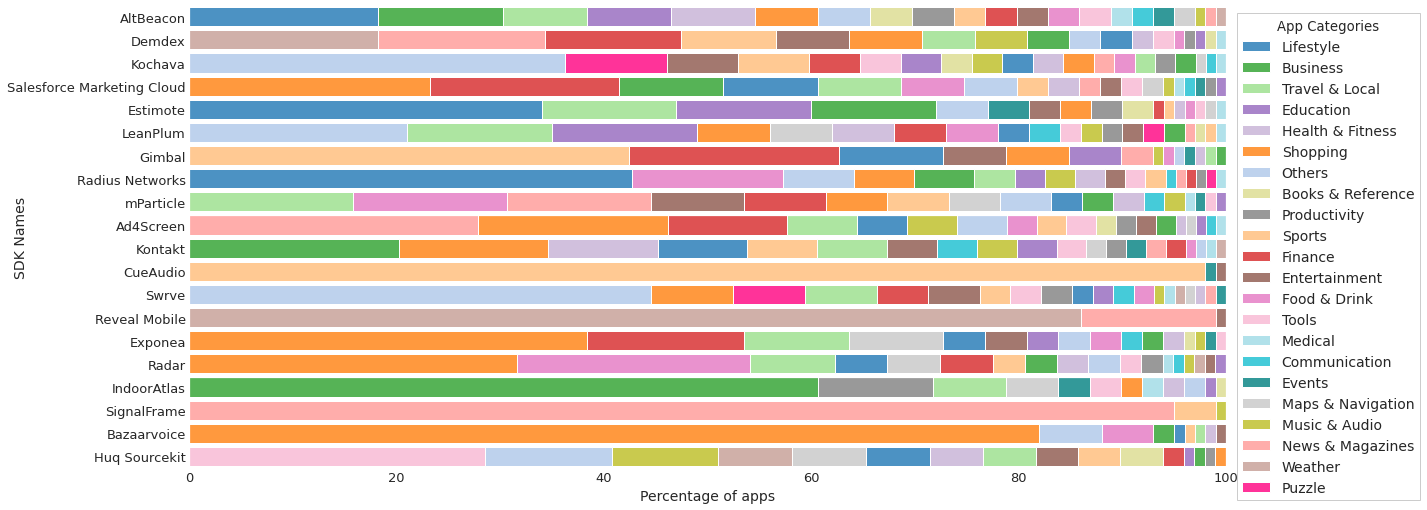

In [456]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Define categories and assign each a unique color
categories = [
    'Lifestyle', 'Others', 'Shopping', 'Sports', 'Business', 'Travel & Local',
    'Finance', 'News & Magazines', 'Education', 'Health & Fitness', 'Entertainment',
    'Weather', 'Food & Drink', 'Tools', 'Productivity', 'Maps & Navigation',
    'Music & Audio', 'Books & Reference', 'Communication', 'Medical', 'Puzzle', 'Events'
]
# Load data
data_path = "/home/aniketh/devel/src/ble-beacon/heatmap_data_percentage.csv"  # Replace with your file path
new_data_df = pd.read_csv(data_path)
new_data_df['tracker_name'] = new_data_df['tracker_name'].str.replace(r"BlueKai \(acquired by Oracle\)", "BlueKai", regex=True)
# Filter the top 30 SDKs based on "Total Apps count"
top_30_trackers = new_data_df.nlargest(20, "Total Apps count")
df_normalized = top_30_trackers.drop(columns=["Total Apps", "Total Apps count"]).set_index("tracker_name")
df_normalized = df_normalized.div(df_normalized.sum(axis=1), axis=0) * 100
# Extend the colormap with additional unique colors
base_colors = plt.cm.tab20.colors
additional_colors = [(1.0, 0.0, 0.5), (0.0, 0.5, 0.5)]  # Add two custom RGB colors
all_colors = list(base_colors) + additional_colors
# Function to blend colors with white to soften them
def blend_with_white(color, blend_factor=0.9):
    return tuple((1 - blend_factor) * c + blend_factor for c in color)
# Apply the blending function to all colors
softened_colors = [blend_with_white(color, blend_factor=0.2) for color in all_colors]
# Create a dictionary to map each category to a specific softened color
category_colors = {category: softened_colors[i] for i, category in enumerate(categories)}
# Sort data for each tracker
sorted_trackers = {}
for tracker in df_normalized.index:
    sorted_trackers[tracker] = df_normalized.loc[tracker].sort_values(ascending=False)
# Plot each tracker as a horizontal stacked bar
num_trackers = len(df_normalized)
fig, axes = plt.subplots(nrows=num_trackers, ncols=1, figsize=(18, num_trackers * 0.4), sharex=True)
fig.patch.set_facecolor('white')
for i, (tracker, sorted_data) in enumerate(sorted_trackers.items()):
    bottom = 0
    for category, value in sorted_data.items():
        color = category_colors.get(category, "gray")  # Use assigned softened color or gray if not found
        axes[i].barh(tracker, value, left=bottom, color=color, label=category if i == 0 else "")
        bottom += value
    axes[i].set_xlim(0, 100)
    if i < num_trackers - 1:
        axes[i].get_xaxis().set_visible(False)
# Add axis labels
fig.text(0.5, 0.05, "Percentage of apps", ha="center", va="center", fontsize=14)
fig.text(-0.03, 0.5, "SDK Names", ha="center", va="center", rotation="vertical", fontsize=14)
# Add legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title="App Categories", fontsize=14, bbox_to_anchor=(1, 0, 0.055, 0.9), frameon=True, facecolor='none')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.1)
plt.show()

/tmp/ipykernel_1250668/3391607427.py:92: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax_colorbar.add_patch(plt.Rectangle((0, idx), 1, 1, fill=True, color=color, edgecolor='none', lw=0))
/tmp/ipykernel_1250668/3391607427.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


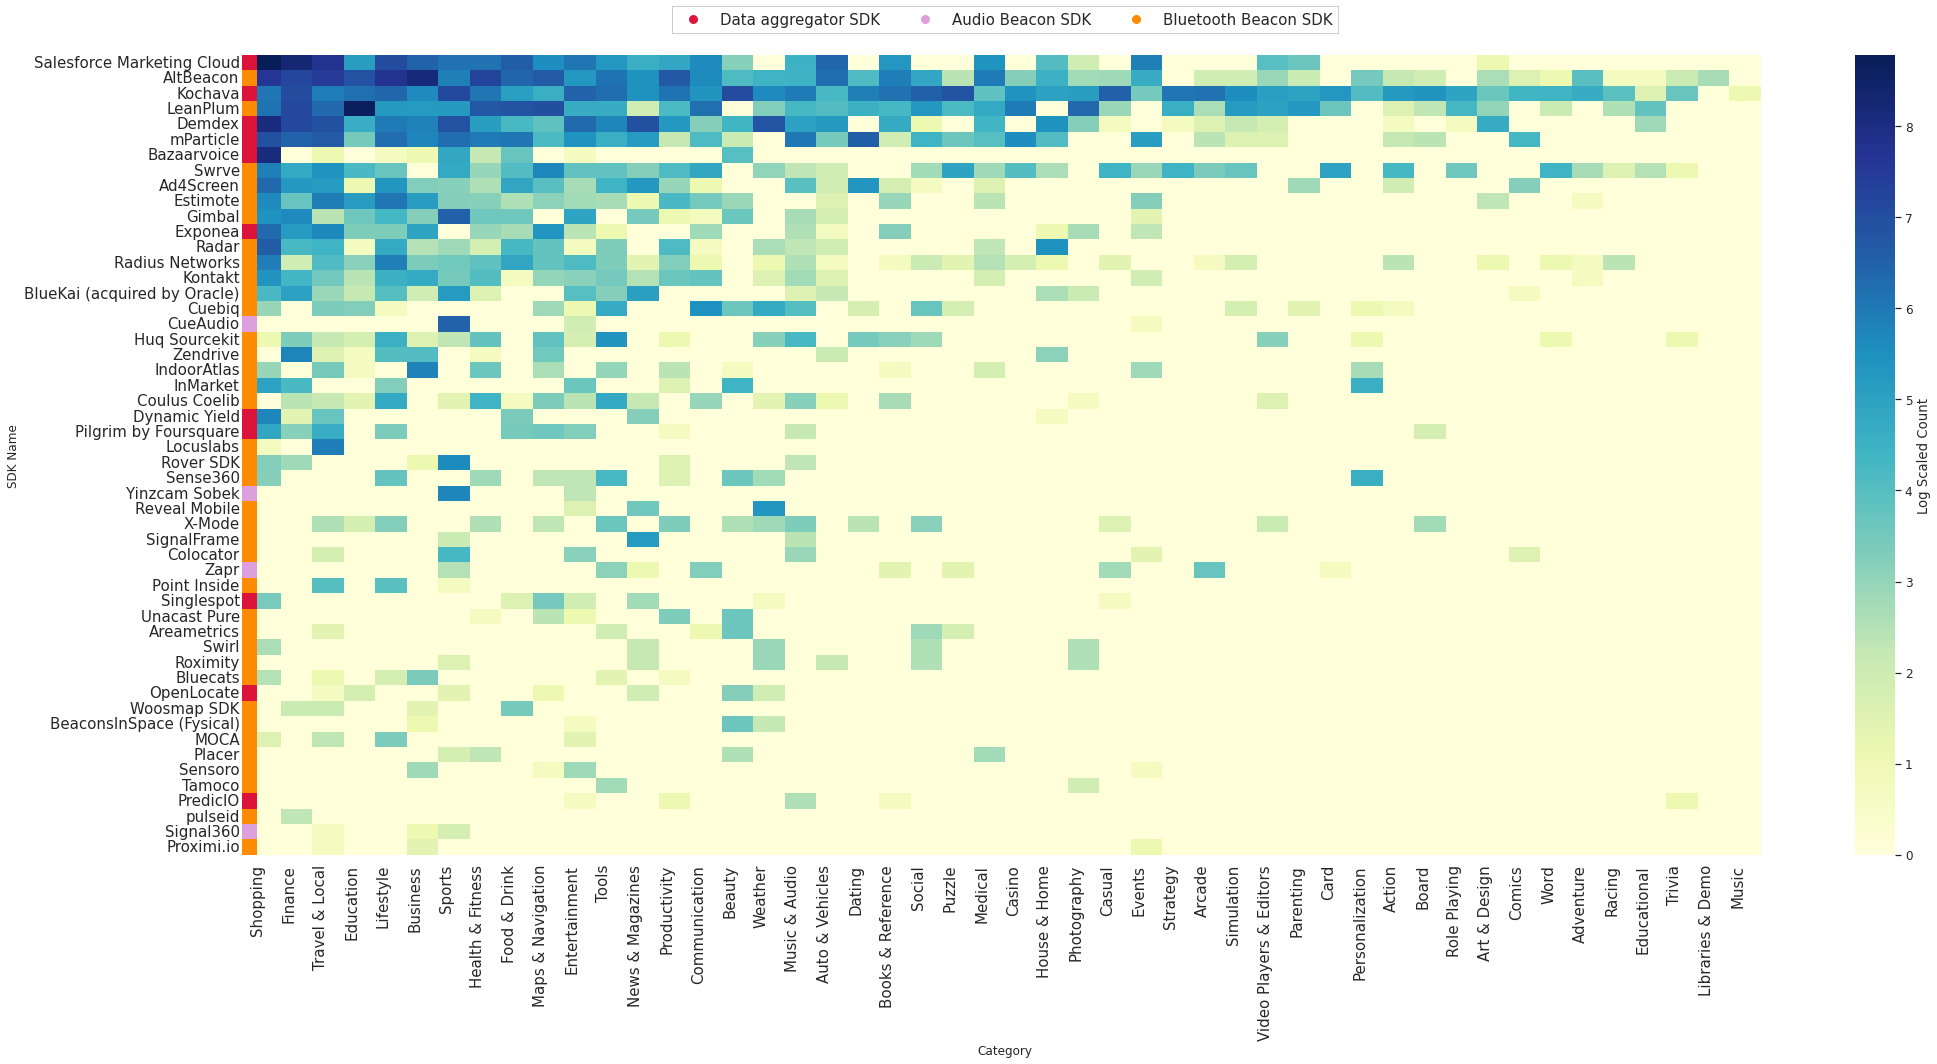

In [32]:
category_df = get_categories_per_sdk0(conn)
category_df = category_df[category_df['category'] != '']
hide_sdks = ['chromecast']
# hide_categories = ['Adventure', 'Simulation', 'Casual', 'Arcade', 'Casino', 'Educational', 'Puzzle', 'Triva', 'Action', 'Libraries & Demo', 'Racing', 'Comics', 'Role Playing', 'Board', 'Word', 'Trivia']
hide_categories = ['']
plot_category_heatmap0(category_df, bt_beacon_sdk, hide_empty_categories=True, hide_sdks=hide_sdks, hide_categories=hide_categories)

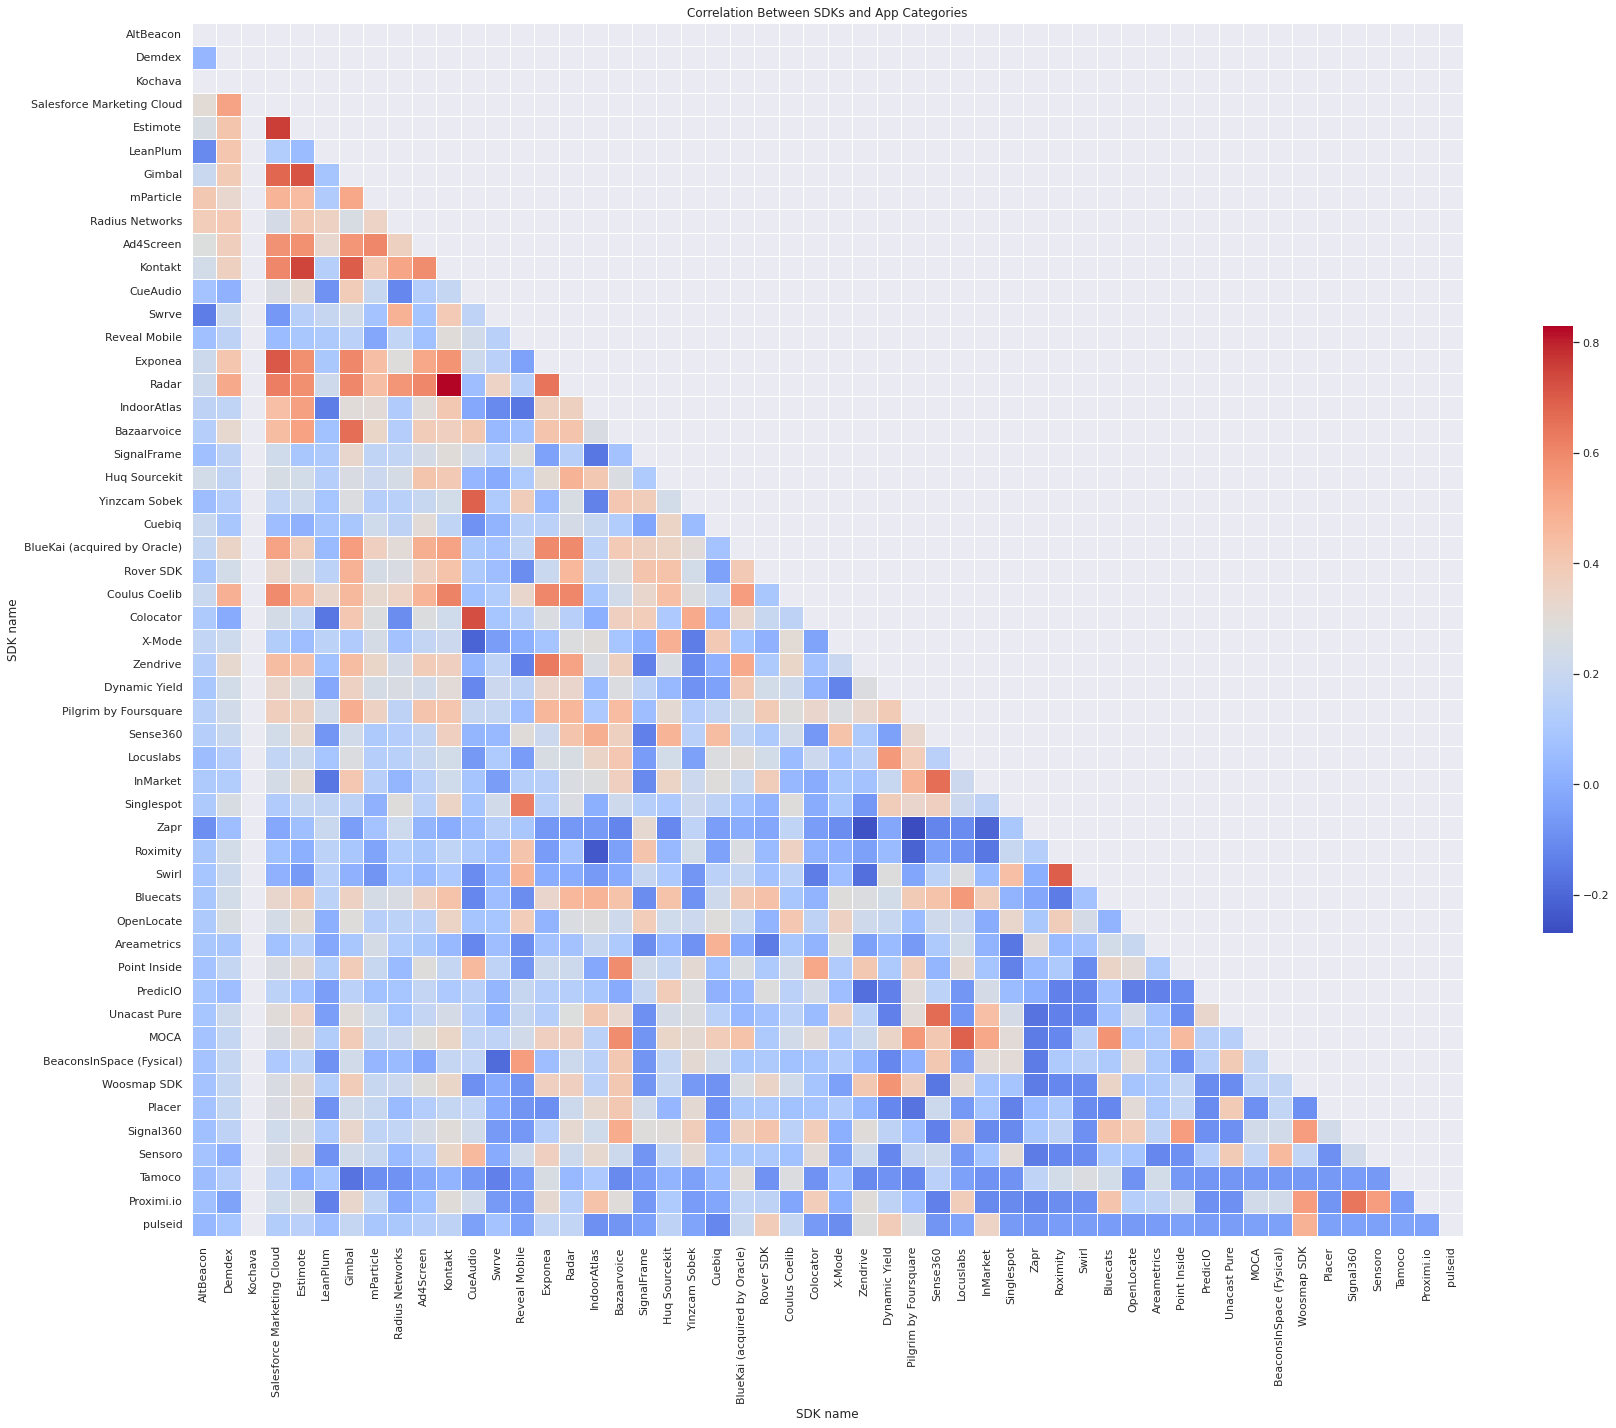

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

file_path = 'heatmap_data.csv'
data = pd.read_csv(file_path)

# filtered_tracker_names = bt_beacon_sdk_names + geofence_sdk_names
data = data[data['tracker_name'].isin(bt_beacon_sdk)]

sdk_presence_matrix = data.set_index('tracker_name').iloc[:, :-2].applymap(lambda x: 1 if x > 0 else 0)
correlation_matrix = sdk_presence_matrix.T.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plotting the correlation matrix
plt.figure(figsize=(25, 20))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Correlation Between SDKs and App Categories')
plt.xlabel('SDK name')
plt.ylabel('SDK name')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("sdk-correlation.pdf", format="pdf", bbox_inches="tight")
plt.show()


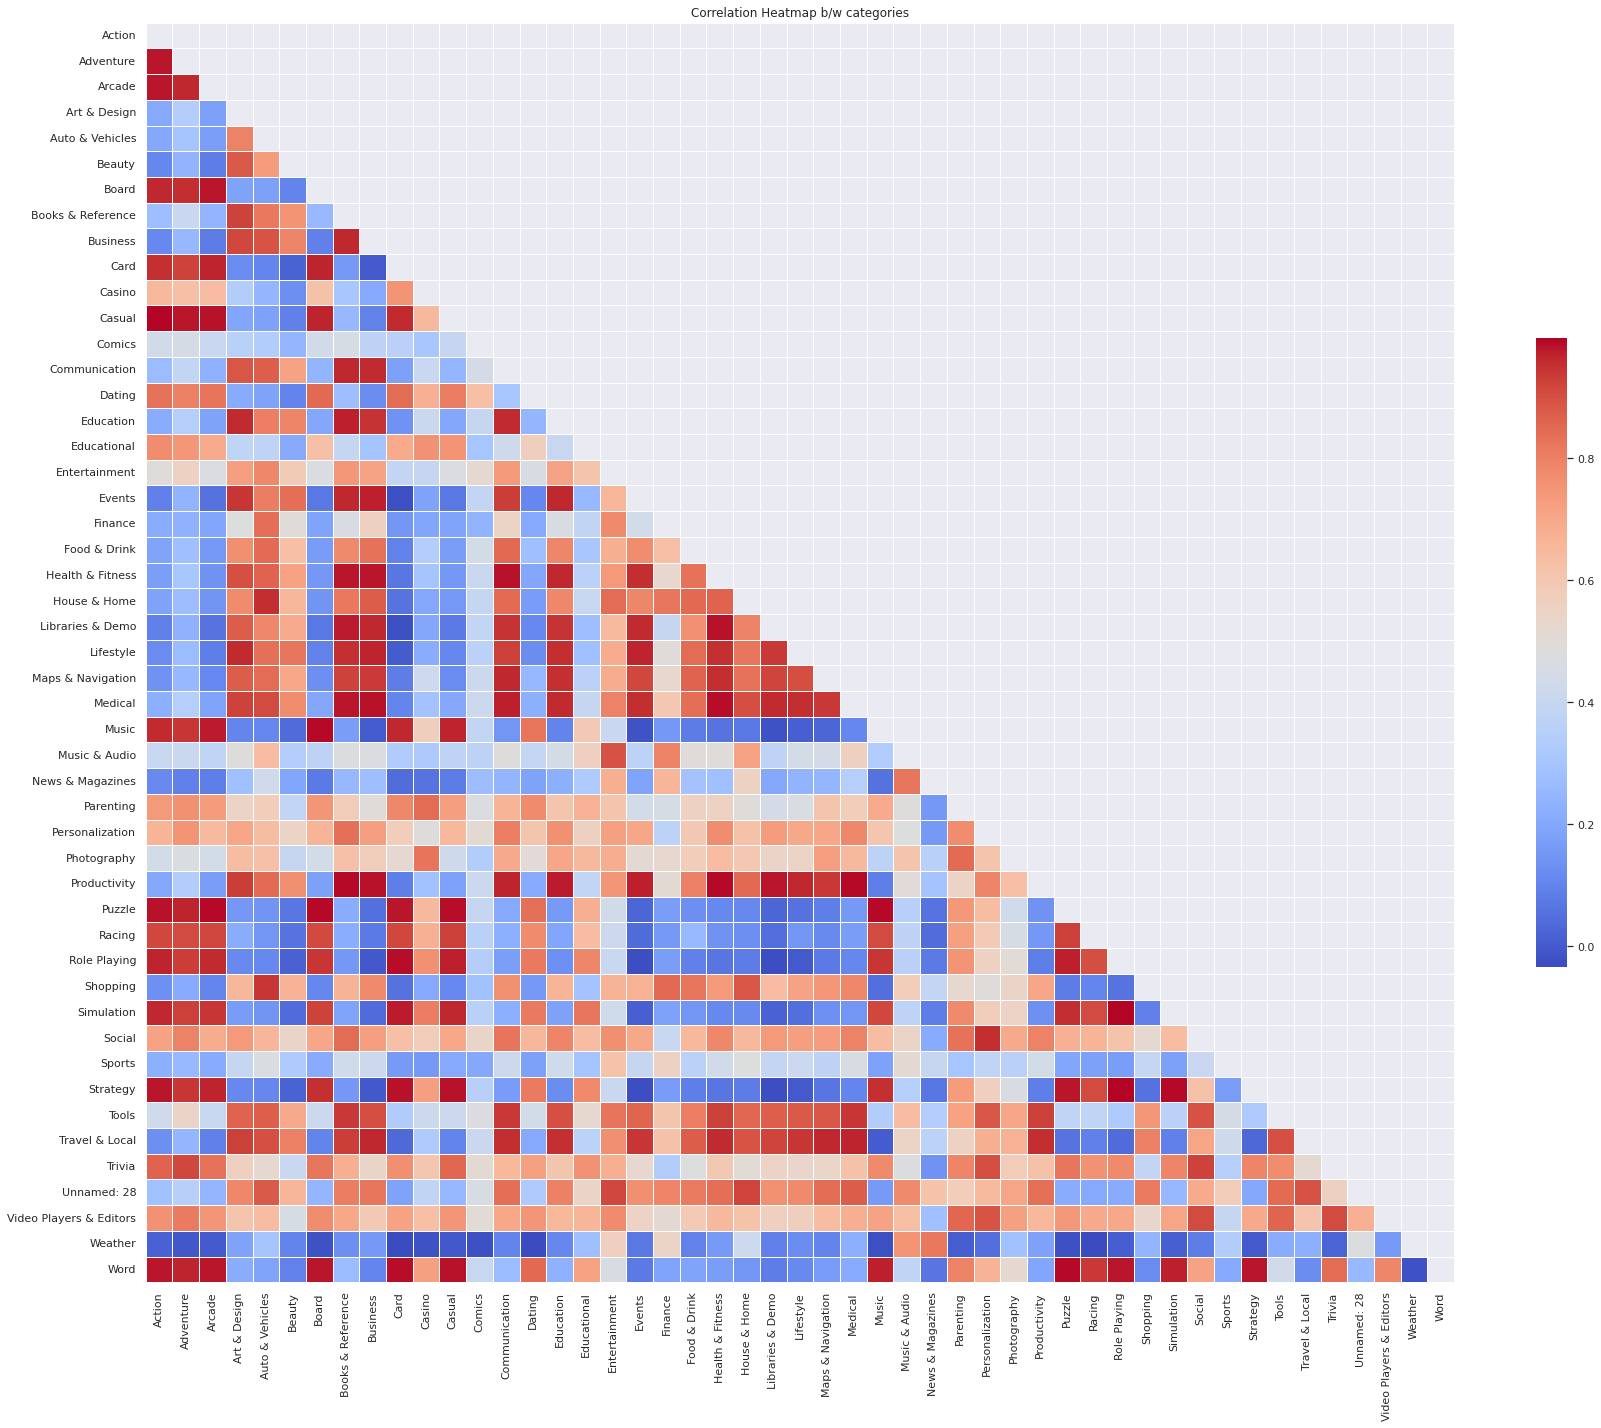

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = 'heatmap_data.csv'
data = pd.read_csv(file_path)

# filtered_tracker_names = bt_beacon_sdk_names + geofence_sdk_names
data_filtered = data[data['tracker_name'].isin(bt_beacon_sdk)]

# Remove the tracker_name column for correlation analysis
data_filtered = data_filtered.drop(columns=['tracker_name'])
sns.set(font_scale=1)

# Calculate the correlation matrix
correlation_matrix_filtered = data_filtered.corr()
sorted_corr = correlation_matrix_filtered.sort_index(axis=0).sort_index(axis=1)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(sorted_corr, dtype=bool))
# Create the heatmap
plt.figure(figsize=(25, 20))
sns.heatmap(sorted_corr, mask=mask, annot=False, cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap b/w categories')
plt.tight_layout()
plt.savefig("category-correlation.pdf", format="pdf", bbox_inches="tight")
plt.show()


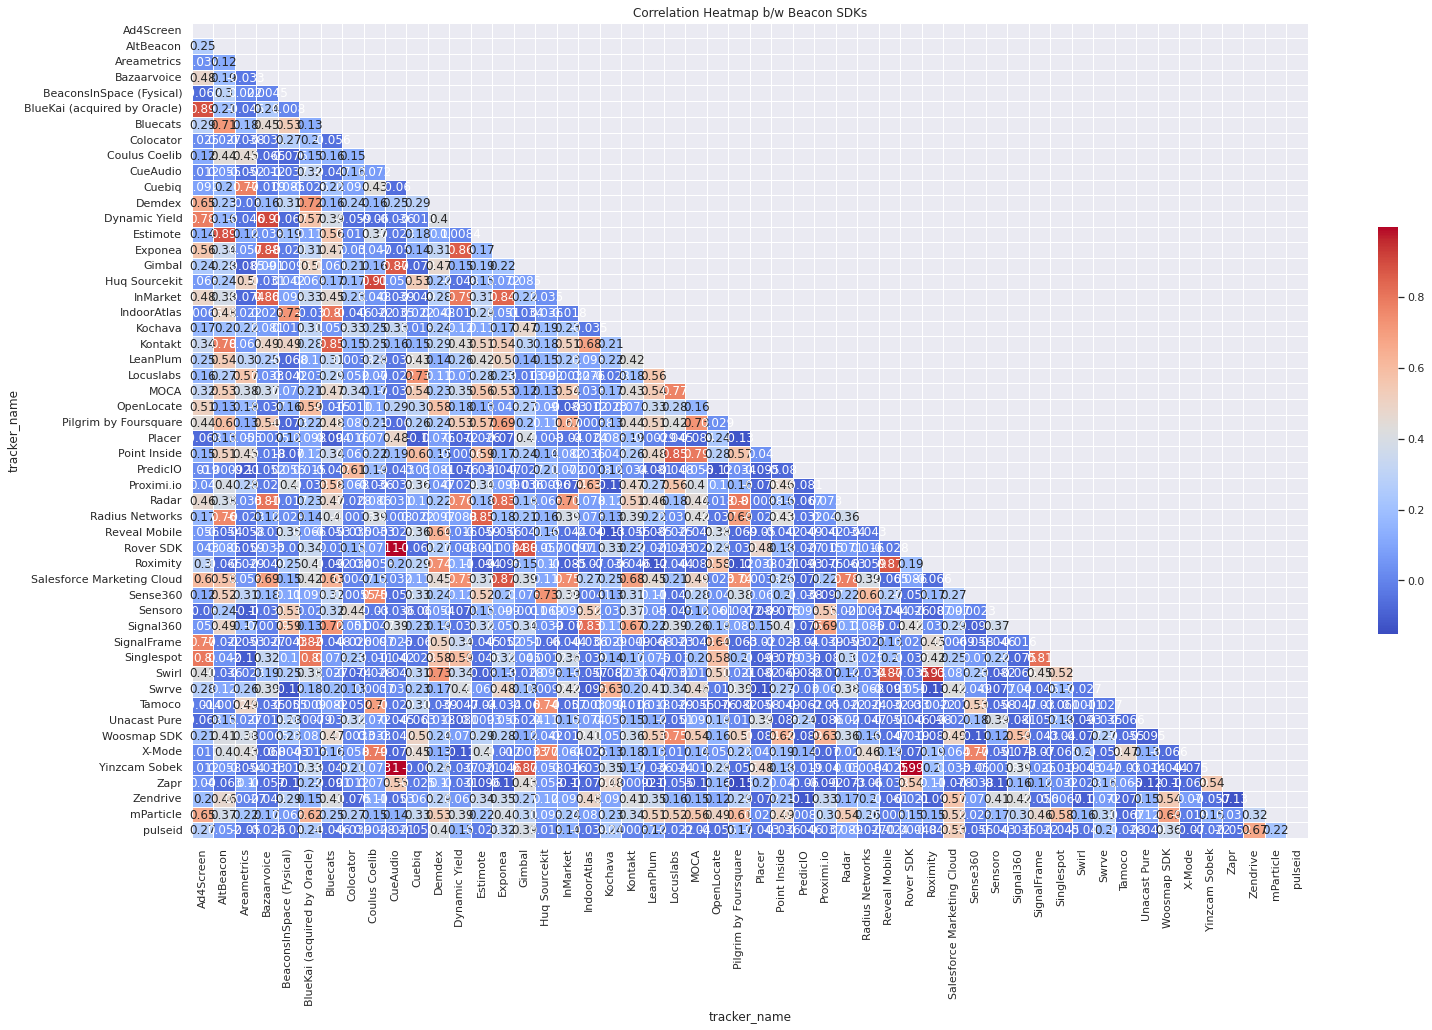

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the CSV file
file_path = 'heatmap_data.csv'
data = pd.read_csv(file_path)

# Define the correct tracker names for the analysis
bt_beacon_sdk_names = [
    "AltBeacon", "Radius Networks", "Estimote", "Gimbal", "Kontakt", "Cuebiq", "Ad4Screen", 
    "Reveal Mobile", "SignalFrame", "IndoorAtlas", "Rover SDK", "Coulus Coelib", "BeaconsInSpace (Fysical)", 
    "InMarket", "Sense360", "Locuslabs", "Roximity", "Bluecats", "Sensoro", "Swirl", "Placer", "Unacast Pure", 
    "Point Inside", "Woosmap SDK", "MOCA", "Proximi.io", "pulseid", "ubudu", "Beaconstac NearBee", 
    "Yinzcam Sobek", "Signal360", "CueAudio", "Radar",  "Areametrics", "BlueKai (acquired by Oracle)"
]


geofence_sdk_names = ["Huq Source", "Demdex", "Pilgrim by Foursquare", "Dynamic Yield", "Singlespot", "Salesforce Marketing Cloud", "mParticle" ]


# Combine both lists of tracker names
filtered_tracker_names = bt_beacon_sdk_names + geofence_sdk_names

# Filter the dataframe to include only the relevant tracker names
data_filtered = data[data['tracker_name'].isin(bt_beacon_sdk)]

# Set the 'tracker_name' as the index
data_filtered.set_index('tracker_name', inplace=True)

# Transpose the dataframe so that SDK names are columns and app categories are rows
data_transposed = data_filtered.T

# Calculate the correlation matrix for the SDKs
correlation_matrix_sdks = data_transposed.corr()

# Sort the correlation matrix
sorted_corr = correlation_matrix_sdks.sort_index(axis=0).sort_index(axis=1)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(sorted_corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(25, 15))

# Draw the heatmap with the mask
sns.heatmap(sorted_corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": .5})

# Set the title
plt.title('Correlation Heatmap b/w Beacon SDKs')

# Show the plot
plt.show()


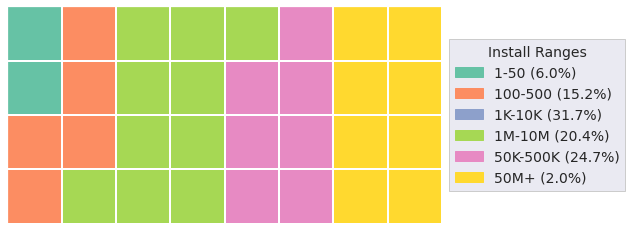

In [285]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
plt.rcParams['legend.title_fontsize'] = 14
# Group install ranges into more specific categories with K, M, B notations
def group_install_ranges(df):
    bins = {
        '1-50': ['1+', '5+', '10+', '50+'],
        '100-500': ['100+', '500+'],
        '1K-10K': ['1,000+', '5,000+', '10,000+'],
        '50K-500K': ['50,000+', '100,000+', '500,000+'],
        '1M-10M': ['1,000,000+', '5,000,000+', '10,000,000+'],
        '50M+': ['50,000,000+', '100,000,000+', '500,000,000+', '1,000,000,000+']
    }
    
    def categorize(install):
        for key, values in bins.items():
            if install in values:
                return key
        return 'Other'

    df['grouped_installs'] = df['installs'].apply(categorize)
    grouped_df = df.groupby('grouped_installs')['count'].sum().reset_index()
    return grouped_df

# Function to create a waffle chart
def create_waffle_chart(categories, values, height, width, colors):
    total_values = sum(values)
    total_num_tiles = width * height
    tiles_per_category = [round(value / total_values * total_num_tiles) for value in values]

    # Initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # Populate the waffle chart
    category_index = 0
    tile_index = 0

    for col in range(width):
        for row in range(height):
            if tile_index >= sum(tiles_per_category[:category_index + 1]):
                category_index += 1
            waffle_chart[row, col] = category_index
            tile_index += 1

    # Create a figure and plot the waffle chart
    fig, ax = plt.subplots(figsize=(8, 4))
    colormap = mcolors.ListedColormap(colors)
    ax.matshow(waffle_chart, cmap=colormap)
    
    # Add gridlines
    ax.set_xticks(np.arange(-.5, width, 1), minor=True)
    ax.set_yticks(np.arange(-.5, height, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', size=0)

    # Create color patches for the legend with percentages
    legend_handles = [mpatches.Patch(color=colors[i], 
                                     label=f"{categories[i]} ({values[i]/total_values*100:.1f}%)") 
                      for i in range(len(categories))]
    
    # Add category legend outside the plot
    plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5),title="Install Ranges", fontsize=14)

    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig("waffle_chart.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# Function to show install counts and plot waffle chart
def show_install_counts(conn, tracker_names):
    query = """
    WITH install_counts AS (
        SELECT DISTINCT b.package_name, g.installs
        FROM trackers t
        JOIN beacon_app_info b ON t.package_name = b.package_name
        JOIN gplay_info g ON b.package_name = g.package_name
        WHERE t.tracker_name IN %s AND b.gplay_status = 'true'
    )
    SELECT installs, COUNT(*) as count
    FROM install_counts
    WHERE installs IS NOT NULL
    GROUP BY installs;
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(tracker_names),))
            results = cur.fetchall()
            
            # Get column names from cursor
            colnames = [desc[0] for desc in cur.description]
            df = pd.DataFrame(results, columns=colnames)
            return df
    except Exception as e:
        print(f"Error executing query: {e}")

# Get the install counts
install_counts_df = show_install_counts(conn, bt_beacon_sdk)

# Group the install ranges
grouped_install_counts_df = group_install_ranges(install_counts_df)

# Prepare data for the waffle chart
categories = grouped_install_counts_df['grouped_installs'].tolist()
values = grouped_install_counts_df['count'].tolist()

# Colors similar to the example screenshot
color_map = {
    '1-50': '#66c2a5',
    '100-500': '#fc8d62',
    '1K-10K': '#8da0cb',
    '50K-500K': '#e78ac3',
    '1M-10M': '#a6d854',
    '50M+': '#ffd92f'
}
colors = [color_map[cat] for cat in categories]

# Parameters
height = 4
width = 8

# Create the waffle chart
create_waffle_chart(categories, values, height, width, colors)

In [287]:
install_counts_df.sort_values(by='installs', ascending=False)

installs  count grouped_installs
11    500,000,000+      5             50M+
18        500,000+    570         50K-500K
14            500+    493          100-500
13     50,000,000+    109             50M+
16         50,000+    582         50K-500K
5              50+    265             1-50
4       5,000,000+    390           1M-10M
9           5,000+    577           1K-10K
7               5+     44             1-50
1     100,000,000+     80             50M+
6         100,000+   1286         50K-500K
12            100+   1011          100-500
2      10,000,000+    560           1M-10M
8          10,000+   1392           1K-10K
15             10+    254             1-50
0   1,000,000,000+      1             50M+
3       1,000,000+   1064           1M-10M
10          1,000+   1155           1K-10K
17              1+     29             1-50

In [288]:
def show_install_counts(conn, tracker_names):
    query = """
    WITH install_counts AS (
        SELECT DISTINCT b.package_name, g.realinstalls
        FROM trackers t
        JOIN beacon_app_info b ON t.package_name = b.package_name
        JOIN gplay_info g ON b.package_name = g.package_name
        WHERE t.tracker_name IN %s AND b.gplay_status = 'true'
    )
    SELECT realinstalls, COUNT(*) as count
    FROM install_counts
    WHERE realinstalls IS NOT NULL
    GROUP BY realinstalls;
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(tracker_names),))
            results = cur.fetchall()
            
            # Get column names from cursor
            colnames = [desc[0] for desc in cur.description]
            df = pd.DataFrame(results, columns=colnames)
            return df
    except Exception as e:
        print(f"Error executing query: {e}")

# Get the install counts
install_counts_df = show_install_counts(conn, bt_beacon_sdk)

In [292]:
install_counts_df['realinstalls'].mean()

5626097.355041004

In [293]:
install_counts_df['realinstalls'].median()

90551.5

In [ ]:
### SDK combincation / relationship analysis

In [10]:
def get_sdk_combinations_with_package_names(conn, sdk_list):
    sdk_placeholders = ','.join(['%s'] * len(sdk_list))
    
    query = f"""
    SELECT t.package_name, array_agg(t.tracker_name) as sdk_combination
    FROM trackers t
    WHERE t.tracker_name IN ({sdk_placeholders})
    GROUP BY t.package_name
    HAVING COUNT(DISTINCT t.tracker_name) > 1
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, sdk_list)
            results = cur.fetchall()
            
            # Create a DataFrame from the results
            combinations_df = pd.DataFrame(results, columns=["package_name", "sdk_combination"])
            combinations_df['sdk_combination'] = combinations_df['sdk_combination'].apply(set)
            return combinations_df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

combination_package_df = get_sdk_combinations_with_package_names(conn, bt_beacon_sdk)
# combination_package_df = combination_package_df.apply(lambda x: set(list(x['sdk_combination'])), axis=1)
combination_package_df

package_name  \
0                     abudhabi.healthlink   
1                      ae.etisalat.smiles   
2     air.com.nbcuni.com.telemundo.envivo   
3             americans.travel.cuba.howto   
4                  app.com.neinver.simply   
...                                   ...   
2431                          warwick.uni   
2432            wb.mobile.cx.client.droid   
2433                      winnipeg.canada   
2434                   xyz.buysellnow.app   
2435                      zipzone.trinity   

                            sdk_combination  
0                     {LeanPlum, mParticle}  
1                         {AltBeacon, MOCA}  
2                         {Demdex, Kochava}  
3     {AltBeacon, BeaconsInSpace (Fysical)}  
4                      {AltBeacon, Kontakt}  
...                                     ...  
2431                  {LeanPlum, mParticle}  
2432                     {Radar, mParticle}  
2433                  {LeanPlum, mParticle}  
2434                       {X-Mode, Cuebiq}  
2435                  {LeanPlum, mParticle}  

[2436 rows x 2 columns]

In [11]:
combination_package_df['sdk_combination'] = combination_package_df['sdk_combination'].apply(lambda x: tuple(x))

unique_combinations = combination_package_df['sdk_combination'].unique()

unique_combinations

array([('LeanPlum', 'mParticle'), ('AltBeacon', 'MOCA'),
       ('Demdex', 'Kochava'), ('AltBeacon', 'BeaconsInSpace (Fysical)'),
       ('AltBeacon', 'Kontakt'),
       ('AltBeacon', 'Salesforce Marketing Cloud'),
       ('Radar', 'mParticle'), ('PredicIO', 'Huq Sourcekit'),
       ('Demdex', 'Salesforce Marketing Cloud'), ('mParticle', 'Kochava'),
       ('Yinzcam Sobek', 'Demdex'), ('Kontakt', 'Radius Networks'),
       ('Estimote', 'AltBeacon'),
       ('BlueKai (acquired by Oracle)', 'Salesforce Marketing Cloud'),
       ('Estimote', 'Kontakt'),
       ('Estimote', 'AltBeacon', 'Salesforce Marketing Cloud'),
       ('Estimote', 'Salesforce Marketing Cloud'),
       ('Salesforce Marketing Cloud', 'Kochava'),
       ('AltBeacon', 'Demdex', 'Salesforce Marketing Cloud'),
       ('Demdex', 'Gimbal'), ('Demdex', 'mParticle'),
       ('Cuebiq', 'Kochava'), ('Ad4Screen', 'Demdex'),
       ('Bazaarvoice', 'BlueKai (acquired by Oracle)', 'Ad4Screen', 'Demdex'),
       ('Ad4Screen', 'LeanPl

In [ ]:
combination_counts = combination_package_df['sdk_combination'].value_counts().reset_index()
combination_counts.columns = ['sdk_combination', 'count']
combination_counts


sdk_combination  count
0                                 (AltBeacon, Kontakt)    270
1                         (AltBeacon, Radius Networks)    228
2                                   (CueAudio, Gimbal)    173
3                                     (Demdex, Gimbal)    100
4                                  (Cuebiq, AltBeacon)     80
..                                                 ...    ...
305  (Salesforce Marketing Cloud, Bazaarvoice, Gimbal)      1
306        (Radar, Demdex, Salesforce Marketing Cloud)      1
307                                (Gimbal, Locuslabs)      1
308                                 (X-Mode, Sense360)      1
309                      (InMarket, Sense360, Kochava)      1

[310 rows x 2 columns]

In [13]:
len(unique_combinations)

310

In [14]:
combination_package_df['sdk_combination'] = combination_package_df['sdk_combination'].apply(lambda x: tuple(sorted(x)))
combination_package_df = combination_package_df.sort_values(by='sdk_combination').reset_index(drop=True)
combination_counts = combination_package_df['sdk_combination'].value_counts().reset_index()
combination_counts.columns = ['sdk_combination', 'count']
combination_counts.head(25)
# combination_counts.to_csv('aniketh_sdk_combinations.csv', index=False)

sdk_combination  count
0                                (AltBeacon, Kontakt)    270
1                        (AltBeacon, Radius Networks)    228
2                                  (CueAudio, Gimbal)    173
3     (AltBeacon, Areametrics, Cuebiq, Reveal Mobile)    117
4                                    (Demdex, Gimbal)    100
5                                 (AltBeacon, Cuebiq)     80
6                               (LeanPlum, mParticle)     78
7             (AltBeacon, Salesforce Marketing Cloud)     73
8                               (AltBeacon, Estimote)     67
9                    (AltBeacon, Cuebiq, SignalFrame)     59
10              (AltBeacon, BeaconsInSpace (Fysical))     58
11                            (Demdex, Reveal Mobile)     52
12               (Demdex, Salesforce Marketing Cloud)     46
13                            (Demdex, Yinzcam Sobek)     37
14                                  (Demdex, Kochava)     33
15                             (AltBeacon, Colocator)     32
16                                (AltBeacon, Demdex)     29
17                               (Kochava, mParticle)     27
18                 (AltBeacon, Demdex, Reveal Mobile)     26
19                                (AltBeacon, Gimbal)     25
20  (Bazaarvoice, Demdex, Salesforce Marketing Cloud)     24
21                         (AltBeacon, Huq Sourcekit)     23
22                           (SignalFrame, mParticle)     23
23                                (Demdex, mParticle)     22
24                                (Ad4Screen, Demdex)     20

In [ ]:
def get_sdk_combinations_with_install_counts(conn, sdk_list):
    sdk_placeholders = ','.join(['%s'] * len(sdk_list))
    
    query = f"""
    SELECT 
        t.package_name,
        array_agg(DISTINCT t.tracker_name) AS sdk_combination,
        SUM(g.realinstalls) AS total_installs
    FROM trackers t
    JOIN gplay_info g ON t.package_name = g.package_name
    WHERE t.tracker_name IN ({sdk_placeholders})
    GROUP BY t.package_name
    HAVING COUNT(DISTINCT t.tracker_name) > 1
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, sdk_list)
            results = cur.fetchall()
            
            # Create DataFrame from query results
            combinations_df = pd.DataFrame(results, columns=["package_name", "sdk_combination", "total_installs"])
            
            # Convert to tuple (sorted alphabetically) for consistency
            combinations_df['sdk_combination'] = combinations_df['sdk_combination'].apply(lambda x: tuple(sorted(set(x))))
            
            return combinations_df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None


# aggregator_sdks = ("Huq Sourcekit", "Demdex", "Pilgrim by Foursquare", "Dynamic Yield", "Singlespot", "Salesforce Marketing Cloud", "mParticle", "Exponea", "OpenLocate", "Kochava", "PredicIO", "Bazaarvoice")

# bt_beacon_sdk = set(bt_beacon_sdk) - set(aggregator_sdks)
# bt_beacon_sdk = tuple(bt_beacon_sdk)  # or list(bt_beacon_sdk) if ordering matters

# Run the function
combination_package_df = get_sdk_combinations_with_install_counts(conn, bt_beacon_sdk)

# ✅ Ensure installs are summed correctly for each SDK combination
combination_counts = combination_package_df.groupby("sdk_combination", as_index=False).agg(
    count=('package_name', 'count'),  # Count how many apps have this combination
    total_installs=('total_installs', 'sum')  # Sum installs for these apps
)

# ✅ Sort the combinations by highest occurrences
combination_counts = combination_counts.sort_values(by='count', ascending=False).reset_index(drop=True)
combination_counts.head(20)




sdk_combination  count total_installs
0                              (AltBeacon, Kontakt)    270      195231741
1                      (AltBeacon, Radius Networks)    228      417100736
2                                (CueAudio, Gimbal)    173       12232315
3   (AltBeacon, Areametrics, Cuebiq, Reveal Mobile)    117              0
4                                  (Demdex, Gimbal)    100      374480117
5                               (AltBeacon, Cuebiq)     80      117348140
6                             (LeanPlum, mParticle)     78     4166494040
7           (AltBeacon, Salesforce Marketing Cloud)     73    14050981784
8                             (AltBeacon, Estimote)     67      129900008
9                  (AltBeacon, Cuebiq, SignalFrame)     59              0
10            (AltBeacon, BeaconsInSpace (Fysical))     58            626
11                          (Demdex, Reveal Mobile)     52       28132530
12             (Demdex, Salesforce Marketing Cloud)     46    33606948095
13                          (Demdex, Yinzcam Sobek)     37      173674884
14                                (Demdex, Kochava)     33    57963860850
15                           (AltBeacon, Colocator)     32     1731262004
16                              (AltBeacon, Demdex)     29     1095551453
17                             (Kochava, mParticle)     27    54624675750
18               (AltBeacon, Demdex, Reveal Mobile)     26       39614550
19                              (AltBeacon, Gimbal)     25        8459678

sdk_combination  count  \
0                              (AltBeacon, Kontakt)    270   
1                      (AltBeacon, Radius Networks)    228   
2                                (CueAudio, Gimbal)    173   
3   (AltBeacon, Areametrics, Cuebiq, Reveal Mobile)    117   
4                                  (Demdex, Gimbal)    100   
5                               (AltBeacon, Cuebiq)     80   
6                             (LeanPlum, mParticle)     78   
7           (AltBeacon, Salesforce Marketing Cloud)     73   
8                             (AltBeacon, Estimote)     67   
9                  (AltBeacon, Cuebiq, SignalFrame)     59   
10            (AltBeacon, BeaconsInSpace (Fysical))     58   
11                          (Demdex, Reveal Mobile)     52   
12             (Demdex, Salesforce Marketing Cloud)     46   
13                          (Demdex, Yinzcam Sobek)     37   
14                                (Demdex, Kochava)     33   
15                           (AltBeacon, Colocator)     32   
16                              (AltBeacon, Demdex)     29   
17                             (Kochava, mParticle)     27   
18               (AltBeacon, Demdex, Reveal Mobile)     26   
19                              (AltBeacon, Gimbal)     25   

   total_installs_human  
0                  195M  
1                  417M  
2                   12M  
3                     0  
4                  374M  
5                  117M  
6                    4B  
7                   14B  
8                  130M  
9                     0  
10                  626  
11                  28M  
12                  34B  
13                 174M  
14                  58B  
15                   2B  
16                   1B  
17                  55B  
18                  40M  
19                   8M

In [18]:
# Convert the selected columns to a LaTeX table with formatting
latex_table = combination_counts[['sdk_combination', 'count', 'total_installs_human']].head(20).to_latex(
    index=False,  # Remove index
    caption="Top 20 SDK Combinations by App Count", 
    label="tab:sdk_combinations", 
    column_format="|l|c|c|",  # Format: left-aligned SDKs, center-aligned count, installs
    escape=False  # Allows special characters in SDK names
)

# Display the LaTeX table
print(latex_table)
with open("top_20_sdk_combinations.tex", "w") as f:
    f.write(latex_table)


KeyError: "['total_installs_human'] not in index"

In [76]:
# Corrected function to avoid double-counting installs in SDK combinations

def get_sdk_combinations_with_install_counts(conn, sdk_list):
    sdk_placeholders = ','.join(['%s'] * len(sdk_list))
    
    query = f"""
    WITH app_installs AS (
        SELECT 
            t.package_name,
            array_agg(DISTINCT t.tracker_name) AS sdk_combination,
            MAX(g.realinstalls) AS total_installs  -- Take max installs per package to avoid double counting
        FROM trackers t
        JOIN gplay_info g ON t.package_name = g.package_name
        WHERE t.tracker_name IN ({sdk_placeholders})
        GROUP BY t.package_name
        HAVING COUNT(DISTINCT t.tracker_name) > 1
    )
    SELECT package_name, sdk_combination, total_installs
    FROM app_installs;
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, sdk_list)
            results = cur.fetchall()
            
            # Create DataFrame from query results
            combinations_df = pd.DataFrame(results, columns=["package_name", "sdk_combination", "total_installs"])
            
            # Convert to tuple (sorted alphabetically) for consistency
            combinations_df['sdk_combination'] = combinations_df['sdk_combination'].apply(lambda x: tuple(sorted(set(x))))
            
            return combinations_df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None


# aggregator_sdks = ("Huq Sourcekit", "Demdex", "Pilgrim by Foursquare", "Dynamic Yield", "Singlespot", "Salesforce Marketing Cloud", "mParticle", "Exponea", "OpenLocate", "Kochava", "PredicIO", "Bazaarvoice")

# bt_beacon_sdk = set(bt_beacon_sdk) - set(aggregator_sdks)
# bt_beacon_sdk = tuple(bt_beacon_sdk)  # or list(bt_beacon_sdk) if ordering matters

# Run the function
combination_package_df = get_sdk_combinations_with_install_counts(conn, bt_beacon_sdk)

# ✅ Ensure installs are summed correctly for each SDK combination, avoiding duplicate counts
combination_counts = combination_package_df.groupby("sdk_combination", as_index=False).agg(
    count=('package_name', 'count'),  # Count how many apps have this combination
    total_installs=('total_installs', 'sum')  # Sum installs across unique apps
)

# ✅ Sort the combinations by highest occurrences
combination_counts = combination_counts.sort_values(by='count', ascending=False).reset_index(drop=True)


def human_readable_format(num):
    """Convert large numbers to human-readable format (K, M, B, T) with whole numbers."""
    if num >= 1_000_000_000_000:
        return f"{round(num / 1_000_000_000_000)}T"  # Trillions
    elif num >= 1_000_000_000:
        return f"{round(num / 1_000_000_000)}B"  # Billions
    elif num >= 1_000_000:
        return f"{round(num / 1_000_000)}M"  # Millions
    elif num >= 1_000:
        return f"{round(num / 1_000)}K"  # Thousands
    else:
        return str(round(num))  # Small numbers remain as is


combination_counts['total_installs_human'] = combination_counts['total_installs'].apply(human_readable_format)
combination_counts['sdk_combination_len'] = combination_counts['sdk_combination'].apply(len)
combination_counts[['sdk_combination', 'count', 'total_installs_human']].head(20)

# Convert the selected columns to a LaTeX table with formatting
latex_table = combination_counts[['sdk_combination', 'count']].head(20).to_latex(
    index=False,  # Remove index
    caption="Top 20 SDK Combinations by App Count", 
    label="tab:sdk_combinations", 
    column_format="|l|c|c|",  # Format: left-aligned SDKs, center-aligned count, installs
    escape=False  # Allows special characters in SDK names
)

# Display the LaTeX table
print(latex_table)
with open("top_20_sdk_combinations.tex", "w") as f:
    f.write(latex_table)


\begin{table}
\centering
\caption{Top 20 SDK Combinations by App Count}
\label{tab:sdk_combinations}
\begin{tabular}{|l|c|c|}
\toprule
                                sdk_combination &  count \\
\midrule
                           (AltBeacon, Kontakt) &    270 \\
                   (AltBeacon, Radius Networks) &    228 \\
                             (CueAudio, Gimbal) &    173 \\
(AltBeacon, Areametrics, Cuebiq, Reveal Mobile) &    117 \\
                               (Demdex, Gimbal) &    100 \\
                            (AltBeacon, Cuebiq) &     80 \\
                          (LeanPlum, mParticle) &     78 \\
        (AltBeacon, Salesforce Marketing Cloud) &     73 \\
                          (AltBeacon, Estimote) &     67 \\
               (AltBeacon, Cuebiq, SignalFrame) &     59 \\
          (AltBeacon, BeaconsInSpace (Fysical)) &     58 \\
                        (Demdex, Reveal Mobile) &     52 \\
           (Demdex, Salesforce Marketing Cloud) &     46 \\
                

In [75]:
meta_stats = {
    "Total Unique SDK Combinations": combination_counts.shape[0],
    # "Total Apps Analyzed": combination_counts["count"].sum(),
    # "Total Installs (Raw)": combination_counts["total_installs"].sum(),
    "Total Installs (Human Readable)": human_readable_format(combination_counts["total_installs"].sum()),
    # "Average Apps per SDK Combination": round(combination_counts["count"].mean(), 2),
    # "Median Apps per SDK Combination": combination_counts["count"].median(),
    "Most Common SDK Combination (by count)": combination_counts.loc[combination_counts["count"].idxmax(), "sdk_combination"],
    # "Most Installed SDK Combination (by installs)": combination_counts.loc[combination_counts["total_installs"].idxmax(), "sdk_combination"],
}

# Convert to DataFrame for display
meta_stats_df = pd.DataFrame(meta_stats.items(), columns=["Metric", "Value"])
meta_stats_df

Metric                 Value
0           Total Unique SDK Combinations                   281
1         Total Installs (Human Readable)                    6B
2  Most Common SDK Combination (by count)  (AltBeacon, Kontakt)

In [20]:
# Define the SDK combination to check (must be sorted like in the dataset)
sdk_to_check = tuple(sorted(['AltBeacon', 'Salesforce Marketing Cloud']))  # Ensure it matches the stored format

# Filter the DataFrame to get all apps with this SDK combination
filtered_df = combination_package_df[combination_package_df['sdk_combination'] == sdk_to_check]
filtered_df
# filtered_df = filtered_df.drop_duplicates(subset=['package_name'], inplace=True)
# filtered_df

package_name  \
5     app.mytoyota.toyota.com.mytoyota   
14    au.com.perthairport.perthairport   
19                  bitnet.hu.rossmann   
59             cl.santander.smartphone   
65           com.aaa.android.discounts   
...                                ...   
2283                 it.inter.interapp   
2300           jp.co.skylark.app.gusto   
2301    jp.tokyodisneyresort.portalapp   
2324     net.cloudhms.booking.vinpearl   
2326           net.enteractiva.colmapp   

                              sdk_combination total_installs  
5     (AltBeacon, Salesforce Marketing Cloud)       10127610  
14    (AltBeacon, Salesforce Marketing Cloud)         444852  
19    (AltBeacon, Salesforce Marketing Cloud)       16656060  
59    (AltBeacon, Salesforce Marketing Cloud)      190531968  
65    (AltBeacon, Salesforce Marketing Cloud)      103461240  
...                                       ...            ...  
2283  (AltBeacon, Salesforce Marketing Cloud)        1471706  
2300  (AltBeacon, Salesforce Marketing Cloud)       36909396  
2301  (AltBeacon, Salesforce Marketing Cloud)      705039328  
2324  (AltBeacon, Salesforce Marketing Cloud)         932496  
2326  (AltBeacon, Salesforce Marketing Cloud)           None  

[73 rows x 3 columns]

In [64]:
combination_package_df

package_name                        sdk_combination total_installs
0                     abudhabi.healthlink                  (LeanPlum, mParticle)         133348
1                      ae.etisalat.smiles                      (AltBeacon, MOCA)      163673460
2     air.com.nbcuni.com.telemundo.envivo                      (Demdex, Kochava)           None
3             americans.travel.cuba.howto  (AltBeacon, BeaconsInSpace (Fysical))           None
4                  app.com.neinver.simply                   (AltBeacon, Kontakt)         421556
...                                   ...                                    ...            ...
2431                          warwick.uni                  (LeanPlum, mParticle)          16814
2432            wb.mobile.cx.client.droid                     (Radar, mParticle)       60161496
2433                      winnipeg.canada                  (LeanPlum, mParticle)           7078
2434                   xyz.buysellnow.app                       (Cuebiq, X-Mode)           None
2435                      zipzone.trinity                  (LeanPlum, mParticle)          48688

[2436 rows x 3 columns]

In [40]:
package_info_df = get_package_info(conn, 'net.universia.upm')
package_info_df

Empty DataFrame
Columns: [id, file_hash, package_name, tracker_name, tracker_url, file_hash, package_name, version_code, version_name, perms, activities, services, receivers, sign_result, cert_sha1, cert_sha256, cert_issuer, cert_subject, hash_algo, signature_algo, serial_number, is_tv, is_leanback, is_wearable, detected_trackers, total_trackers, gplay_status, privacy_policy_url, privacy_policy_text, category, rating]
Index: []

In [593]:
def show_tracker_ble_scan(conn, tracker_name):
    trackers = tracker_name
    query = """
    SELECT t.tracker_name,
           COUNT(distinct b.package_name) AS app_count,
           COUNT(distinct b.package_name) FILTER (
               WHERE perms @> '["android.permission.BLUETOOTH_SCAN"]'
           ) AS apps_with_ble_scan
    FROM trackers t
    JOIN beacon_app_info b ON t.file_hash = b.file_hash
    WHERE t.tracker_name IN %s
    GROUP BY t.tracker_name;
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (trackers,))
            results = cur.fetchall()
            
            # Get column names from cursor
            colnames = [desc[0] for desc in cur.description]
            df = pd.DataFrame(results, columns=colnames)
            return df
    except Exception as e:
        print(f"Error executing query: {e}")

ble_scan_df = show_tracker_ble_scan(conn, bt_beacon_sdk)
ble_scan_df

tracker_name  app_count  apps_with_ble_scan
0                      Ad4Screen        262                   1
1                      AltBeacon       8831                1088
2                    Areametrics        163                   0
3                    Bazaarvoice         95                  12
4       BeaconsInSpace (Fysical)         74                   0
5                       Bluecats         19                   6
6   BlueKai (acquired by Oracle)        106                   2
7                      Colocator         62                   0
8                  Coulus Coelib         58                   0
9                       CueAudio        238                   4
10                        Cuebiq        427                   0
11                        Demdex       1822                  28
12                 Dynamic Yield         30                   0
13                      Estimote       1046                  26
14                       Exponea        108                   3
15                        Gimbal        566                  39
16                 Huq Sourcekit        146                   1
17                   IndoorAtlas        115                  83
18                      InMarket         28                   4
19                       Kochava       2057                  17
20                       Kontakt        505                  78
21                      LeanPlum        538                  23
22                     Locuslabs         26                   5
23                          MOCA          5                   1
24                     mParticle        413                  17
25                    OpenLocate         12                   0
26         Pilgrim by Foursquare         30                  18
27                        Placer         18                   1
28                  Point Inside          8                   0
29                     Precisely          1                   0
30                      PredicIO         47                   0
31                    Proximi.io          6                   0
32                       pulseid          2                   0
33                         Radar        114                  13
34               Radius Networks       1243                  25
35                 Reveal Mobile        276                   0
36                     Rover SDK         56                   3
37                      Roximity         25                   0
38    Salesforce Marketing Cloud       1232                  91
39                      Sense360         31                   2
40                       Sensoro         12                   2
41                     Signal360         41                   0
42                   SignalFrame        158                   0
43                    Singlespot         18                   2
44                         Swirl         23                   0
45                         Swrve        187                   3
46                        Tamoco          3                   0
47                         ubudu          1                   0
48                  Unacast Pure         14                   0
49                   Woosmap SDK          5                   1
50                        X-Mode         58                   0
51                 Yinzcam Sobek         86                   3
52                          Zapr         24                   0
53                      Zendrive         44                  23

In [594]:
def total_ble_scan_packages_with_trackers(conn, trackers):
    query = """
    SELECT COUNT(DISTINCT b.package_name) AS total_packages_with_ble_scan
    FROM beacon_app_info b
    JOIN trackers t ON b.package_name = t.package_name
WHERE (perms @> '["android.permission.BLUETOOTH_SCAN"]')
      AND t.tracker_name IN %s
      AND b.gplay_status = 'true';
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (trackers,))
            result = cur.fetchone()[0]  # Since we expect one row with one column
            return result
    except Exception as e:
        print(f"Error executing query: {e}")

total_packages_with_ble_scan = total_ble_scan_packages_with_trackers(conn, bt_beacon_sdk)
total_packages_with_ble_scan


1446

In [ ]:
def load_permissions_json(json_file):
    with open(json_file, "r") as f:
        permissions_data = json.load(f)
    return permissions_data

permissions_data = load_permissions_json("/home/aniketh/devel/src/ble-beacon/usesPermBTBeacondataset_without_max_version.json")

def create_permissions_mapping(permissions_data):
    permissions_mapping = {}
    for entry in permissions_data:
        file_hash = entry["file_hash"]
        file_hash = file_hash.lower()
        for perm in entry["permissions"]:
            if perm["permission"] == "android.permission.NEARBY_WIFI_DEVICES":
                permissions_mapping[file_hash] = perm["usesPermissionFlags"]
                break
    return permissions_mapping

permissions_mapping = create_permissions_mapping(permissions_data)

print("Permissions Mapping Sample:")
print({k: permissions_mapping[k] for k in list(permissions_mapping)[:5]})


Permissions Mapping Sample:
{'04dc3c9b38d35548e3e1dc8ce1c4553aabd7ac2aa85f648618a6d8df47dc2971': 'neverForLocation', '02b939b0d0e7d2f3d06126e323fb7f48f0078459820feadbead0d40c3d0ddc8e': 'None', '0cf322d391fd5798227f3ca332b76f2636caaaf91b376c8c47a0222e6b5bdb17': 'None', '0df3cd3620a53cb21d09743a601c760d12c17cf11876740c09ad5bb0a7c3f89d': 'neverForLocation', '0e2d71757309c0d67c2cbc79a61485c61a489a49571ed773236e4545971daefb': 'neverForLocation'}


In [626]:
3536 / 9976

0.35445068163592625

In [ ]:
len(permissions_mapping.keys())


11

In [629]:
permissions_mapping

{'04dc3c9b38d35548e3e1dc8ce1c4553aabd7ac2aa85f648618a6d8df47dc2971': 'neverForLocation',
 '02b939b0d0e7d2f3d06126e323fb7f48f0078459820feadbead0d40c3d0ddc8e': 'None',
 '0cf322d391fd5798227f3ca332b76f2636caaaf91b376c8c47a0222e6b5bdb17': 'None',
 '0df3cd3620a53cb21d09743a601c760d12c17cf11876740c09ad5bb0a7c3f89d': 'neverForLocation',
 '0e2d71757309c0d67c2cbc79a61485c61a489a49571ed773236e4545971daefb': 'neverForLocation',
 '014872b9ed9de71d9125ef3b689dce1f6e2a3b12683dfc108f42cbb4d3505662': 'neverForLocation',
 '03f468f3880d621082861c8805a22b4c55776752eab8bb8e37a9fac0aad0fb3d': 'None',
 '006a04b678003f143124ed0b5636df0f161162f3c72282042d66dd070bfcf0c2': 'None',
 '05208fcc188f56b35cee4c98b4096d5e021975bd64d13d8ff38216205b73cec5': 'neverForLocation',
 '00592bfb02b216e84164dd848c865728e1a8db687ee5510abc0591ec7e66f2b8': 'neverForLocation',
 '0bc3677fce1641c80601e5f6bb5c17427ca4251a706b5745b9e8c9f7d1ec2972': 'None'}

In [ ]:
import pandas as pd

def show_tracker_ble_scan(conn, tracker_name, permissions_mapping):
    trackers = tracker_name
    query = """
    SELECT t.tracker_name,
           b.file_hash,
           b.package_name,
           COUNT(distinct b.package_name) AS app_count,
           COUNT(distinct b.package_name) FILTER (
               WHERE perms @> '["android.permission.BLUETOOTH_SCAN"]'
           ) AS apps_with_ble_scan
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name
    WHERE t.tracker_name IN %s and b.gplay_status = 'true'
    GROUP BY t.tracker_name, b.file_hash, b.package_name;
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (trackers,))
            results = cur.fetchall()
            
            # Get column names from cursor
            colnames = [desc[0] for desc in cur.description]
            df = pd.DataFrame(results, columns=colnames)
            
            # Add the permission flags from the JSON data
            df["usesPermissionFlags"] = df["file_hash"].map(permissions_mapping)

            # Aggregate counts of apps by tracker and permission flag
            perm_count = df.groupby(['tracker_name', 'usesPermissionFlags']).size().unstack(fill_value=0)
            perm_count.columns = [f"apps_with_{flag}" for flag in perm_count.columns]

            # Group by tracker_name and aggregate counts
            aggregated_df = df.groupby('tracker_name').agg({
                'package_name': 'count',
                'apps_with_ble_scan': 'sum'
            }).rename(columns={'package_name': 'app_count'}).reset_index()
            
            # Merge the aggregated data with the permission count
            final_df = aggregated_df.merge(perm_count, on='tracker_name', how='left')

            # Load sdk_version.csv
            sdk_version_df = pd.read_csv('/home/aniketh/devel/src/ble-beacon/beacon-finder/analysis/sdk_versions_without_max_versions.csv')
            sdk_version_df['file_hash'] = sdk_version_df['file_hash'].str.lower()

            # Merge with sdk_version_df on file_hash
            df = df.merge(sdk_version_df, on='file_hash', how='left')

            # Count apps with target_sdk >= 31
            df['target_sdk'] = pd.to_numeric(df['target_sdk'], errors='coerce')
            df['apps_with_target_sdk_>=31'] = (df['target_sdk'] >= 31).astype(int)

            # Aggregate the count of apps with target_sdk >= 31 by tracker_name
            target_sdk_count = df.groupby('tracker_name')['apps_with_target_sdk_>=31'].sum().reset_index()

            # Merge the target_sdk_count with final_df
            final_df = final_df.merge(target_sdk_count, on='tracker_name', how='left')
            
            return final_df
    except Exception as e:
        print(f"Error executing query: {e}")


ble_scan_df = show_tracker_ble_scan(conn, bt_beacon_sdk, permissions_mapping)
ble_scan_df


tracker_name  app_count  apps_with_ble_scan  \
0                      Ad4Screen        755                  13   
1                      AltBeacon       7613                1491   
2                    Areametrics         36                   2   
3                    Bazaarvoice        497                  34   
4       BeaconsInSpace (Fysical)         23                   2   
5   BlueKai (acquired by Oracle)        259                   4   
6                       Bluecats         26                  10   
7                      Colocator         66                   3   
8                  Coulus Coelib        178                   0   
9                       CueAudio        331                   4   
10                        Cuebiq        242                   4   
11                        Demdex       3865                  78   
12                 Dynamic Yield         98                   0   
13                      Estimote        853                  53   
14                       Exponea        364                  10   
15                        Gimbal        789                  61   
16                 Huq Sourcekit        281                   3   
17                      InMarket        116                   6   
18                   IndoorAtlas        174                  96   
19                       Kochava       4262                  65   
20                       Kontakt        356                 103   
21                      LeanPlum       2494                  77   
22                     Locuslabs         84                   6   
23                          MOCA         19                   2   
24                    OpenLocate         33                   2   
25         Pilgrim by Foursquare        123                  38   
26                        Placer         25                   4   
27                  Point Inside         30                   0   
28                      PredicIO         13                   0   
29                    Proximi.io          6                   0   
30                         Radar        404                  37   
31               Radius Networks        628                  54   
32                 Reveal Mobile        205                   0   
33                     Rover SDK        129                   3   
34                      Roximity         51                   0   
35    Salesforce Marketing Cloud       4008                 175   
36                      Sense360        110                   8   
37                       Sensoro         10                   5   
38                     Signal360          8                   0   
39                   SignalFrame        135                   0   
40                    Singlespot         42                   2   
41                         Swirl         48                   0   
42                         Swrve        663                   6   
43                        Tamoco         12                   0   
44                  Unacast Pure         51                   2   
45                   Woosmap SDK         23                   1   
46                        X-Mode        191                   6   
47                 Yinzcam Sobek        141                   3   
48                          Zapr         50                   0   
49                      Zendrive        130                  39   
50                     mParticle       1362                  54   
51                       pulseid          3                   0   

    apps_with_None  apps_with_neverForLocation  apps_with_target_sdk_>=31  
0              0.0                         1.0                         75  
1              2.0                         2.0                       1823  
2              NaN                         NaN                          2  
3              NaN                         NaN                         67  
4              NaN                         NaN                          3  
5           

In [ ]:
import pandas as pd

def show_tracker_ble_scan(conn, tracker_name, permissions_mapping):
    trackers = tracker_name
    query =     """ SELECT 
        t.tracker_name, 
        b.package_name, 
        b.file_hash, 
        b.perms,
        b.version_code,
        COUNT(distinct b.package_name) AS app_count,
        COUNT(distinct b.package_name) FILTER (
            WHERE b.perms @> '["android.permission.BLUETOOTH_SCAN"]'
        ) AS apps_with_ble_scan
    FROM 
        trackers t
    JOIN 
        beacon_app_info b 
    ON 
        t.package_name = b.package_name
    JOIN 
        (
            SELECT 
                package_name, 
                MAX(version_code) AS max_version_code
            FROM 
                beacon_app_info
            GROUP BY 
                package_name
        ) b_max 
    ON 
        b.package_name = b_max.package_name 
    AND 
        b.version_code = b_max.max_version_code
    WHERE 
        t.tracker_name IN %s 
    AND 
        b.gplay_status = 'true'
    GROUP BY 
        t.tracker_name, 
        b.package_name, 
        b.file_hash, 
        b.perms,
        b.version_code;
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, (trackers,))
            results = cur.fetchall()
            
            # Get column names from cursor
            colnames = [desc[0] for desc in cur.description]
            df = pd.DataFrame(results, columns=colnames)
            
            # Add the permission flags from the JSON data
            df["usesPermissionFlags"] = df["file_hash"].map(permissions_mapping)

            # Aggregate counts of apps by tracker and permission flag
            perm_count = df.groupby(['tracker_name', 'usesPermissionFlags']).size().unstack(fill_value=0)
            perm_count.columns = [f"apps_with_{flag}" for flag in perm_count.columns]

            # Group by tracker_name and aggregate counts
            aggregated_df = df.groupby('tracker_name').agg({
                'package_name': 'count',
                'apps_with_ble_scan': 'sum'
            }).rename(columns={'package_name': 'app_count'}).reset_index()
            
            # Merge the aggregated data with the permission count
            final_df = aggregated_df.merge(perm_count, on='tracker_name', how='left')

            # Load sdk_version.csv
            sdk_version_df = pd.read_csv('/home/aniketh/devel/src/ble-beacon/beacon-finder/analysis/sdk_versions.csv')
            sdk_version_df['file_hash'] = sdk_version_df['file_hash'].str.lower()

            # Merge with sdk_version_df on file_hash
            df = df.merge(sdk_version_df, on='file_hash', how='left')

            # Count apps with target_sdk >= 31
            df['target_sdk'] = pd.to_numeric(df['target_sdk'], errors='coerce')
            df['apps_with_target_sdk_>=31'] = (df['target_sdk'] >= 31).astype(int)

            # Aggregate the count of apps with target_sdk >= 31 by tracker_name
            target_sdk_count = df.groupby('tracker_name')['apps_with_target_sdk_>=31'].sum().reset_index()

            # Merge the target_sdk_count with final_df
            final_df = final_df.merge(target_sdk_count, on='tracker_name', how='left')
            
            return final_df
    except Exception as e:
        print(f"Error executing query: {e}")


ble_scan_df = show_tracker_ble_scan(conn, bt_beacon_sdk, permissions_mapping)
ble_scan_df


tracker_name  app_count  apps_with_ble_scan  \
0                      Ad4Screen        199                   3   
1                      AltBeacon       4022                 962   
2                    Areametrics          8                   1   
3                    Bazaarvoice         88                  13   
4       BeaconsInSpace (Fysical)          6                   1   
5   BlueKai (acquired by Oracle)         73                   2   
6                       Bluecats         14                   5   
7                      Colocator         40                   1   
8                  Coulus Coelib         47                   0   
9                       CueAudio        189                   4   
10                        Cuebiq         73                   2   
11                        Demdex       1324                  41   
12                 Dynamic Yield         27                   0   
13                      Estimote        509                  26   
14                       Exponea         99                   3   
15                        Gimbal        396                  37   
16                 Huq Sourcekit         82                   0   
17                      InMarket         23                   4   
18                   IndoorAtlas         92                  71   
19                       Kochava       1118                  23   
20                       Kontakt        194                  66   
21                      LeanPlum        457                  22   
22                     Locuslabs         23                   4   
23                          MOCA          5                   1   
24                    OpenLocate          8                   1   
25         Pilgrim by Foursquare         25                  13   
26                        Placer          4                   2   
27                  Point Inside          7                   0   
28                      PredicIO          6                   0   
29                    Proximi.io          3                   0   
30                         Radar         93                  14   
31               Radius Networks        369                  29   
32                 Reveal Mobile        109                   0   
33                     Rover SDK         49                   3   
34                      Roximity         17                   0   
35    Salesforce Marketing Cloud       1080                  71   
36                      Sense360         25                   4   
37                       Sensoro          4                   2   
38                     Signal360          4                   0   
39                   SignalFrame         89                   0   
40                    Singlespot         18                   1   
41                         Swirl         16                   0   
42                         Swrve        153                   3   
43                        Tamoco          3                   0   
44                  Unacast Pure          5                   1   
45                   Woosmap SDK          5                   1   
46                        X-Mode         38                   3   
47                 Yinzcam Sobek         79                   3   
48                          Zapr         17                   0   
49                      Zendrive         34                  12   
50                     mParticle        367                  16   
51                       pulseid          1                   0   

    apps_with_None  apps_with_neverForLocation  apps_with_target_sdk_>=31  
0              0.0                         1.0                         75  
1              2.0                         2.0                       1823  
2              NaN                         NaN                          2  
3              NaN                         NaN                         67  
4              NaN                         NaN                          3  
5           

In [617]:
ble_scan_df['ble_scan_percentage'] = ((ble_scan_df['apps_with_ble_scan'] / ble_scan_df['apps_with_target_sdk_>=31']) * 100).round(1)
ble_scan_df['neverForLocation_percentage'] = ((ble_scan_df['apps_with_neverForLocation'] / ble_scan_df['apps_with_target_sdk_>=31']) * 100).round(1)

ble_scan_df = ble_scan_df.rename(columns={'tracker_name': 'sdk_name'})

# Fill NaN values with 0, then round and convert to integers
ble_scan_df['apps_with_neverForLocation'] = ble_scan_df['apps_with_neverForLocation'].fillna(0).round().astype(int)

# Filter and display the relevant columns
# ble_scan_df[
#     (ble_scan_df['apps_with_neverForLocation'] > 0)
# ][['sdk_name', 'app_count', 'ble_scan_percentage', 'apps_with_ble_scan', 'neverForLocation_percentage', 'apps_with_neverForLocation']].sort_values(by='app_count', ascending=False)

ble_scan_df[
    (ble_scan_df['apps_with_neverForLocation'] > 0)
][['sdk_name', 'app_count','apps_with_target_sdk_>=31', 'apps_with_ble_scan', 'ble_scan_percentage', 'neverForLocation_percentage']].sort_values(by='ble_scan_percentage', ascending=False)


sdk_name  app_count  apps_with_target_sdk_>=31  \
1                      AltBeacon       4022                       1823   
13                      Estimote        509                        197   
5   BlueKai (acquired by Oracle)         73                         31   
19                       Kochava       1118                        500   
0                      Ad4Screen        199                         75   

    apps_with_ble_scan  ble_scan_percentage  neverForLocation_percentage  
1                  962                 52.8                          0.1  
13                  26                 13.2                          1.0  
5                    2                  6.5                          3.2  
19                  23                  4.6                          0.2  
0                    3                  4.0                          1.3

In [ ]:
def show_tracker_ble_scan(conn, tracker_name, permissions_mapping):
    trackers = tuple(tracker_name)  # Ensure tracker names are passed as a tuple for correct SQL IN clause formatting
    query = """
    SELECT t.tracker_name,
           b.file_hash,
           COUNT(DISTINCT b.package_name) AS app_count,
           COUNT(DISTINCT b.package_name) FILTER (
               WHERE perms @> '["android.permission.BLUETOOTH_SCAN"]'
           ) AS apps_with_ble_scan
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name
    WHERE t.tracker_name IN %s AND b.gplay_status = 'true'
    GROUP BY t.tracker_name, b.file_hash;
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (trackers,))
            results = cur.fetchall()
            
            # Get column names from cursor
            colnames = [desc[0] for desc in cur.description]
            df = pd.DataFrame(results, columns=colnames)
            
            # Add the permission flags from the JSON data
            df["usesPermissionFlags"] = df["file_hash"].map(permissions_mapping)
            perm_count = df.groupby(['tracker_name', 'usesPermissionFlags']).size().unstack(fill_value=0)
            perm_count.columns = [f"apps_with_{flag}" for flag in perm_count.columns]
            # Load sdk_version.csv
            sdk_version_df = pd.read_csv('/home/aniketh/devel/src/ble-beacon/beacon-finder/analysis/sdk_versions_without_max_versions.csv')
            sdk_version_df['file_hash'] = sdk_version_df['file_hash'].str.lower()

            # Merge with sdk_version_df on file_hash
            df = df.merge(sdk_version_df, on='file_hash', how='left')

            # Filter to include only apps with target_sdk >= 31
            df['target_sdk'] = pd.to_numeric(df['target_sdk'], errors='coerce')
            filtered_df = df[df['target_sdk'] >= 31]

            # Count apps with target_sdk >= 31 by tracker_name
            target_sdk_count = filtered_df.groupby('tracker_name').size().reset_index(name='apps_with_target_sdk_>=31')

            # Count apps with BLE scan permission within the filtered dataset
            ble_scan_count = filtered_df.groupby('tracker_name')['apps_with_ble_scan'].sum().reset_index()

            # Aggregate the total app count by tracker_name
            total_app_count = df.groupby('tracker_name')['app_count'].sum().reset_index()

            # Merge the counts
            final_df = total_app_count.merge(target_sdk_count, on='tracker_name', how='left')
            final_df = final_df.merge(ble_scan_count, on='tracker_name', how='left')
            final_df = final_df.merge(perm_count, on='tracker_name', how='left')

            # Fill NaN values with 0 for counts
            final_df = final_df.fillna(0)
            
            # Correct calculation of ble_scan_percentage
            final_df['ble_scan_percentage'] = ((final_df['apps_with_ble_scan'] / final_df['apps_with_target_sdk_>=31'].replace(0, pd.NA)) * 100).fillna(0).round(1)
            final_df['neverForLocation_percentage'] = ((final_df['apps_with_neverForLocation'] / final_df['apps_with_target_sdk_>=31']) * 100).fillna(0).round(1)
            final_df['neverForLocation_percentage_in_ble_scan'] = ((final_df['apps_with_neverForLocation'] / final_df['apps_with_ble_scan']) * 100).fillna(0).round(1)

            return final_df.rename(columns={'tracker_name': 'sdk_name'})
    except Exception as e:
        print(f"Error executing query: {e}")
        
ble_scan_df = show_tracker_ble_scan(conn, bt_beacon_sdk, permissions_mapping)
ble_scan_df[
    (ble_scan_df['apps_with_neverForLocation'] > 0)
][['sdk_name', 'app_count','apps_with_ble_scan', 'apps_with_target_sdk_>=31', 'ble_scan_percentage', 'neverForLocation_percentage_in_ble_scan']].sort_values(by='app_count', ascending=False)




sdk_name  app_count  apps_with_ble_scan  \
1                      AltBeacon       7613               926.0   
19                       Kochava       4262                23.0   
13                      Estimote        853                25.0   
0                      Ad4Screen        755                 3.0   
5   BlueKai (acquired by Oracle)        259                 2.0   

    apps_with_target_sdk_>=31  ble_scan_percentage  \
1                      1823.0                 50.8   
19                      500.0                  4.6   
13                      197.0                 12.7   
0                        75.0                  4.0   
5                        31.0                  6.5   

    neverForLocation_percentage_in_ble_scan  
1                                       0.2  
19                                      4.3  
13                                      8.0  
0                                      33.3  
5                                      50.0

In [622]:
def show_tracker_ble_scan(conn, tracker_name, permissions_mapping):
    trackers = tuple(tracker_name)  # Ensure tracker names are passed as a tuple for correct SQL IN clause formatting

    # First query to get distinct package names and their associated file_hash
    query1 = """
    SELECT t.tracker_name,
           b.file_hash,
           b.package_name
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name
    WHERE t.tracker_name IN %s AND b.gplay_status = 'true'
    GROUP BY t.tracker_name, b.file_hash, b.package_name;
    """
    
    # Second query to get counts for BLE scan permissions and total apps
    query2 = """
    SELECT t.tracker_name,
           COUNT(DISTINCT b.package_name) AS app_count,
           COUNT(DISTINCT b.package_name) FILTER (
               WHERE perms @> '["android.permission.NEARBY_WIFI_DEVICES"]'
           ) AS apps_with_ble_scan
    FROM trackers t
    JOIN beacon_app_info b ON t.package_name = b.package_name
    WHERE t.tracker_name IN %s AND b.gplay_status = 'true'
    GROUP BY t.tracker_name;
    """
    
    try:
        with conn.cursor() as cur:
            cur.execute(query1, (trackers,))
            results1 = cur.fetchall()
            colnames1 = [desc[0] for desc in cur.description]
            df1 = pd.DataFrame(results1, columns=colnames1)

            cur.execute(query2, (trackers,))
            results2 = cur.fetchall()
            colnames2 = [desc[0] for desc in cur.description]
            df2 = pd.DataFrame(results2, columns=colnames2)

            # Add the permission flags from the JSON data
            df1["usesPermissionFlags"] = df1["file_hash"].map(permissions_mapping)
            perm_count = df1.groupby(['tracker_name', 'usesPermissionFlags']).size().unstack(fill_value=0)
            perm_count.columns = [f"apps_with_{flag}" for flag in perm_count.columns]
            # Load sdk_version.csv
            sdk_version_df = pd.read_csv('/home/aniketh/devel/src/ble-beacon/beacon-finder/analysis/sdk_versions_without_max_versions.csv')
            sdk_version_df['file_hash'] = sdk_version_df['file_hash'].str.lower()

            # Merge df1 with sdk_version_df on file_hash
            df1 = df1.merge(sdk_version_df, on='file_hash', how='left')

            # Filter to include only apps with target_sdk >= 31
            df1['target_sdk'] = pd.to_numeric(df1['target_sdk'], errors='coerce')
            filtered_df = df1[df1['target_sdk'] >= 31]

            # Count apps with target_sdk >= 31 by tracker_name
            target_sdk_count = filtered_df.groupby('tracker_name')['package_name'].nunique().reset_index(name='apps_with_target_sdk_>=31')

            # Merge the counts
            final_df = df2.merge(target_sdk_count, on='tracker_name', how='left')
            final_df = final_df.merge(perm_count, on='tracker_name', how='left')

            # Fill NaN values with 0 for counts
            final_df = final_df.fillna(0)
            
            # Correct calculation of ble_scan_percentage
            final_df['ble_scan_percentage'] = ((final_df['apps_with_ble_scan'] / final_df['apps_with_target_sdk_>=31'].replace(0, pd.NA)) * 100).fillna(0).round().astype(int)
            final_df['neverForLocation_percentage'] = ((final_df['apps_with_neverForLocation'] / final_df['apps_with_target_sdk_>=31']) * 100).fillna(0).round(0).astype(int)
            final_df['neverForLocation_percentage_in_ble_scan'] = ((final_df['apps_with_neverForLocation'] / final_df['apps_with_ble_scan']) * 100).fillna(0).round(0).astype(int)

            ## have count and then in brackets the percentages
            final_df['apps_with_target_sdk_>=31'] = final_df['apps_with_target_sdk_>=31'].astype(int)
            final_df['apps_with_neverForLocation'] = final_df['apps_with_neverForLocation'].astype(int)
            final_df['ble_scan (percentage)'] = final_df['apps_with_ble_scan'].astype(str) + " (" + final_df['ble_scan_percentage'].astype(str) + "%)"
            final_df['neverForLocation (percentage)'] = final_df['apps_with_neverForLocation'].astype(str) + " (" + final_df['neverForLocation_percentage'].astype(str) + "%)"
            final_df['neverForLocation_in_ble_scan (percentage)'] = final_df['apps_with_neverForLocation'].astype(str) + " (" + final_df['neverForLocation_percentage_in_ble_scan'].astype(str) + "%)"

            return final_df.rename(columns={'tracker_name': 'sdk_name'})
    except Exception as e:
        print(f"Error executing query: {e}")



ble_scan_df = show_tracker_ble_scan(conn, bt_beacon_sdk, permissions_mapping)
ble_scan_df[
    (ble_scan_df['apps_with_neverForLocation'] > 0)
][['sdk_name', 'app_count', 'apps_with_target_sdk_>=31', 'ble_scan_percentage', 'neverForLocation_percentage_in_ble_scan']].sort_values(by='neverForLocation_percentage_in_ble_scan', ascending=False)



sdk_name  app_count  apps_with_target_sdk_>=31  \
0                      Ad4Screen        198                         75   
6   BlueKai (acquired by Oracle)         73                         31   
13                      Estimote        510                        197   
19                       Kochava       1118                        499   
1                      AltBeacon       4024                       1822   

    ble_scan_percentage  neverForLocation_percentage_in_ble_scan  
0                     1                                      100  
6                     3                                      100  
13                    2                                       50  
19                    0                                       50  
1                     0                                       33

In [620]:
ble_scan_df['ble_scan_percentage'] = ((ble_scan_df['apps_with_ble_scan'] / ble_scan_df['apps_with_target_sdk_>=31']) * 100).round(1)
ble_scan_df['neverForLocation_percentage'] = ((ble_scan_df['apps_with_neverForLocation'] / ble_scan_df['apps_with_target_sdk_>=31']) * 100).round(1)

ble_scan_df = ble_scan_df.rename(columns={'tracker_name': 'sdk_name'})

# Fill NaN values with 0, then round and convert to integers
ble_scan_df['apps_with_neverForLocation'] = ble_scan_df['apps_with_neverForLocation'].fillna(0).round().astype(int)

# Filter and display the relevant columns
# ble_scan_df[
#     (ble_scan_df['apps_with_neverForLocation'] > 0)
# ][['sdk_name', 'app_count', 'ble_scan_percentage', 'apps_with_ble_scan', 'neverForLocation_percentage', 'apps_with_neverForLocation']].sort_values(by='app_count', ascending=False)

ble_scan_df[
    (ble_scan_df['apps_with_neverForLocation'] > 0)
][['sdk_name', 'app_count','apps_with_target_sdk_>=31', 'ble_scan_percentage', 'neverForLocation_percentage']].sort_values(by='app_count', ascending=False)


sdk_name  app_count  apps_with_target_sdk_>=31  \
1                      AltBeacon       4024                       1822   
19                       Kochava       1118                        499   
13                      Estimote        510                        197   
0                      Ad4Screen        198                         75   
6   BlueKai (acquired by Oracle)         73                         31   

    ble_scan_percentage  neverForLocation_percentage  
1                  57.1                          0.1  
19                  5.2                          0.2  
13                 17.3                          1.0  
0                   8.0                          1.3  
6                   9.7                          3.2

In [621]:
ble_scan_df['ble_scan_percentage'] = ((ble_scan_df['apps_with_ble_scan'] / ble_scan_df['app_count']) * 100).round(2)
ble_scan_df['neverForLocation_percentage'] = ((ble_scan_df['apps_with_neverForLocation'] / ble_scan_df['app_count']) * 100).round(2)

ble_scan_df = ble_scan_df.rename(columns={'tracker_name': 'sdk_name'})

# Fill NaN values with 0, then round and convert to integers
ble_scan_df['apps_with_neverForLocation'] = ble_scan_df['apps_with_neverForLocation'].fillna(0).round().astype(int)

# Filter and display the relevant columns
ble_scan_df[
    (ble_scan_df['apps_with_neverForLocation'] > 0)
][['sdk_name', 'app_count', 'ble_scan_percentage', 'apps_with_ble_scan', 'neverForLocation_percentage', 'apps_with_neverForLocation']]


sdk_name  app_count  ble_scan_percentage  \
0                      Ad4Screen        198                 3.03   
1                      AltBeacon       4024                25.87   
6   BlueKai (acquired by Oracle)         73                 4.11   
13                      Estimote        510                 6.67   
19                       Kochava       1118                 2.33   

    apps_with_ble_scan  neverForLocation_percentage  \
0                    6                         0.51   
1                 1041                         0.05   
6                    3                         1.37   
13                  34                         0.39   
19                  26                         0.09   

    apps_with_neverForLocation  
0                            1  
1                            2  
6                            1  
13                           2  
19                           1

In [612]:
ble_scan_df[['sdk_name', 'app_count', 'ble_scan_percentage', 'neverForLocation_percentage']][ble_scan_df['apps_with_ble_scan'] > 0]

sdk_name  app_count  ble_scan_percentage  \
0                      Ad4Screen        198                 3.03   
1                      AltBeacon       4024                25.87   
2                    Areametrics          8                12.50   
3                    Bazaarvoice         88                14.77   
4       BeaconsInSpace (Fysical)          5                20.00   
5                       Bluecats         14                42.86   
6   BlueKai (acquired by Oracle)         73                 4.11   
7                      Colocator         40                 2.50   
9                       CueAudio        190                 2.11   
10                        Cuebiq         73                 2.74   
11                        Demdex       1328                 3.61   
13                      Estimote        510                 6.67   
14                       Exponea         99                 4.04   
15                        Gimbal        396                 9.85   
16                 Huq Sourcekit         81                 1.23   
17                   IndoorAtlas         92                79.35   
18                      InMarket         23                17.39   
19                       Kochava       1118                 2.33   
20                       Kontakt        195                35.38   
21                      LeanPlum        456                 6.36   
22                     Locuslabs         23                21.74   
23                          MOCA          5                20.00   
24                     mParticle        367                 4.90   
25                    OpenLocate          8                12.50   
26         Pilgrim by Foursquare         25                68.00   
27                        Placer          4                50.00   
32                         Radar         93                16.13   
33               Radius Networks        369                 7.86   
35                     Rover SDK         50                 6.00   
37    Salesforce Marketing Cloud       1080                 8.24   
38                      Sense360         24                16.67   
39                       Sensoro          4                50.00   
42                    Singlespot         18                11.11   
44                         Swrve        153                 2.61   
46                  Unacast Pure          5                20.00   
47                   Woosmap SDK          5                20.00   
48                        X-Mode         38                 7.89   
49                 Yinzcam Sobek         80                 3.75   
51                      Zendrive         34                55.88   

    neverForLocation_percentage  
0                          0.51  
1                          4.60  
2                          0.00  
3                          4.55  
4                          0.00  
5                          0.00  
6                          0.00  
7                          0.00  
9                          0.00  
10                         0.00  
11                         0.90  
13                         1.18  
14                         2.02  
15                         0.25  
16                         0.00  
17                         0.00  
18                         0.00  
19                         0.72  
20                         1.03  
21                         0.88  
22                         0.00  
23                         0.00  
24                         0.00  
25                         0.00  
26                         0.00  
27                         0.00  
32                         1.08  
33                         1.63  
35                         4.00  
37                         2.04  
38                         0.00  
39                        25.00  
42                         0.00  
44                         0.65  
46                         0.00  
47                         0.00  
48                         0.00  
49         

In [69]:
## Data safety

In [11]:
def load_table_to_dataframe(conn, table_name):
    query = f"SELECT * FROM {table_name}"
    return pd.read_sql(query, conn)

    
# beacon_app_info_df = load_table_to_dataframe(conn, "beacon_app_info")
data_safety_df = load_table_to_dataframe(conn, "data_safety")
# trackers_df = load_table_to_dataframe(conn, "trackers")

In [71]:
def filter_trackers_for_acr_sdk(trackers_df, acr_sdk):
    # Filter the DataFrame to include only rows with ACR SDK trackers
    return trackers_df[trackers_df['tracker_name'].isin(acr_sdk)]

def merge_dataframes(beacon_app_info_df, data_safety_df, filtered_trackers_df):
    # Merge beacon_app_info with filtered trackers on file_hash and package_name
    merged_df = pd.merge(filtered_trackers_df, beacon_app_info_df, on=['file_hash', 'package_name'], how='outer')
    
    # Merge the result with data_safety on file_hash and package_name
    merged_df = pd.merge(merged_df, data_safety_df, on=['file_hash', 'package_name'], how='outer')
    
    return merged_df

filtered_trackers_df = filter_trackers_for_acr_sdk(trackers_df, bt_beacon_sdk)
merged_df = merge_dataframes(beacon_app_info_df, data_safety_df, filtered_trackers_df)
merged_df

id_x                                          file_hash                  package_name tracker_name                                        tracker_url version_code version_name                                              perms                                         activities                                           services                                          receivers sign_result                                 cert_sha1                                        cert_sha256                                        cert_issuer                                       cert_subject hash_algo   signature_algo                                     serial_number  is_tv  is_leanback  is_wearable  detected_trackers  total_trackers  gplay_status                               privacy_policy_url                                privacy_policy_text       category    rating      id_y                          data optional                                            purpose          data_type
0        35.0  027aee063cc61658626ed6e734f8f8e3362da5772d14f5...        com.arcsoft.perfect365     InMarket  https://reports.exodus-privacy.eu.org/trackers...         3274       8.89.5  [android.permission.GET_ACCOUNTS, android.perm...  [com.arcsoft.perfect365.common.activity.Transf...  [com.arcsoft.perfect365.features.welcome.activ...  [com.arcsoft.perfect365.features.today.alarm.A...        both  e9befa1f43358286bcd1a3f089c803a720408a55  71df220c0bca6f4a53debfb1ebaf3c42fbaf4afc108dc0...                Organization: ArcSoft, Locality: HZ                Organization: ArcSoft, Locality: HZ      sha1  rsassa_pkcs1v15                                        1320284904  False        False        False                 27             459          True  http://www.perfect365.com/about/privacy-policy/   \n\n<iframe src="https://www.googletagmanager...         Beauty  4.270342      54.0              App interactions    False                Analytics, Advertising or marketing       App activity
1        35.0  027aee063cc61658626ed6e734f8f8e3362da5772d14f5...        com.arcsoft.perfect365     InMarket  https://reports.exodus-privacy.eu.org/trackers...         3274       8.89.5  [android.permission.GET_ACCOUNTS, android.perm...  [com.arcsoft.perfect365.common.activity.Transf...  [com.arcsoft.perfect365.features.welcome.activ...  [com.arcsoft.perfect365.features.today.alarm.A...        both  e9befa1f43358286bcd1a3f089c803a720408a55  71df220c0bca6f4a53debfb1ebaf3c42fbaf4afc108dc0...                Organization: ArcSoft, Locality: HZ                Organization: ArcSoft, Locality: HZ      sha1  rsassa_pkcs1v15                                        1320284904  False        False        False                 27             459          True  http://www.perfect365.com/about/privacy-policy/   \n\n<iframe src="https://www.googletagmanager...         Beauty  4.270342      55.0                Installed apps    False                           Advertising or marketing       App activity
2        35.0  027aee063cc61658626ed6e734f8f8e3362da5772d14f5...        com.arcsoft.perfect365     InMarket  https://reports.exodus-privacy.eu.org/trackers...         3274       8.89.5  [android.permission.GET_ACCOUNTS, android.perm...  [com.arcsoft.perfect365.common.activity.Transf...  [com.arcsoft.perfect365.features.welcome.activ...  [com.arcsoft.perfect365.features.today.alarm.A...        both  e9befa1f43358286bcd1a3f089c803a720408a55  71df220c0bca6f4a53debfb1ebaf3c42fbaf4afc108dc0...                Organization: ArcSoft, Locality: HZ                Organization: ArcSoft, Locality: HZ      sha1  rsassa_pkcs1v15                                        1320284904  False        False        False                 27             459          True  http://www.perfect365.com/about/privacy-policy/   \n\n<iframe src="https://www.googletagmanager...         Beauty  4.270342      56.0  Other user-generated content    False                                  App functionality       App activity
3        35.0

In [265]:
def count_apps_with_bt_sdk(merged_df, acr_sdk):
    # Filter the DataFrame to include only rows with ACR SDK trackers
    acr_sdk_df = merged_df[merged_df['tracker_name'].isin(acr_sdk)]
    
    # Count the unique package names
    unique_package_count = acr_sdk_df['package_name'].unique()
    
    return unique_package_count

unique_package_count = count_apps_with_bt_sdk(merged_df, bt_beacon_sdk)

def count_bt_apps_per_sdk(merged_df, acr_sdk):
    # Filter the DataFrame to include only rows with ACR SDK trackers
    acr_sdk_df = merged_df[merged_df['tracker_name'].isin(acr_sdk)]
    
    # Group by tracker_name and count unique package names
    sdk_app_counts = acr_sdk_df.groupby('tracker_name')['package_name'].nunique().reset_index()
    # Rename columns for clarity
    sdk_app_counts.columns = ['tracker_name', 'app_count']
    sdk_app_counts = sdk_app_counts.sort_values(by='app_count', ascending=False)
    return sdk_app_counts

count_bt_apps_per_sdk(merged_df, bt_beacon_sdk)

tracker_name  app_count
1                    AltBeacon       5289
8                       Demdex       1132
26  Salesforce Marketing Cloud        952
22             Radius Networks        659
10                    Estimote        623
11                      Gimbal        361
14                     Kontakt        332
7                       Cuebiq        211
6                     CueAudio        171
0                    Ad4Screen        169
23               Reveal Mobile        138
30                 SignalFrame         92
21                       Radar         84
13                 IndoorAtlas         79
2                  Areametrics         74
35               Yinzcam Sobek         57
24                   Rover SDK         41
5                Coulus Coelib         40
3     BeaconsInSpace (Fysical)         31
17       Pilgrim by Foursquare         23
9                Dynamic Yield         20
15                   Locuslabs         19
12                    InMarket         19
27                    Sense360         19
29                   Signal360         18
25                    Roximity         15
31                  Singlespot         14
4                     Bluecats         14
32                       Swirl         13
18                      Placer         11
28                     Sensoro          9
33                Unacast Pure          6
19                Point Inside          5
34                 Woosmap SDK          4
16                        MOCA          3
20                  Proximi.io          2
36                     pulseid          1

In [275]:
len(unique_package_count)

9363

In [90]:
df = show_tracker_and_app_info(conn, bt_beacon_sdk)
df['file_hash'] = df['file_hash'].str.upper()
data_safety_df['file_hash'] = data_safety_df['file_hash'].str.upper()
data_safety = pd.merge(df, data_safety_df, on='file_hash')
data_safety

tracker_name           package_name_x  \
0        Ad4Screen  it.mondadori.casafacile   
1        Ad4Screen  it.mondadori.casafacile   
2        Ad4Screen  it.mondadori.casafacile   
3        Ad4Screen  it.mondadori.casafacile   
4        Ad4Screen  it.mondadori.casafacile   
...            ...                      ...   
80737     Zendrive            me.greenlight   
80738     Zendrive            me.greenlight   
80739     Zendrive            me.greenlight   
80740     Zendrive            me.greenlight   
80741     Zendrive            me.greenlight   

                                               file_hash  \
0      0015367B80DB7C89967E6F1342A1A15CBE5076C1B6F65F...   
1      0015367B80DB7C89967E6F1342A1A15CBE5076C1B6F65F...   
2      0015367B80DB7C89967E6F1342A1A15CBE5076C1B6F65F...   
3      0015367B80DB7C89967E6F1342A1A15CBE5076C1B6F65F...   
4      0015367B80DB7C89967E6F1342A1A15CBE5076C1B6F65F...   
...                                                  ...   
80737  E869E3EF103632D086DD5018F89D12B1B7C7F790DFA0C4...   
80738  E869E3EF103632D086DD5018F89D12B1B7C7F790DFA0C4...   
80739  E869E3EF103632D086DD5018F89D12B1B7C7F790DFA0C4...   
80740  E869E3EF103632D086DD5018F89D12B1B7C7F790DFA0C4...   
80741  E869E3EF103632D086DD5018F89D12B1B7C7F790DFA0C4...   

                                                   perms version_code  \
0      [android.permission.WAKE_LOCK, com.sonymobile....       100014   
1      [android.permission.WAKE_LOCK, com.sonymobile....       100014   
2      [android.permission.WAKE_LOCK, com.sonymobile....       100014   
3      [android.permission.WAKE_LOCK, com.sonymobile....       100014   
4      [android.permission.WAKE_LOCK, com.sonymobile....       100014   
...                                                  ...          ...   
80737  [android.permission.READ_CONTACTS, android.per...         4888   
80738  [android.permission.READ_CONTACTS, android.per...         4888   
80739  [android.permission.READ_CONTACTS, android.per...         4888   
80740  [android.permission.READ_CONTACTS, android.per...         4888   
80741  [android.permission.READ_CONTACTS, android.per...         4888   

            id           package_name_y                  data  optional  \
0      1133422  it.mondadori.casafacile            Crash logs     False   
1      1133424  it.mondadori.casafacile           Diagnostics     False   
2      1133426  it.mondadori.casafacile         Email address     False   
3      1133428  it.mondadori.casafacile   Device or other IDs     False   
4      1133430  it.mondadori.casafacile      App interactions     False   
...        ...                      ...                   ...       ...   
80737  2147313            me.greenlight               Address     False   
80738  2147314            me.greenlight          Phone number     False   
80739  2147315            me.greenlight            Other info     False   
80740  2147316            me.greenlight  Approximate location      True   
80741  2147317            me.greenlight      Precise location      True   

                                                 purpose  \
0                           App functionality, Analytics   
1                           App functionality, Analytics   
2                           App functionality, Analytics   
3                           App functionality, Analytics   
4                           App functionality, Analytics   
...                                                  ...   
80737  App functionality, Advertising or marketing, A...   
80738  App functionality, Analytics, Advertising or m...   
80739  App functionality, Advertising or marketing, A...   
80740                                  App functionality   
80741                                  App functionality   

                      data_type  
0      App info and performance  
1      App info and performance  
2                 Personal info  
3           Device or other IDs  
4                  App activity  
...              

In [133]:
# Calculate the number of unique data types collected per app per tracker_name
data_types_collected_per_app_tracker = data_safety.groupby(['package_name_x', 'tracker_name', 'data_type']).size().reset_index(name='count')

# Summarize the total count of unique data types collected across all apps and trackers
total_data_types_collected = data_types_collected_per_app_tracker.groupby(['tracker_name', 'data_type'])['package_name_x'].nunique().reset_index(name='count')

# Calculate the count of unique apps that have each tracker_name
apps_per_tracker = show_tracker_app_counts(conn, bt_beacon_sdk, True)

# Merge the total data types collected with the count of apps per tracker
summary = pd.merge(total_data_types_collected, apps_per_tracker, on='tracker_name', how='left')
summary['% count'] = (summary['count'] / summary['app_count'] * 100).round(2)
summary = summary.sort_values(by='% count', ascending=False)
pivot_summary = summary.pivot(index='tracker_name', columns='data_type', values='% count').fillna(0)
pivot_summary.head(20).applymap(lambda x: f"\\databarfull{{{x:.2f}}}" if isinstance(x, float) else x).to_latex('table.tex', index=True, escape=False)

data_type                     App activity  App info and performance  Audio  \
tracker_name                                                                  
Ad4Screen                            73.74                     73.23   5.56   
AltBeacon                            44.11                     46.89   4.87   
Areametrics                          50.00                     75.00  12.50   
Bazaarvoice                          80.68                     80.68   2.27   
BeaconsInSpace (Fysical)             60.00                     80.00   0.00   
BlueKai (acquired by Oracle)         56.16                     61.64  13.70   
Bluecats                             78.57                     28.57   0.00   
Colocator                            52.50                     55.00   0.00   
Coulus Coelib                        19.15                     31.91   0.00   
CueAudio                             93.16                     85.79   6.32   
Cuebiq                               38.36                     53.42   4.11   
Demdex                               74.47                     65.81   6.48   
Dynamic Yield                        70.37                     74.07   0.00   
Estimote                             24.12                     58.63   0.59   
Exponea                              62.63                     65.66   1.01   
Gimbal                               82.07                     62.12   2.02   
Huq Sourcekit                        22.22                     48.15   2.47   
InMarket                             78.26                     65.22   0.00   
IndoorAtlas                          16.30                     22.83   2.17   
Kochava                              55.42                     58.37   5.73   

data_type                     Calendar  Contacts  Device or other IDs  \
tracker_name                                                            
Ad4Screen                         1.01      3.54                73.23   
AltBeacon                         2.09      3.08                54.05   
Areametrics                       0.00     12.50                75.00   
Bazaarvoice                       3.41      0.00                80.68   
BeaconsInSpace (Fysical)          0.00      0.00                40.00   
BlueKai (acquired by Oracle)      1.37      1.37                58.90   
Bluecats                          0.00      0.00                71.43   
Colocator                         0.00      0.00                47.50   
Coulus Coelib                     0.00      2.13                38.30   
CueAudio                          0.00      0.00                91.58   
Cuebiq                            0.00      2.74                79.45   
Demdex                            0.98      7.98                75.00   
Dynamic Yield                     0.00      3.70                66.67   
Estimote                          0.78      0.98                41.96   
Exponea                           1.01      0.00                69.70   
Gimbal                            5.05     19.19                83.08   
Huq Sourcekit                     0.00      0.00                45.68   
InMarket                          0.00      8.70                78.26   
IndoorAtlas                       0.00      0.00                21.74   
Kochava                           0.98      4.39                64.37   

data_type                     Files and docs  Financial info  \
tracker_name                                                   
Ad4Screen                               8.59           41.92   
AltBeacon                               6.66           13.08   
Areametrics                             0.00           12.50   
Bazaarvoice                             4.55           78.41   
BeaconsInSpace (Fysical)                0.00            0.00   
BlueKai (acquired by Oracle)           16.44           24.66   
Bluecats                               21.43           85.71   
Colocator                               0.00            7.50   
Coulus Coelib 

In [134]:
total_data_types_collected.data_type.unique()

array(['App activity', 'App info and performance', 'Audio', 'Calendar',
       'Contacts', 'Device or other IDs', 'Files and docs',
       'Financial info', 'Health and fitness', 'Location', 'Messages',
       'Personal info', 'Photos and videos', 'Web browsing'], dtype=object)

In [167]:
# Calculate the number of unique data types collected per app per tracker_name
data_types_collected_per_app_tracker = data_safety.groupby(['package_name_x', 'tracker_name', 'data']).size().reset_index(name='count')

# Summarize the total count of unique data types collected across all apps and trackers
total_data_types_collected = data_types_collected_per_app_tracker.groupby(['tracker_name', 'data'])['package_name_x'].nunique().reset_index(name='count')

# Calculate the count of unique apps that have each tracker_name
apps_per_tracker = show_tracker_app_counts(conn, bt_beacon_sdk, True)

# Merge the total data types collected with the count of apps per tracker
summary = pd.merge(total_data_types_collected, apps_per_tracker, on='tracker_name', how='left')
summary['% count'] = (summary['count'] / summary['app_count'] * 100).round(2)
summary = summary.sort_values(by='% count', ascending=False)
pivot_summary = summary.pivot(index='tracker_name', columns='data', values='% count').fillna(0)
# pivot_summary.insert(1, 'data_type', 'data_type')
pivot_summary[['Name', 'Phone number', 'User IDs', 'Device or other IDs', 'Approximate location', 'Precise location',  'App interactions', 'Diagnostics', 'Email address', 'Installed apps']].head(20).applymap(lambda x: f"\\databarfull{{{x:.2f}}}" if isinstance(x, float) else x).to_latex('table.tex', index=True, escape=False)

In [150]:
pivot_summary[['Name', 'Phone number', 'User IDs', 'Device or other IDs', 'Approximate location', 'Precise location',  'App interactions', 'Diagnostics', 'Email address', 'Installed apps']].head(20)

data                           Name  Phone number  User IDs  \
tracker_name                                                  
Ad4Screen                     45.45         50.00     55.56   
AltBeacon                     42.54         36.00     29.29   
Areametrics                   50.00         25.00     25.00   
Bazaarvoice                   84.09         79.55     68.18   
BeaconsInSpace (Fysical)      20.00         20.00     40.00   
BlueKai (acquired by Oracle)  63.01         53.42     42.47   
Bluecats                      71.43         71.43     28.57   
Colocator                     20.00         17.50      5.00   
Coulus Coelib                 12.77          4.26     12.77   
CueAudio                      93.16         52.63     51.58   
Cuebiq                        12.33          5.48     13.70   
Demdex                        41.04         33.36     44.73   
Dynamic Yield                 59.26         62.96     48.15   
Estimote                      46.08         25.29     16.47   
Exponea                       74.75         62.63     49.49   
Gimbal                        77.27         54.55     56.31   
Huq Sourcekit                 11.11          2.47      8.64   
InMarket                      60.87         47.83     78.26   
IndoorAtlas                   18.48         16.30     13.04   
Kochava                       36.08         23.10     38.05   

data                          Device or other IDs  Approximate location  \
tracker_name                                                              
Ad4Screen                                   73.23                 16.16   
AltBeacon                                   54.05                 23.47   
Areametrics                                 75.00                 25.00   
Bazaarvoice                                 80.68                 18.18   
BeaconsInSpace (Fysical)                    40.00                 40.00   
BlueKai (acquired by Oracle)                58.90                 31.51   
Bluecats                                    71.43                 21.43   
Colocator                                   47.50                 10.00   
Coulus Coelib                               38.30                 40.43   
CueAudio                                    91.58                 58.95   
Cuebiq                                      79.45                 54.79   
Demdex                                      75.00                 40.81   
Dynamic Yield                               66.67                 18.52   
Estimote                                    41.96                 10.20   
Exponea                                     69.70                 22.22   
Gimbal                                      83.08                 33.08   
Huq Sourcekit                               45.68                 45.68   
InMarket                                    78.26                 60.87   
IndoorAtlas                                 21.74                 10.87   
Kochava                                     64.37                 25.78   

data                          Precise location  App interactions  Diagnostics  \
tracker_name                                                                    
Ad4Screen                                 9.60             71.72        63.13   
AltBeacon                                30.41             42.67        25.98   
Areametrics                              50.00             50.00        50.00   
Bazaarvoice                              18.18             76.14        70.45   
BeaconsInSpace (Fysical)                 40.00             60.00        60.00   
BlueKai (acquired by Oracle)             32.88             54.79        35.62   
Bluecats                                 21.43             78.57         7.14   
Colocator                                20.00             50.00        37.50   
Coulus Coelib                            44.68             12.77        23.40   
CueAudio                                 54.74             93.16       

In [121]:
# Add a 'data_type' column
pivot_summary.insert(1, 'data_type', 'data_type')

# Format the pivot_summary for LaTeX output
pivot_summary = pivot_summary[['tracker_name', 'data_type', 'Name', 'Phone number', 'User IDs', 'Device or other IDs', 'Approximate location', 'Precise location', 'App interactions', 'Diagnostics', 'Email address', 'Installed apps']]

# Apply formatting for LaTeX output
formatted_summary = pivot_summary.applymap(lambda x: f"{x:.2f}".replace('.', ',') if isinstance(x, float) else x)

# Export to LaTeX
formatted_summary.to_latex('table.tex', index=False)


array(['Address', 'App interactions', 'Approximate location',
       'Calendar events', 'Contacts', 'Crash logs', 'Credit score',
       'Device or other IDs', 'Diagnostics', 'Email address', 'Emails',
       'Files and docs', 'Health info', 'In-app search history',
       'Installed apps', 'Name', 'Other actions',
       'Other app performance data', 'Other audio files',
       'Other financial info', 'Other in-app messages', 'Other info',
       'Other user-generated content', 'Phone number', 'Photos',
       'Political or religious beliefs', 'Precise location',
       'Purchase history', 'Race and ethnicity', 'SMS or MMS',
       'Sexual orientation', 'User IDs', 'User payment info', 'Videos',
       'Voice or sound recordings', 'Web browsing history',
       'Fitness info', 'Music files'], dtype=object)

In [ ]:
'Address', 'App interactions', 'Approximate location', 'Calendar events', 'Contacts', 'Device or other IDs', 'Diagnostics', 'Email address', 'Emails', 'In-app search history',
'Installed apps', 'Name', 'Phone number', 'Precise location', 'User IDs'

In [166]:
data_safety['purpose'] = data_safety['purpose'].str.replace("security, and compliance", "security and compliance", regex=False)

data_safety_expanded = data_safety.assign(purpose=data_safety['purpose'].str.split(',')).explode('purpose').reset_index(drop=True)

# Strip any leading or trailing whitespace from the purpose values
data_safety_expanded['purpose'] = data_safety_expanded['purpose'].str.strip()

# Calculate the number of unique data types collected per app per tracker_name for each purpose
data_types_collected_per_app_tracker = data_safety_expanded.groupby(['package_name_x', 'tracker_name', 'purpose']).size().reset_index(name='count')

# Summarize the total count of unique data types collected across all apps and trackers for each purpose
total_data_types_collected = data_types_collected_per_app_tracker.groupby(['tracker_name', 'purpose'])['package_name_x'].nunique().reset_index(name='count')

# Calculate the count of unique apps that have each tracker_name
# Replace 'show_tracker_app_counts' with the actual method to calculate apps_per_tracker
apps_per_tracker = show_tracker_app_counts(conn, bt_beacon_sdk, True)

# Merge the total data types collected with the count of apps per tracker
summary = pd.merge(total_data_types_collected, apps_per_tracker, on='tracker_name', how='left')
summary['% count'] = (summary['count'] / summary['app_count'] * 100).round(2)
summary = summary = summary.sort_values(by='% count', ascending=False)
pivot_summary = summary.pivot(index='tracker_name', columns='purpose', values='% count').fillna(0)
pivot_summary.head(20).applymap(lambda x: f"\\databarfull{{{x:.2f}}}" if isinstance(x, float) else x).to_latex('table.tex', index=True, escape=False)

In [109]:
data_safety.purpose.unique()

array(['App functionality, Analytics',
       'Fraud prevention, security, and compliance', 'App functionality',
       'App functionality, Fraud prevention, security, and compliance',
       'App functionality, Personalization, Account management',
       'App functionality, Fraud prevention, security, and compliance, Personalization, Account management',
       'App functionality, Account management',
       'App functionality, Fraud prevention, security, and compliance, Account management',
       'Analytics, Advertising or marketing',
       'Analytics, Advertising or marketing, Personalization',
       'App functionality, Analytics, Advertising or marketing, Personalization',
       'App functionality, Advertising or marketing, Fraud prevention, security, and compliance, Account management',
       'Analytics', 'App functionality, Personalization',
       'App functionality, Analytics, Account management',
       'App functionality, Analytics, Advertising or marketing, Fraud preve

In [104]:
summary[summary['purpose'] == 'Advertising or marketing'].head(20)

tracker_name                   purpose  count  app_count
100                        Demdex  Advertising or marketing    818       1328
10                      AltBeacon  Advertising or marketing    703       4022
172                       Kochava  Advertising or marketing    581       1117
308    Salesforce Marketing Cloud  Advertising or marketing    511       1080
190                      LeanPlum  Advertising or marketing    340        456
421                     mParticle  Advertising or marketing    282        367
136                        Gimbal  Advertising or marketing    213        396
82                       CueAudio  Advertising or marketing    100        190
360                         Swrve  Advertising or marketing     99        153
1                       Ad4Screen  Advertising or marketing     95        198
336                   SignalFrame  Advertising or marketing     85         89
275               Radius Networks  Advertising or marketing     79        369
399                 Yinzcam Sobek  Advertising or marketing     74         80
284                 Reveal Mobile  Advertising or marketing     71        109
28                    Bazaarvoice  Advertising or marketing     66         88
118                      Estimote  Advertising or marketing     63        510
127                       Exponea  Advertising or marketing     50         99
266                         Radar  Advertising or marketing     46         93
145                 Huq Sourcekit  Advertising or marketing     40         81
46   BlueKai (acquired by Oracle)  Advertising or marketing     37         73

In [168]:
data_safety

tracker_name           package_name_x  \
0        Ad4Screen  it.mondadori.casafacile   
1        Ad4Screen  it.mondadori.casafacile   
2        Ad4Screen  it.mondadori.casafacile   
3        Ad4Screen  it.mondadori.casafacile   
4        Ad4Screen  it.mondadori.casafacile   
...            ...                      ...   
80737     Zendrive            me.greenlight   
80738     Zendrive            me.greenlight   
80739     Zendrive            me.greenlight   
80740     Zendrive            me.greenlight   
80741     Zendrive            me.greenlight   

                                               file_hash  \
0      0015367B80DB7C89967E6F1342A1A15CBE5076C1B6F65F...   
1      0015367B80DB7C89967E6F1342A1A15CBE5076C1B6F65F...   
2      0015367B80DB7C89967E6F1342A1A15CBE5076C1B6F65F...   
3      0015367B80DB7C89967E6F1342A1A15CBE5076C1B6F65F...   
4      0015367B80DB7C89967E6F1342A1A15CBE5076C1B6F65F...   
...                                                  ...   
80737  E869E3EF103632D086DD5018F89D12B1B7C7F790DFA0C4...   
80738  E869E3EF103632D086DD5018F89D12B1B7C7F790DFA0C4...   
80739  E869E3EF103632D086DD5018F89D12B1B7C7F790DFA0C4...   
80740  E869E3EF103632D086DD5018F89D12B1B7C7F790DFA0C4...   
80741  E869E3EF103632D086DD5018F89D12B1B7C7F790DFA0C4...   

                                                   perms version_code  \
0      [android.permission.WAKE_LOCK, com.sonymobile....       100014   
1      [android.permission.WAKE_LOCK, com.sonymobile....       100014   
2      [android.permission.WAKE_LOCK, com.sonymobile....       100014   
3      [android.permission.WAKE_LOCK, com.sonymobile....       100014   
4      [android.permission.WAKE_LOCK, com.sonymobile....       100014   
...                                                  ...          ...   
80737  [android.permission.READ_CONTACTS, android.per...         4888   
80738  [android.permission.READ_CONTACTS, android.per...         4888   
80739  [android.permission.READ_CONTACTS, android.per...         4888   
80740  [android.permission.READ_CONTACTS, android.per...         4888   
80741  [android.permission.READ_CONTACTS, android.per...         4888   

            id           package_name_y                  data  optional  \
0      1133422  it.mondadori.casafacile            Crash logs     False   
1      1133424  it.mondadori.casafacile           Diagnostics     False   
2      1133426  it.mondadori.casafacile         Email address     False   
3      1133428  it.mondadori.casafacile   Device or other IDs     False   
4      1133430  it.mondadori.casafacile      App interactions     False   
...        ...                      ...                   ...       ...   
80737  2147313            me.greenlight               Address     False   
80738  2147314            me.greenlight          Phone number     False   
80739  2147315            me.greenlight            Other info     False   
80740  2147316            me.greenlight  Approximate location      True   
80741  2147317            me.greenlight      Precise location      True   

                                                 purpose  \
0                           App functionality, Analytics   
1                           App functionality, Analytics   
2                           App functionality, Analytics   
3                           App functionality, Analytics   
4                           App functionality, Analytics   
...                                                  ...   
80737  App functionality, Advertising or marketing, A...   
80738  App functionality, Analytics, Advertising or m...   
80739  App functionality, Advertising or marketing, A...   
80740                                  App functionality   
80741                                  App functionality   

                      data_type  
0      App info and performance  
1      App info and performance  
2                 Personal info  
3           Device or other IDs  
4                  App activity  
...              

In [173]:
stats = {}

# Number of unique apps that collect data
stats['apps_collecting_data'] = data_safety['package_name_x'].nunique()

# Distribution of optional data collection
stats['optional_data_collection'] = data_safety['optional'].value_counts().reset_index(name='count')
stats['optional_data_collection'].columns = ['optional', 'count']

# Distribution of data collection purposes
stats['data_collection_purposes'] = data_safety['purpose'].value_counts().reset_index(name='count')
stats['data_collection_purposes'].columns = ['purpose', 'count']

# Distribution of data types collected
stats['data_types_collected'] = data_safety['data_type'].value_counts().reset_index(name='count')
stats['data_types_collected'].columns = ['data_type', 'count']

In [187]:
# Replace "security, compliance" with "security and compliance"
data_safety['purpose'] = data_safety['purpose'].str.replace("security, and compliance", "security and compliance", regex=False)

# Expand the purpose column into multiple rows
data_safety_expanded = data_safety.assign(purpose=data_safety['purpose'].str.split(',')).explode('purpose').reset_index(drop=True)

# Strip any leading or trailing whitespace from the purpose values
data_safety_expanded['purpose'] = data_safety_expanded['purpose'].str.strip()

# Calculate unique package names per purpose
unique_packages_purpose = data_safety_expanded.groupby(['purpose'])['package_name_x'].nunique().reset_index(name='count')
unique_packages_purpose.columns = ['purpose', 'count']

# Calculate unique package names per data type
unique_packages_data_type = data_safety_expanded.groupby(['data_type'])['package_name_x'].nunique().reset_index(name='count')
unique_packages_data_type.columns = ['data_type', 'count']

# Store the statistics
stats = {
    'data_collection_purposes': unique_packages_purpose,
    'data_types_collected': unique_packages_data_type
}

stats

{'data_collection_purposes':                     purpose  count
 0        Account management   5069
 1  Advertising or marketing   3566
 2                 Analytics   6773
 3         App functionality   6929
 4  Developer communications   2710
 5          Fraud prevention   2742
 6           Personalization   3695
 7   security and compliance   2742,
 'data_types_collected':                    data_type  count
 0               App activity   5345
 1   App info and performance   5599
 2                      Audio    423
 3                   Calendar    172
 4                   Contacts    412
 5        Device or other IDs   6181
 6             Files and docs    710
 7             Financial info   2259
 8         Health and fitness    355
 9                   Location   3535
 10                  Messages   1502
 11             Personal info   5990
 12         Photos and videos   2428
 13              Web browsing    154}

In [188]:
unique_packages_data_type['count %'] = (unique_packages_data_type['count'] / 9976 * 100).round().astype(int)
unique_packages_data_type.sort_values(by='count', ascending=False)

data_type  count  count %
5        Device or other IDs   6181       62
11             Personal info   5990       60
1   App info and performance   5599       56
0               App activity   5345       54
9                   Location   3535       35
12         Photos and videos   2428       24
7             Financial info   2259       23
10                  Messages   1502       15
6             Files and docs    710        7
2                      Audio    423        4
4                   Contacts    412        4
8         Health and fitness    355        4
3                   Calendar    172        2
13              Web browsing    154        2

In [189]:
unique_packages_purpose['count %'] = (unique_packages_purpose['count'] / 9976 * 100).round().astype(int)
unique_packages_purpose.sort_values(by='count', ascending=False)

purpose  count  count %
3         App functionality   6929       69
2                 Analytics   6773       68
0        Account management   5069       51
6           Personalization   3695       37
1  Advertising or marketing   3566       36
5          Fraud prevention   2742       27
7   security and compliance   2742       27
4  Developer communications   2710       27

In [6]:
tf = pd.read_csv('sdk_versions_without_max_versions.csv')

In [7]:
tf

file_hash  min_sdk  target_sdk  \
0     047B6630FF415FACC20A944C55FE3C298A688578099AD0...     16.0        29.0   
1     0281DFFC8A600ED8218FCE4A803FBE5D39C87B62D00247...     21.0        33.0   
2     03BCC231726ABEB9E681A063C425585C7E11D966AEE203...     21.0        29.0   
3     02F9AF24F07D83A55C2E302184D7D5530BADCE5EB44F15...     21.0        33.0   
4     0480DBF2E67E29B2F2B0579A63FD24F69EBA2E8E8A3D91...     21.0        33.0   
...                                                 ...      ...         ...   
9965  0CC493233FBB7B7FBB1FADF771992DBD092AAF273F0627...     21.0        30.0   
9966  023ED4303D2A123CDE26FBC79DF9B1A4DA395F4D2B951B...     26.0        33.0   
9967  0D91C9560A485FF92DCCB5ECF73233318F1FDBBBFA3D36...     23.0        33.0   
9968  08230ACE95AA0C131809D9E358D36681FCDA5D9438A3F2...     26.0        33.0   
9969  E869E3EF103632D086DD5018F89D12B1B7C7F790DFA0C4...     23.0        29.0   

      max_sdk  effective_target_sdk android_version  
0         NaN                    29      Android 10  
1         NaN                    33      Android 13  
2         NaN                    29      Android 10  
3         NaN                    33      Android 13  
4         NaN                    33      Android 13  
...       ...                   ...             ...  
9965      NaN                    30      Android 11  
9966      NaN                    33      Android 13  
9967      NaN                    33      Android 13  
9968      NaN                    33      Android 13  
9969      NaN                    29      Android 10  

[9970 rows x 6 columns]

In [12]:
tf['target_sdk'] = pd.to_numeric(tf['target_sdk'], errors='coerce')
filtered_df = tf[tf['target_sdk'] >= 31]

In [13]:
filtered_df

file_hash  min_sdk  target_sdk  \
1     0281DFFC8A600ED8218FCE4A803FBE5D39C87B62D00247...     21.0        33.0   
3     02F9AF24F07D83A55C2E302184D7D5530BADCE5EB44F15...     21.0        33.0   
4     0480DBF2E67E29B2F2B0579A63FD24F69EBA2E8E8A3D91...     21.0        33.0   
5     0458C9C6112D3D3CEC23FF0409D0EDE7DE9B3B2BF07E65...     21.0        31.0   
8     0312005A02870CAF68B98F21B9323B0C6153CCE2397610...     17.0        31.0   
...                                                 ...      ...         ...   
9963  00E86DDBC12B169BA2F55EA246C680B992EF1B3E6B4F2B...     21.0        33.0   
9964  0BD2C4A3E20F647097FA9FD0CE2C7DC5BCCFAFA5DE0163...     24.0        33.0   
9966  023ED4303D2A123CDE26FBC79DF9B1A4DA395F4D2B951B...     26.0        33.0   
9967  0D91C9560A485FF92DCCB5ECF73233318F1FDBBBFA3D36...     23.0        33.0   
9968  08230ACE95AA0C131809D9E358D36681FCDA5D9438A3F2...     26.0        33.0   

      max_sdk  effective_target_sdk android_version  
1         NaN                    33      Android 13  
3         NaN                    33      Android 13  
4         NaN                    33      Android 13  
5         NaN                    31      Android 12  
8         NaN                    31      Android 12  
...       ...                   ...             ...  
9963      NaN                    33      Android 13  
9964      NaN                    33      Android 13  
9966      NaN                    33      Android 13  
9967      NaN                    33      Android 13  
9968      NaN                    33      Android 13  

[4672 rows x 6 columns]

In [1]:
## sdk combinations

In [9]:
def show_tracker_combination_count(conn, trackers, distinct=True):
    count_clause = "COUNT(DISTINCT b.package_name)" if distinct else "COUNT(b.package_name)"
    
    query = f"""
WITH RECURSIVE app_sdks AS (
    SELECT DISTINCT b.package_name, t.tracker_name
    FROM trackers t
    JOIN beacon_app_info b ON t.file_hash = b.file_hash
    WHERE t.tracker_name IN %s
    AND b.gplay_status = 'true'
),
-- Recursive CTE to generate all combinations of SDKs per app
recursive_combinations AS (
    SELECT package_name, ARRAY[tracker_name] AS sdk_combination, tracker_name AS last_tracker
    FROM app_sdks
    UNION ALL
    SELECT rc.package_name, rc.sdk_combination || a.tracker_name, a.tracker_name
    FROM recursive_combinations rc
    JOIN app_sdks a ON rc.package_name = a.package_name
    WHERE a.tracker_name > rc.last_tracker
)
-- Selecting distinct combinations and counting occurrences
SELECT
    sdk_combination,
    COUNT(DISTINCT package_name) AS occurrence_in_app_count,
    array_length(sdk_combination, 1) AS sdk_count
FROM recursive_combinations
GROUP BY sdk_combination
ORDER BY occurrence_in_app_count DESC;
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            results = cur.fetchall()
            
            # Convert results to a DataFrame
            df = pd.DataFrame(results, columns=["tracker_name", "occurrence_in_app_count", "sdk_count"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

In [10]:
df = show_tracker_combination_count(conn, bt_beacon_sdk, distinct=True)
df

tracker_name  \
0                                           [AltBeacon]   
1                                              [Demdex]   
2                                             [Kochava]   
3                          [Salesforce Marketing Cloud]   
4                                            [Estimote]   
...                                                 ...   
2598  [AltBeacon, Areametrics, Cuebiq, Gimbal, OpenL...   
2599  [AltBeacon, Areametrics, Cuebiq, Gimbal, OpenL...   
2600  [AltBeacon, Areametrics, Cuebiq, Gimbal, OpenL...   
2601  [AltBeacon, Areametrics, Cuebiq, Gimbal, OpenL...   
2602  [AltBeacon, Areametrics, Cuebiq, Gimbal, OpenL...   

      occurrence_in_app_count  sdk_count  
0                        4022          1  
1                        1328          1  
2                        1117          1  
3                        1080          1  
4                         510          1  
...                       ...        ...  
2598                        1          9  
2599                        1          8  
2600                        1          7  
2601                        1          8  
2602                        1          7  

[2603 rows x 3 columns]

In [11]:
df = df[df['sdk_count'] > 1]

In [12]:
df.sort_values(by='sdk_count', ascending=False)

tracker_name  \
2305  [AltBeacon, Areametrics, BeaconsInSpace (Fysic...   
2304  [AltBeacon, Areametrics, BeaconsInSpace (Fysic...   
2312  [AltBeacon, Areametrics, BeaconsInSpace (Fysic...   
1092  [Areametrics, BeaconsInSpace (Fysical), Cuebiq...   
2368  [AltBeacon, Areametrics, BeaconsInSpace (Fysic...   
...                                                 ...   
1878         [BlueKai (acquired by Oracle), Singlespot]   
293               [BeaconsInSpace (Fysical), Signal360]   
294                                    [Cuebiq, Demdex]   
295                        [Areametrics, Huq Sourcekit]   
11                         [AltBeacon, Radius Networks]   

      occurrence_in_app_count  sdk_count  
2305                        1         11  
2304                        1         10  
2312                        1         10  
1092                        1         10  
2368                        1         10  
...                       ...        ...  
1878                        1          2  
293                         2          2  
294                         2          2  
295                         2          2  
11                        193          2  

[2551 rows x 3 columns]

In [13]:
df[df['sdk_count'] == 1].count()

tracker_name               0
occurrence_in_app_count    0
sdk_count                  0
dtype: int64

In [10]:
def show_tracker_in_app_combination_count(conn, trackers, distinct=True):
    count_clause = "COUNT(DISTINCT b.package_name)" if distinct else "COUNT(b.package_name)"
    
    query = f"""
WITH RECURSIVE latest_versions AS (
    SELECT
        b.package_name,
        MAX(b.version_code) AS latest_version_code
    FROM
        beacon_app_info b
    GROUP BY
        b.package_name
),
app_sdks AS (
    SELECT DISTINCT b.package_name, t.tracker_name
    FROM trackers t
    JOIN beacon_app_info b ON t.file_hash = b.file_hash
    JOIN latest_versions lv ON b.package_name = lv.package_name AND b.version_code = lv.latest_version_code
    WHERE t.tracker_name IN %s
    AND b.gplay_status = 'true'
),
-- Recursive CTE to generate all combinations of SDKs per app
recursive_combinations AS (
    SELECT package_name, ARRAY[tracker_name] AS sdk_combination, tracker_name AS last_tracker
    FROM app_sdks
    UNION ALL
    SELECT rc.package_name, rc.sdk_combination || a.tracker_name, a.tracker_name
    FROM recursive_combinations rc
    JOIN app_sdks a ON rc.package_name = a.package_name
    WHERE a.tracker_name > rc.last_tracker
),
-- Selecting distinct combinations and counting occurrences
distinct_combinations AS (
    SELECT DISTINCT package_name, sdk_combination, array_length(sdk_combination, 1) AS sdk_count
    FROM recursive_combinations
)
-- Counting unique apps based on the number of SDKs
SELECT
    sdk_count,
    COUNT(DISTINCT package_name) AS unique_app_count
FROM distinct_combinations
GROUP BY sdk_count
ORDER BY sdk_count;
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            results = cur.fetchall()
            
            # Convert results to a DataFrame
            df = pd.DataFrame(results, columns=["sdk_count", "unique_app_count"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

# Example usage
ff = show_tracker_in_app_combination_count(conn, bt_beacon_sdk, distinct=True)
ff


sdk_count  unique_app_count
0          1              8524
1          2              1051
2          3                97
3          4                22
4          5                 2

In [13]:
ff['unique_app_percentage'] = (ff['unique_app_count'] / 9976 * 100).round(2)

In [14]:
ff

sdk_count  unique_app_count  unique_app_percentage
0          1              8524                  85.45
1          2              1051                  10.54
2          3                97                   0.97
3          4                22                   0.22
4          5                 2                   0.02

In [16]:
ff['unique_app_percentage'] = (ff['unique_app_count'] / 9976 * 100).round(2)

In [17]:
ff

sdk_count  unique_app_count  unique_app_percentage
0           1              9973                  99.97
1           2              1475                  14.79
2           3               219                   2.20
3           4                52                   0.52
4           5                10                   0.10
5           6                 4                   0.04
6           7                 1                   0.01
7           8                 1                   0.01
8           9                 1                   0.01
9          10                 1                   0.01
10         11                 1                   0.01

In [9]:
def display_package_name_with_sdk_count(conn, trackers, distinct=True):
    count_clause = "COUNT(DISTINCT b.package_name)" if distinct else "COUNT(b.package_name)"
    
    query = f"""
WITH RECURSIVE app_sdks AS (
    SELECT DISTINCT b.package_name, t.tracker_name
    FROM trackers t
    JOIN beacon_app_info b ON t.file_hash = b.file_hash
    WHERE t.tracker_name IN %s
    AND b.gplay_status = 'true'
),
-- Recursive CTE to generate all combinations of SDKs per app
recursive_combinations AS (
    SELECT package_name, ARRAY[tracker_name] AS sdk_combination, tracker_name AS last_tracker
    FROM app_sdks
    UNION ALL
    SELECT rc.package_name, rc.sdk_combination || a.tracker_name, a.tracker_name
    FROM recursive_combinations rc
    JOIN app_sdks a ON rc.package_name = a.package_name
    WHERE a.tracker_name > rc.last_tracker
),
-- Filter combinations to those with exactly 9 SDKs
filtered_combinations AS (
    SELECT package_name, sdk_combination
    FROM recursive_combinations
    WHERE array_length(sdk_combination, 1) = 6
)
-- Select the package names with the desired number of SDKs
SELECT package_name
FROM filtered_combinations
ORDER BY package_name;
 """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            results = cur.fetchall()
            
            # Convert results to a DataFrame
            df = pd.DataFrame(results, columns=["package_name"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

display_package_name_with_sdk_count(conn, bt_beacon_sdk, distinct=True)

package_name
0              com.arcsoft.perfect365
1              com.arcsoft.perfect365
2              com.arcsoft.perfect365
3              com.arcsoft.perfect365
4              com.arcsoft.perfect365
..                                ...
460            com.arcsoft.perfect365
461            com.arcsoft.perfect365
462           com.yinzcam.nfl.broncos
463            com.yinzcam.nfl.chiefs
464  org.speedspot.speedspotspeedtest

[465 rows x 1 columns]

In [15]:
def display_package_name_with_sdk_count(conn, trackers, distinct=True):
    count_clause = "COUNT(DISTINCT b.package_name)" if distinct else "COUNT(b.package_name)"
    
    query = f"""
WITH RECURSIVE latest_versions AS (
    SELECT
        b.package_name,
        MAX(b.version_code) AS latest_version_code
    FROM
        beacon_app_info b
    GROUP BY
        b.package_name
),
app_sdks AS (
    SELECT DISTINCT b.package_name, t.tracker_name
    FROM trackers t
    JOIN beacon_app_info b ON t.file_hash = b.file_hash
    JOIN latest_versions lv ON b.package_name = lv.package_name AND b.version_code = lv.latest_version_code
    WHERE t.tracker_name IN %s
    AND b.gplay_status = 'true'
),
recursive_combinations AS (
    SELECT package_name, ARRAY[tracker_name] AS sdk_combination, tracker_name AS last_tracker
    FROM app_sdks
    UNION ALL
    SELECT rc.package_name, rc.sdk_combination || a.tracker_name, a.tracker_name
    FROM recursive_combinations rc
    JOIN app_sdks a ON rc.package_name = a.package_name
    WHERE a.tracker_name > rc.last_tracker
),
filtered_combinations AS (
    SELECT package_name, sdk_combination
    FROM recursive_combinations
    WHERE array_length(sdk_combination, 1) = 5
)
SELECT package_name, sdk_combination
FROM filtered_combinations
ORDER BY package_name;
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            results = cur.fetchall()
            
            # Convert results to a DataFrame
            df = pd.DataFrame(results, columns=["package_name", "sdk_combination"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

# Example usage
df = display_package_name_with_sdk_count(conn, bt_beacon_sdk, distinct=True)
df


package_name  \
0  com.mobile.android.dolphins   
1       com.yinzcam.nfl.titans   

                                     sdk_combination  
0  [AltBeacon, Demdex, Gimbal, Radius Networks, R...  
1  [CueAudio, Demdex, mParticle, Rover SDK, Yinzc...

In [12]:
def show_sdk_stats(conn, trackers):
    query = """
    WITH latest_versions AS (
        SELECT
            b.package_name,
            MAX(b.version_code) AS latest_version_code
        FROM
            beacon_app_info b
        GROUP BY
            b.package_name
    ),
    apps_with_specific_sdk AS (
        SELECT DISTINCT b.package_name, t.tracker_name AS beacon_sdk
        FROM trackers t
        JOIN beacon_app_info b ON t.package_name = b.package_name
        JOIN latest_versions lv ON b.package_name = lv.package_name AND b.version_code = lv.latest_version_code
        WHERE t.tracker_name IN %s AND b.gplay_status = 'true'
    ),
    sdk_cooccurrences AS (
        SELECT a.beacon_sdk, t.tracker_name AS cooccurring_sdk
        FROM trackers t
        JOIN beacon_app_info b ON t.package_name = b.package_name
        JOIN latest_versions lv ON b.package_name = lv.package_name AND b.version_code = lv.latest_version_code
        JOIN apps_with_specific_sdk a ON t.package_name = a.package_name
        WHERE t.tracker_name != a.beacon_sdk
    )
    SELECT beacon_sdk, COUNT(DISTINCT package_name) AS app_count, array_agg(DISTINCT cooccurring_sdk) AS cooccurring_sdks
    FROM (
        SELECT a.beacon_sdk, a.package_name, t.tracker_name AS cooccurring_sdk
        FROM apps_with_specific_sdk a
        JOIN trackers t ON a.package_name = t.package_name
        WHERE t.tracker_name != a.beacon_sdk
    ) AS aggregated
    GROUP BY beacon_sdk
    ORDER BY beacon_sdk;
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            result = cur.fetchall()
            
            # Convert result to a DataFrame
            df = pd.DataFrame(result, columns=["beacon_sdk", "app_count", "cooccurring_sdks"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

co_occurance = show_sdk_stats(conn, bt_beacon_sdk)

In [16]:
co_occurance['cooccurring_sdks_count'] = co_occurance['cooccurring_sdks'].apply(lambda x: len(x))
co_occurance.sort_values(ascending=False, by='app_count')

beacon_sdk  app_count  \
1                      AltBeacon       3799   
11                        Demdex       1309   
19                       Kochava       1113   
37    Salesforce Marketing Cloud       1079   
13                      Estimote        491   
21                      LeanPlum        456   
15                        Gimbal        393   
33               Radius Networks        368   
24                     mParticle        367   
0                      Ad4Screen        197   
9                       CueAudio        189   
20                       Kontakt        188   
44                         Swrve        153   
34                 Reveal Mobile        109   
14                       Exponea         98   
32                         Radar         93   
17                   IndoorAtlas         90   
41                   SignalFrame         89   
3                    Bazaarvoice         88   
16                 Huq Sourcekit         81   
49                 Yinzcam Sobek         79   
6   BlueKai (acquired by Oracle)         73   
10                        Cuebiq         72   
35                     Rover SDK         48   
8                  Coulus Coelib         47   
7                      Colocator         40   
48                        X-Mode         38   
51                      Zendrive         33   
12                 Dynamic Yield         27   
26         Pilgrim by Foursquare         25   
38                      Sense360         24   
22                     Locuslabs         23   
18                      InMarket         23   
42                    Singlespot         18   
50                          Zapr         17   
36                      Roximity         17   
43                         Swirl         16   
5                       Bluecats         14   
2                    Areametrics          8   
25                    OpenLocate          8   
28                  Point Inside          7   
29                      PredicIO          6   
23                          MOCA          5   
46                  Unacast Pure          5   
47                   Woosmap SDK          5   
4       BeaconsInSpace (Fysical)          5   
39                       Sensoro          4   
27                        Placer          4   
40                     Signal360          4   
45                        Tamoco          3   
30                    Proximi.io          3   
31                       pulseid          1   

                                     cooccurring_sdks  cooccurring_sdks_count  
1   [Aarki, AccountKit, ACRA, ACRCloud, Ad4Screen,...                     293  
11  [ABTasty, AccountKit, ACRA, ACRCloud, Acuant, ...                     240  
19  [Aarki, ABTasty, AccountKit, ACRA, Acuant, Ad4...                     273  
37  [ABTasty, AccountKit, ACRA, ACRCloud, Acuant, ...                     187  
13  [ACRA, AltBeacon, Amplitude, Anvato (A Google ...                      74  
21  [AccountKit, ACRA, ACRCloud, Ad4Screen, AdColo...                     187  
15  [ABTasty, AdColony, Adjoe, Adjust, Adobe Exper...                     141  
33  [ACRA, AdColony, Add Apt Tr, Adjust, AdMarvel,...                     126  
24  [ABTasty, ACRA, ACRCloud, AdColony, Adjoe, Adj...                     171  
0   [ABTasty, ACRA, AdColony, Add Apt Tr, Adincube...                     140  
9   [AdMarvel, Adobe Experience Cloud, AltBeacon, ...                      52  
20  [AccountKit, ACRA, Adjust, Adobe Experience Cl...                      68  
44  [ABTasty, AccountKit, AdColony, Adjoe, Adjust,...                     153  
34  [AdMarvel, AltBeacon, Amazon Advertisement, Am...                      44  
14  [ABTasty, ACRA, Add Apt Tr, Adjust, AltBeacon,...                      78  
32  [ACRA, AdColony, Add Apt Tr, Adjust, Adobe Exp...                     117  
17  [Adobe Experience Cloud, AltBeacon, Amplitude,...                      30  
41  [AdColony, Adjust, AdMarvel, Amazon Advertisem...                      36  
3   [ACRA,

In [17]:
import psycopg2
import pandas as pd

def show_sdk_stats(conn, trackers):
    """
    Retrieves statistics on apps using specific beacon SDKs, including co-occurrence with other SDKs.
    
    Args:
        conn: Database connection object.
        trackers: List of beacon SDK names to analyze.

    Returns:
        DataFrame with beacon SDK usage statistics.
    """
    query = """
    WITH latest_versions AS (
        SELECT
            b.package_name,
            MAX(b.version_code) AS latest_version_code
        FROM
            beacon_app_info b
        GROUP BY
            b.package_name
    ),
    apps_with_specific_sdk AS (
        SELECT DISTINCT b.package_name, t.tracker_name AS beacon_sdk
        FROM trackers t
        JOIN beacon_app_info b ON t.package_name = b.package_name
        JOIN latest_versions lv ON b.package_name = lv.package_name AND b.version_code = lv.latest_version_code
        WHERE t.tracker_name IN %s AND b.gplay_status = 'true'
    ),
    sdk_cooccurrences AS (
        SELECT a.beacon_sdk, t.tracker_name AS cooccurring_sdk
        FROM trackers t
        JOIN beacon_app_info b ON t.package_name = b.package_name
        JOIN latest_versions lv ON b.package_name = lv.package_name AND b.version_code = lv.latest_version_code
        JOIN apps_with_specific_sdk a ON t.package_name = a.package_name
        WHERE t.tracker_name != a.beacon_sdk
    )
    SELECT beacon_sdk, COUNT(DISTINCT package_name) AS app_count, array_agg(DISTINCT cooccurring_sdk) AS cooccurring_sdks
    FROM (
        SELECT a.beacon_sdk, a.package_name, t.tracker_name AS cooccurring_sdk
        FROM apps_with_specific_sdk a
        JOIN trackers t ON a.package_name = t.package_name
        WHERE t.tracker_name != a.beacon_sdk
    ) AS aggregated
    GROUP BY beacon_sdk
    ORDER BY beacon_sdk;
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            result = cur.fetchall()
            
            # Convert result to a DataFrame
            df = pd.DataFrame(result, columns=["beacon_sdk", "app_count", "cooccurring_sdks"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

def count_single_vs_multi_sdk_apps(conn, trackers):
    """
    Counts the number of apps using a single SDK vs multiple SDKs.

    Args:
        conn: Database connection object.
        trackers: List of beacon SDKs to analyze.

    Returns:
        A dictionary with counts of single SDK and multiple SDK apps.
    """
    # Get SDK stats
    co_occurance = show_sdk_stats(conn, trackers)

    if co_occurance is None or co_occurance.empty:
        print("No data found.")
        return None

    # Ensure cooccurring SDKs are lists
    co_occurance['cooccurring_sdks'] = co_occurance['cooccurring_sdks'].apply(lambda x: x if isinstance(x, list) else [])

    # Count apps with a single SDK (no co-occurring SDKs)
    single_sdk_apps = co_occurance[co_occurance['cooccurring_sdks'].apply(lambda x: len(x) == 0)]['app_count'].sum()

    # Count apps with multiple SDKs (co-occurring SDKs exist)
    multi_sdk_apps = co_occurance[co_occurance['cooccurring_sdks'].apply(lambda x: len(x) > 0)]['app_count'].sum()

    print(f"Apps with a single SDK: {single_sdk_apps}")
    print(f"Apps with multiple SDKs: {multi_sdk_apps}")

    return {"single_sdk_apps": single_sdk_apps, "multi_sdk_apps": multi_sdk_apps}


sdk_counts = count_single_vs_multi_sdk_apps(conn, bt_beacon_sdk)

sdk_counts

Apps with a single SDK: 0
Apps with multiple SDKs: 11452


{'single_sdk_apps': 0, 'multi_sdk_apps': 11452}

In [18]:
def show_other_trackers(conn, trackers):
    query = """
    WITH latest_versions AS (
        SELECT
            b.package_name,
            MAX(b.version_code) AS latest_version_code
        FROM
            beacon_app_info b
        GROUP BY
            b.package_name
    ),
    apps_with_trackers AS (
        SELECT DISTINCT b.package_name
        FROM trackers t
        JOIN beacon_app_info b ON t.package_name = b.package_name
        JOIN latest_versions lv ON b.package_name = lv.package_name AND b.version_code = lv.latest_version_code
        WHERE t.tracker_name IN %s AND b.gplay_status = true
    ),
    other_trackers AS (
        SELECT DISTINCT t.tracker_name
        FROM trackers t
        JOIN beacon_app_info b ON t.package_name = b.package_name
        JOIN apps_with_trackers a ON t.package_name = a.package_name
        JOIN latest_versions lv ON b.package_name = lv.package_name AND b.version_code = lv.latest_version_code
        WHERE t.tracker_name NOT IN %s
    )
    SELECT tracker_name
    FROM other_trackers
    ORDER BY tracker_name;
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers), tuple(trackers)))
            result = cur.fetchall()
            
            # Convert result to a DataFrame
            df = pd.DataFrame(result, columns=["tracker_name"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

# Example usage
df = show_other_trackers(conn, bt_beacon_sdk)
df


tracker_name
0                Aarki
1              ABTasty
2           AccountKit
3                 ACRA
4             ACRCloud
..                 ...
326          Yandex Ad
327              Yoadx
328          YOC VIS.X
329  Yueying Crash SDK
330               YuMe

[331 rows x 1 columns]

In [28]:
def show_sdk_stats(conn, trackers):
    query = """
    WITH apps_with_specific_sdk AS (
        SELECT DISTINCT b.package_name, t.tracker_name AS beacon_sdk
        FROM trackers t
        JOIN beacon_app_info b ON t.package_name = b.package_name
        WHERE t.tracker_name IN %s AND b.gplay_status = true
    ),
    sdk_cooccurrences AS (
        SELECT a.beacon_sdk, t.tracker_name AS cooccurring_sdk, COUNT(DISTINCT b.package_name) AS cooccurrence_count
        FROM trackers t
        JOIN beacon_app_info b ON t.package_name = b.package_name
        JOIN apps_with_specific_sdk a ON t.package_name = a.package_name
        WHERE t.tracker_name != a.beacon_sdk
        GROUP BY a.beacon_sdk, t.tracker_name
    )
    SELECT a.beacon_sdk, COUNT(DISTINCT a.package_name) AS app_count, s.cooccurring_sdk, s.cooccurrence_count
    FROM apps_with_specific_sdk a
    JOIN sdk_cooccurrences s ON a.beacon_sdk = s.beacon_sdk
    GROUP BY a.beacon_sdk, s.cooccurring_sdk, s.cooccurrence_count
    ORDER BY a.beacon_sdk, s.cooccurring_sdk;
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            result = cur.fetchall()
            
            # Convert result to a DataFrame
            df = pd.DataFrame(result, columns=["beacon_sdk", "app_count", "cooccurring_sdk", "cooccurrence_count"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

sdk_stats = show_sdk_stats(conn, bt_beacon_sdk)


In [51]:
sdk_stats.sort_values(by='cooccurrence_count', ascending=True)

beacon_sdk  app_count            cooccurring_sdk  cooccurrence_count
4658   Zendrive         34                      Swrve                   1
1241     Demdex       1328                      FLUZO                   1
2961     Placer          4                  AltBeacon                   1
2964     Placer          4                   AppMonet                   1
2965     Placer          4             Appodeal Stack                   1
...         ...        ...                        ...                 ...
2121    Kochava       1118  Google Firebase Analytics                1076
265   AltBeacon       4024           Google Analytics                1130
1256     Demdex       1328  Google Firebase Analytics                1226
267   AltBeacon       4024         Google CrashLytics                1630
268   AltBeacon       4024  Google Firebase Analytics                3591

[4659 rows x 4 columns]

In [34]:
sdk_stats[sdk_stats['beacon_sdk'] == 'AltBeacon'].sort_values(by='cooccurrence_count', ascending=False)

beacon_sdk  app_count                  cooccurring_sdk  cooccurrence_count
268  AltBeacon       4024        Google Firebase Analytics                3591
267  AltBeacon       4024               Google CrashLytics                1630
265  AltBeacon       4024                 Google Analytics                1130
269  AltBeacon       4024               Google Tag Manager                1010
246  AltBeacon       4024                   Facebook Login                 943
..         ...        ...                              ...                 ...
300  AltBeacon       4024                             Kiip                   1
285  AltBeacon       4024                          In Loco                   1
284  AltBeacon       4024                        INFOnline                   1
282  AltBeacon       4024  IBM Mobile Marketing (Acoustic)                   1
286  AltBeacon       4024                         InMarket                   1

[293 rows x 4 columns]

In [41]:
def sdk_cooccurence_aggregate(conn, trackers):
    query = """
    WITH apps_with_specific_sdk AS (
        SELECT DISTINCT b.package_name, t.tracker_name AS beacon_sdk
        FROM trackers t
        JOIN beacon_app_info b ON t.package_name = b.package_name
        WHERE t.tracker_name IN %s AND b.gplay_status = true
    ),
    sdk_cooccurrences AS (
        SELECT a.beacon_sdk, t.tracker_name AS cooccurring_sdk
        FROM trackers t
        JOIN beacon_app_info b ON t.package_name = b.package_name
        JOIN apps_with_specific_sdk a ON t.package_name = a.package_name
        WHERE t.tracker_name != a.beacon_sdk
    )
    SELECT beacon_sdk, COUNT(DISTINCT package_name) AS app_count, array_agg(DISTINCT cooccurring_sdk) AS cooccurring_sdks
    FROM (
        SELECT a.beacon_sdk, a.package_name, t.tracker_name AS cooccurring_sdk
        FROM apps_with_specific_sdk a
        JOIN trackers t ON a.package_name = t.package_name
        WHERE t.tracker_name != a.beacon_sdk
    ) AS aggregated
    GROUP BY beacon_sdk
    ORDER BY beacon_sdk;
    """

    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(trackers),))
            result = cur.fetchall()
            
            # Convert result to a DataFrame
            df = pd.DataFrame(result, columns=["beacon_sdk", "app_count", "cooccurring_sdks"])
            return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

co = sdk_cooccurence_aggregate(conn, bt_beacon_sdk)

In [43]:
co['cooccurrence_count'] = co['cooccurring_sdks'].apply(len)


In [52]:
co[['beacon_sdk', 'cooccurrence_count']].sort_values(by='cooccurrence_count', ascending=True).head()

beacon_sdk  cooccurrence_count
30   Proximi.io                   7
31      pulseid                   9
39      Sensoro                  11
47  Woosmap SDK                  21
5      Bluecats                  24

In [100]:
def get_sdk_distribution(conn, tracker_names):
    query = """
    WITH app_sdk_counts AS (
        SELECT 
            b.package_name, 
            COUNT(DISTINCT t.tracker_name) AS sdk_count
        FROM trackers t
        JOIN beacon_app_info b ON t.package_name = b.package_name
        JOIN gplay_info g ON b.package_name = g.package_name
        WHERE t.tracker_name IN %s AND b.gplay_status = 'true'
        GROUP BY b.package_name
    )
    SELECT 
        SUM(CASE WHEN sdk_count = 1 THEN 1 ELSE 0 END) AS single_sdk_apps,
        SUM(CASE WHEN sdk_count > 1 THEN 1 ELSE 0 END) AS multi_sdk_apps,
        COUNT(*) AS total_apps
    FROM app_sdk_counts;
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(tracker_names),))
            result = cur.fetchone()

            # Extract values
            single_sdk_apps, multi_sdk_apps, total_apps = result

            # Compute percentages
            percent_single_sdk = round((single_sdk_apps / total_apps) * 100, 2) if total_apps > 0 else 0
            percent_multi_sdk = round((multi_sdk_apps / total_apps) * 100, 2) if total_apps > 0 else 0

            return {
                "Total Apps": total_apps,
                "Apps with Only One SDK": single_sdk_apps,
                "Percentage with Only One SDK": f"{percent_single_sdk}%",
                "Apps with Multiple SDKs": multi_sdk_apps,
                "Percentage with Multiple SDKs": f"{percent_multi_sdk}%"
            }
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

# Run the function
sdk_distribution = get_sdk_distribution(conn, bt_beacon_sdk)
sdk_distribution

{'Total Apps': 9976,
 'Apps with Only One SDK': 8500,
 'Percentage with Only One SDK': '85.2%',
 'Apps with Multiple SDKs': 1476,
 'Percentage with Multiple SDKs': '14.8%'}

In [96]:
def human_readable_format(num):
    """Convert large numbers to human-readable format (K, M, B, T) with whole numbers."""
    if num >= 1_000_000_000_000:
        return f"{round(num / 1_000_000_000_000)}T"  # Trillions
    elif num >= 1_000_000_000:
        return f"{round(num / 1_000_000_000)}B"  # Billions
    elif num >= 1_000_000:
        return f"{round(num / 1_000_000)}M"  # Millions
    elif num >= 1_000:
        return f"{round(num / 1_000)}K"  # Thousands
    else:
        return str(round(num))  # Small numbers remain as is

def show_real_install_counts_per_sdk(conn, tracker_names):
    query = """
    WITH install_counts AS (
        SELECT DISTINCT t.tracker_name, b.package_name, g.realinstalls
        FROM trackers t
        JOIN beacon_app_info b ON t.package_name = b.package_name
        JOIN gplay_info g ON b.package_name = g.package_name
        WHERE t.tracker_name IN %s AND b.gplay_status = 'true'
    )
    SELECT tracker_name, SUM(realinstalls) AS total_real_installs, COUNT(DISTINCT package_name) AS app_count
    FROM install_counts
    GROUP BY tracker_name
    ORDER BY total_real_installs DESC;
    """
    try:
        with conn.cursor() as cur:
            cur.execute(query, (tuple(tracker_names),))
            results = cur.fetchall()
            
            # Create DataFrame
            colnames = [desc[0] for desc in cur.description]
            df = pd.DataFrame(results, columns=colnames)
            
            # Format install counts in human-readable notation
            df["total_real_installs_human"] = df["total_real_installs"].apply(human_readable_format)
            df['count_perc'] = (df['app_count'] / 9976 * 100).round()
            return df
    except Exception as e:
        print(f"Error executing query: {e}")

# Run the function
real_install_counts_per_sdk_df = show_real_install_counts_per_sdk(conn, bt_beacon_sdk)
real_install_counts_per_sdk_df.sort_values(by='app_count', ascending=False)

tracker_name total_real_installs  app_count  \
4                      AltBeacon          4737568391       4024   
1                         Demdex          7033680207       1328   
0                        Kochava         13564016091       1118   
3     Salesforce Marketing Cloud          4849136893       1080   
25                      Estimote           172073320        510   
2                       LeanPlum          6732402191        456   
21                        Gimbal           245494423        396   
9                Radius Networks           720162157        369   
6                      mParticle          3131107511        367   
7                      Ad4Screen          1462995860        198   
38                       Kontakt            46153945        195   
47                      CueAudio             6957259        190   
5                          Swrve          4304917215        153   
46                 Reveal Mobile             9705438        109   
16                       Exponea           391883408         99   
11                         Radar           655244796         93   
48                   IndoorAtlas             5891190         92   
32                   SignalFrame            79126003         89   
18                   Bazaarvoice           347236270         88   
10                 Huq Sourcekit           656687312         81   
39                 Yinzcam Sobek            44740836         80   
8                         Cuebiq           855175636         73   
13  BlueKai (acquired by Oracle)           568991842         73   
40                     Rover SDK            27768901         50   
17                 Coulus Coelib           368612209         47   
41                     Colocator            18120804         40   
14                        X-Mode           510705573         38   
19                      Zendrive           326321528         34   
34                 Dynamic Yield            73204682         27   
12         Pilgrim by Foursquare           601911860         25   
22                      Sense360           231034633         24   
27                     Locuslabs           131830794         23   
23                      InMarket           202478918         23   
36                    Singlespot            60290219         18   
30                      Roximity            95195195         17   
15                          Zapr           462473834         17   
28                         Swirl           111546382         16   
42                      Bluecats            16579118         14   
26                    OpenLocate           160512460          8   
24                   Areametrics           176823220          8   
37                  Point Inside            49292206          7   
44                      PredicIO            13452999          6   
33      BeaconsInSpace (Fysical)            77343815          5   
43                   Woosmap SDK            16016901          5   
45                          MOCA            13069400          5   
20                  Unacast Pure           287013870          5   
35                        Placer            73006281          4   
49                     Signal360              545254          4   
50                       Sensoro              268896          4   
29                        Tamoco           106629154          3   
51                    Proximi.io              164784          3   
31                       pulseid            93345502          1   

   total_real_installs_human  count_perc  
4                         5B        40.0  
1                         7B        13.0  
0                        14B        11.0  
3                         5B        11.0  
25                      172M         5.0  
2                         7B         5.0  
21                      245M         4.0  
9                       720M         4.0  
6                         3B         4.0  
7                         1B         2

In [99]:
human_readable_format(real_install_counts_per_sdk_df.head(5).total_real_installs.sum())

'37B'

In [94]:
human_readable_format(real_install_counts_per_sdk_df["total_real_installs"].sum())

'55B'

In [78]:
import pandas as pd

# Load the dataset
file_path = "beacon_sdk_classification.csv"  # Update with the actual file path
classfication = pd.read_csv(file_path)

# Clean column names (strip spaces and convert to lowercase for consistency)
classfication.columns = classfication.columns.str.strip().str.lower().str.replace(" ", "_")

# Convert `apps` column to numeric
classfication['apps'] = pd.to_numeric(classfication['apps'], errors='coerce')

# Normalize `purpose_type` and `type` (split comma-separated values into separate rows)
df_exploded = classfication.assign(
    purpose_type=classfication['purpose_type'].str.split(', '),
    type=classfication['type'].str.split(', ')
).explode('purpose_type').explode('type')

# Strip any extra spaces
df_exploded['purpose_type'] = df_exploded['purpose_type'].str.strip()
df_exploded['type'] = df_exploded['type'].str.strip()

df_exploded

sdk purpose_type          type  apps
0   AltBeacon    Analytics    BLE beacon  4022
0   AltBeacon     Location    BLE beacon  4022
1      Demdex    Analytics  Geofence SDK  1328
2     Kochava    Analytics  Geofence SDK  1117
2     Kochava    Analytics   wifi beacon  1117
..        ...          ...           ...   ...
50     Tamoco     Location    BLE beacon     3
51    pulseid    Analytics    BLE beacon     1
51    pulseid    Analytics   wifi beacon     1
51    pulseid     Location    BLE beacon     1
51    pulseid     Location   wifi beacon     1

[150 rows x 4 columns]

In [79]:
# Combine all computed statistics into a single dictionary
all_stats = {
    # General Stats
    "Total Unique SDKs": df_exploded["sdk"].nunique(),
    "Total Unique Purpose Types": df_exploded["purpose_type"].nunique(),
    "Total Unique SDK Types": df_exploded["type"].nunique(),
    "Total Apps Count (Summed)": df_exploded["apps"].sum(),
    "Average Apps per SDK": round(df_exploded.groupby("sdk")["apps"].mean().mean(), 2),
    "Median Apps per SDK": df_exploded.groupby("sdk")["apps"].median().median(),

    # Purpose Type Stats
    "Most Common Purpose Type (by SDKs)": df_exploded.groupby("purpose_type")["sdk"].nunique().idxmax(),
    "Least Common Purpose Type (by SDKs)": df_exploded.groupby("purpose_type")["sdk"].nunique().idxmin(),
    "Purpose Type with Most Apps (Total)": df_exploded.groupby("purpose_type")["apps"].sum().idxmax(),
    "Purpose Type with Least Apps (Total)": df_exploded.groupby("purpose_type")["apps"].sum().idxmin(),
    "Average SDKs per Purpose Type": round(df_exploded.groupby("purpose_type")["sdk"].nunique().mean(), 2),
    "Median SDKs per Purpose Type": df_exploded.groupby("purpose_type")["sdk"].nunique().median(),
    "Most Installed Purpose Type": df_exploded.groupby("purpose_type")["apps"].sum().idxmax(),
    "Least Installed Purpose Type": df_exploded.groupby("purpose_type")["apps"].sum().idxmin(),

    # SDK Type Stats
    "Most Common SDK Type": df_exploded["type"].value_counts().idxmax(),
    "Least Common SDK Type": df_exploded["type"].value_counts().idxmin(),
}

# Convert to DataFrame for structured display
all_stats_df = pd.DataFrame(all_stats.items(), columns=["Metric", "Value"])
all_stats_df

Metric         Value
0                      Total Unique SDKs            52
1             Total Unique Purpose Types             4
2                 Total Unique SDK Types             4
3              Total Apps Count (Summed)         31753
4                   Average Apps per SDK        225.73
5                    Median Apps per SDK          39.0
6     Most Common Purpose Type (by SDKs)     Analytics
7    Least Common Purpose Type (by SDKs)     profiling
8    Purpose Type with Most Apps (Total)     Analytics
9   Purpose Type with Least Apps (Total)     profiling
10         Average SDKs per Purpose Type         24.25
11          Median SDKs per Purpose Type          24.5
12           Most Installed Purpose Type     Analytics
13          Least Installed Purpose Type     profiling
14                  Most Common SDK Type    BLE beacon
15                 Least Common SDK Type  Audio beacon

In [80]:
df_merged = df_exploded.merge(
    real_install_counts_per_sdk_df,
    left_on="sdk",
    right_on="tracker_name",
    how="left"
)

# Drop duplicate tracker_name column
df_merged.drop(columns=["tracker_name"], inplace=True)
df_merged

sdk purpose_type          type  apps total_real_installs  \
0    AltBeacon    Analytics    BLE beacon  4022          4737568391   
1    AltBeacon     Location    BLE beacon  4022          4737568391   
2       Demdex    Analytics  Geofence SDK  1328          7033680207   
3      Kochava    Analytics  Geofence SDK  1117         13564016091   
4      Kochava    Analytics   wifi beacon  1117         13564016091   
..         ...          ...           ...   ...                 ...   
145     Tamoco     Location    BLE beacon     3           106629154   
146    pulseid    Analytics    BLE beacon     1            93345502   
147    pulseid    Analytics   wifi beacon     1            93345502   
148    pulseid     Location    BLE beacon     1            93345502   
149    pulseid     Location   wifi beacon     1            93345502   

     app_count total_real_installs_human  
0         4024                        5B  
1         4024                        5B  
2         1328                        7B  
3         1118                       14B  
4         1118                       14B  
..         ...                       ...  
145          3                      107M  
146          1                       93M  
147          1                       93M  
148          1                       93M  
149          1                       93M  

[150 rows x 7 columns]

In [81]:
df_deduplicated = df_merged.drop_duplicates(subset=["sdk", "type"])

install_sum_per_type = df_deduplicated.groupby("type")["total_real_installs"].sum().reset_index()
install_sum_per_type["Total Installs"] = install_sum_per_type["total_real_installs"].apply(human_readable_format)
install_sum_per_type.columns = ["SDK Type", "Total Real Installs", "Total Installs (Human Readable)"]
install_sum_per_type

SDK Type Total Real Installs Total Installs (Human Readable)
0  Audio beacon           514717183                            515M
1    BLE beacon         23529070491                             24B
2  Geofence SDK         30883119912                             31B
3   wifi beacon         26872819277                             27B

In [85]:
df_deduplicated = df_merged.drop_duplicates(subset=["sdk", "purpose_type"])
install_sum_per_purpose_type = df_deduplicated.groupby("purpose_type")["total_real_installs"].sum().reset_index()
install_sum_per_purpose_type["Total Installs (Human Readable)"] = install_sum_per_purpose_type["total_real_installs"].apply(human_readable_format)
install_sum_per_purpose_type.columns = ["Purpose Type", "Total Real Installs", "Total Installs (Human Readable)"]
install_sum_per_purpose_type

Purpose Type Total Real Installs Total Installs (Human Readable)
0  Advertisement         21038692046                             21B
1      Analytics         51777617196                             52B
2       Location         40892457072                             41B
3      profiling         11449716615                             11B

In [83]:
sdk_per_purpose_type = df_exploded.groupby("purpose_type")["sdk"].nunique().reset_index()
sdk_per_purpose_type.columns = ["Purpose Type", "Number of SDKs"]
sdk_per_purpose_type

Purpose Type  Number of SDKs
0  Advertisement               9
1      Analytics              43
2       Location              40
3      profiling               5

In [ ]:
df_merged[df_merged['purpose_type'] == 'profiling']

sdk purpose_type         type  apps total_real_installs  app_count  \
16   LeanPlum    profiling   BLE beacon   456          6732402191        456   
17   LeanPlum    profiling  wifi beacon   456          6732402191        456   
34      Swrve    profiling   BLE beacon   153          4304917215        153   
82   Zendrive    profiling   BLE beacon    34           326321528         34   
83   Zendrive    profiling  wifi beacon    34           326321528         34   
124      MOCA    profiling   BLE beacon     5            13069400          5   
125      MOCA    profiling  wifi beacon     5            13069400          5   
138    Placer    profiling   BLE beacon     4            73006281          4   
139    Placer    profiling  wifi beacon     4            73006281          4   

    total_real_installs_human  
16                         7B  
17                         7B  
34                         4B  
82                       326M  
83                       326M  
124                       13M  
125                       13M  
138                       73M  
139                       73M

In [86]:
df_deduplicated[df_deduplicated['purpose_type'] == 'profiling']

sdk purpose_type        type  apps total_real_installs  app_count  \
16   LeanPlum    profiling  BLE beacon   456          6732402191        456   
34      Swrve    profiling  BLE beacon   153          4304917215        153   
82   Zendrive    profiling  BLE beacon    34           326321528         34   
124      MOCA    profiling  BLE beacon     5            13069400          5   
138    Placer    profiling  BLE beacon     4            73006281          4   

    total_real_installs_human  
16                         7B  
34                         4B  
82                       326M  
124                       13M  
138                       73M